In [1]:

import os
import sys
import math
import json
import shutil
import random
import numpy as np
from copy import copy
from collections import defaultdict
import matplotlib.pyplot as plt

import torch
torch.multiprocessing.set_sharing_strategy("file_system")
torch.backends.cudnn.deterministic = True

%load_ext autoreload
%autoreload 2

## 1. Training

We will use a `Trainer` class to perform the training and validation experiments. It requires a configuration file where all training and experiment parameters are defined in hierarchical structure. The configuration is usually a `.yaml` file which is converted to hierarchical configurations using [Hydra](https://hydra.cc/). 

#### Training configuration
The default configurations is specified in `config/base.yaml`. To override the default values using class indexing, for instance, to change the `batch_size`, use `train.batch_size=32`.

In [2]:
from omegaconf import OmegaConf

cfg = OmegaConf.create(OmegaConf.load("./configs/base.yaml"))
print(OmegaConf.to_yaml(cfg))

net:
  type: unet
  input_dim: 1
  hidden_dim: 512
  detection: false
rng:
  seed: 42
  torch_seed: 42
optim:
  lr: 0.0003
  lr_min: 1.0e-06
  lr_scheduler: reduceonplateau
  lr_patience: 1
  lr_reduce_factor: 0.9
  lr_monitor: test/loss
  lr_mode: min
  lr_adjust: false
  lr_adjust_rule: ''
  weight_decay: 0.01
  weight_decay_end: 0.1
  clip_grad_norm: 1.5
loss:
  cls_bce:
    weight: 1
    learn_weight: false
    class_weights: null
    label_smoothing: 0.0
  det_bce:
    weight: 1
    learn_weight: false
    class_weights: null
    label_smoothing: 0.0
data:
  data_dir: ../data/dalpha
  label_dir: ../data/labels
  train_samples: 20
  val_samples: 100
  context_len: 512
  train_split: 0.8
  n_folds: 1
  curr_fold: 0
  n_classes: 3
  class_types:
  - NONE
  - Type I
  - Type II
  class_balance: null
train:
  epochs: 1000
  warmup_epochs: 0
  batch_size: 16
  num_workers: 16
  prefetch: false
  preprocess: false
  gpu: 0
  ddp: false
  dist_run: false
  resume_training: false
  single_

#### Initialization

The initialization of the Trainer class will create a model for training based on the network specified in the `.yaml` file, define loss function prepare an output directory `<cfg.exp.log_dir>/<exp_name>`, to save model checkpoints, and logs training and prediction outputs. If you don't want to log anything, you can set the parameter `train.debug` of the hydra config to `False`. 


In [3]:
from trainer import Trainer

trainer = Trainer(cfg, exp_name='exp1_training')
print(trainer.network)
print("Training parameters:", trainer.num_params)

Network(
  (net): UNet1D(
    (enc1): Sequential(
      (0): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): ReLU()
      (2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
      (3): ReLU()
      (4): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (enc2): Sequential(
      (0): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): ReLU()
      (2): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
      (3): ReLU()
      (4): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (enc3): Sequential(
      (0): Conv1d(128, 256, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): ReLU()
      (2): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(1,))
      (3): ReLU()
      (4): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (enc4): Sequential(
      (0): Conv1d(256, 512, kernel_size=(3,), stride=(1,), pad

#### Prepare data for training and evaluation

Next, we obtain the list of shots ids with available labels from the `data.label_dir`.

In [4]:
from dataset.datasets import split_data
from utils.misc import get_files_in_dir

data = [f.split('.')[0] for f in get_files_in_dir(cfg.data.label_dir, file_end='.csv')]

train_shots, test_shots = split_data(data, train_split=cfg.data.train_split, seed=cfg.rng.seed)
print(f"{data=}\n{train_shots=}\n{test_shots=}")

data=['30454', '30457', '30458', '30459', '30460', '30461', '30462', '30463', '30464', '30465']
train_shots=['30454', '30457', '30458', '30459', '30460', '30461', '30462', '30463']
test_shots=['30464', '30465']


#### Train function
Next we call the `train` function of the `Trainer` with training and test shots ID. The `train` function initialize dataloders, create model checkpointer for saving model with best metric and schedulers for adjusting learning rate. Note that, the training will monitor the metric specified in `train.monitor` to save the model checkpoints depending upon the monitor mode e.g. 'min' for 'loss' and 'max' for 'accuracy'.  The trainer utilize EarlyStopping method to stop the training if  metric specified in the `train.early_stopping_metric` doesn't improve for `train.early_stop_patience` steps.  

The trainer will create a model for training based on the network specified in the config file, train the network and save the network states in a output directory `<cfg.exp.log_dir>/<exp_name>`,  where in addition to model checkpoints, logs and any prediction outputs will be saved. If you don't want to log anything, you can set the parameter `train.debug` of the hydra config to `False`.

By default, the model is trained to predict the ELM types classification only. If ELM detection is required (identifying where are the ELM peaks), you need to set the `net.detection=True`, which will train a separate detection head for detections. 

In [5]:
trainer.train(train_shots, test_sets=test_shots)

Preparing train/test dataset ... 
Creating dataloaders ...
train samples: 8, train batch size: 16, train batches: 1

Verifying train dataloader ... 
{'dalpha': torch.Size([400, 1, 512]), 'dtime': torch.Size([400, 1, 512]), 'cls_labels': torch.Size([400]), 'elm_labels': torch.Size([400, 512])}
val samples: 0, val batch size: 16, val batches: 0

Verifying val dataloader ... 
test samples: 2, test batch size: 16, test batches: 1

Verifying test dataloader ... 


/home/ubuntu/miniconda3/envs/mlvis/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


{'dalpha': torch.Size([100, 1, 512]), 'dtime': torch.Size([100, 1, 512]), 'cls_labels': torch.Size([100]), 'elm_labels': torch.Size([100, 512])}
Training Started (device: cuda:0, rank: 0)
Epoch 0/1000


  0%|          | 0/1 [00:00<?, ?it/s]/home/ubuntu/miniconda3/envs/mlvis/lib/python3.10/site-packages/torch/nn/modules/conv.py:306: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv1d(input, weight, bias, self.stride,
100%|██████████| 1/1 [00:00<00:00,  1.67it/s, , elm_cls_loss:    1.121, loss:    1.121]


Epoch 1/1000


100%|██████████| 1/1 [00:00<00:00,  6.31it/s, , elm_cls_loss:    1.120, loss:    1.120]


Epoch 2/1000


100%|██████████| 1/1 [00:00<00:00,  6.43it/s, , elm_cls_loss:    1.120, loss:    1.120]


Epoch 3/1000


100%|██████████| 1/1 [00:00<00:00,  6.60it/s, , elm_cls_loss:    1.119, loss:    1.119]


Epoch 4/1000


100%|██████████| 1/1 [00:00<00:00,  6.63it/s, , elm_cls_loss:    1.118, loss:    1.118]


Evaluating


100%|██████████| 1/1 [00:00<00:00,  1.79it/s, test_loss: 1.118,                             test_cls_acc: 0.200]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   20 |   80 |  120 |   80 |      0.467 |       0.067 |    0.333 | 0.111 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
Modelcheckpoint: test/loss improved from inf to 1.117748.
Saving model checkpoint ... 


Early Stopping: test/loss improved from inf to 1.117748.
Epoch 5/1000


100%|██████████| 1/1 [00:00<00:00,  6.63it/s, , elm_cls_loss:    1.118, loss:    1.118]


Epoch 6/1000


100%|██████████| 1/1 [00:00<00:00,  6.58it/s, , elm_cls_loss:    1.117, loss:    1.117]


Epoch 7/1000


100%|██████████| 1/1 [00:00<00:00,  6.45it/s, , elm_cls_loss:    1.116, loss:    1.116]


Epoch 8/1000


100%|██████████| 1/1 [00:00<00:00,  6.61it/s, , elm_cls_loss:    1.116, loss:    1.116]


Epoch 9/1000


100%|██████████| 1/1 [00:00<00:00,  6.62it/s, , elm_cls_loss:    1.115, loss:    1.115]


Evaluating


100%|██████████| 1/1 [00:00<00:00,  7.82it/s, test_loss: 1.114,                             test_cls_acc: 0.200]


+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   20 |   80 |  120 |   80 |      0.467 |       0.067 |    0.333 | 0.111 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
Modelcheckpoint: test/loss improved from 1.117748 to 1.114269.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.117748 to 1.114269.
Epoch 10/1000


100%|██████████| 1/1 [00:00<00:00,  6.42it/s, , elm_cls_loss:    1.114, loss:    1.114]


Epoch 11/1000


100%|██████████| 1/1 [00:00<00:00,  6.46it/s, , elm_cls_loss:    1.113, loss:    1.113]


Epoch 12/1000


100%|██████████| 1/1 [00:00<00:00,  6.57it/s, , elm_cls_loss:    1.112, loss:    1.112]


Epoch 13/1000


100%|██████████| 1/1 [00:00<00:00,  6.61it/s, , elm_cls_loss:    1.110, loss:    1.110]


Epoch 14/1000


100%|██████████| 1/1 [00:00<00:00,  6.42it/s, , elm_cls_loss:    1.108, loss:    1.108]


Evaluating


100%|██████████| 1/1 [00:00<00:00,  7.63it/s, test_loss: 1.106,                             test_cls_acc: 0.200]


+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   20 |   80 |  120 |   80 |      0.467 |       0.067 |    0.333 | 0.111 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
Modelcheckpoint: test/loss improved from 1.114269 to 1.106109.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.114269 to 1.106109.
Epoch 15/1000


100%|██████████| 1/1 [00:00<00:00,  5.95it/s, , elm_cls_loss:    1.106, loss:    1.106]


Epoch 16/1000


100%|██████████| 1/1 [00:00<00:00,  6.22it/s, , elm_cls_loss:    1.104, loss:    1.104]


Epoch 17/1000


100%|██████████| 1/1 [00:00<00:00,  6.56it/s, , elm_cls_loss:    1.105, loss:    1.105]


Epoch 18/1000


100%|██████████| 1/1 [00:00<00:00,  6.21it/s, , elm_cls_loss:    1.101, loss:    1.101]


Epoch 19/1000


100%|██████████| 1/1 [00:00<00:00,  6.58it/s, , elm_cls_loss:    1.098, loss:    1.098]


Evaluating


100%|██████████| 1/1 [00:00<00:00,  7.88it/s, test_loss: 1.096,                             test_cls_acc: 0.400]


+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
Modelcheckpoint: test/loss improved from 1.106109 to 1.095579.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.106109 to 1.095579.
Epoch 20/1000


100%|██████████| 1/1 [00:00<00:00,  6.33it/s, , elm_cls_loss:    1.096, loss:    1.096]


Epoch 21/1000


100%|██████████| 1/1 [00:00<00:00,  6.43it/s, , elm_cls_loss:    1.095, loss:    1.095]


Epoch 22/1000


100%|██████████| 1/1 [00:00<00:00,  6.19it/s, , elm_cls_loss:    1.094, loss:    1.094]


Epoch 23/1000


100%|██████████| 1/1 [00:00<00:00,  6.50it/s, , elm_cls_loss:    1.085, loss:    1.085]


Epoch 24/1000


100%|██████████| 1/1 [00:00<00:00,  2.36it/s, , elm_cls_loss:    1.075, loss:    1.075]


Evaluating


100%|██████████| 1/1 [00:00<00:00,  7.64it/s, test_loss: 1.062,                             test_cls_acc: 0.400]


+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
Modelcheckpoint: test/loss improved from 1.095579 to 1.062140.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.095579 to 1.062140.
Epoch 25/1000


100%|██████████| 1/1 [00:00<00:00,  6.37it/s, , elm_cls_loss:    1.063, loss:    1.063]


Epoch 26/1000


100%|██████████| 1/1 [00:00<00:00,  6.36it/s, , elm_cls_loss:    1.065, loss:    1.065]


Epoch 27/1000


100%|██████████| 1/1 [00:00<00:00,  6.50it/s, , elm_cls_loss:    1.074, loss:    1.074]


Epoch 28/1000


100%|██████████| 1/1 [00:00<00:00,  5.95it/s, , elm_cls_loss:    1.058, loss:    1.058]


Epoch 29/1000


100%|██████████| 1/1 [00:00<00:00,  6.19it/s, , elm_cls_loss:    1.064, loss:    1.064]


Evaluating


100%|██████████| 1/1 [00:00<00:00,  8.30it/s, test_loss: 1.061,                             test_cls_acc: 0.400]


+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
Modelcheckpoint: test/loss improved from 1.062140 to 1.060962.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.062140 to 1.060962.
Epoch 30/1000


100%|██████████| 1/1 [00:00<00:00,  6.38it/s, , elm_cls_loss:    1.060, loss:    1.060]


Epoch 31/1000


100%|██████████| 1/1 [00:00<00:00,  6.27it/s, , elm_cls_loss:    1.065, loss:    1.065]


Epoch 32/1000


100%|██████████| 1/1 [00:00<00:00,  6.14it/s, , elm_cls_loss:    1.068, loss:    1.068]


Epoch 33/1000


100%|██████████| 1/1 [00:00<00:00,  6.46it/s, , elm_cls_loss:    1.063, loss:    1.063]


Epoch 34/1000


100%|██████████| 1/1 [00:00<00:00,  6.39it/s, , elm_cls_loss:    1.059, loss:    1.059]


Evaluating


100%|██████████| 1/1 [00:00<00:00,  7.45it/s, test_loss: 1.059,                             test_cls_acc: 0.400]


+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
Modelcheckpoint: test/loss improved from 1.060962 to 1.058592.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.060962 to 1.058592.
Epoch 35/1000


100%|██████████| 1/1 [00:00<00:00,  6.11it/s, , elm_cls_loss:    1.061, loss:    1.061]


Epoch 36/1000


100%|██████████| 1/1 [00:00<00:00,  6.45it/s, , elm_cls_loss:    1.063, loss:    1.063]


Epoch 37/1000


100%|██████████| 1/1 [00:00<00:00,  6.48it/s, , elm_cls_loss:    1.056, loss:    1.056]


Epoch 38/1000


100%|██████████| 1/1 [00:00<00:00,  6.40it/s, , elm_cls_loss:    1.063, loss:    1.063]


Epoch 39/1000


100%|██████████| 1/1 [00:00<00:00,  6.43it/s, , elm_cls_loss:    1.059, loss:    1.059]


Evaluating


100%|██████████| 1/1 [00:00<00:00,  7.81it/s, test_loss: 1.055,                             test_cls_acc: 0.400]


+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
Modelcheckpoint: test/loss improved from 1.058592 to 1.054936.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.058592 to 1.054936.
Epoch 40/1000


100%|██████████| 1/1 [00:00<00:00,  6.53it/s, , elm_cls_loss:    1.052, loss:    1.052]


Epoch 41/1000


100%|██████████| 1/1 [00:00<00:00,  6.46it/s, , elm_cls_loss:    1.061, loss:    1.061]


Epoch 42/1000


100%|██████████| 1/1 [00:00<00:00,  6.63it/s, , elm_cls_loss:    1.058, loss:    1.058]


Epoch 43/1000


100%|██████████| 1/1 [00:00<00:00,  6.54it/s, , elm_cls_loss:    1.061, loss:    1.061]


Epoch 44/1000


100%|██████████| 1/1 [00:00<00:00,  6.39it/s, , elm_cls_loss:    1.067, loss:    1.067]


Evaluating


100%|██████████| 1/1 [00:00<00:00,  8.24it/s, test_loss: 1.057,                             test_cls_acc: 0.400]


+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
Modelcheckpoint: test/loss didn't improved from 1.054936.
Early Stopping: test/loss didn't improve from 1.054936. Counter will start after 10 warmup steps
Epoch 45/1000


100%|██████████| 1/1 [00:00<00:00,  6.31it/s, , elm_cls_loss:    1.062, loss:    1.062]


Epoch 46/1000


100%|██████████| 1/1 [00:00<00:00,  6.50it/s, , elm_cls_loss:    1.059, loss:    1.059]


Epoch 47/1000


100%|██████████| 1/1 [00:00<00:00,  6.59it/s, , elm_cls_loss:    1.054, loss:    1.054]


Epoch 48/1000


100%|██████████| 1/1 [00:00<00:00,  6.30it/s, , elm_cls_loss:    1.055, loss:    1.055]


Epoch 49/1000


100%|██████████| 1/1 [00:00<00:00,  6.54it/s, , elm_cls_loss:    1.063, loss:    1.063]


Evaluating


100%|██████████| 1/1 [00:00<00:00,  7.77it/s, test_loss: 1.055,                             test_cls_acc: 0.400]


+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
Modelcheckpoint: test/loss didn't improved from 1.054936.
Early Stopping: test/loss didn't improve from 1.054936. Early stopping counter: 1/10
Epoch 50/1000


100%|██████████| 1/1 [00:00<00:00,  6.58it/s, , elm_cls_loss:    1.063, loss:    1.063]


Epoch 51/1000


100%|██████████| 1/1 [00:00<00:00,  6.41it/s, , elm_cls_loss:    1.061, loss:    1.061]


Epoch 52/1000


100%|██████████| 1/1 [00:00<00:00,  6.56it/s, , elm_cls_loss:    1.053, loss:    1.053]


Epoch 53/1000


100%|██████████| 1/1 [00:00<00:00,  6.52it/s, , elm_cls_loss:    1.056, loss:    1.056]


Epoch 54/1000


100%|██████████| 1/1 [00:00<00:00,  6.44it/s, , elm_cls_loss:    1.054, loss:    1.054]


Evaluating


100%|██████████| 1/1 [00:00<00:00,  7.56it/s, test_loss: 1.055,                             test_cls_acc: 0.400]


+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
Modelcheckpoint: test/loss didn't improved from 1.054936.
Early Stopping: test/loss didn't improve from 1.054936. Early stopping counter: 2/10
Epoch 55/1000


100%|██████████| 1/1 [00:00<00:00,  6.60it/s, , elm_cls_loss:    1.055, loss:    1.055]


Epoch 56/1000


100%|██████████| 1/1 [00:00<00:00,  6.58it/s, , elm_cls_loss:    1.061, loss:    1.061]


Epoch 57/1000


100%|██████████| 1/1 [00:00<00:00,  6.89it/s, , elm_cls_loss:    1.056, loss:    1.056]


Epoch 58/1000


100%|██████████| 1/1 [00:00<00:00,  6.65it/s, , elm_cls_loss:    1.051, loss:    1.051]


Epoch 59/1000


100%|██████████| 1/1 [00:00<00:00,  6.77it/s, , elm_cls_loss:    1.061, loss:    1.061]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 21.51it/s, test_loss: 1.055,                             test_cls_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  7.11it/s, test_loss: 1.055,                             test_cls_acc: 0.400]


Modelcheckpoint: test/loss improved from 1.054936 to 1.054620.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.054936 to 1.054620.
Epoch 60/1000


100%|██████████| 1/1 [00:00<00:00,  6.45it/s, , elm_cls_loss:    1.058, loss:    1.058]


Epoch 61/1000


100%|██████████| 1/1 [00:00<00:00,  6.79it/s, , elm_cls_loss:    1.057, loss:    1.057]


Epoch 62/1000


100%|██████████| 1/1 [00:00<00:00,  6.65it/s, , elm_cls_loss:    1.053, loss:    1.053]


Epoch 63/1000


100%|██████████| 1/1 [00:00<00:00,  6.63it/s, , elm_cls_loss:    1.061, loss:    1.061]


Epoch 64/1000


100%|██████████| 1/1 [00:00<00:00,  6.39it/s, , elm_cls_loss:    1.049, loss:    1.049]


Evaluating


100%|██████████| 1/1 [00:00<00:00,  7.79it/s, test_loss: 1.055,                             test_cls_acc: 0.400]


+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
Modelcheckpoint: test/loss didn't improved from 1.054620.
Early Stopping: test/loss didn't improve from 1.054620. Early stopping counter: 1/10
Epoch 65/1000


100%|██████████| 1/1 [00:00<00:00,  6.46it/s, , elm_cls_loss:    1.059, loss:    1.059]


Epoch 66/1000


100%|██████████| 1/1 [00:00<00:00,  6.44it/s, , elm_cls_loss:    1.061, loss:    1.061]


Epoch 67/1000


100%|██████████| 1/1 [00:00<00:00,  6.74it/s, , elm_cls_loss:    1.065, loss:    1.065]


Epoch 68/1000


100%|██████████| 1/1 [00:00<00:00,  6.50it/s, , elm_cls_loss:    1.055, loss:    1.055]


Epoch 69/1000


100%|██████████| 1/1 [00:00<00:00,  6.47it/s, , elm_cls_loss:    1.056, loss:    1.056]


Evaluating


100%|██████████| 1/1 [00:00<00:00,  7.29it/s, test_loss: 1.054,                             test_cls_acc: 0.400]


+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
Modelcheckpoint: test/loss improved from 1.054620 to 1.054434.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.054620 to 1.054434.
Epoch 70/1000


100%|██████████| 1/1 [00:00<00:00,  6.44it/s, , elm_cls_loss:    1.056, loss:    1.056]


Epoch 71/1000


100%|██████████| 1/1 [00:00<00:00,  6.62it/s, , elm_cls_loss:    1.058, loss:    1.058]


Epoch 72/1000


100%|██████████| 1/1 [00:00<00:00,  6.67it/s, , elm_cls_loss:    1.054, loss:    1.054]


Epoch 73/1000


100%|██████████| 1/1 [00:00<00:00,  6.26it/s, , elm_cls_loss:    1.062, loss:    1.062]


Epoch 74/1000


100%|██████████| 1/1 [00:00<00:00,  6.78it/s, , elm_cls_loss:    1.061, loss:    1.061]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 22.51it/s, test_loss: 1.054,                             test_cls_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  7.55it/s, test_loss: 1.054,                             test_cls_acc: 0.400]


Modelcheckpoint: test/loss improved from 1.054434 to 1.053754.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.054434 to 1.053754.
Epoch 75/1000


100%|██████████| 1/1 [00:00<00:00,  6.63it/s, , elm_cls_loss:    1.057, loss:    1.057]


Epoch 76/1000


100%|██████████| 1/1 [00:00<00:00,  6.86it/s, , elm_cls_loss:    1.052, loss:    1.052]


Epoch 77/1000


100%|██████████| 1/1 [00:00<00:00,  5.94it/s, , elm_cls_loss:    1.056, loss:    1.056]


Epoch 78/1000


100%|██████████| 1/1 [00:00<00:00,  6.75it/s, , elm_cls_loss:    1.055, loss:    1.055]


Epoch 79/1000


100%|██████████| 1/1 [00:00<00:00,  6.48it/s, , elm_cls_loss:    1.054, loss:    1.054]


Evaluating


100%|██████████| 1/1 [00:00<00:00,  7.50it/s, test_loss: 1.054,                             test_cls_acc: 0.400]


+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
Modelcheckpoint: test/loss didn't improved from 1.053754.
Early Stopping: test/loss didn't improve from 1.053754. Early stopping counter: 1/10
Epoch 80/1000


100%|██████████| 1/1 [00:00<00:00,  6.62it/s, , elm_cls_loss:    1.056, loss:    1.056]


Epoch 81/1000


100%|██████████| 1/1 [00:00<00:00,  6.75it/s, , elm_cls_loss:    1.055, loss:    1.055]


Epoch 82/1000


100%|██████████| 1/1 [00:00<00:00,  6.63it/s, , elm_cls_loss:    1.055, loss:    1.055]


Epoch 83/1000


100%|██████████| 1/1 [00:00<00:00,  6.78it/s, , elm_cls_loss:    1.052, loss:    1.052]


Epoch 84/1000


100%|██████████| 1/1 [00:00<00:00,  6.54it/s, , elm_cls_loss:    1.059, loss:    1.059]


Evaluating


100%|██████████| 1/1 [00:00<00:00,  7.47it/s, test_loss: 1.055,                             test_cls_acc: 0.400]


+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
Modelcheckpoint: test/loss didn't improved from 1.053754.
Early Stopping: test/loss didn't improve from 1.053754. Early stopping counter: 2/10
Epoch 85/1000


100%|██████████| 1/1 [00:00<00:00,  6.50it/s, , elm_cls_loss:    1.055, loss:    1.055]


Epoch 86/1000


100%|██████████| 1/1 [00:00<00:00,  6.79it/s, , elm_cls_loss:    1.056, loss:    1.056]


Epoch 87/1000


100%|██████████| 1/1 [00:00<00:00,  6.71it/s, , elm_cls_loss:    1.052, loss:    1.052]


Epoch 88/1000


100%|██████████| 1/1 [00:00<00:00,  6.68it/s, , elm_cls_loss:    1.055, loss:    1.055]


Epoch 89/1000


100%|██████████| 1/1 [00:00<00:00,  6.83it/s, , elm_cls_loss:    1.051, loss:    1.051]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 22.59it/s, test_loss: 1.054,                             test_cls_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  7.56it/s, test_loss: 1.054,                             test_cls_acc: 0.400]


Modelcheckpoint: test/loss didn't improved from 1.053754.
Early Stopping: test/loss didn't improve from 1.053754. Early stopping counter: 3/10
Epoch 90/1000


100%|██████████| 1/1 [00:00<00:00,  6.75it/s, , elm_cls_loss:    1.060, loss:    1.060]


Epoch 91/1000


100%|██████████| 1/1 [00:00<00:00,  6.89it/s, , elm_cls_loss:    1.056, loss:    1.056]


Epoch 92/1000


100%|██████████| 1/1 [00:00<00:00,  6.82it/s, , elm_cls_loss:    1.052, loss:    1.052]


Epoch 93/1000


100%|██████████| 1/1 [00:00<00:00,  6.76it/s, , elm_cls_loss:    1.053, loss:    1.053]


Epoch 94/1000


100%|██████████| 1/1 [00:00<00:00,  6.80it/s, , elm_cls_loss:    1.058, loss:    1.058]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 21.96it/s, test_loss: 1.053,                             test_cls_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  7.56it/s, test_loss: 1.053,                             test_cls_acc: 0.400]


Modelcheckpoint: test/loss improved from 1.053754 to 1.052944.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.053754 to 1.052944.
Epoch 95/1000


100%|██████████| 1/1 [00:00<00:00,  6.57it/s, , elm_cls_loss:    1.057, loss:    1.057]


Epoch 96/1000


100%|██████████| 1/1 [00:00<00:00,  6.99it/s, , elm_cls_loss:    1.057, loss:    1.057]


Epoch 97/1000


100%|██████████| 1/1 [00:00<00:00,  6.95it/s, , elm_cls_loss:    1.054, loss:    1.054]


Epoch 98/1000


100%|██████████| 1/1 [00:00<00:00,  6.76it/s, , elm_cls_loss:    1.054, loss:    1.054]


Epoch 99/1000


100%|██████████| 1/1 [00:00<00:00,  6.99it/s, , elm_cls_loss:    1.058, loss:    1.058]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 22.38it/s, test_loss: 1.054,                             test_cls_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  7.47it/s, test_loss: 1.054,                             test_cls_acc: 0.400]


Modelcheckpoint: test/loss didn't improved from 1.052944.
Early Stopping: test/loss didn't improve from 1.052944. Early stopping counter: 1/10
Epoch 100/1000


100%|██████████| 1/1 [00:00<00:00,  6.74it/s, , elm_cls_loss:    1.053, loss:    1.053]


Epoch 101/1000


100%|██████████| 1/1 [00:00<00:00,  6.66it/s, , elm_cls_loss:    1.055, loss:    1.055]


Epoch 102/1000


100%|██████████| 1/1 [00:00<00:00,  7.02it/s, , elm_cls_loss:    1.054, loss:    1.054]


Epoch 103/1000


100%|██████████| 1/1 [00:00<00:00,  6.82it/s, , elm_cls_loss:    1.049, loss:    1.049]


Epoch 104/1000


100%|██████████| 1/1 [00:00<00:00,  7.16it/s, , elm_cls_loss:    1.060, loss:    1.060]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.54it/s, test_loss: 1.053,                             test_cls_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  7.79it/s, test_loss: 1.053,                             test_cls_acc: 0.400]


Modelcheckpoint: test/loss improved from 1.052944 to 1.052784.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.052944 to 1.052784.
Epoch 105/1000


100%|██████████| 1/1 [00:00<00:00,  7.16it/s, , elm_cls_loss:    1.053, loss:    1.053]


Epoch 106/1000


100%|██████████| 1/1 [00:00<00:00,  7.13it/s, , elm_cls_loss:    1.050, loss:    1.050]


Epoch 107/1000


100%|██████████| 1/1 [00:00<00:00,  7.38it/s, , elm_cls_loss:    1.046, loss:    1.046]


Epoch 108/1000


100%|██████████| 1/1 [00:00<00:00,  7.41it/s, , elm_cls_loss:    1.049, loss:    1.049]


Epoch 109/1000


100%|██████████| 1/1 [00:00<00:00,  7.06it/s, , elm_cls_loss:    1.053, loss:    1.053]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 21.62it/s, test_loss: 1.053,                             test_cls_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  7.54it/s, test_loss: 1.053,                             test_cls_acc: 0.400]


Modelcheckpoint: test/loss didn't improved from 1.052784.
Early Stopping: test/loss didn't improve from 1.052784. Early stopping counter: 1/10
Epoch 110/1000


100%|██████████| 1/1 [00:00<00:00,  7.39it/s, , elm_cls_loss:    1.051, loss:    1.051]


Epoch 111/1000


100%|██████████| 1/1 [00:00<00:00,  7.25it/s, , elm_cls_loss:    1.047, loss:    1.047]


Epoch 112/1000


100%|██████████| 1/1 [00:00<00:00,  7.13it/s, , elm_cls_loss:    1.051, loss:    1.051]


Epoch 113/1000


100%|██████████| 1/1 [00:00<00:00,  7.48it/s, , elm_cls_loss:    1.041, loss:    1.041]


Epoch 114/1000


100%|██████████| 1/1 [00:00<00:00,  7.22it/s, , elm_cls_loss:    1.046, loss:    1.046]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 22.21it/s, test_loss: 1.047,                             test_cls_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  8.27it/s, test_loss: 1.047,                             test_cls_acc: 0.400]


Modelcheckpoint: test/loss improved from 1.052784 to 1.047367.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.052784 to 1.047367.
Epoch 115/1000


100%|██████████| 1/1 [00:00<00:00,  7.04it/s, , elm_cls_loss:    1.050, loss:    1.050]


Epoch 116/1000


100%|██████████| 1/1 [00:00<00:00,  7.34it/s, , elm_cls_loss:    1.046, loss:    1.046]


Epoch 117/1000


100%|██████████| 1/1 [00:00<00:00,  7.41it/s, , elm_cls_loss:    1.040, loss:    1.040]


Epoch 118/1000


100%|██████████| 1/1 [00:00<00:00,  7.09it/s, , elm_cls_loss:    1.047, loss:    1.047]


Epoch 119/1000


100%|██████████| 1/1 [00:00<00:00,  7.34it/s, , elm_cls_loss:    1.039, loss:    1.039]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 18.37it/s, test_loss: 1.049,                             test_cls_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  7.27it/s, test_loss: 1.049,                             test_cls_acc: 0.400]


Modelcheckpoint: test/loss didn't improved from 1.047367.
Early Stopping: test/loss didn't improve from 1.047367. Early stopping counter: 1/10
Epoch 120/1000


100%|██████████| 1/1 [00:00<00:00,  7.35it/s, , elm_cls_loss:    1.034, loss:    1.034]


Epoch 121/1000


100%|██████████| 1/1 [00:00<00:00,  6.80it/s, , elm_cls_loss:    1.038, loss:    1.038]


Epoch 122/1000


100%|██████████| 1/1 [00:00<00:00,  7.20it/s, , elm_cls_loss:    1.033, loss:    1.033]


Epoch 123/1000


100%|██████████| 1/1 [00:00<00:00,  7.48it/s, , elm_cls_loss:    1.039, loss:    1.039]


Epoch 124/1000


100%|██████████| 1/1 [00:00<00:00,  7.51it/s, , elm_cls_loss:    1.039, loss:    1.039]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.60it/s, test_loss: 1.039,                             test_cls_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  7.98it/s, test_loss: 1.039,                             test_cls_acc: 0.400]


Modelcheckpoint: test/loss improved from 1.047367 to 1.039395.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.047367 to 1.039395.
Epoch 125/1000


100%|██████████| 1/1 [00:00<00:00,  7.14it/s, , elm_cls_loss:    1.032, loss:    1.032]


Epoch 126/1000


100%|██████████| 1/1 [00:00<00:00,  6.94it/s, , elm_cls_loss:    1.033, loss:    1.033]


Epoch 127/1000


100%|██████████| 1/1 [00:00<00:00,  7.33it/s, , elm_cls_loss:    1.029, loss:    1.029]


Epoch 128/1000


100%|██████████| 1/1 [00:00<00:00,  7.48it/s, , elm_cls_loss:    1.037, loss:    1.037]


Epoch 129/1000


100%|██████████| 1/1 [00:00<00:00,  7.49it/s, , elm_cls_loss:    1.036, loss:    1.036]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.55it/s, test_loss: 1.027,                             test_cls_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  8.02it/s, test_loss: 1.027,                             test_cls_acc: 0.400]


Modelcheckpoint: test/loss improved from 1.039395 to 1.026702.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.039395 to 1.026702.
Epoch 130/1000


100%|██████████| 1/1 [00:00<00:00,  7.17it/s, , elm_cls_loss:    1.030, loss:    1.030]


Epoch 131/1000


100%|██████████| 1/1 [00:00<00:00,  7.18it/s, , elm_cls_loss:    1.026, loss:    1.026]


Epoch 132/1000


100%|██████████| 1/1 [00:00<00:00,  7.46it/s, , elm_cls_loss:    1.032, loss:    1.032]


Epoch 133/1000


100%|██████████| 1/1 [00:00<00:00,  7.41it/s, , elm_cls_loss:    1.025, loss:    1.025]


Epoch 134/1000


100%|██████████| 1/1 [00:00<00:00,  7.57it/s, , elm_cls_loss:    1.031, loss:    1.031]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.41it/s, test_loss: 1.049,                             test_cls_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  8.11it/s, test_loss: 1.049,                             test_cls_acc: 0.400]


Modelcheckpoint: test/loss didn't improved from 1.026702.
Early Stopping: test/loss didn't improve from 1.026702. Early stopping counter: 1/10
Epoch 135/1000


100%|██████████| 1/1 [00:00<00:00,  7.44it/s, , elm_cls_loss:    1.030, loss:    1.030]


Epoch 136/1000


100%|██████████| 1/1 [00:00<00:00,  7.03it/s, , elm_cls_loss:    1.028, loss:    1.028]


Epoch 137/1000


100%|██████████| 1/1 [00:00<00:00,  7.39it/s, , elm_cls_loss:    1.023, loss:    1.023]


Epoch 138/1000


100%|██████████| 1/1 [00:00<00:00,  7.55it/s, , elm_cls_loss:    1.019, loss:    1.019]


Epoch 139/1000


100%|██████████| 1/1 [00:00<00:00,  7.44it/s, , elm_cls_loss:    1.033, loss:    1.033]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.42it/s, test_loss: 1.011,                             test_cls_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  7.46it/s, test_loss: 1.011,                             test_cls_acc: 0.400]


Modelcheckpoint: test/loss improved from 1.026702 to 1.011029.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.026702 to 1.011029.
Epoch 140/1000


100%|██████████| 1/1 [00:00<00:00,  7.27it/s, , elm_cls_loss:    1.029, loss:    1.029]


Epoch 141/1000


100%|██████████| 1/1 [00:00<00:00,  7.55it/s, , elm_cls_loss:    1.032, loss:    1.032]


Epoch 142/1000


100%|██████████| 1/1 [00:00<00:00,  7.36it/s, , elm_cls_loss:    1.027, loss:    1.027]


Epoch 143/1000


100%|██████████| 1/1 [00:00<00:00,  7.16it/s, , elm_cls_loss:    1.030, loss:    1.030]


Epoch 144/1000


100%|██████████| 1/1 [00:00<00:00,  7.53it/s, , elm_cls_loss:    1.030, loss:    1.030]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.29it/s, test_loss: 1.008,                             test_cls_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  7.72it/s, test_loss: 1.008,                             test_cls_acc: 0.400]


Modelcheckpoint: test/loss improved from 1.011029 to 1.007609.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.011029 to 1.007609.
Epoch 145/1000


100%|██████████| 1/1 [00:00<00:00,  7.08it/s, , elm_cls_loss:    1.019, loss:    1.019]


Epoch 146/1000


100%|██████████| 1/1 [00:00<00:00,  7.32it/s, , elm_cls_loss:    1.016, loss:    1.016]


Epoch 147/1000


100%|██████████| 1/1 [00:00<00:00,  7.07it/s, , elm_cls_loss:    1.021, loss:    1.021]


Epoch 148/1000


100%|██████████| 1/1 [00:00<00:00,  7.39it/s, , elm_cls_loss:    1.016, loss:    1.016]


Epoch 149/1000


100%|██████████| 1/1 [00:00<00:00,  7.07it/s, , elm_cls_loss:    1.024, loss:    1.024]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 22.45it/s, test_loss: 1.011,                             test_cls_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  8.06it/s, test_loss: 1.011,                             test_cls_acc: 0.400]


Modelcheckpoint: test/loss didn't improved from 1.007609.
Early Stopping: test/loss didn't improve from 1.007609. Early stopping counter: 1/10
Epoch 150/1000


100%|██████████| 1/1 [00:00<00:00,  7.31it/s, , elm_cls_loss:    1.030, loss:    1.030]


Epoch 151/1000


100%|██████████| 1/1 [00:00<00:00,  7.32it/s, , elm_cls_loss:    1.023, loss:    1.023]


Epoch 152/1000


100%|██████████| 1/1 [00:00<00:00,  7.41it/s, , elm_cls_loss:    1.024, loss:    1.024]


Epoch 153/1000


100%|██████████| 1/1 [00:00<00:00,  7.26it/s, , elm_cls_loss:    1.017, loss:    1.017]


Epoch 154/1000


100%|██████████| 1/1 [00:00<00:00,  7.40it/s, , elm_cls_loss:    1.009, loss:    1.009]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 21.77it/s, test_loss: 1.007,                             test_cls_acc: 0.410]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   41 |   59 |  141 |   59 |      0.607 |       0.222 |    0.342 | 0.211 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.67it/s, test_loss: 1.007,                             test_cls_acc: 0.410]


Modelcheckpoint: test/loss improved from 1.007609 to 1.006509.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.007609 to 1.006509.
Epoch 155/1000


100%|██████████| 1/1 [00:00<00:00,  7.16it/s, , elm_cls_loss:    1.005, loss:    1.005]


Epoch 156/1000


100%|██████████| 1/1 [00:00<00:00,  7.41it/s, , elm_cls_loss:    0.987, loss:    0.987]


Epoch 157/1000


100%|██████████| 1/1 [00:00<00:00,  7.15it/s, , elm_cls_loss:    0.984, loss:    0.984]


Epoch 158/1000


100%|██████████| 1/1 [00:00<00:00,  7.37it/s, , elm_cls_loss:    0.981, loss:    0.981]


Epoch 159/1000


100%|██████████| 1/1 [00:00<00:00,  7.36it/s, , elm_cls_loss:    0.953, loss:    0.953]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 22.39it/s, test_loss: 0.903,                             test_cls_acc: 0.490]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   49 |   51 |  149 |   51 |       0.66 |       0.378 |    0.467 | 0.389 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.74it/s, test_loss: 0.903,                             test_cls_acc: 0.490]


Modelcheckpoint: test/loss improved from 1.006509 to 0.902596.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.006509 to 0.902596.
Epoch 160/1000


100%|██████████| 1/1 [00:00<00:00,  7.10it/s, , elm_cls_loss:    0.934, loss:    0.934]


Epoch 161/1000


100%|██████████| 1/1 [00:00<00:00,  7.01it/s, , elm_cls_loss:    0.930, loss:    0.930]


Epoch 162/1000


100%|██████████| 1/1 [00:00<00:00,  7.34it/s, , elm_cls_loss:    0.910, loss:    0.910]


Epoch 163/1000


100%|██████████| 1/1 [00:00<00:00,  7.36it/s, , elm_cls_loss:    0.932, loss:    0.932]


Epoch 164/1000


100%|██████████| 1/1 [00:00<00:00,  7.34it/s, , elm_cls_loss:    0.830, loss:    0.830]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 22.99it/s, test_loss: 1.116,                             test_cls_acc: 0.590]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   59 |   41 |  159 |   41 |      0.727 |        0.64 |    0.608 | 0.565 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.57it/s, test_loss: 1.116,                             test_cls_acc: 0.590]


Modelcheckpoint: test/loss didn't improved from 0.902596.
Early Stopping: test/loss didn't improve from 0.902596. Early stopping counter: 1/10
Epoch 165/1000


100%|██████████| 1/1 [00:00<00:00,  7.32it/s, , elm_cls_loss:    0.960, loss:    0.960]


Epoch 166/1000


100%|██████████| 1/1 [00:00<00:00,  7.42it/s, , elm_cls_loss:    0.903, loss:    0.903]


Epoch 167/1000


100%|██████████| 1/1 [00:00<00:00,  7.46it/s, , elm_cls_loss:    0.928, loss:    0.928]


Epoch 168/1000


100%|██████████| 1/1 [00:00<00:00,  6.85it/s, , elm_cls_loss:    0.941, loss:    0.941]


Epoch 169/1000


100%|██████████| 1/1 [00:00<00:00,  7.14it/s, , elm_cls_loss:    0.923, loss:    0.923]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 21.47it/s, test_loss: 0.924,                             test_cls_acc: 0.520]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   52 |   48 |  152 |   48 |       0.68 |       0.464 |     0.55 | 0.441 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.28it/s, test_loss: 0.924,                             test_cls_acc: 0.520]


Modelcheckpoint: test/loss didn't improved from 0.902596.
Early Stopping: test/loss didn't improve from 0.902596. Early stopping counter: 2/10
Epoch 170/1000


100%|██████████| 1/1 [00:00<00:00,  7.35it/s, , elm_cls_loss:    0.924, loss:    0.924]


Epoch 171/1000


100%|██████████| 1/1 [00:00<00:00,  7.39it/s, , elm_cls_loss:    0.926, loss:    0.926]


Epoch 172/1000


100%|██████████| 1/1 [00:00<00:00,  7.49it/s, , elm_cls_loss:    0.917, loss:    0.917]


Epoch 173/1000


100%|██████████| 1/1 [00:00<00:00,  7.08it/s, , elm_cls_loss:    0.917, loss:    0.917]


Epoch 174/1000


100%|██████████| 1/1 [00:00<00:00,  7.16it/s, , elm_cls_loss:    0.901, loss:    0.901]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 21.90it/s, test_loss: 0.966,                             test_cls_acc: 0.550]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   55 |   45 |  155 |   45 |        0.7 |       0.546 |    0.542 | 0.494 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.64it/s, test_loss: 0.966,                             test_cls_acc: 0.550]


Modelcheckpoint: test/loss didn't improved from 0.902596.
Early Stopping: test/loss didn't improve from 0.902596. Early stopping counter: 3/10
Epoch 175/1000


100%|██████████| 1/1 [00:00<00:00,  7.34it/s, , elm_cls_loss:    0.912, loss:    0.912]


Epoch 176/1000


100%|██████████| 1/1 [00:00<00:00,  7.10it/s, , elm_cls_loss:    0.904, loss:    0.904]


Epoch 177/1000


100%|██████████| 1/1 [00:00<00:00,  7.47it/s, , elm_cls_loss:    0.876, loss:    0.876]


Epoch 178/1000


100%|██████████| 1/1 [00:00<00:00,  7.56it/s, , elm_cls_loss:    0.895, loss:    0.895]


Epoch 179/1000


100%|██████████| 1/1 [00:00<00:00,  7.56it/s, , elm_cls_loss:    0.906, loss:    0.906]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 21.77it/s, test_loss: 0.933,                             test_cls_acc: 0.680]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   68 |   32 |  168 |   32 |      0.787 |       0.684 |    0.683 | 0.646 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.93it/s, test_loss: 0.933,                             test_cls_acc: 0.680]


Modelcheckpoint: test/loss didn't improved from 0.902596.
Early Stopping: test/loss didn't improve from 0.902596. Early stopping counter: 4/10
Epoch 180/1000


100%|██████████| 1/1 [00:00<00:00,  7.42it/s, , elm_cls_loss:    0.916, loss:    0.916]


Epoch 181/1000


100%|██████████| 1/1 [00:00<00:00,  7.61it/s, , elm_cls_loss:    0.919, loss:    0.919]


Epoch 182/1000


100%|██████████| 1/1 [00:00<00:00,  7.32it/s, , elm_cls_loss:    0.843, loss:    0.843]


Epoch 183/1000


100%|██████████| 1/1 [00:00<00:00,  7.51it/s, , elm_cls_loss:    0.861, loss:    0.861]


Epoch 184/1000


100%|██████████| 1/1 [00:00<00:00,  7.39it/s, , elm_cls_loss:    0.884, loss:    0.884]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 22.13it/s, test_loss: 1.028,                             test_cls_acc: 0.550]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   55 |   45 |  155 |   45 |        0.7 |       0.561 |     0.55 | 0.486 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.53it/s, test_loss: 1.028,                             test_cls_acc: 0.550]


Modelcheckpoint: test/loss didn't improved from 0.902596.
Early Stopping: test/loss didn't improve from 0.902596. Early stopping counter: 5/10
Epoch 185/1000


100%|██████████| 1/1 [00:00<00:00,  7.18it/s, , elm_cls_loss:    0.857, loss:    0.857]


Epoch 186/1000


100%|██████████| 1/1 [00:00<00:00,  7.47it/s, , elm_cls_loss:    0.899, loss:    0.899]


Epoch 187/1000


100%|██████████| 1/1 [00:00<00:00,  7.62it/s, , elm_cls_loss:    0.863, loss:    0.863]


Epoch 188/1000


100%|██████████| 1/1 [00:00<00:00,  7.43it/s, , elm_cls_loss:    0.881, loss:    0.881]


Epoch 189/1000


100%|██████████| 1/1 [00:00<00:00,  7.37it/s, , elm_cls_loss:    0.873, loss:    0.873]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 22.14it/s, test_loss: 0.873,                             test_cls_acc: 0.620]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   62 |   38 |  162 |   38 |      0.747 |       0.642 |    0.617 | 0.561 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.70it/s, test_loss: 0.873,                             test_cls_acc: 0.620]


Modelcheckpoint: test/loss improved from 0.902596 to 0.872915.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.902596 to 0.872915.
Epoch 190/1000


100%|██████████| 1/1 [00:00<00:00,  7.29it/s, , elm_cls_loss:    0.824, loss:    0.824]


Epoch 191/1000


100%|██████████| 1/1 [00:00<00:00,  7.58it/s, , elm_cls_loss:    0.845, loss:    0.845]


Epoch 192/1000


100%|██████████| 1/1 [00:00<00:00,  7.46it/s, , elm_cls_loss:    0.864, loss:    0.864]


Epoch 193/1000


100%|██████████| 1/1 [00:00<00:00,  7.25it/s, , elm_cls_loss:    0.878, loss:    0.878]


Epoch 194/1000


100%|██████████| 1/1 [00:00<00:00,  7.44it/s, , elm_cls_loss:    0.873, loss:    0.873]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 22.71it/s, test_loss: 0.877,                             test_cls_acc: 0.620]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   62 |   38 |  162 |   38 |      0.747 |       0.629 |    0.633 | 0.566 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.97it/s, test_loss: 0.877,                             test_cls_acc: 0.620]


Modelcheckpoint: test/loss didn't improved from 0.872915.
Early Stopping: test/loss didn't improve from 0.872915. Early stopping counter: 1/10
Epoch 195/1000


100%|██████████| 1/1 [00:00<00:00,  7.49it/s, , elm_cls_loss:    0.866, loss:    0.866]


Epoch 196/1000


100%|██████████| 1/1 [00:00<00:00,  6.93it/s, , elm_cls_loss:    0.840, loss:    0.840]


Epoch 197/1000


100%|██████████| 1/1 [00:00<00:00,  7.31it/s, , elm_cls_loss:    0.850, loss:    0.850]


Epoch 198/1000


100%|██████████| 1/1 [00:00<00:00,  7.49it/s, , elm_cls_loss:    0.817, loss:    0.817]


Epoch 199/1000


100%|██████████| 1/1 [00:00<00:00,  6.78it/s, , elm_cls_loss:    0.848, loss:    0.848]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 22.84it/s, test_loss: 0.876,                             test_cls_acc: 0.620]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   62 |   38 |  162 |   38 |      0.747 |       0.627 |    0.642 | 0.582 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.66it/s, test_loss: 0.876,                             test_cls_acc: 0.620]


Modelcheckpoint: test/loss didn't improved from 0.872915.
Early Stopping: test/loss didn't improve from 0.872915. Early stopping counter: 2/10
Epoch 200/1000


100%|██████████| 1/1 [00:00<00:00,  7.20it/s, , elm_cls_loss:    0.810, loss:    0.810]


Epoch 201/1000


100%|██████████| 1/1 [00:00<00:00,  7.17it/s, , elm_cls_loss:    0.851, loss:    0.851]


Epoch 202/1000


100%|██████████| 1/1 [00:00<00:00,  7.19it/s, , elm_cls_loss:    0.852, loss:    0.852]


Epoch 203/1000


100%|██████████| 1/1 [00:00<00:00,  7.41it/s, , elm_cls_loss:    0.854, loss:    0.854]


Epoch 204/1000


100%|██████████| 1/1 [00:00<00:00,  7.30it/s, , elm_cls_loss:    0.946, loss:    0.946]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 20.92it/s, test_loss: 0.949,                             test_cls_acc: 0.610]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   61 |   39 |  161 |   39 |       0.74 |       0.594 |    0.592 | 0.558 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.48it/s, test_loss: 0.949,                             test_cls_acc: 0.610]


Modelcheckpoint: test/loss didn't improved from 0.872915.
Early Stopping: test/loss didn't improve from 0.872915. Early stopping counter: 3/10
Epoch 205/1000


100%|██████████| 1/1 [00:00<00:00,  7.04it/s, , elm_cls_loss:    0.815, loss:    0.815]


Epoch 206/1000


100%|██████████| 1/1 [00:00<00:00,  7.51it/s, , elm_cls_loss:    0.855, loss:    0.855]


Epoch 207/1000


100%|██████████| 1/1 [00:00<00:00,  7.52it/s, , elm_cls_loss:    0.834, loss:    0.834]


Epoch 208/1000


100%|██████████| 1/1 [00:00<00:00,  7.36it/s, , elm_cls_loss:    0.821, loss:    0.821]


Epoch 209/1000


100%|██████████| 1/1 [00:00<00:00,  7.33it/s, , elm_cls_loss:    0.832, loss:    0.832]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 21.14it/s, test_loss: 0.988,                             test_cls_acc: 0.590]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   59 |   41 |  159 |   41 |      0.727 |       0.593 |    0.617 | 0.554 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.48it/s, test_loss: 0.988,                             test_cls_acc: 0.590]


Modelcheckpoint: test/loss didn't improved from 0.872915.
Early Stopping: test/loss didn't improve from 0.872915. Early stopping counter: 4/10
Epoch 210/1000


100%|██████████| 1/1 [00:00<00:00,  7.28it/s, , elm_cls_loss:    0.830, loss:    0.830]


Epoch 211/1000


100%|██████████| 1/1 [00:00<00:00,  7.54it/s, , elm_cls_loss:    0.813, loss:    0.813]


Epoch 212/1000


100%|██████████| 1/1 [00:00<00:00,  7.64it/s, , elm_cls_loss:    0.845, loss:    0.845]


Epoch 213/1000


100%|██████████| 1/1 [00:00<00:00,  7.54it/s, , elm_cls_loss:    0.787, loss:    0.787]


Epoch 214/1000


100%|██████████| 1/1 [00:00<00:00,  7.22it/s, , elm_cls_loss:    0.848, loss:    0.848]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 22.08it/s, test_loss: 0.782,                             test_cls_acc: 0.730]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   73 |   27 |  173 |   27 |       0.82 |       0.755 |    0.758 | 0.708 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.94it/s, test_loss: 0.782,                             test_cls_acc: 0.730]


Modelcheckpoint: test/loss improved from 0.872915 to 0.781758.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.872915 to 0.781758.
Epoch 215/1000


100%|██████████| 1/1 [00:00<00:00,  7.33it/s, , elm_cls_loss:    0.823, loss:    0.823]


Epoch 216/1000


100%|██████████| 1/1 [00:00<00:00,  7.38it/s, , elm_cls_loss:    0.850, loss:    0.850]


Epoch 217/1000


100%|██████████| 1/1 [00:00<00:00,  7.29it/s, , elm_cls_loss:    0.836, loss:    0.836]


Epoch 218/1000


100%|██████████| 1/1 [00:00<00:00,  7.46it/s, , elm_cls_loss:    0.805, loss:    0.805]


Epoch 219/1000


100%|██████████| 1/1 [00:00<00:00,  7.21it/s, , elm_cls_loss:    0.828, loss:    0.828]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.02it/s, test_loss: 0.938,                             test_cls_acc: 0.630]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   63 |   37 |  163 |   37 |      0.753 |       0.622 |    0.633 | 0.599 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  8.03it/s, test_loss: 0.938,                             test_cls_acc: 0.630]


Modelcheckpoint: test/loss didn't improved from 0.781758.
Early Stopping: test/loss didn't improve from 0.781758. Early stopping counter: 1/10
Epoch 220/1000


100%|██████████| 1/1 [00:00<00:00,  7.43it/s, , elm_cls_loss:    0.826, loss:    0.826]


Epoch 221/1000


100%|██████████| 1/1 [00:00<00:00,  7.49it/s, , elm_cls_loss:    0.817, loss:    0.817]


Epoch 222/1000


100%|██████████| 1/1 [00:00<00:00,  7.52it/s, , elm_cls_loss:    0.811, loss:    0.811]


Epoch 223/1000


100%|██████████| 1/1 [00:00<00:00,  7.16it/s, , elm_cls_loss:    0.847, loss:    0.847]


Epoch 224/1000


100%|██████████| 1/1 [00:00<00:00,  7.46it/s, , elm_cls_loss:    0.837, loss:    0.837]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 22.27it/s, test_loss: 0.878,                             test_cls_acc: 0.640]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   64 |   36 |  164 |   36 |       0.76 |       0.637 |    0.642 | 0.602 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.69it/s, test_loss: 0.878,                             test_cls_acc: 0.640]


Modelcheckpoint: test/loss didn't improved from 0.781758.
Early Stopping: test/loss didn't improve from 0.781758. Early stopping counter: 2/10
Epoch 225/1000


100%|██████████| 1/1 [00:00<00:00,  7.30it/s, , elm_cls_loss:    0.846, loss:    0.846]


Epoch 226/1000


100%|██████████| 1/1 [00:00<00:00,  7.49it/s, , elm_cls_loss:    0.805, loss:    0.805]


Epoch 227/1000


100%|██████████| 1/1 [00:00<00:00,  7.41it/s, , elm_cls_loss:    0.854, loss:    0.854]


Epoch 228/1000


100%|██████████| 1/1 [00:00<00:00,  7.53it/s, , elm_cls_loss:    0.876, loss:    0.876]


Epoch 229/1000


100%|██████████| 1/1 [00:00<00:00,  7.44it/s, , elm_cls_loss:    0.859, loss:    0.859]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.12it/s, test_loss: 0.839,                             test_cls_acc: 0.650]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   65 |   35 |  165 |   35 |      0.767 |       0.677 |    0.667 | 0.61 |
+-------------+------+------+------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  7.94it/s, test_loss: 0.839,                             test_cls_acc: 0.650]


Modelcheckpoint: test/loss didn't improved from 0.781758.
Early Stopping: test/loss didn't improve from 0.781758. Early stopping counter: 3/10
Epoch 230/1000


100%|██████████| 1/1 [00:00<00:00,  7.31it/s, , elm_cls_loss:    0.826, loss:    0.826]


Epoch 231/1000


100%|██████████| 1/1 [00:00<00:00,  7.34it/s, , elm_cls_loss:    0.844, loss:    0.844]


Epoch 232/1000


100%|██████████| 1/1 [00:00<00:00,  7.37it/s, , elm_cls_loss:    0.883, loss:    0.883]


Epoch 233/1000


100%|██████████| 1/1 [00:00<00:00,  6.81it/s, , elm_cls_loss:    0.816, loss:    0.816]


Epoch 234/1000


100%|██████████| 1/1 [00:00<00:00,  7.40it/s, , elm_cls_loss:    0.794, loss:    0.794]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 22.09it/s, test_loss: 0.918,                             test_cls_acc: 0.570]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   57 |   43 |  157 |   43 |      0.713 |       0.581 |    0.583 | 0.528 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.93it/s, test_loss: 0.918,                             test_cls_acc: 0.570]


Modelcheckpoint: test/loss didn't improved from 0.781758.
Early Stopping: test/loss didn't improve from 0.781758. Early stopping counter: 4/10
Epoch 235/1000


100%|██████████| 1/1 [00:00<00:00,  7.42it/s, , elm_cls_loss:    0.819, loss:    0.819]


Epoch 236/1000


100%|██████████| 1/1 [00:00<00:00,  6.74it/s, , elm_cls_loss:    0.794, loss:    0.794]


Epoch 237/1000


100%|██████████| 1/1 [00:00<00:00,  7.46it/s, , elm_cls_loss:    0.836, loss:    0.836]


Epoch 238/1000


100%|██████████| 1/1 [00:00<00:00,  7.43it/s, , elm_cls_loss:    0.830, loss:    0.830]


Epoch 239/1000


100%|██████████| 1/1 [00:00<00:00,  7.26it/s, , elm_cls_loss:    0.811, loss:    0.811]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 20.37it/s, test_loss: 0.909,                             test_cls_acc: 0.610]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   61 |   39 |  161 |   39 |       0.74 |       0.599 |    0.608 | 0.579 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.79it/s, test_loss: 0.909,                             test_cls_acc: 0.610]


Modelcheckpoint: test/loss didn't improved from 0.781758.
Early Stopping: test/loss didn't improve from 0.781758. Early stopping counter: 5/10
Epoch 240/1000


100%|██████████| 1/1 [00:00<00:00,  7.33it/s, , elm_cls_loss:    0.791, loss:    0.791]


Epoch 241/1000


100%|██████████| 1/1 [00:00<00:00,  7.48it/s, , elm_cls_loss:    0.813, loss:    0.813]


Epoch 242/1000


100%|██████████| 1/1 [00:00<00:00,  7.54it/s, , elm_cls_loss:    0.766, loss:    0.766]


Epoch 243/1000


100%|██████████| 1/1 [00:00<00:00,  7.47it/s, , elm_cls_loss:    0.845, loss:    0.845]


Epoch 244/1000


100%|██████████| 1/1 [00:00<00:00,  7.28it/s, , elm_cls_loss:    0.817, loss:    0.817]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 21.00it/s, test_loss: 0.793,                             test_cls_acc: 0.710]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   71 |   29 |  171 |   29 |      0.807 |       0.718 |    0.725 | 0.684 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.51it/s, test_loss: 0.793,                             test_cls_acc: 0.710]


Modelcheckpoint: test/loss didn't improved from 0.781758.
Early Stopping: test/loss didn't improve from 0.781758. Early stopping counter: 6/10
Epoch 245/1000


100%|██████████| 1/1 [00:00<00:00,  7.47it/s, , elm_cls_loss:    0.817, loss:    0.817]


Epoch 246/1000


100%|██████████| 1/1 [00:00<00:00,  7.61it/s, , elm_cls_loss:    0.818, loss:    0.818]


Epoch 247/1000


100%|██████████| 1/1 [00:00<00:00,  6.63it/s, , elm_cls_loss:    0.798, loss:    0.798]


Epoch 248/1000


100%|██████████| 1/1 [00:00<00:00,  7.35it/s, , elm_cls_loss:    0.831, loss:    0.831]


Epoch 249/1000


100%|██████████| 1/1 [00:00<00:00,  7.61it/s, , elm_cls_loss:    0.824, loss:    0.824]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.70it/s, test_loss: 0.883,                             test_cls_acc: 0.660]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   66 |   34 |  166 |   34 |      0.773 |       0.676 |    0.667 | 0.626 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.94it/s, test_loss: 0.883,                             test_cls_acc: 0.660]


Modelcheckpoint: test/loss didn't improved from 0.781758.
Early Stopping: test/loss didn't improve from 0.781758. Early stopping counter: 7/10
Epoch 250/1000


100%|██████████| 1/1 [00:00<00:00,  7.54it/s, , elm_cls_loss:    0.845, loss:    0.845]


Epoch 251/1000


100%|██████████| 1/1 [00:00<00:00,  7.54it/s, , elm_cls_loss:    0.857, loss:    0.857]


Epoch 252/1000


100%|██████████| 1/1 [00:00<00:00,  7.63it/s, , elm_cls_loss:    0.810, loss:    0.810]


Epoch 253/1000


100%|██████████| 1/1 [00:00<00:00,  7.60it/s, , elm_cls_loss:    0.875, loss:    0.875]


Epoch 254/1000


100%|██████████| 1/1 [00:00<00:00,  7.22it/s, , elm_cls_loss:    0.818, loss:    0.818]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.82it/s, test_loss: 0.889,                             test_cls_acc: 0.600]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   60 |   40 |  160 |   40 |      0.733 |       0.593 |    0.608 | 0.567 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.99it/s, test_loss: 0.889,                             test_cls_acc: 0.600]


Modelcheckpoint: test/loss didn't improved from 0.781758.
Early Stopping: test/loss didn't improve from 0.781758. Early stopping counter: 8/10
Epoch 255/1000


100%|██████████| 1/1 [00:00<00:00,  7.43it/s, , elm_cls_loss:    0.830, loss:    0.830]


Epoch 256/1000


100%|██████████| 1/1 [00:00<00:00,  7.42it/s, , elm_cls_loss:    0.838, loss:    0.838]


Epoch 257/1000


100%|██████████| 1/1 [00:00<00:00,  7.01it/s, , elm_cls_loss:    0.853, loss:    0.853]


Epoch 258/1000


100%|██████████| 1/1 [00:00<00:00,  7.64it/s, , elm_cls_loss:    0.766, loss:    0.766]


Epoch 259/1000


100%|██████████| 1/1 [00:00<00:00,  7.34it/s, , elm_cls_loss:    0.824, loss:    0.824]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 22.57it/s, test_loss: 0.964,                             test_cls_acc: 0.530]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   53 |   47 |  153 |   47 |      0.687 |       0.545 |    0.525 | 0.467 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.40it/s, test_loss: 0.964,                             test_cls_acc: 0.530]


Modelcheckpoint: test/loss didn't improved from 0.781758.
Early Stopping: test/loss didn't improve from 0.781758. Early stopping counter: 9/10
Epoch 260/1000


100%|██████████| 1/1 [00:00<00:00,  7.49it/s, , elm_cls_loss:    0.803, loss:    0.803]


Epoch 261/1000


100%|██████████| 1/1 [00:00<00:00,  7.60it/s, , elm_cls_loss:    0.812, loss:    0.812]


Epoch 262/1000


100%|██████████| 1/1 [00:00<00:00,  7.63it/s, , elm_cls_loss:    0.863, loss:    0.863]


Epoch 263/1000


100%|██████████| 1/1 [00:00<00:00,  7.21it/s, , elm_cls_loss:    0.773, loss:    0.773]


Epoch 264/1000


100%|██████████| 1/1 [00:00<00:00,  7.41it/s, , elm_cls_loss:    0.795, loss:    0.795]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 20.49it/s, test_loss: 0.954,                             test_cls_acc: 0.630]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   63 |   37 |  163 |   37 |      0.753 |       0.608 |    0.617 | 0.593 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  5.83it/s, test_loss: 0.954,                             test_cls_acc: 0.630]


Modelcheckpoint: test/loss didn't improved from 0.781758.
Early Stopping: test/loss didn't improve from 0.781758. Early stopping counter: 10/10
Early stopping at epoch 264
DONE in 52.36758828163147!
Best ELM Classfication Results (epoch 214) {'tp': 73.0, 'fp': 27.0, 'tn': 173.0, 'fn': 27.0, 'accuracy': 0.82, 'precision': 0.7546591619762352, 'recall': 0.7583333333333333, 'f1': 0.7079165794796679}


#### Plot training history and view metrics on test shots.

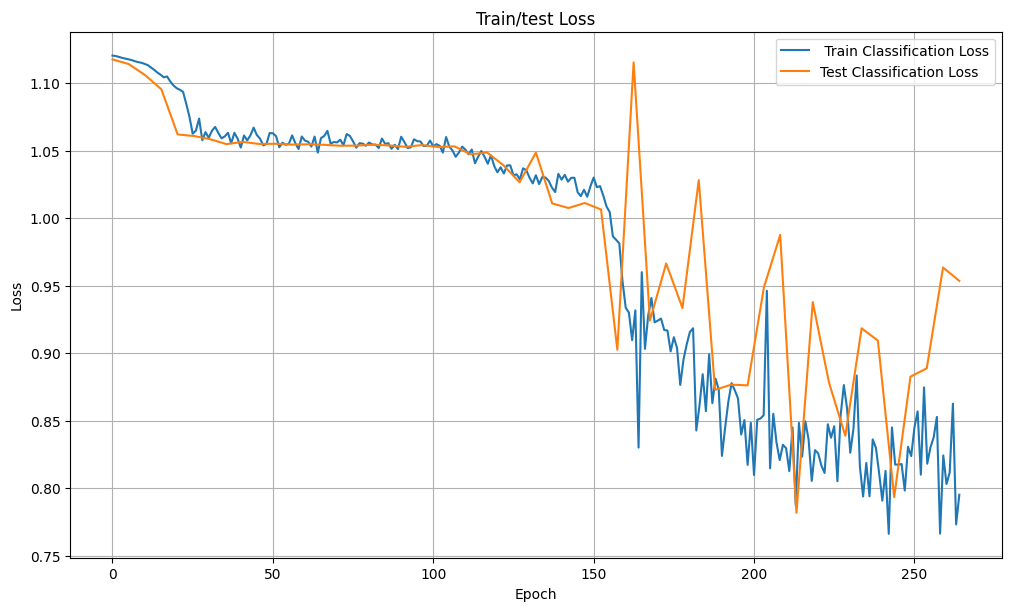

Classification results: {'tp': 63.0, 'fp': 37.0, 'tn': 163.0, 'fn': 37.0, 'accuracy': 0.7533333333333333, 'precision': 0.6083003952569169, 'recall': 0.6166666666666667, 'f1': 0.5929824561403509}


In [6]:
import matplotlib
%matplotlib inline

trainer.plot_history()

# Plot the test results
print("Classification results:", trainer.cls_metric_logger.results)
if cfg.net.detection:
    print("Detection results:", trainer.det_metric_logger.results)



#### Visualize the progress in Tensoboard

One a new terminal, launch tensoboard with log dir set to `./logs`.

```
$ tensorboard --logdir ./logs/ --bind_all
```

## 2. K-Fold Validation

We will use the same steps as in the previous secsion, but this time we will rotate the validation set for K times and run the training in each set. 

In [7]:
from omegaconf import OmegaConf
from utils.misc import get_files_in_dir
from dataset.datasets import split_data
from trainer import Trainer
%load_ext autoreload
%autoreload 2

cfg = OmegaConf.create(OmegaConf.load("./configs/base.yaml"))

n_folds = 5

data = [f.split('.')[0] for f in get_files_in_dir(cfg.data.label_dir, file_end='.csv')]
kfolds_data = split_data(data, n_folds=n_folds)

kfold_cls_results = []
kfold_det_results = []

for i in range(n_folds):
    # Create test samples for this fold
    train_shots, test_shots = kfolds_data[i]
    print(f"fold={i} \n{train_shots=}\n{test_shots=}")

    # create a trainer and train on each fold 
    kfold_trainer = Trainer(cfg, exp_name=f"exp1_{n_folds}folds_training/fold{i+1}")
    kfold_trainer.train(train_shots, test_sets=test_shots)

    kfold_cls_results.append(kfold_trainer.cls_metric_logger.results)
    if cfg.net.detection:
        kfold_det_results.append(kfold_trainer.det_metric_logger.results)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
fold=0 
train_shots=['30458', '30459', '30460', '30461', '30462', '30463', '30464', '30465']
test_shots=['30454', '30457']
Preparing train/test dataset ... 
Creating dataloaders ...
train samples: 8, train batch size: 16, train batches: 1

Verifying train dataloader ... 
{'dalpha': torch.Size([400, 1, 512]), 'dtime': torch.Size([400, 1, 512]), 'cls_labels': torch.Size([400]), 'elm_labels': torch.Size([400, 512])}
val samples: 0, val batch size: 16, val batches: 0

Verifying val dataloader ... 
test samples: 2, test batch size: 16, test batches: 1

Verifying test dataloader ... 


/home/ubuntu/miniconda3/envs/mlvis/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


{'dalpha': torch.Size([100, 1, 512]), 'dtime': torch.Size([100, 1, 512]), 'cls_labels': torch.Size([100]), 'elm_labels': torch.Size([100, 512])}
Training Started (device: cuda:0, rank: 0)
Epoch 0/1000


100%|██████████| 1/1 [00:00<00:00,  6.56it/s, , elm_cls_loss:    1.121, loss:    1.121]


Epoch 1/1000


100%|██████████| 1/1 [00:00<00:00,  7.09it/s, , elm_cls_loss:    1.120, loss:    1.120]


Epoch 2/1000


100%|██████████| 1/1 [00:00<00:00,  7.23it/s, , elm_cls_loss:    1.119, loss:    1.119]


Epoch 3/1000


100%|██████████| 1/1 [00:00<00:00,  7.02it/s, , elm_cls_loss:    1.119, loss:    1.119]


Epoch 4/1000


100%|██████████| 1/1 [00:00<00:00,  7.32it/s, , elm_cls_loss:    1.118, loss:    1.118]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 20.56it/s, test_loss: 1.118,                             test_cls_acc: 0.200]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   20 |   80 |  120 |   80 |      0.467 |       0.067 |    0.333 | 0.111 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  3.48it/s, test_loss: 1.118,                             test_cls_acc: 0.200]


Modelcheckpoint: test/loss improved from inf to 1.117760.
Saving model checkpoint ... 
Early Stopping: test/loss improved from inf to 1.117760.
Epoch 5/1000


100%|██████████| 1/1 [00:00<00:00,  6.92it/s, , elm_cls_loss:    1.118, loss:    1.118]


Epoch 6/1000


100%|██████████| 1/1 [00:00<00:00,  7.19it/s, , elm_cls_loss:    1.117, loss:    1.117]


Epoch 7/1000


100%|██████████| 1/1 [00:00<00:00,  7.28it/s, , elm_cls_loss:    1.117, loss:    1.117]


Epoch 8/1000


100%|██████████| 1/1 [00:00<00:00,  7.41it/s, , elm_cls_loss:    1.116, loss:    1.116]


Epoch 9/1000


100%|██████████| 1/1 [00:00<00:00,  7.39it/s, , elm_cls_loss:    1.115, loss:    1.115]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 26.10it/s, test_loss: 1.114,                             test_cls_acc: 0.200]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   20 |   80 |  120 |   80 |      0.467 |       0.067 |    0.333 | 0.111 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  6.87it/s, test_loss: 1.114,                             test_cls_acc: 0.200]


Modelcheckpoint: test/loss improved from 1.117760 to 1.114468.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.117760 to 1.114468.
Epoch 10/1000


100%|██████████| 1/1 [00:00<00:00,  7.12it/s, , elm_cls_loss:    1.114, loss:    1.114]


Epoch 11/1000


100%|██████████| 1/1 [00:00<00:00,  7.17it/s, , elm_cls_loss:    1.113, loss:    1.113]


Epoch 12/1000


100%|██████████| 1/1 [00:00<00:00,  7.05it/s, , elm_cls_loss:    1.112, loss:    1.112]


Epoch 13/1000


100%|██████████| 1/1 [00:00<00:00,  7.07it/s, , elm_cls_loss:    1.111, loss:    1.111]


Epoch 14/1000


100%|██████████| 1/1 [00:00<00:00,  7.28it/s, , elm_cls_loss:    1.109, loss:    1.109]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 26.26it/s, test_loss: 1.107,                             test_cls_acc: 0.200]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   20 |   80 |  120 |   80 |      0.467 |       0.067 |    0.333 | 0.111 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.69it/s, test_loss: 1.107,                             test_cls_acc: 0.200]


Modelcheckpoint: test/loss improved from 1.114468 to 1.107113.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.114468 to 1.107113.
Epoch 15/1000


100%|██████████| 1/1 [00:00<00:00,  6.16it/s, , elm_cls_loss:    1.108, loss:    1.108]


Epoch 16/1000


100%|██████████| 1/1 [00:00<00:00,  6.99it/s, , elm_cls_loss:    1.106, loss:    1.106]


Epoch 17/1000


100%|██████████| 1/1 [00:00<00:00,  6.97it/s, , elm_cls_loss:    1.105, loss:    1.105]


Epoch 18/1000


100%|██████████| 1/1 [00:00<00:00,  7.24it/s, , elm_cls_loss:    1.102, loss:    1.102]


Epoch 19/1000


100%|██████████| 1/1 [00:00<00:00,  7.10it/s, , elm_cls_loss:    1.101, loss:    1.101]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 26.28it/s, test_loss: 1.096,                             test_cls_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  7.84it/s, test_loss: 1.096,                             test_cls_acc: 0.400]


Modelcheckpoint: test/loss improved from 1.107113 to 1.095636.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.107113 to 1.095636.
Epoch 20/1000


100%|██████████| 1/1 [00:00<00:00,  7.32it/s, , elm_cls_loss:    1.097, loss:    1.097]


Epoch 21/1000


100%|██████████| 1/1 [00:00<00:00,  7.41it/s, , elm_cls_loss:    1.095, loss:    1.095]


Epoch 22/1000


100%|██████████| 1/1 [00:00<00:00,  7.14it/s, , elm_cls_loss:    1.092, loss:    1.092]


Epoch 23/1000


100%|██████████| 1/1 [00:00<00:00,  6.93it/s, , elm_cls_loss:    1.081, loss:    1.081]


Epoch 24/1000


100%|██████████| 1/1 [00:00<00:00,  6.86it/s, , elm_cls_loss:    1.073, loss:    1.073]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 24.60it/s, test_loss: 1.059,                             test_cls_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  6.94it/s, test_loss: 1.059,                             test_cls_acc: 0.400]


Modelcheckpoint: test/loss improved from 1.095636 to 1.058640.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.095636 to 1.058640.
Epoch 25/1000


100%|██████████| 1/1 [00:00<00:00,  7.12it/s, , elm_cls_loss:    1.065, loss:    1.065]


Epoch 26/1000


100%|██████████| 1/1 [00:00<00:00,  6.65it/s, , elm_cls_loss:    1.083, loss:    1.083]


Epoch 27/1000


100%|██████████| 1/1 [00:00<00:00,  7.02it/s, , elm_cls_loss:    1.068, loss:    1.068]


Epoch 28/1000


100%|██████████| 1/1 [00:00<00:00,  6.98it/s, , elm_cls_loss:    1.060, loss:    1.060]


Epoch 29/1000


100%|██████████| 1/1 [00:00<00:00,  6.99it/s, , elm_cls_loss:    1.064, loss:    1.064]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 26.08it/s, test_loss: 1.063,                             test_cls_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  7.41it/s, test_loss: 1.063,                             test_cls_acc: 0.400]


Modelcheckpoint: test/loss didn't improved from 1.058640.
Early Stopping: test/loss didn't improve from 1.058640. Counter will start after 10 warmup steps
Epoch 30/1000


100%|██████████| 1/1 [00:00<00:00,  6.68it/s, , elm_cls_loss:    1.064, loss:    1.064]


Epoch 31/1000


100%|██████████| 1/1 [00:00<00:00,  6.79it/s, , elm_cls_loss:    1.064, loss:    1.064]


Epoch 32/1000


100%|██████████| 1/1 [00:00<00:00,  6.66it/s, , elm_cls_loss:    1.063, loss:    1.063]


Epoch 33/1000


100%|██████████| 1/1 [00:00<00:00,  6.88it/s, , elm_cls_loss:    1.068, loss:    1.068]


Epoch 34/1000


100%|██████████| 1/1 [00:00<00:00,  6.85it/s, , elm_cls_loss:    1.064, loss:    1.064]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 24.46it/s, test_loss: 1.056,                             test_cls_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  7.42it/s, test_loss: 1.056,                             test_cls_acc: 0.400]


Modelcheckpoint: test/loss improved from 1.058640 to 1.056394.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.058640 to 1.056394.
Epoch 35/1000


100%|██████████| 1/1 [00:00<00:00,  7.11it/s, , elm_cls_loss:    1.062, loss:    1.062]


Epoch 36/1000


100%|██████████| 1/1 [00:00<00:00,  7.39it/s, , elm_cls_loss:    1.061, loss:    1.061]


Epoch 37/1000


100%|██████████| 1/1 [00:00<00:00,  7.03it/s, , elm_cls_loss:    1.072, loss:    1.072]


Epoch 38/1000


100%|██████████| 1/1 [00:00<00:00,  7.46it/s, , elm_cls_loss:    1.065, loss:    1.065]


Epoch 39/1000


100%|██████████| 1/1 [00:00<00:00,  7.31it/s, , elm_cls_loss:    1.060, loss:    1.060]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 22.54it/s, test_loss: 1.057,                             test_cls_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  6.84it/s, test_loss: 1.057,                             test_cls_acc: 0.400]


Modelcheckpoint: test/loss didn't improved from 1.056394.
Early Stopping: test/loss didn't improve from 1.056394. Counter will start after 10 warmup steps
Epoch 40/1000


100%|██████████| 1/1 [00:00<00:00,  7.18it/s, , elm_cls_loss:    1.060, loss:    1.060]


Epoch 41/1000


100%|██████████| 1/1 [00:00<00:00,  7.05it/s, , elm_cls_loss:    1.064, loss:    1.064]


Epoch 42/1000


100%|██████████| 1/1 [00:00<00:00,  7.28it/s, , elm_cls_loss:    1.056, loss:    1.056]


Epoch 43/1000


100%|██████████| 1/1 [00:00<00:00,  7.18it/s, , elm_cls_loss:    1.057, loss:    1.057]


Epoch 44/1000


100%|██████████| 1/1 [00:00<00:00,  7.31it/s, , elm_cls_loss:    1.062, loss:    1.062]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 25.02it/s, test_loss: 1.055,                             test_cls_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  7.39it/s, test_loss: 1.055,                             test_cls_acc: 0.400]


Modelcheckpoint: test/loss improved from 1.056394 to 1.055416.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.056394 to 1.055416.
Epoch 45/1000


100%|██████████| 1/1 [00:00<00:00,  7.18it/s, , elm_cls_loss:    1.057, loss:    1.057]


Epoch 46/1000


100%|██████████| 1/1 [00:00<00:00,  7.34it/s, , elm_cls_loss:    1.056, loss:    1.056]


Epoch 47/1000


100%|██████████| 1/1 [00:00<00:00,  7.20it/s, , elm_cls_loss:    1.061, loss:    1.061]


Epoch 48/1000


100%|██████████| 1/1 [00:00<00:00,  7.38it/s, , elm_cls_loss:    1.053, loss:    1.053]


Epoch 49/1000


100%|██████████| 1/1 [00:00<00:00,  7.23it/s, , elm_cls_loss:    1.059, loss:    1.059]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 25.22it/s, test_loss: 1.055,                             test_cls_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  7.49it/s, test_loss: 1.055,                             test_cls_acc: 0.400]


Modelcheckpoint: test/loss improved from 1.055416 to 1.055230.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.055416 to 1.055230.
Epoch 50/1000


100%|██████████| 1/1 [00:00<00:00,  7.23it/s, , elm_cls_loss:    1.057, loss:    1.057]


Epoch 51/1000


100%|██████████| 1/1 [00:00<00:00,  7.22it/s, , elm_cls_loss:    1.058, loss:    1.058]


Epoch 52/1000


100%|██████████| 1/1 [00:00<00:00,  7.05it/s, , elm_cls_loss:    1.052, loss:    1.052]


Epoch 53/1000


100%|██████████| 1/1 [00:00<00:00,  7.37it/s, , elm_cls_loss:    1.052, loss:    1.052]


Epoch 54/1000


100%|██████████| 1/1 [00:00<00:00,  7.41it/s, , elm_cls_loss:    1.056, loss:    1.056]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 26.01it/s, test_loss: 1.055,                             test_cls_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  8.06it/s, test_loss: 1.055,                             test_cls_acc: 0.400]


Modelcheckpoint: test/loss improved from 1.055230 to 1.054937.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.055230 to 1.054937.
Epoch 55/1000


100%|██████████| 1/1 [00:00<00:00,  6.99it/s, , elm_cls_loss:    1.057, loss:    1.057]


Epoch 56/1000


100%|██████████| 1/1 [00:00<00:00,  7.28it/s, , elm_cls_loss:    1.054, loss:    1.054]


Epoch 57/1000


100%|██████████| 1/1 [00:00<00:00,  7.12it/s, , elm_cls_loss:    1.056, loss:    1.056]


Epoch 58/1000


100%|██████████| 1/1 [00:00<00:00,  7.33it/s, , elm_cls_loss:    1.062, loss:    1.062]


Epoch 59/1000


100%|██████████| 1/1 [00:00<00:00,  7.41it/s, , elm_cls_loss:    1.061, loss:    1.061]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 25.40it/s, test_loss: 1.057,                             test_cls_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  7.53it/s, test_loss: 1.057,                             test_cls_acc: 0.400]


Modelcheckpoint: test/loss didn't improved from 1.054937.
Early Stopping: test/loss didn't improve from 1.054937. Early stopping counter: 1/10
Epoch 60/1000


100%|██████████| 1/1 [00:00<00:00,  7.17it/s, , elm_cls_loss:    1.055, loss:    1.055]


Epoch 61/1000


100%|██████████| 1/1 [00:00<00:00,  7.36it/s, , elm_cls_loss:    1.058, loss:    1.058]


Epoch 62/1000


100%|██████████| 1/1 [00:00<00:00,  7.15it/s, , elm_cls_loss:    1.055, loss:    1.055]


Epoch 63/1000


100%|██████████| 1/1 [00:00<00:00,  7.15it/s, , elm_cls_loss:    1.058, loss:    1.058]


Epoch 64/1000


100%|██████████| 1/1 [00:00<00:00,  7.06it/s, , elm_cls_loss:    1.061, loss:    1.061]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 25.71it/s, test_loss: 1.055,                             test_cls_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  8.10it/s, test_loss: 1.055,                             test_cls_acc: 0.400]


Modelcheckpoint: test/loss improved from 1.054937 to 1.054734.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.054937 to 1.054734.
Epoch 65/1000


100%|██████████| 1/1 [00:00<00:00,  7.24it/s, , elm_cls_loss:    1.062, loss:    1.062]


Epoch 66/1000


100%|██████████| 1/1 [00:00<00:00,  7.08it/s, , elm_cls_loss:    1.061, loss:    1.061]


Epoch 67/1000


100%|██████████| 1/1 [00:00<00:00,  7.21it/s, , elm_cls_loss:    1.054, loss:    1.054]


Epoch 68/1000


100%|██████████| 1/1 [00:00<00:00,  7.27it/s, , elm_cls_loss:    1.057, loss:    1.057]


Epoch 69/1000


100%|██████████| 1/1 [00:00<00:00,  7.15it/s, , elm_cls_loss:    1.058, loss:    1.058]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 24.04it/s, test_loss: 1.056,                             test_cls_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  7.51it/s, test_loss: 1.056,                             test_cls_acc: 0.400]


Modelcheckpoint: test/loss didn't improved from 1.054734.
Early Stopping: test/loss didn't improve from 1.054734. Early stopping counter: 1/10
Epoch 70/1000


100%|██████████| 1/1 [00:00<00:00,  7.25it/s, , elm_cls_loss:    1.057, loss:    1.057]


Epoch 71/1000


100%|██████████| 1/1 [00:00<00:00,  7.38it/s, , elm_cls_loss:    1.058, loss:    1.058]


Epoch 72/1000


100%|██████████| 1/1 [00:00<00:00,  7.07it/s, , elm_cls_loss:    1.055, loss:    1.055]


Epoch 73/1000


100%|██████████| 1/1 [00:00<00:00,  7.27it/s, , elm_cls_loss:    1.056, loss:    1.056]


Epoch 74/1000


100%|██████████| 1/1 [00:00<00:00,  7.18it/s, , elm_cls_loss:    1.056, loss:    1.056]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 25.33it/s, test_loss: 1.054,                             test_cls_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  7.64it/s, test_loss: 1.054,                             test_cls_acc: 0.400]


Modelcheckpoint: test/loss improved from 1.054734 to 1.053898.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.054734 to 1.053898.
Epoch 75/1000


100%|██████████| 1/1 [00:00<00:00,  6.82it/s, , elm_cls_loss:    1.054, loss:    1.054]


Epoch 76/1000


100%|██████████| 1/1 [00:00<00:00,  7.13it/s, , elm_cls_loss:    1.059, loss:    1.059]


Epoch 77/1000


100%|██████████| 1/1 [00:00<00:00,  7.24it/s, , elm_cls_loss:    1.057, loss:    1.057]


Epoch 78/1000


100%|██████████| 1/1 [00:00<00:00,  7.06it/s, , elm_cls_loss:    1.065, loss:    1.065]


Epoch 79/1000


100%|██████████| 1/1 [00:00<00:00,  7.27it/s, , elm_cls_loss:    1.055, loss:    1.055]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 25.00it/s, test_loss: 1.056,                             test_cls_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  7.73it/s, test_loss: 1.056,                             test_cls_acc: 0.400]


Modelcheckpoint: test/loss didn't improved from 1.053898.
Early Stopping: test/loss didn't improve from 1.053898. Early stopping counter: 1/10
Epoch 80/1000


100%|██████████| 1/1 [00:00<00:00,  6.95it/s, , elm_cls_loss:    1.055, loss:    1.055]


Epoch 81/1000


100%|██████████| 1/1 [00:00<00:00,  7.27it/s, , elm_cls_loss:    1.056, loss:    1.056]


Epoch 82/1000


100%|██████████| 1/1 [00:00<00:00,  7.20it/s, , elm_cls_loss:    1.053, loss:    1.053]


Epoch 83/1000


100%|██████████| 1/1 [00:00<00:00,  7.17it/s, , elm_cls_loss:    1.057, loss:    1.057]


Epoch 84/1000


100%|██████████| 1/1 [00:00<00:00,  7.25it/s, , elm_cls_loss:    1.059, loss:    1.059]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 24.77it/s, test_loss: 1.054,                             test_cls_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  8.25it/s, test_loss: 1.054,                             test_cls_acc: 0.400]


Modelcheckpoint: test/loss didn't improved from 1.053898.
Early Stopping: test/loss didn't improve from 1.053898. Early stopping counter: 2/10
Epoch 85/1000


100%|██████████| 1/1 [00:00<00:00,  7.14it/s, , elm_cls_loss:    1.056, loss:    1.056]


Epoch 86/1000


100%|██████████| 1/1 [00:00<00:00,  7.22it/s, , elm_cls_loss:    1.057, loss:    1.057]


Epoch 87/1000


100%|██████████| 1/1 [00:00<00:00,  7.22it/s, , elm_cls_loss:    1.059, loss:    1.059]


Epoch 88/1000


100%|██████████| 1/1 [00:00<00:00,  6.96it/s, , elm_cls_loss:    1.060, loss:    1.060]


Epoch 89/1000


100%|██████████| 1/1 [00:00<00:00,  7.05it/s, , elm_cls_loss:    1.056, loss:    1.056]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 25.19it/s, test_loss: 1.054,                             test_cls_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  8.09it/s, test_loss: 1.054,                             test_cls_acc: 0.400]


Modelcheckpoint: test/loss didn't improved from 1.053898.
Early Stopping: test/loss didn't improve from 1.053898. Early stopping counter: 3/10
Epoch 90/1000


100%|██████████| 1/1 [00:00<00:00,  7.15it/s, , elm_cls_loss:    1.057, loss:    1.057]


Epoch 91/1000


100%|██████████| 1/1 [00:00<00:00,  7.20it/s, , elm_cls_loss:    1.059, loss:    1.059]


Epoch 92/1000


100%|██████████| 1/1 [00:00<00:00,  6.98it/s, , elm_cls_loss:    1.057, loss:    1.057]


Epoch 93/1000


100%|██████████| 1/1 [00:00<00:00,  7.09it/s, , elm_cls_loss:    1.055, loss:    1.055]


Epoch 94/1000


100%|██████████| 1/1 [00:00<00:00,  7.23it/s, , elm_cls_loss:    1.055, loss:    1.055]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 24.27it/s, test_loss: 1.055,                             test_cls_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  8.19it/s, test_loss: 1.055,                             test_cls_acc: 0.400]


Modelcheckpoint: test/loss didn't improved from 1.053898.
Early Stopping: test/loss didn't improve from 1.053898. Early stopping counter: 4/10
Epoch 95/1000


100%|██████████| 1/1 [00:00<00:00,  7.02it/s, , elm_cls_loss:    1.057, loss:    1.057]


Epoch 96/1000


100%|██████████| 1/1 [00:00<00:00,  7.16it/s, , elm_cls_loss:    1.056, loss:    1.056]


Epoch 97/1000


100%|██████████| 1/1 [00:00<00:00,  7.22it/s, , elm_cls_loss:    1.055, loss:    1.055]


Epoch 98/1000


100%|██████████| 1/1 [00:00<00:00,  7.13it/s, , elm_cls_loss:    1.058, loss:    1.058]


Epoch 99/1000


100%|██████████| 1/1 [00:00<00:00,  7.15it/s, , elm_cls_loss:    1.054, loss:    1.054]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 24.36it/s, test_loss: 1.054,                             test_cls_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  8.23it/s, test_loss: 1.054,                             test_cls_acc: 0.400]


Modelcheckpoint: test/loss improved from 1.053898 to 1.053855.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.053898 to 1.053855.
Epoch 100/1000


100%|██████████| 1/1 [00:00<00:00,  7.20it/s, , elm_cls_loss:    1.056, loss:    1.056]


Epoch 101/1000


100%|██████████| 1/1 [00:00<00:00,  6.82it/s, , elm_cls_loss:    1.064, loss:    1.064]


Epoch 102/1000


100%|██████████| 1/1 [00:00<00:00,  6.66it/s, , elm_cls_loss:    1.051, loss:    1.051]


Epoch 103/1000


100%|██████████| 1/1 [00:00<00:00,  6.82it/s, , elm_cls_loss:    1.055, loss:    1.055]


Epoch 104/1000


100%|██████████| 1/1 [00:00<00:00,  7.05it/s, , elm_cls_loss:    1.055, loss:    1.055]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.46it/s, test_loss: 1.056,                             test_cls_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  7.89it/s, test_loss: 1.056,                             test_cls_acc: 0.400]


Modelcheckpoint: test/loss didn't improved from 1.053855.
Early Stopping: test/loss didn't improve from 1.053855. Early stopping counter: 1/10
Epoch 105/1000


100%|██████████| 1/1 [00:00<00:00,  6.93it/s, , elm_cls_loss:    1.057, loss:    1.057]


Epoch 106/1000


100%|██████████| 1/1 [00:00<00:00,  7.10it/s, , elm_cls_loss:    1.053, loss:    1.053]


Epoch 107/1000


100%|██████████| 1/1 [00:00<00:00,  7.19it/s, , elm_cls_loss:    1.054, loss:    1.054]


Epoch 108/1000


100%|██████████| 1/1 [00:00<00:00,  7.22it/s, , elm_cls_loss:    1.056, loss:    1.056]


Epoch 109/1000


100%|██████████| 1/1 [00:00<00:00,  7.14it/s, , elm_cls_loss:    1.060, loss:    1.060]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 25.27it/s, test_loss: 1.053,                             test_cls_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  8.09it/s, test_loss: 1.053,                             test_cls_acc: 0.400]


Modelcheckpoint: test/loss improved from 1.053855 to 1.053085.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.053855 to 1.053085.
Epoch 110/1000


100%|██████████| 1/1 [00:00<00:00,  7.24it/s, , elm_cls_loss:    1.055, loss:    1.055]


Epoch 111/1000


100%|██████████| 1/1 [00:00<00:00,  7.36it/s, , elm_cls_loss:    1.052, loss:    1.052]


Epoch 112/1000


100%|██████████| 1/1 [00:00<00:00,  7.20it/s, , elm_cls_loss:    1.054, loss:    1.054]


Epoch 113/1000


100%|██████████| 1/1 [00:00<00:00,  7.11it/s, , elm_cls_loss:    1.054, loss:    1.054]


Epoch 114/1000


100%|██████████| 1/1 [00:00<00:00,  7.27it/s, , elm_cls_loss:    1.049, loss:    1.049]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.68it/s, test_loss: 1.054,                             test_cls_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  8.20it/s, test_loss: 1.054,                             test_cls_acc: 0.400]


Modelcheckpoint: test/loss didn't improved from 1.053085.
Early Stopping: test/loss didn't improve from 1.053085. Early stopping counter: 1/10
Epoch 115/1000


100%|██████████| 1/1 [00:00<00:00,  7.29it/s, , elm_cls_loss:    1.050, loss:    1.050]


Epoch 116/1000


100%|██████████| 1/1 [00:00<00:00,  7.20it/s, , elm_cls_loss:    1.049, loss:    1.049]


Epoch 117/1000


100%|██████████| 1/1 [00:00<00:00,  7.33it/s, , elm_cls_loss:    1.051, loss:    1.051]


Epoch 118/1000


100%|██████████| 1/1 [00:00<00:00,  7.16it/s, , elm_cls_loss:    1.050, loss:    1.050]


Epoch 119/1000


100%|██████████| 1/1 [00:00<00:00,  7.27it/s, , elm_cls_loss:    1.042, loss:    1.042]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 25.95it/s, test_loss: 1.053,                             test_cls_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  8.20it/s, test_loss: 1.053,                             test_cls_acc: 0.400]


Modelcheckpoint: test/loss improved from 1.053085 to 1.052707.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.053085 to 1.052707.
Epoch 120/1000


100%|██████████| 1/1 [00:00<00:00,  6.88it/s, , elm_cls_loss:    1.050, loss:    1.050]


Epoch 121/1000


100%|██████████| 1/1 [00:00<00:00,  7.29it/s, , elm_cls_loss:    1.048, loss:    1.048]


Epoch 122/1000


100%|██████████| 1/1 [00:00<00:00,  7.28it/s, , elm_cls_loss:    1.046, loss:    1.046]


Epoch 123/1000


100%|██████████| 1/1 [00:00<00:00,  6.89it/s, , elm_cls_loss:    1.045, loss:    1.045]


Epoch 124/1000


100%|██████████| 1/1 [00:00<00:00,  7.27it/s, , elm_cls_loss:    1.040, loss:    1.040]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 24.77it/s, test_loss: 1.047,                             test_cls_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  7.51it/s, test_loss: 1.047,                             test_cls_acc: 0.400]


Modelcheckpoint: test/loss improved from 1.052707 to 1.047138.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.052707 to 1.047138.
Epoch 125/1000


100%|██████████| 1/1 [00:00<00:00,  7.19it/s, , elm_cls_loss:    1.038, loss:    1.038]


Epoch 126/1000


100%|██████████| 1/1 [00:00<00:00,  7.37it/s, , elm_cls_loss:    1.042, loss:    1.042]


Epoch 127/1000


100%|██████████| 1/1 [00:00<00:00,  7.04it/s, , elm_cls_loss:    1.045, loss:    1.045]


Epoch 128/1000


100%|██████████| 1/1 [00:00<00:00,  7.15it/s, , elm_cls_loss:    1.036, loss:    1.036]


Epoch 129/1000


100%|██████████| 1/1 [00:00<00:00,  7.37it/s, , elm_cls_loss:    1.037, loss:    1.037]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 24.83it/s, test_loss: 1.043,                             test_cls_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  8.04it/s, test_loss: 1.043,                             test_cls_acc: 0.400]


Modelcheckpoint: test/loss improved from 1.047138 to 1.043106.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.047138 to 1.043106.
Epoch 130/1000


100%|██████████| 1/1 [00:00<00:00,  6.94it/s, , elm_cls_loss:    1.035, loss:    1.035]


Epoch 131/1000


100%|██████████| 1/1 [00:00<00:00,  7.24it/s, , elm_cls_loss:    1.035, loss:    1.035]


Epoch 132/1000


100%|██████████| 1/1 [00:00<00:00,  7.18it/s, , elm_cls_loss:    1.033, loss:    1.033]


Epoch 133/1000


100%|██████████| 1/1 [00:00<00:00,  7.45it/s, , elm_cls_loss:    1.028, loss:    1.028]


Epoch 134/1000


100%|██████████| 1/1 [00:00<00:00,  7.05it/s, , elm_cls_loss:    1.031, loss:    1.031]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 25.68it/s, test_loss: 1.039,                             test_cls_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  8.14it/s, test_loss: 1.039,                             test_cls_acc: 0.400]


Modelcheckpoint: test/loss improved from 1.043106 to 1.039091.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.043106 to 1.039091.
Epoch 135/1000


100%|██████████| 1/1 [00:00<00:00,  7.26it/s, , elm_cls_loss:    1.031, loss:    1.031]


Epoch 136/1000


100%|██████████| 1/1 [00:00<00:00,  7.33it/s, , elm_cls_loss:    1.024, loss:    1.024]


Epoch 137/1000


100%|██████████| 1/1 [00:00<00:00,  7.16it/s, , elm_cls_loss:    1.026, loss:    1.026]


Epoch 138/1000


100%|██████████| 1/1 [00:00<00:00,  7.18it/s, , elm_cls_loss:    1.031, loss:    1.031]


Epoch 139/1000


100%|██████████| 1/1 [00:00<00:00,  7.29it/s, , elm_cls_loss:    1.028, loss:    1.028]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 24.83it/s, test_loss: 1.043,                             test_cls_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  8.10it/s, test_loss: 1.043,                             test_cls_acc: 0.400]


Modelcheckpoint: test/loss didn't improved from 1.039091.
Early Stopping: test/loss didn't improve from 1.039091. Early stopping counter: 1/10
Epoch 140/1000


100%|██████████| 1/1 [00:00<00:00,  7.28it/s, , elm_cls_loss:    1.028, loss:    1.028]


Epoch 141/1000


100%|██████████| 1/1 [00:00<00:00,  7.36it/s, , elm_cls_loss:    1.034, loss:    1.034]


Epoch 142/1000


100%|██████████| 1/1 [00:00<00:00,  7.25it/s, , elm_cls_loss:    1.031, loss:    1.031]


Epoch 143/1000


100%|██████████| 1/1 [00:00<00:00,  7.28it/s, , elm_cls_loss:    1.022, loss:    1.022]


Epoch 144/1000


100%|██████████| 1/1 [00:00<00:00,  7.39it/s, , elm_cls_loss:    1.014, loss:    1.014]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 24.32it/s, test_loss: 1.032,                             test_cls_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  8.40it/s, test_loss: 1.032,                             test_cls_acc: 0.400]


Modelcheckpoint: test/loss improved from 1.039091 to 1.031939.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.039091 to 1.031939.
Epoch 145/1000


100%|██████████| 1/1 [00:00<00:00,  7.24it/s, , elm_cls_loss:    1.016, loss:    1.016]


Epoch 146/1000


100%|██████████| 1/1 [00:00<00:00,  7.31it/s, , elm_cls_loss:    1.022, loss:    1.022]


Epoch 147/1000


100%|██████████| 1/1 [00:00<00:00,  7.41it/s, , elm_cls_loss:    1.024, loss:    1.024]


Epoch 148/1000


100%|██████████| 1/1 [00:00<00:00,  7.35it/s, , elm_cls_loss:    1.012, loss:    1.012]


Epoch 149/1000


100%|██████████| 1/1 [00:00<00:00,  7.46it/s, , elm_cls_loss:    1.026, loss:    1.026]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.10it/s, test_loss: 1.036,                             test_cls_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  8.03it/s, test_loss: 1.036,                             test_cls_acc: 0.400]


Modelcheckpoint: test/loss didn't improved from 1.031939.
Early Stopping: test/loss didn't improve from 1.031939. Early stopping counter: 1/10
Epoch 150/1000


100%|██████████| 1/1 [00:00<00:00,  7.33it/s, , elm_cls_loss:    1.026, loss:    1.026]


Epoch 151/1000


100%|██████████| 1/1 [00:00<00:00,  7.54it/s, , elm_cls_loss:    1.021, loss:    1.021]


Epoch 152/1000


100%|██████████| 1/1 [00:00<00:00,  7.68it/s, , elm_cls_loss:    1.019, loss:    1.019]


Epoch 153/1000


100%|██████████| 1/1 [00:00<00:00,  7.50it/s, , elm_cls_loss:    1.013, loss:    1.013]


Epoch 154/1000


100%|██████████| 1/1 [00:00<00:00,  7.39it/s, , elm_cls_loss:    1.014, loss:    1.014]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 24.71it/s, test_loss: 1.051,                             test_cls_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  7.97it/s, test_loss: 1.051,                             test_cls_acc: 0.400]


Modelcheckpoint: test/loss didn't improved from 1.031939.
Early Stopping: test/loss didn't improve from 1.031939. Early stopping counter: 2/10
Epoch 155/1000


100%|██████████| 1/1 [00:00<00:00,  7.37it/s, , elm_cls_loss:    1.010, loss:    1.010]


Epoch 156/1000


100%|██████████| 1/1 [00:00<00:00,  7.67it/s, , elm_cls_loss:    0.998, loss:    0.998]


Epoch 157/1000


100%|██████████| 1/1 [00:00<00:00,  7.28it/s, , elm_cls_loss:    1.005, loss:    1.005]


Epoch 158/1000


100%|██████████| 1/1 [00:00<00:00,  7.32it/s, , elm_cls_loss:    1.007, loss:    1.007]


Epoch 159/1000


100%|██████████| 1/1 [00:00<00:00,  7.44it/s, , elm_cls_loss:    1.004, loss:    1.004]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 24.68it/s, test_loss: 1.032,                             test_cls_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  8.22it/s, test_loss: 1.032,                             test_cls_acc: 0.400]


Modelcheckpoint: test/loss didn't improved from 1.031939.
Early Stopping: test/loss didn't improve from 1.031939. Early stopping counter: 3/10
Epoch 160/1000


100%|██████████| 1/1 [00:00<00:00,  7.41it/s, , elm_cls_loss:    0.999, loss:    0.999]


Epoch 161/1000


100%|██████████| 1/1 [00:00<00:00,  7.52it/s, , elm_cls_loss:    1.004, loss:    1.004]


Epoch 162/1000


100%|██████████| 1/1 [00:00<00:00,  7.67it/s, , elm_cls_loss:    0.997, loss:    0.997]


Epoch 163/1000


100%|██████████| 1/1 [00:00<00:00,  7.21it/s, , elm_cls_loss:    0.994, loss:    0.994]


Epoch 164/1000


100%|██████████| 1/1 [00:00<00:00,  7.25it/s, , elm_cls_loss:    0.972, loss:    0.972]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 24.00it/s, test_loss: 1.023,                             test_cls_acc: 0.390]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   39 |   61 |  139 |   61 |      0.593 |       0.226 |    0.325 | 0.225 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  8.15it/s, test_loss: 1.023,                             test_cls_acc: 0.390]


Modelcheckpoint: test/loss improved from 1.031939 to 1.023143.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.031939 to 1.023143.
Epoch 165/1000


100%|██████████| 1/1 [00:00<00:00,  7.02it/s, , elm_cls_loss:    0.970, loss:    0.970]


Epoch 166/1000


100%|██████████| 1/1 [00:00<00:00,  7.45it/s, , elm_cls_loss:    0.961, loss:    0.961]


Epoch 167/1000


100%|██████████| 1/1 [00:00<00:00,  7.55it/s, , elm_cls_loss:    0.939, loss:    0.939]


Epoch 168/1000


100%|██████████| 1/1 [00:00<00:00,  7.16it/s, , elm_cls_loss:    0.984, loss:    0.984]


Epoch 169/1000


100%|██████████| 1/1 [00:00<00:00,  7.60it/s, , elm_cls_loss:    0.870, loss:    0.870]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 24.21it/s, test_loss: 1.016,                             test_cls_acc: 0.710]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   71 |   29 |  171 |   29 |      0.807 |       0.473 |    0.592 | 0.526 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.66it/s, test_loss: 1.016,                             test_cls_acc: 0.710]


Modelcheckpoint: test/loss improved from 1.023143 to 1.015856.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.023143 to 1.015856.
Epoch 170/1000


100%|██████████| 1/1 [00:00<00:00,  7.50it/s, , elm_cls_loss:    0.888, loss:    0.888]


Epoch 171/1000


100%|██████████| 1/1 [00:00<00:00,  7.31it/s, , elm_cls_loss:    0.807, loss:    0.807]


Epoch 172/1000


100%|██████████| 1/1 [00:00<00:00,  7.44it/s, , elm_cls_loss:    0.833, loss:    0.833]


Epoch 173/1000


100%|██████████| 1/1 [00:00<00:00,  7.62it/s, , elm_cls_loss:    0.807, loss:    0.807]


Epoch 174/1000


100%|██████████| 1/1 [00:00<00:00,  7.18it/s, , elm_cls_loss:    0.791, loss:    0.791]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 24.30it/s, test_loss: 1.023,                             test_cls_acc: 0.410]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   41 |   59 |  141 |   59 |      0.607 |       0.488 |    0.342 | 0.228 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  8.28it/s, test_loss: 1.023,                             test_cls_acc: 0.410]


Modelcheckpoint: test/loss didn't improved from 1.015856.
Early Stopping: test/loss didn't improve from 1.015856. Early stopping counter: 1/10
Epoch 175/1000


100%|██████████| 1/1 [00:00<00:00,  7.35it/s, , elm_cls_loss:    1.020, loss:    1.020]


Epoch 176/1000


100%|██████████| 1/1 [00:00<00:00,  7.36it/s, , elm_cls_loss:    1.064, loss:    1.064]


Epoch 177/1000


100%|██████████| 1/1 [00:00<00:00,  6.79it/s, , elm_cls_loss:    0.887, loss:    0.887]


Epoch 178/1000


100%|██████████| 1/1 [00:00<00:00,  7.70it/s, , elm_cls_loss:    0.762, loss:    0.762]


Epoch 179/1000


100%|██████████| 1/1 [00:00<00:00,  7.51it/s, , elm_cls_loss:    0.769, loss:    0.769]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 24.64it/s, test_loss: 0.958,                             test_cls_acc: 0.720]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   72 |   28 |  172 |   28 |      0.813 |       0.481 |      0.6 | 0.533 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.62it/s, test_loss: 0.958,                             test_cls_acc: 0.720]


Modelcheckpoint: test/loss improved from 1.015856 to 0.958233.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.015856 to 0.958233.
Epoch 180/1000


100%|██████████| 1/1 [00:00<00:00,  7.32it/s, , elm_cls_loss:    0.767, loss:    0.767]


Epoch 181/1000


100%|██████████| 1/1 [00:00<00:00,  7.11it/s, , elm_cls_loss:    0.858, loss:    0.858]


Epoch 182/1000


100%|██████████| 1/1 [00:00<00:00,  7.52it/s, , elm_cls_loss:    0.797, loss:    0.797]


Epoch 183/1000


100%|██████████| 1/1 [00:00<00:00,  7.67it/s, , elm_cls_loss:    0.806, loss:    0.806]


Epoch 184/1000


100%|██████████| 1/1 [00:00<00:00,  7.58it/s, , elm_cls_loss:    0.762, loss:    0.762]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 22.19it/s, test_loss: 0.909,                             test_cls_acc: 0.720]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   72 |   28 |  172 |   28 |      0.813 |        0.48 |      0.6 | 0.533 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.38it/s, test_loss: 0.909,                             test_cls_acc: 0.720]


Modelcheckpoint: test/loss improved from 0.958233 to 0.909487.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.958233 to 0.909487.
Epoch 185/1000


100%|██████████| 1/1 [00:00<00:00,  7.36it/s, , elm_cls_loss:    0.746, loss:    0.746]


Epoch 186/1000


100%|██████████| 1/1 [00:00<00:00,  7.37it/s, , elm_cls_loss:    0.757, loss:    0.757]


Epoch 187/1000


100%|██████████| 1/1 [00:00<00:00,  7.64it/s, , elm_cls_loss:    0.734, loss:    0.734]


Epoch 188/1000


100%|██████████| 1/1 [00:00<00:00,  7.30it/s, , elm_cls_loss:    0.724, loss:    0.724]


Epoch 189/1000


100%|██████████| 1/1 [00:00<00:00,  7.39it/s, , elm_cls_loss:    0.768, loss:    0.768]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 25.38it/s, test_loss: 0.867,                             test_cls_acc: 0.720]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   72 |   28 |  172 |   28 |      0.813 |       0.489 |      0.6 | 0.533 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  8.02it/s, test_loss: 0.867,                             test_cls_acc: 0.720]


Modelcheckpoint: test/loss improved from 0.909487 to 0.867191.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.909487 to 0.867191.
Epoch 190/1000


100%|██████████| 1/1 [00:00<00:00,  6.49it/s, , elm_cls_loss:    0.760, loss:    0.760]


Epoch 191/1000


100%|██████████| 1/1 [00:00<00:00,  7.31it/s, , elm_cls_loss:    0.750, loss:    0.750]


Epoch 192/1000


100%|██████████| 1/1 [00:00<00:00,  7.48it/s, , elm_cls_loss:    0.753, loss:    0.753]


Epoch 193/1000


100%|██████████| 1/1 [00:00<00:00,  7.54it/s, , elm_cls_loss:    0.755, loss:    0.755]


Epoch 194/1000


100%|██████████| 1/1 [00:00<00:00,  7.44it/s, , elm_cls_loss:    0.709, loss:    0.709]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 25.69it/s, test_loss: 0.813,                             test_cls_acc: 0.730]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   73 |   27 |  173 |   27 |       0.82 |       0.501 |    0.608 | 0.543 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  8.32it/s, test_loss: 0.813,                             test_cls_acc: 0.730]


Modelcheckpoint: test/loss improved from 0.867191 to 0.813382.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.867191 to 0.813382.
Epoch 195/1000


100%|██████████| 1/1 [00:00<00:00,  7.24it/s, , elm_cls_loss:    0.693, loss:    0.693]


Epoch 196/1000


100%|██████████| 1/1 [00:00<00:00,  7.52it/s, , elm_cls_loss:    0.748, loss:    0.748]


Epoch 197/1000


100%|██████████| 1/1 [00:00<00:00,  7.38it/s, , elm_cls_loss:    0.707, loss:    0.707]


Epoch 198/1000


100%|██████████| 1/1 [00:00<00:00,  7.26it/s, , elm_cls_loss:    0.716, loss:    0.716]


Epoch 199/1000


100%|██████████| 1/1 [00:00<00:00,  7.51it/s, , elm_cls_loss:    0.709, loss:    0.709]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 24.30it/s, test_loss: 0.718,                             test_cls_acc: 0.750]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   75 |   25 |  175 |   25 |      0.833 |       0.514 |    0.625 | 0.558 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.90it/s, test_loss: 0.718,                             test_cls_acc: 0.750]


Modelcheckpoint: test/loss improved from 0.813382 to 0.717503.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.813382 to 0.717503.
Epoch 200/1000


100%|██████████| 1/1 [00:00<00:00,  7.39it/s, , elm_cls_loss:    0.706, loss:    0.706]


Epoch 201/1000


100%|██████████| 1/1 [00:00<00:00,  7.46it/s, , elm_cls_loss:    0.715, loss:    0.715]


Epoch 202/1000


100%|██████████| 1/1 [00:00<00:00,  7.61it/s, , elm_cls_loss:    0.697, loss:    0.697]


Epoch 203/1000


100%|██████████| 1/1 [00:00<00:00,  7.43it/s, , elm_cls_loss:    0.688, loss:    0.688]


Epoch 204/1000


100%|██████████| 1/1 [00:00<00:00,  7.56it/s, , elm_cls_loss:    0.678, loss:    0.678]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 24.52it/s, test_loss: 0.768,                             test_cls_acc: 0.750]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   75 |   25 |  175 |   25 |      0.833 |       0.511 |    0.625 | 0.557 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  8.26it/s, test_loss: 0.768,                             test_cls_acc: 0.750]


Modelcheckpoint: test/loss didn't improved from 0.717503.
Early Stopping: test/loss didn't improve from 0.717503. Early stopping counter: 1/10
Epoch 205/1000


100%|██████████| 1/1 [00:00<00:00,  7.51it/s, , elm_cls_loss:    0.712, loss:    0.712]


Epoch 206/1000


100%|██████████| 1/1 [00:00<00:00,  7.30it/s, , elm_cls_loss:    0.743, loss:    0.743]


Epoch 207/1000


100%|██████████| 1/1 [00:00<00:00,  7.49it/s, , elm_cls_loss:    0.691, loss:    0.691]


Epoch 208/1000


100%|██████████| 1/1 [00:00<00:00,  7.61it/s, , elm_cls_loss:    0.743, loss:    0.743]


Epoch 209/1000


100%|██████████| 1/1 [00:00<00:00,  7.49it/s, , elm_cls_loss:    0.686, loss:    0.686]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 25.09it/s, test_loss: 0.709,                             test_cls_acc: 0.730]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   73 |   27 |  173 |   27 |       0.82 |       0.502 |    0.608 | 0.547 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  8.37it/s, test_loss: 0.709,                             test_cls_acc: 0.730]


Modelcheckpoint: test/loss improved from 0.717503 to 0.709223.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.717503 to 0.709223.
Epoch 210/1000


100%|██████████| 1/1 [00:00<00:00,  7.55it/s, , elm_cls_loss:    0.756, loss:    0.756]


Epoch 211/1000


100%|██████████| 1/1 [00:00<00:00,  7.09it/s, , elm_cls_loss:    0.706, loss:    0.706]


Epoch 212/1000


100%|██████████| 1/1 [00:00<00:00,  7.41it/s, , elm_cls_loss:    0.650, loss:    0.650]


Epoch 213/1000


100%|██████████| 1/1 [00:00<00:00,  7.57it/s, , elm_cls_loss:    0.696, loss:    0.696]


Epoch 214/1000


100%|██████████| 1/1 [00:00<00:00,  7.46it/s, , elm_cls_loss:    0.685, loss:    0.685]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 24.92it/s, test_loss: 0.945,                             test_cls_acc: 0.790]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   79 |   21 |  179 |   21 |       0.86 |       0.744 |      0.7 | 0.692 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  8.17it/s, test_loss: 0.945,                             test_cls_acc: 0.790]


Modelcheckpoint: test/loss didn't improved from 0.709223.
Early Stopping: test/loss didn't improve from 0.709223. Early stopping counter: 1/10
Epoch 215/1000


100%|██████████| 1/1 [00:00<00:00,  7.63it/s, , elm_cls_loss:    0.690, loss:    0.690]

Epoch 216/1000



100%|██████████| 1/1 [00:00<00:00,  7.72it/s, , elm_cls_loss:    0.649, loss:    0.649]


Epoch 217/1000


100%|██████████| 1/1 [00:00<00:00,  7.52it/s, , elm_cls_loss:    0.680, loss:    0.680]


Epoch 218/1000


100%|██████████| 1/1 [00:00<00:00,  7.71it/s, , elm_cls_loss:    0.642, loss:    0.642]


Epoch 219/1000


100%|██████████| 1/1 [00:00<00:00,  7.42it/s, , elm_cls_loss:    0.695, loss:    0.695]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 24.71it/s, test_loss: 0.674,                             test_cls_acc: 0.790]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   79 |   21 |  179 |   21 |       0.86 |       0.856 |    0.708 | 0.715 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  8.03it/s, test_loss: 0.674,                             test_cls_acc: 0.790]


Modelcheckpoint: test/loss improved from 0.709223 to 0.673519.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.709223 to 0.673519.
Epoch 220/1000


100%|██████████| 1/1 [00:00<00:00,  7.36it/s, , elm_cls_loss:    0.688, loss:    0.688]


Epoch 221/1000


100%|██████████| 1/1 [00:00<00:00,  7.34it/s, , elm_cls_loss:    0.703, loss:    0.703]


Epoch 222/1000


100%|██████████| 1/1 [00:00<00:00,  6.69it/s, , elm_cls_loss:    0.701, loss:    0.701]


Epoch 223/1000


100%|██████████| 1/1 [00:00<00:00,  7.35it/s, , elm_cls_loss:    0.656, loss:    0.656]


Epoch 224/1000


100%|██████████| 1/1 [00:00<00:00,  7.48it/s, , elm_cls_loss:    0.670, loss:    0.670]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 24.99it/s, test_loss: 0.674,                             test_cls_acc: 0.790]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   79 |   21 |  179 |   21 |       0.86 |        0.78 |    0.717 | 0.722 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  8.09it/s, test_loss: 0.674,                             test_cls_acc: 0.790]


Modelcheckpoint: test/loss didn't improved from 0.673519.
Early Stopping: test/loss didn't improve from 0.673519. Early stopping counter: 1/10
Epoch 225/1000


100%|██████████| 1/1 [00:00<00:00,  7.46it/s, , elm_cls_loss:    0.638, loss:    0.638]


Epoch 226/1000


100%|██████████| 1/1 [00:00<00:00,  7.56it/s, , elm_cls_loss:    0.614, loss:    0.614]


Epoch 227/1000


100%|██████████| 1/1 [00:00<00:00,  7.55it/s, , elm_cls_loss:    0.590, loss:    0.590]


Epoch 228/1000


100%|██████████| 1/1 [00:00<00:00,  7.26it/s, , elm_cls_loss:    0.711, loss:    0.711]


Epoch 229/1000


100%|██████████| 1/1 [00:00<00:00,  7.47it/s, , elm_cls_loss:    0.692, loss:    0.692]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.18it/s, test_loss: 0.573,                             test_cls_acc: 0.830]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   83 |   17 |  183 |   17 |      0.887 |       0.799 |    0.775 | 0.781 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.99it/s, test_loss: 0.573,                             test_cls_acc: 0.830]


Modelcheckpoint: test/loss improved from 0.673519 to 0.573164.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.673519 to 0.573164.
Epoch 230/1000


100%|██████████| 1/1 [00:00<00:00,  7.41it/s, , elm_cls_loss:    0.644, loss:    0.644]


Epoch 231/1000


100%|██████████| 1/1 [00:00<00:00,  7.57it/s, , elm_cls_loss:    0.652, loss:    0.652]


Epoch 232/1000


100%|██████████| 1/1 [00:00<00:00,  7.54it/s, , elm_cls_loss:    0.611, loss:    0.611]


Epoch 233/1000


100%|██████████| 1/1 [00:00<00:00,  7.50it/s, , elm_cls_loss:    0.659, loss:    0.659]


Epoch 234/1000


100%|██████████| 1/1 [00:00<00:00,  7.45it/s, , elm_cls_loss:    0.619, loss:    0.619]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 25.08it/s, test_loss: 0.669,                             test_cls_acc: 0.750]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   75 |   25 |  175 |   25 |      0.833 |       0.838 |    0.642 | 0.608 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.66it/s, test_loss: 0.669,                             test_cls_acc: 0.750]


Modelcheckpoint: test/loss didn't improved from 0.573164.
Early Stopping: test/loss didn't improve from 0.573164. Early stopping counter: 1/10
Epoch 235/1000


100%|██████████| 1/1 [00:00<00:00,  7.53it/s, , elm_cls_loss:    0.628, loss:    0.628]


Epoch 236/1000


100%|██████████| 1/1 [00:00<00:00,  7.60it/s, , elm_cls_loss:    0.628, loss:    0.628]


Epoch 237/1000


100%|██████████| 1/1 [00:00<00:00,  7.51it/s, , elm_cls_loss:    0.625, loss:    0.625]


Epoch 238/1000


100%|██████████| 1/1 [00:00<00:00,  7.52it/s, , elm_cls_loss:    0.608, loss:    0.608]


Epoch 239/1000


100%|██████████| 1/1 [00:00<00:00,  7.42it/s, , elm_cls_loss:    0.587, loss:    0.587]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 26.04it/s, test_loss: 0.631,                             test_cls_acc: 0.740]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   74 |   26 |  174 |   26 |      0.827 |       0.639 |    0.633 | 0.602 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  8.42it/s, test_loss: 0.631,                             test_cls_acc: 0.740]


Modelcheckpoint: test/loss didn't improved from 0.573164.
Early Stopping: test/loss didn't improve from 0.573164. Early stopping counter: 2/10
Epoch 240/1000


100%|██████████| 1/1 [00:00<00:00,  7.43it/s, , elm_cls_loss:    0.649, loss:    0.649]


Epoch 241/1000


100%|██████████| 1/1 [00:00<00:00,  7.51it/s, , elm_cls_loss:    0.583, loss:    0.583]


Epoch 242/1000


100%|██████████| 1/1 [00:00<00:00,  7.50it/s, , elm_cls_loss:    0.625, loss:    0.625]


Epoch 243/1000


100%|██████████| 1/1 [00:00<00:00,  7.64it/s, , elm_cls_loss:    0.603, loss:    0.603]


Epoch 244/1000


100%|██████████| 1/1 [00:00<00:00,  7.58it/s, , elm_cls_loss:    0.497, loss:    0.497]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 25.01it/s, test_loss: 0.651,                             test_cls_acc: 0.740]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   74 |   26 |  174 |   26 |      0.827 |       0.699 |    0.642 | 0.619 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  8.41it/s, test_loss: 0.651,                             test_cls_acc: 0.740]


Modelcheckpoint: test/loss didn't improved from 0.573164.
Early Stopping: test/loss didn't improve from 0.573164. Early stopping counter: 3/10
Epoch 245/1000


100%|██████████| 1/1 [00:00<00:00,  7.44it/s, , elm_cls_loss:    0.571, loss:    0.571]


Epoch 246/1000


100%|██████████| 1/1 [00:00<00:00,  7.71it/s, , elm_cls_loss:    0.579, loss:    0.579]


Epoch 247/1000


100%|██████████| 1/1 [00:00<00:00,  7.38it/s, , elm_cls_loss:    0.619, loss:    0.619]


Epoch 248/1000


100%|██████████| 1/1 [00:00<00:00,  7.45it/s, , elm_cls_loss:    0.535, loss:    0.535]


Epoch 249/1000


100%|██████████| 1/1 [00:00<00:00,  7.58it/s, , elm_cls_loss:    0.594, loss:    0.594]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 24.31it/s, test_loss: 0.556,                             test_cls_acc: 0.730]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   73 |   27 |  173 |   27 |       0.82 |       0.572 |    0.617 | 0.579 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.97it/s, test_loss: 0.556,                             test_cls_acc: 0.730]


Modelcheckpoint: test/loss improved from 0.573164 to 0.556429.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.573164 to 0.556429.
Epoch 250/1000


100%|██████████| 1/1 [00:00<00:00,  7.56it/s, , elm_cls_loss:    0.583, loss:    0.583]


Epoch 251/1000


100%|██████████| 1/1 [00:00<00:00,  7.64it/s, , elm_cls_loss:    0.522, loss:    0.522]


Epoch 252/1000


100%|██████████| 1/1 [00:00<00:00,  7.39it/s, , elm_cls_loss:    0.585, loss:    0.585]


Epoch 253/1000


100%|██████████| 1/1 [00:00<00:00,  7.36it/s, , elm_cls_loss:    0.581, loss:    0.581]


Epoch 254/1000


100%|██████████| 1/1 [00:00<00:00,  7.59it/s, , elm_cls_loss:    0.501, loss:    0.501]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.20it/s, test_loss: 0.555,                             test_cls_acc: 0.790]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   79 |   21 |  179 |   21 |       0.86 |       0.721 |      0.7 | 0.694 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  8.09it/s, test_loss: 0.555,                             test_cls_acc: 0.790]


Modelcheckpoint: test/loss improved from 0.556429 to 0.555195.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.556429 to 0.555195.
Epoch 255/1000


100%|██████████| 1/1 [00:00<00:00,  7.49it/s, , elm_cls_loss:    0.580, loss:    0.580]


Epoch 256/1000


100%|██████████| 1/1 [00:00<00:00,  7.50it/s, , elm_cls_loss:    0.513, loss:    0.513]


Epoch 257/1000


100%|██████████| 1/1 [00:00<00:00,  7.46it/s, , elm_cls_loss:    0.516, loss:    0.516]


Epoch 258/1000


100%|██████████| 1/1 [00:00<00:00,  7.43it/s, , elm_cls_loss:    0.534, loss:    0.534]


Epoch 259/1000


100%|██████████| 1/1 [00:00<00:00,  7.19it/s, , elm_cls_loss:    0.583, loss:    0.583]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 25.09it/s, test_loss: 0.618,                             test_cls_acc: 0.730]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   73 |   27 |  173 |   27 |       0.82 |       0.633 |    0.625 | 0.593 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.92it/s, test_loss: 0.618,                             test_cls_acc: 0.730]


Modelcheckpoint: test/loss didn't improved from 0.555195.
Early Stopping: test/loss didn't improve from 0.555195. Early stopping counter: 1/10
Epoch 260/1000


100%|██████████| 1/1 [00:00<00:00,  7.10it/s, , elm_cls_loss:    0.501, loss:    0.501]


Epoch 261/1000


100%|██████████| 1/1 [00:00<00:00,  7.41it/s, , elm_cls_loss:    0.674, loss:    0.674]


Epoch 262/1000


100%|██████████| 1/1 [00:00<00:00,  7.49it/s, , elm_cls_loss:    0.537, loss:    0.537]


Epoch 263/1000


100%|██████████| 1/1 [00:00<00:00,  7.46it/s, , elm_cls_loss:    0.561, loss:    0.561]


Epoch 264/1000


100%|██████████| 1/1 [00:00<00:00,  7.19it/s, , elm_cls_loss:    0.521, loss:    0.521]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 25.86it/s, test_loss: 0.506,                             test_cls_acc: 0.760]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   76 |   24 |  176 |   24 |       0.84 |       0.636 |     0.65 | 0.618 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  8.09it/s, test_loss: 0.506,                             test_cls_acc: 0.760]


Modelcheckpoint: test/loss improved from 0.555195 to 0.505771.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.555195 to 0.505771.
Epoch 265/1000


100%|██████████| 1/1 [00:00<00:00,  7.36it/s, , elm_cls_loss:    0.542, loss:    0.542]


Epoch 266/1000


100%|██████████| 1/1 [00:00<00:00,  7.42it/s, , elm_cls_loss:    0.502, loss:    0.502]


Epoch 267/1000


100%|██████████| 1/1 [00:00<00:00,  7.58it/s, , elm_cls_loss:    0.479, loss:    0.479]


Epoch 268/1000


100%|██████████| 1/1 [00:00<00:00,  7.46it/s, , elm_cls_loss:    0.518, loss:    0.518]


Epoch 269/1000


100%|██████████| 1/1 [00:00<00:00,  7.30it/s, , elm_cls_loss:    0.520, loss:    0.520]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 24.37it/s, test_loss: 0.711,                             test_cls_acc: 0.760]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   76 |   24 |  176 |   24 |       0.84 |       0.679 |    0.667 | 0.654 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.74it/s, test_loss: 0.711,                             test_cls_acc: 0.760]


Modelcheckpoint: test/loss didn't improved from 0.505771.
Early Stopping: test/loss didn't improve from 0.505771. Early stopping counter: 1/10
Epoch 270/1000


100%|██████████| 1/1 [00:00<00:00,  7.23it/s, , elm_cls_loss:    0.528, loss:    0.528]


Epoch 271/1000


100%|██████████| 1/1 [00:00<00:00,  7.32it/s, , elm_cls_loss:    0.516, loss:    0.516]


Epoch 272/1000


100%|██████████| 1/1 [00:00<00:00,  6.86it/s, , elm_cls_loss:    0.543, loss:    0.543]


Epoch 273/1000


100%|██████████| 1/1 [00:00<00:00,  7.25it/s, , elm_cls_loss:    0.498, loss:    0.498]


Epoch 274/1000


100%|██████████| 1/1 [00:00<00:00,  7.15it/s, , elm_cls_loss:    0.496, loss:    0.496]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 24.66it/s, test_loss: 0.673,                             test_cls_acc: 0.710]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   71 |   29 |  171 |   29 |      0.807 |       0.504 |    0.592 | 0.544 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  8.00it/s, test_loss: 0.673,                             test_cls_acc: 0.710]


Modelcheckpoint: test/loss didn't improved from 0.505771.
Early Stopping: test/loss didn't improve from 0.505771. Early stopping counter: 2/10
Epoch 275/1000


100%|██████████| 1/1 [00:00<00:00,  7.19it/s, , elm_cls_loss:    0.528, loss:    0.528]


Epoch 276/1000


100%|██████████| 1/1 [00:00<00:00,  7.34it/s, , elm_cls_loss:    0.505, loss:    0.505]


Epoch 277/1000


100%|██████████| 1/1 [00:00<00:00,  7.30it/s, , elm_cls_loss:    0.559, loss:    0.559]


Epoch 278/1000


100%|██████████| 1/1 [00:00<00:00,  7.57it/s, , elm_cls_loss:    0.460, loss:    0.460]


Epoch 279/1000


100%|██████████| 1/1 [00:00<00:00,  7.81it/s, , elm_cls_loss:    0.515, loss:    0.515]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 25.03it/s, test_loss: 0.478,                             test_cls_acc: 0.820]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   82 |   18 |  182 |   18 |       0.88 |       0.792 |    0.725 | 0.718 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  8.22it/s, test_loss: 0.478,                             test_cls_acc: 0.820]


Modelcheckpoint: test/loss improved from 0.505771 to 0.477611.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.505771 to 0.477611.
Epoch 280/1000


100%|██████████| 1/1 [00:00<00:00,  7.63it/s, , elm_cls_loss:    0.530, loss:    0.530]


Epoch 281/1000


100%|██████████| 1/1 [00:00<00:00,  7.66it/s, , elm_cls_loss:    0.506, loss:    0.506]


Epoch 282/1000


100%|██████████| 1/1 [00:00<00:00,  7.52it/s, , elm_cls_loss:    0.539, loss:    0.539]


Epoch 283/1000


100%|██████████| 1/1 [00:00<00:00,  7.63it/s, , elm_cls_loss:    0.491, loss:    0.491]


Epoch 284/1000


100%|██████████| 1/1 [00:00<00:00,  7.67it/s, , elm_cls_loss:    0.525, loss:    0.525]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 26.07it/s, test_loss: 0.537,                             test_cls_acc: 0.760]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   76 |   24 |  176 |   24 |       0.84 |        0.69 |    0.667 | 0.653 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  8.57it/s, test_loss: 0.537,                             test_cls_acc: 0.760]


Modelcheckpoint: test/loss didn't improved from 0.477611.
Early Stopping: test/loss didn't improve from 0.477611. Early stopping counter: 1/10
Epoch 285/1000


100%|██████████| 1/1 [00:00<00:00,  7.49it/s, , elm_cls_loss:    0.571, loss:    0.571]


Epoch 286/1000


100%|██████████| 1/1 [00:00<00:00,  7.52it/s, , elm_cls_loss:    0.481, loss:    0.481]


Epoch 287/1000


100%|██████████| 1/1 [00:00<00:00,  7.52it/s, , elm_cls_loss:    0.542, loss:    0.542]


Epoch 288/1000


100%|██████████| 1/1 [00:00<00:00,  7.39it/s, , elm_cls_loss:    0.515, loss:    0.515]


Epoch 289/1000


100%|██████████| 1/1 [00:00<00:00,  7.68it/s, , elm_cls_loss:    0.539, loss:    0.539]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 25.77it/s, test_loss: 0.619,                             test_cls_acc: 0.770]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   77 |   23 |  177 |   23 |      0.847 |       0.728 |    0.692 | 0.688 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  8.24it/s, test_loss: 0.619,                             test_cls_acc: 0.770]


Modelcheckpoint: test/loss didn't improved from 0.477611.
Early Stopping: test/loss didn't improve from 0.477611. Early stopping counter: 2/10
Epoch 290/1000


100%|██████████| 1/1 [00:00<00:00,  7.65it/s, , elm_cls_loss:    0.518, loss:    0.518]


Epoch 291/1000


100%|██████████| 1/1 [00:00<00:00,  7.59it/s, , elm_cls_loss:    0.476, loss:    0.476]


Epoch 292/1000


100%|██████████| 1/1 [00:00<00:00,  7.63it/s, , elm_cls_loss:    0.504, loss:    0.504]


Epoch 293/1000


100%|██████████| 1/1 [00:00<00:00,  7.36it/s, , elm_cls_loss:    0.494, loss:    0.494]


Epoch 294/1000


100%|██████████| 1/1 [00:00<00:00,  7.49it/s, , elm_cls_loss:    0.533, loss:    0.533]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 24.07it/s, test_loss: 0.454,                             test_cls_acc: 0.870]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   87 |   13 |  187 |   13 |      0.913 |       0.879 |      0.8 | 0.812 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  8.36it/s, test_loss: 0.454,                             test_cls_acc: 0.870]


Modelcheckpoint: test/loss improved from 0.477611 to 0.454370.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.477611 to 0.454370.
Epoch 295/1000


100%|██████████| 1/1 [00:00<00:00,  7.50it/s, , elm_cls_loss:    0.496, loss:    0.496]


Epoch 296/1000


100%|██████████| 1/1 [00:00<00:00,  7.47it/s, , elm_cls_loss:    0.527, loss:    0.527]


Epoch 297/1000


100%|██████████| 1/1 [00:00<00:00,  7.68it/s, , elm_cls_loss:    0.466, loss:    0.466]


Epoch 298/1000


100%|██████████| 1/1 [00:00<00:00,  7.63it/s, , elm_cls_loss:    0.501, loss:    0.501]


Epoch 299/1000


100%|██████████| 1/1 [00:00<00:00,  7.63it/s, , elm_cls_loss:    0.534, loss:    0.534]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 24.08it/s, test_loss: 0.395,                             test_cls_acc: 0.850]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   85 |   15 |  185 |   15 |        0.9 |       0.813 |    0.783 | 0.789 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  8.23it/s, test_loss: 0.395,                             test_cls_acc: 0.850]


Modelcheckpoint: test/loss improved from 0.454370 to 0.395133.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.454370 to 0.395133.
Epoch 300/1000


100%|██████████| 1/1 [00:00<00:00,  7.45it/s, , elm_cls_loss:    0.501, loss:    0.501]


Epoch 301/1000


100%|██████████| 1/1 [00:00<00:00,  7.32it/s, , elm_cls_loss:    0.554, loss:    0.554]


Epoch 302/1000


100%|██████████| 1/1 [00:00<00:00,  7.64it/s, , elm_cls_loss:    0.496, loss:    0.496]


Epoch 303/1000


100%|██████████| 1/1 [00:00<00:00,  7.67it/s, , elm_cls_loss:    0.515, loss:    0.515]


Epoch 304/1000


100%|██████████| 1/1 [00:00<00:00,  7.60it/s, , elm_cls_loss:    0.480, loss:    0.480]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 24.83it/s, test_loss: 0.417,                             test_cls_acc: 0.830]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   83 |   17 |  183 |   17 |      0.887 |       0.808 |    0.742 | 0.74 |
+-------------+------+------+------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  8.13it/s, test_loss: 0.417,                             test_cls_acc: 0.830]


Modelcheckpoint: test/loss didn't improved from 0.395133.
Early Stopping: test/loss didn't improve from 0.395133. Early stopping counter: 1/10
Epoch 305/1000


100%|██████████| 1/1 [00:00<00:00,  7.64it/s, , elm_cls_loss:    0.482, loss:    0.482]


Epoch 306/1000


100%|██████████| 1/1 [00:00<00:00,  7.57it/s, , elm_cls_loss:    0.500, loss:    0.500]


Epoch 307/1000


100%|██████████| 1/1 [00:00<00:00,  7.44it/s, , elm_cls_loss:    0.498, loss:    0.498]


Epoch 308/1000


100%|██████████| 1/1 [00:00<00:00,  7.60it/s, , elm_cls_loss:    0.491, loss:    0.491]


Epoch 309/1000


100%|██████████| 1/1 [00:00<00:00,  7.65it/s, , elm_cls_loss:    0.492, loss:    0.492]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 24.88it/s, test_loss: 0.719,                             test_cls_acc: 0.730]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   73 |   27 |  173 |   27 |       0.82 |       0.598 |    0.625 | 0.597 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  8.21it/s, test_loss: 0.719,                             test_cls_acc: 0.730]


Modelcheckpoint: test/loss didn't improved from 0.395133.
Early Stopping: test/loss didn't improve from 0.395133. Early stopping counter: 2/10
Epoch 310/1000


100%|██████████| 1/1 [00:00<00:00,  7.35it/s, , elm_cls_loss:    0.478, loss:    0.478]


Epoch 311/1000


100%|██████████| 1/1 [00:00<00:00,  7.33it/s, , elm_cls_loss:    0.501, loss:    0.501]


Epoch 312/1000


100%|██████████| 1/1 [00:00<00:00,  7.11it/s, , elm_cls_loss:    0.503, loss:    0.503]


Epoch 313/1000


100%|██████████| 1/1 [00:00<00:00,  7.41it/s, , elm_cls_loss:    0.520, loss:    0.520]


Epoch 314/1000


100%|██████████| 1/1 [00:00<00:00,  7.43it/s, , elm_cls_loss:    0.494, loss:    0.494]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 25.31it/s, test_loss: 0.509,                             test_cls_acc: 0.810]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   81 |   19 |  181 |   19 |      0.873 |       0.743 |    0.708 | 0.692 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  8.28it/s, test_loss: 0.509,                             test_cls_acc: 0.810]


Modelcheckpoint: test/loss didn't improved from 0.395133.
Early Stopping: test/loss didn't improve from 0.395133. Early stopping counter: 3/10
Epoch 315/1000


100%|██████████| 1/1 [00:00<00:00,  7.51it/s, , elm_cls_loss:    0.490, loss:    0.490]


Epoch 316/1000


100%|██████████| 1/1 [00:00<00:00,  7.31it/s, , elm_cls_loss:    0.547, loss:    0.547]


Epoch 317/1000


100%|██████████| 1/1 [00:00<00:00,  7.49it/s, , elm_cls_loss:    0.447, loss:    0.447]


Epoch 318/1000


100%|██████████| 1/1 [00:00<00:00,  7.61it/s, , elm_cls_loss:    0.530, loss:    0.530]


Epoch 319/1000


100%|██████████| 1/1 [00:00<00:00,  7.48it/s, , elm_cls_loss:    0.455, loss:    0.455]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 25.18it/s, test_loss: 0.510,                             test_cls_acc: 0.800]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   80 |   20 |  180 |   20 |      0.867 |       0.739 |    0.725 | 0.724 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  8.43it/s, test_loss: 0.510,                             test_cls_acc: 0.800]


Modelcheckpoint: test/loss didn't improved from 0.395133.
Early Stopping: test/loss didn't improve from 0.395133. Early stopping counter: 4/10
Epoch 320/1000


100%|██████████| 1/1 [00:00<00:00,  7.48it/s, , elm_cls_loss:    0.447, loss:    0.447]


Epoch 321/1000


100%|██████████| 1/1 [00:00<00:00,  7.58it/s, , elm_cls_loss:    0.460, loss:    0.460]


Epoch 322/1000


100%|██████████| 1/1 [00:00<00:00,  7.52it/s, , elm_cls_loss:    0.492, loss:    0.492]


Epoch 323/1000


100%|██████████| 1/1 [00:00<00:00,  7.52it/s, , elm_cls_loss:    0.410, loss:    0.410]


Epoch 324/1000


100%|██████████| 1/1 [00:00<00:00,  7.48it/s, , elm_cls_loss:    0.470, loss:    0.470]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 25.32it/s, test_loss: 0.571,                             test_cls_acc: 0.810]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   81 |   19 |  181 |   19 |      0.873 |       0.758 |    0.733 | 0.734 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  8.25it/s, test_loss: 0.571,                             test_cls_acc: 0.810]


Modelcheckpoint: test/loss didn't improved from 0.395133.
Early Stopping: test/loss didn't improve from 0.395133. Early stopping counter: 5/10
Epoch 325/1000


100%|██████████| 1/1 [00:00<00:00,  7.48it/s, , elm_cls_loss:    0.444, loss:    0.444]


Epoch 326/1000


100%|██████████| 1/1 [00:00<00:00,  7.50it/s, , elm_cls_loss:    0.403, loss:    0.403]


Epoch 327/1000


100%|██████████| 1/1 [00:00<00:00,  7.56it/s, , elm_cls_loss:    0.510, loss:    0.510]


Epoch 328/1000


100%|██████████| 1/1 [00:00<00:00,  7.56it/s, , elm_cls_loss:    0.448, loss:    0.448]


Epoch 329/1000


100%|██████████| 1/1 [00:00<00:00,  7.50it/s, , elm_cls_loss:    0.453, loss:    0.453]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.40it/s, test_loss: 0.474,                             test_cls_acc: 0.850]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   85 |   15 |  185 |   15 |        0.9 |       0.867 |    0.792 | 0.806 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  8.14it/s, test_loss: 0.474,                             test_cls_acc: 0.850]


Modelcheckpoint: test/loss didn't improved from 0.395133.
Early Stopping: test/loss didn't improve from 0.395133. Early stopping counter: 6/10
Epoch 330/1000


100%|██████████| 1/1 [00:00<00:00,  7.52it/s, , elm_cls_loss:    0.464, loss:    0.464]


Epoch 331/1000


100%|██████████| 1/1 [00:00<00:00,  7.13it/s, , elm_cls_loss:    0.499, loss:    0.499]


Epoch 332/1000


100%|██████████| 1/1 [00:00<00:00,  7.55it/s, , elm_cls_loss:    0.485, loss:    0.485]


Epoch 333/1000


100%|██████████| 1/1 [00:00<00:00,  7.52it/s, , elm_cls_loss:    0.458, loss:    0.458]


Epoch 334/1000


100%|██████████| 1/1 [00:00<00:00,  7.49it/s, , elm_cls_loss:    0.432, loss:    0.432]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.21it/s, test_loss: 0.434,                             test_cls_acc: 0.840]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   84 |   16 |  184 |   16 |      0.893 |       0.811 |    0.783 | 0.79 |
+-------------+------+------+------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  7.67it/s, test_loss: 0.434,                             test_cls_acc: 0.840]


Modelcheckpoint: test/loss didn't improved from 0.395133.
Early Stopping: test/loss didn't improve from 0.395133. Early stopping counter: 7/10
Epoch 335/1000


100%|██████████| 1/1 [00:00<00:00,  7.44it/s, , elm_cls_loss:    0.471, loss:    0.471]


Epoch 336/1000


100%|██████████| 1/1 [00:00<00:00,  7.55it/s, , elm_cls_loss:    0.415, loss:    0.415]


Epoch 337/1000


100%|██████████| 1/1 [00:00<00:00,  7.63it/s, , elm_cls_loss:    0.458, loss:    0.458]


Epoch 338/1000


100%|██████████| 1/1 [00:00<00:00,  7.61it/s, , elm_cls_loss:    0.429, loss:    0.429]


Epoch 339/1000


100%|██████████| 1/1 [00:00<00:00,  7.48it/s, , elm_cls_loss:    0.491, loss:    0.491]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 25.35it/s, test_loss: 0.503,                             test_cls_acc: 0.840]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   84 |   16 |  184 |   16 |      0.893 |       0.834 |    0.775 | 0.785 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  8.04it/s, test_loss: 0.503,                             test_cls_acc: 0.840]


Modelcheckpoint: test/loss didn't improved from 0.395133.
Early Stopping: test/loss didn't improve from 0.395133. Early stopping counter: 8/10
Epoch 340/1000


100%|██████████| 1/1 [00:00<00:00,  7.55it/s, , elm_cls_loss:    0.469, loss:    0.469]


Epoch 341/1000


100%|██████████| 1/1 [00:00<00:00,  7.75it/s, , elm_cls_loss:    0.531, loss:    0.531]


Epoch 342/1000


100%|██████████| 1/1 [00:00<00:00,  7.63it/s, , elm_cls_loss:    0.465, loss:    0.465]


Epoch 343/1000


100%|██████████| 1/1 [00:00<00:00,  7.06it/s, , elm_cls_loss:    0.427, loss:    0.427]


Epoch 344/1000


100%|██████████| 1/1 [00:00<00:00,  7.51it/s, , elm_cls_loss:    0.471, loss:    0.471]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 26.13it/s, test_loss: 0.491,                             test_cls_acc: 0.800]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   80 |   20 |  180 |   20 |      0.867 |       0.765 |    0.717 | 0.715 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.93it/s, test_loss: 0.491,                             test_cls_acc: 0.800]


Modelcheckpoint: test/loss didn't improved from 0.395133.
Early Stopping: test/loss didn't improve from 0.395133. Early stopping counter: 9/10
Epoch 345/1000


100%|██████████| 1/1 [00:00<00:00,  7.62it/s, , elm_cls_loss:    0.425, loss:    0.425]


Epoch 346/1000


100%|██████████| 1/1 [00:00<00:00,  7.61it/s, , elm_cls_loss:    0.443, loss:    0.443]


Epoch 347/1000


100%|██████████| 1/1 [00:00<00:00,  7.53it/s, , elm_cls_loss:    0.486, loss:    0.486]


Epoch 348/1000


100%|██████████| 1/1 [00:00<00:00,  7.18it/s, , elm_cls_loss:    0.466, loss:    0.466]


Epoch 349/1000


100%|██████████| 1/1 [00:00<00:00,  7.59it/s, , elm_cls_loss:    0.462, loss:    0.462]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.57it/s, test_loss: 0.518,                             test_cls_acc: 0.790]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   79 |   21 |  179 |   21 |       0.86 |       0.729 |      0.7 | 0.693 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.98it/s, test_loss: 0.518,                             test_cls_acc: 0.790]


Modelcheckpoint: test/loss didn't improved from 0.395133.
Early Stopping: test/loss didn't improve from 0.395133. Early stopping counter: 10/10
Early stopping at epoch 349
DONE in 66.83190250396729!
Best ELM Classfication Results (epoch 299) {'tp': 85.0, 'fp': 15.0, 'tn': 185.0, 'fn': 15.0, 'accuracy': 0.9, 'precision': 0.8133089133089134, 'recall': 0.7833333333333333, 'f1': 0.7885135428894396}
fold=1 
train_shots=['30454', '30457', '30460', '30461', '30462', '30463', '30464', '30465']
test_shots=['30458', '30459']
Preparing train/test dataset ... 
Creating dataloaders ...
train samples: 8, train batch size: 16, train batches: 1

Verifying train dataloader ... 
{'dalpha': torch.Size([380, 1, 512]), 'dtime': torch.Size([380, 1, 512]), 'cls_labels': torch.Size([380]), 'elm_labels': torch.Size([380, 512])}
val samples: 0, val batch size: 16, val batches: 0

Verifying val dataloader ... 
test samples: 2, test batch size: 16, test batches: 1

Verifying test dataloader ... 


/home/ubuntu/miniconda3/envs/mlvis/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


{'dalpha': torch.Size([120, 1, 512]), 'dtime': torch.Size([120, 1, 512]), 'cls_labels': torch.Size([120]), 'elm_labels': torch.Size([120, 512])}
Training Started (device: cuda:0, rank: 0)
Epoch 0/1000


100%|██████████| 1/1 [00:00<00:00,  4.73it/s, , elm_cls_loss:    1.127, loss:    1.127]


Epoch 1/1000


100%|██████████| 1/1 [00:00<00:00,  7.18it/s, , elm_cls_loss:    1.126, loss:    1.126]


Epoch 2/1000


100%|██████████| 1/1 [00:00<00:00,  7.22it/s, , elm_cls_loss:    1.125, loss:    1.125]


Epoch 3/1000


100%|██████████| 1/1 [00:00<00:00,  7.41it/s, , elm_cls_loss:    1.124, loss:    1.124]


Epoch 4/1000


100%|██████████| 1/1 [00:00<00:00,  7.05it/s, , elm_cls_loss:    1.124, loss:    1.124]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 12.33it/s, test_loss: 1.101,                             test_cls_acc: 0.333]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   40 |   80 |  160 |   80 |      0.556 |       0.111 |    0.333 | 0.167 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.95it/s, test_loss: 1.101,                             test_cls_acc: 0.333]


Modelcheckpoint: test/loss improved from inf to 1.100521.
Saving model checkpoint ... 
Early Stopping: test/loss improved from inf to 1.100521.
Epoch 5/1000


100%|██████████| 1/1 [00:00<00:00,  7.03it/s, , elm_cls_loss:    1.123, loss:    1.123]


Epoch 6/1000


100%|██████████| 1/1 [00:00<00:00,  7.14it/s, , elm_cls_loss:    1.123, loss:    1.123]


Epoch 7/1000


100%|██████████| 1/1 [00:00<00:00,  7.07it/s, , elm_cls_loss:    1.122, loss:    1.122]


Epoch 8/1000


100%|██████████| 1/1 [00:00<00:00,  7.08it/s, , elm_cls_loss:    1.121, loss:    1.121]


Epoch 9/1000


100%|██████████| 1/1 [00:00<00:00,  7.08it/s, , elm_cls_loss:    1.120, loss:    1.120]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.33it/s, test_loss: 1.100,                             test_cls_acc: 0.333]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   40 |   80 |  160 |   80 |      0.556 |       0.111 |    0.333 | 0.167 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.78it/s, test_loss: 1.100,                             test_cls_acc: 0.333]


Modelcheckpoint: test/loss improved from 1.100521 to 1.099935.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.100521 to 1.099935.
Epoch 10/1000


100%|██████████| 1/1 [00:00<00:00,  7.10it/s, , elm_cls_loss:    1.119, loss:    1.119]


Epoch 11/1000


100%|██████████| 1/1 [00:00<00:00,  6.81it/s, , elm_cls_loss:    1.118, loss:    1.118]


Epoch 12/1000


100%|██████████| 1/1 [00:00<00:00,  7.53it/s, , elm_cls_loss:    1.116, loss:    1.116]


Epoch 13/1000


100%|██████████| 1/1 [00:00<00:00,  7.17it/s, , elm_cls_loss:    1.113, loss:    1.113]


Epoch 14/1000


100%|██████████| 1/1 [00:00<00:00,  7.03it/s, , elm_cls_loss:    1.111, loss:    1.111]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.56it/s, test_loss: 1.099,                             test_cls_acc: 0.333]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   40 |   80 |  160 |   80 |      0.556 |       0.111 |    0.333 | 0.167 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.93it/s, test_loss: 1.099,                             test_cls_acc: 0.333]


Modelcheckpoint: test/loss improved from 1.099935 to 1.098937.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.099935 to 1.098937.
Epoch 15/1000


100%|██████████| 1/1 [00:00<00:00,  6.70it/s, , elm_cls_loss:    1.109, loss:    1.109]


Epoch 16/1000


100%|██████████| 1/1 [00:00<00:00,  7.12it/s, , elm_cls_loss:    1.107, loss:    1.107]


Epoch 17/1000


100%|██████████| 1/1 [00:00<00:00,  7.20it/s, , elm_cls_loss:    1.107, loss:    1.107]


Epoch 18/1000


100%|██████████| 1/1 [00:00<00:00,  7.15it/s, , elm_cls_loss:    1.101, loss:    1.101]


Epoch 19/1000


100%|██████████| 1/1 [00:00<00:00,  7.39it/s, , elm_cls_loss:    1.101, loss:    1.101]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.97it/s, test_loss: 1.099,                             test_cls_acc: 0.333]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   40 |   80 |  160 |   80 |      0.556 |       0.111 |    0.333 | 0.167 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  8.18it/s, test_loss: 1.099,                             test_cls_acc: 0.333]


Modelcheckpoint: test/loss improved from 1.098937 to 1.098642.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.098937 to 1.098642.
Epoch 20/1000


100%|██████████| 1/1 [00:00<00:00,  6.94it/s, , elm_cls_loss:    1.099, loss:    1.099]


Epoch 21/1000


100%|██████████| 1/1 [00:00<00:00,  7.32it/s, , elm_cls_loss:    1.095, loss:    1.095]


Epoch 22/1000


100%|██████████| 1/1 [00:00<00:00,  7.46it/s, , elm_cls_loss:    1.089, loss:    1.089]


Epoch 23/1000


100%|██████████| 1/1 [00:00<00:00,  6.98it/s, , elm_cls_loss:    1.080, loss:    1.080]


Epoch 24/1000


100%|██████████| 1/1 [00:00<00:00,  7.41it/s, , elm_cls_loss:    1.071, loss:    1.071]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.85it/s, test_loss: 1.118,                             test_cls_acc: 0.333]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   40 |   80 |  160 |   80 |      0.556 |       0.111 |    0.333 | 0.167 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.61it/s, test_loss: 1.118,                             test_cls_acc: 0.333]


Modelcheckpoint: test/loss didn't improved from 1.098642.
Early Stopping: test/loss didn't improve from 1.098642. Counter will start after 10 warmup steps
Epoch 25/1000


100%|██████████| 1/1 [00:00<00:00,  6.74it/s, , elm_cls_loss:    1.045, loss:    1.045]


Epoch 26/1000


100%|██████████| 1/1 [00:00<00:00,  6.97it/s, , elm_cls_loss:    1.045, loss:    1.045]


Epoch 27/1000


100%|██████████| 1/1 [00:00<00:00,  7.17it/s, , elm_cls_loss:    1.045, loss:    1.045]


Epoch 28/1000


100%|██████████| 1/1 [00:00<00:00,  6.89it/s, , elm_cls_loss:    1.040, loss:    1.040]


Epoch 29/1000


100%|██████████| 1/1 [00:00<00:00,  7.28it/s, , elm_cls_loss:    1.052, loss:    1.052]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 24.24it/s, test_loss: 1.139,                             test_cls_acc: 0.333]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   40 |   80 |  160 |   80 |      0.556 |       0.111 |    0.333 | 0.167 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.68it/s, test_loss: 1.139,                             test_cls_acc: 0.333]


Modelcheckpoint: test/loss didn't improved from 1.098642.
Early Stopping: test/loss didn't improve from 1.098642. Counter will start after 10 warmup steps
Epoch 30/1000


100%|██████████| 1/1 [00:00<00:00,  7.24it/s, , elm_cls_loss:    1.030, loss:    1.030]


Epoch 31/1000


100%|██████████| 1/1 [00:00<00:00,  6.83it/s, , elm_cls_loss:    1.042, loss:    1.042]


Epoch 32/1000


100%|██████████| 1/1 [00:00<00:00,  6.98it/s, , elm_cls_loss:    1.040, loss:    1.040]


Epoch 33/1000


100%|██████████| 1/1 [00:00<00:00,  7.02it/s, , elm_cls_loss:    1.049, loss:    1.049]


Epoch 34/1000


100%|██████████| 1/1 [00:00<00:00,  7.08it/s, , elm_cls_loss:    1.040, loss:    1.040]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 24.04it/s, test_loss: 1.138,                             test_cls_acc: 0.333]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   40 |   80 |  160 |   80 |      0.556 |       0.111 |    0.333 | 0.167 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.89it/s, test_loss: 1.138,                             test_cls_acc: 0.333]


Modelcheckpoint: test/loss didn't improved from 1.098642.
Early Stopping: test/loss didn't improve from 1.098642. Counter will start after 10 warmup steps
Epoch 35/1000


100%|██████████| 1/1 [00:00<00:00,  7.24it/s, , elm_cls_loss:    1.033, loss:    1.033]


Epoch 36/1000


100%|██████████| 1/1 [00:00<00:00,  7.39it/s, , elm_cls_loss:    1.031, loss:    1.031]


Epoch 37/1000


100%|██████████| 1/1 [00:00<00:00,  7.14it/s, , elm_cls_loss:    1.043, loss:    1.043]


Epoch 38/1000


100%|██████████| 1/1 [00:00<00:00,  7.06it/s, , elm_cls_loss:    1.031, loss:    1.031]


Epoch 39/1000


100%|██████████| 1/1 [00:00<00:00,  7.06it/s, , elm_cls_loss:    1.026, loss:    1.026]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 24.35it/s, test_loss: 1.196,                             test_cls_acc: 0.333]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   40 |   80 |  160 |   80 |      0.556 |       0.111 |    0.333 | 0.167 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.84it/s, test_loss: 1.196,                             test_cls_acc: 0.333]


Modelcheckpoint: test/loss didn't improved from 1.098642.
Early Stopping: test/loss didn't improve from 1.098642. Counter will start after 10 warmup steps
Epoch 40/1000


100%|██████████| 1/1 [00:00<00:00,  7.11it/s, , elm_cls_loss:    1.030, loss:    1.030]


Epoch 41/1000


100%|██████████| 1/1 [00:00<00:00,  7.34it/s, , elm_cls_loss:    1.021, loss:    1.021]


Epoch 42/1000


100%|██████████| 1/1 [00:00<00:00,  7.26it/s, , elm_cls_loss:    1.019, loss:    1.019]


Epoch 43/1000


100%|██████████| 1/1 [00:00<00:00,  7.16it/s, , elm_cls_loss:    1.032, loss:    1.032]


Epoch 44/1000


100%|██████████| 1/1 [00:00<00:00,  7.34it/s, , elm_cls_loss:    1.038, loss:    1.038]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 24.95it/s, test_loss: 1.151,                             test_cls_acc: 0.333]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   40 |   80 |  160 |   80 |      0.556 |       0.111 |    0.333 | 0.167 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  8.10it/s, test_loss: 1.151,                             test_cls_acc: 0.333]


Modelcheckpoint: test/loss didn't improved from 1.098642.
Early Stopping: test/loss didn't improve from 1.098642. Counter will start after 10 warmup steps
Epoch 45/1000


100%|██████████| 1/1 [00:00<00:00,  7.11it/s, , elm_cls_loss:    1.027, loss:    1.027]


Epoch 46/1000


100%|██████████| 1/1 [00:00<00:00,  7.18it/s, , elm_cls_loss:    1.022, loss:    1.022]


Epoch 47/1000


100%|██████████| 1/1 [00:00<00:00,  7.20it/s, , elm_cls_loss:    1.024, loss:    1.024]


Epoch 48/1000


100%|██████████| 1/1 [00:00<00:00,  7.06it/s, , elm_cls_loss:    1.016, loss:    1.016]


Epoch 49/1000


100%|██████████| 1/1 [00:00<00:00,  7.11it/s, , elm_cls_loss:    1.027, loss:    1.027]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.96it/s, test_loss: 1.201,                             test_cls_acc: 0.333]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   40 |   80 |  160 |   80 |      0.556 |       0.111 |    0.333 | 0.167 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.25it/s, test_loss: 1.201,                             test_cls_acc: 0.333]


Modelcheckpoint: test/loss didn't improved from 1.098642.
Early Stopping: test/loss didn't improve from 1.098642. Early stopping counter: 1/10
Epoch 50/1000


100%|██████████| 1/1 [00:00<00:00,  7.24it/s, , elm_cls_loss:    1.027, loss:    1.027]


Epoch 51/1000


100%|██████████| 1/1 [00:00<00:00,  6.86it/s, , elm_cls_loss:    1.029, loss:    1.029]


Epoch 52/1000


100%|██████████| 1/1 [00:00<00:00,  7.17it/s, , elm_cls_loss:    1.014, loss:    1.014]


Epoch 53/1000


100%|██████████| 1/1 [00:00<00:00,  7.11it/s, , elm_cls_loss:    1.024, loss:    1.024]


Epoch 54/1000


100%|██████████| 1/1 [00:00<00:00,  6.99it/s, , elm_cls_loss:    1.020, loss:    1.020]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 21.63it/s, test_loss: 1.167,                             test_cls_acc: 0.333]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   40 |   80 |  160 |   80 |      0.556 |       0.111 |    0.333 | 0.167 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.07it/s, test_loss: 1.167,                             test_cls_acc: 0.333]


Modelcheckpoint: test/loss didn't improved from 1.098642.
Early Stopping: test/loss didn't improve from 1.098642. Early stopping counter: 2/10
Epoch 55/1000


100%|██████████| 1/1 [00:00<00:00,  7.18it/s, , elm_cls_loss:    1.026, loss:    1.026]


Epoch 56/1000


100%|██████████| 1/1 [00:00<00:00,  6.95it/s, , elm_cls_loss:    1.036, loss:    1.036]


Epoch 57/1000


100%|██████████| 1/1 [00:00<00:00,  6.91it/s, , elm_cls_loss:    1.029, loss:    1.029]


Epoch 58/1000


100%|██████████| 1/1 [00:00<00:00,  7.13it/s, , elm_cls_loss:    1.023, loss:    1.023]


Epoch 59/1000


100%|██████████| 1/1 [00:00<00:00,  7.17it/s, , elm_cls_loss:    1.027, loss:    1.027]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 24.55it/s, test_loss: 1.171,                             test_cls_acc: 0.333]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   40 |   80 |  160 |   80 |      0.556 |       0.111 |    0.333 | 0.167 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  8.11it/s, test_loss: 1.171,                             test_cls_acc: 0.333]


Modelcheckpoint: test/loss didn't improved from 1.098642.
Early Stopping: test/loss didn't improve from 1.098642. Early stopping counter: 3/10
Epoch 60/1000


100%|██████████| 1/1 [00:00<00:00,  7.02it/s, , elm_cls_loss:    1.029, loss:    1.029]


Epoch 61/1000


100%|██████████| 1/1 [00:00<00:00,  7.01it/s, , elm_cls_loss:    1.030, loss:    1.030]


Epoch 62/1000


100%|██████████| 1/1 [00:00<00:00,  7.21it/s, , elm_cls_loss:    1.030, loss:    1.030]


Epoch 63/1000


100%|██████████| 1/1 [00:00<00:00,  7.20it/s, , elm_cls_loss:    1.026, loss:    1.026]


Epoch 64/1000


100%|██████████| 1/1 [00:00<00:00,  7.23it/s, , elm_cls_loss:    1.022, loss:    1.022]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 22.77it/s, test_loss: 1.178,                             test_cls_acc: 0.333]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   40 |   80 |  160 |   80 |      0.556 |       0.111 |    0.333 | 0.167 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  8.12it/s, test_loss: 1.178,                             test_cls_acc: 0.333]


Modelcheckpoint: test/loss didn't improved from 1.098642.
Early Stopping: test/loss didn't improve from 1.098642. Early stopping counter: 4/10
Epoch 65/1000


100%|██████████| 1/1 [00:00<00:00,  7.21it/s, , elm_cls_loss:    1.030, loss:    1.030]


Epoch 66/1000


100%|██████████| 1/1 [00:00<00:00,  7.30it/s, , elm_cls_loss:    1.031, loss:    1.031]


Epoch 67/1000


100%|██████████| 1/1 [00:00<00:00,  7.34it/s, , elm_cls_loss:    1.031, loss:    1.031]


Epoch 68/1000


100%|██████████| 1/1 [00:00<00:00,  6.70it/s, , elm_cls_loss:    1.031, loss:    1.031]


Epoch 69/1000


100%|██████████| 1/1 [00:00<00:00,  7.23it/s, , elm_cls_loss:    1.024, loss:    1.024]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 24.19it/s, test_loss: 1.165,                             test_cls_acc: 0.333]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   40 |   80 |  160 |   80 |      0.556 |       0.111 |    0.333 | 0.167 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  8.30it/s, test_loss: 1.165,                             test_cls_acc: 0.333]


Modelcheckpoint: test/loss didn't improved from 1.098642.
Early Stopping: test/loss didn't improve from 1.098642. Early stopping counter: 5/10
Epoch 70/1000


100%|██████████| 1/1 [00:00<00:00,  7.25it/s, , elm_cls_loss:    1.015, loss:    1.015]


Epoch 71/1000


100%|██████████| 1/1 [00:00<00:00,  7.42it/s, , elm_cls_loss:    1.024, loss:    1.024]


Epoch 72/1000


100%|██████████| 1/1 [00:00<00:00,  7.14it/s, , elm_cls_loss:    1.021, loss:    1.021]


Epoch 73/1000


100%|██████████| 1/1 [00:00<00:00,  7.39it/s, , elm_cls_loss:    1.022, loss:    1.022]


Epoch 74/1000


100%|██████████| 1/1 [00:00<00:00,  7.49it/s, , elm_cls_loss:    1.021, loss:    1.021]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.48it/s, test_loss: 1.196,                             test_cls_acc: 0.333]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   40 |   80 |  160 |   80 |      0.556 |       0.111 |    0.333 | 0.167 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  8.12it/s, test_loss: 1.196,                             test_cls_acc: 0.333]


Modelcheckpoint: test/loss didn't improved from 1.098642.
Early Stopping: test/loss didn't improve from 1.098642. Early stopping counter: 6/10
Epoch 75/1000


100%|██████████| 1/1 [00:00<00:00,  7.29it/s, , elm_cls_loss:    1.023, loss:    1.023]


Epoch 76/1000


100%|██████████| 1/1 [00:00<00:00,  7.35it/s, , elm_cls_loss:    1.029, loss:    1.029]


Epoch 77/1000


100%|██████████| 1/1 [00:00<00:00,  7.38it/s, , elm_cls_loss:    1.025, loss:    1.025]


Epoch 78/1000


100%|██████████| 1/1 [00:00<00:00,  7.11it/s, , elm_cls_loss:    1.021, loss:    1.021]


Epoch 79/1000


100%|██████████| 1/1 [00:00<00:00,  7.11it/s, , elm_cls_loss:    1.029, loss:    1.029]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.34it/s, test_loss: 1.165,                             test_cls_acc: 0.333]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   40 |   80 |  160 |   80 |      0.556 |       0.111 |    0.333 | 0.167 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  8.16it/s, test_loss: 1.165,                             test_cls_acc: 0.333]


Modelcheckpoint: test/loss didn't improved from 1.098642.
Early Stopping: test/loss didn't improve from 1.098642. Early stopping counter: 7/10
Epoch 80/1000


100%|██████████| 1/1 [00:00<00:00,  7.12it/s, , elm_cls_loss:    1.018, loss:    1.018]


Epoch 81/1000


100%|██████████| 1/1 [00:00<00:00,  7.44it/s, , elm_cls_loss:    1.021, loss:    1.021]


Epoch 82/1000


100%|██████████| 1/1 [00:00<00:00,  7.23it/s, , elm_cls_loss:    1.032, loss:    1.032]


Epoch 83/1000


100%|██████████| 1/1 [00:00<00:00,  7.06it/s, , elm_cls_loss:    1.023, loss:    1.023]


Epoch 84/1000


100%|██████████| 1/1 [00:00<00:00,  7.30it/s, , elm_cls_loss:    1.028, loss:    1.028]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.86it/s, test_loss: 1.180,                             test_cls_acc: 0.333]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   40 |   80 |  160 |   80 |      0.556 |       0.111 |    0.333 | 0.167 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  8.09it/s, test_loss: 1.180,                             test_cls_acc: 0.333]


Modelcheckpoint: test/loss didn't improved from 1.098642.
Early Stopping: test/loss didn't improve from 1.098642. Early stopping counter: 8/10
Epoch 85/1000


100%|██████████| 1/1 [00:00<00:00,  7.35it/s, , elm_cls_loss:    1.023, loss:    1.023]


Epoch 86/1000


100%|██████████| 1/1 [00:00<00:00,  7.39it/s, , elm_cls_loss:    1.024, loss:    1.024]


Epoch 87/1000


100%|██████████| 1/1 [00:00<00:00,  7.13it/s, , elm_cls_loss:    1.019, loss:    1.019]


Epoch 88/1000


100%|██████████| 1/1 [00:00<00:00,  7.41it/s, , elm_cls_loss:    1.021, loss:    1.021]


Epoch 89/1000


100%|██████████| 1/1 [00:00<00:00,  7.29it/s, , elm_cls_loss:    1.032, loss:    1.032]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 24.31it/s, test_loss: 1.180,                             test_cls_acc: 0.333]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   40 |   80 |  160 |   80 |      0.556 |       0.111 |    0.333 | 0.167 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.87it/s, test_loss: 1.180,                             test_cls_acc: 0.333]


Modelcheckpoint: test/loss didn't improved from 1.098642.
Early Stopping: test/loss didn't improve from 1.098642. Early stopping counter: 9/10
Epoch 90/1000


100%|██████████| 1/1 [00:00<00:00,  7.07it/s, , elm_cls_loss:    1.016, loss:    1.016]


Epoch 91/1000


100%|██████████| 1/1 [00:00<00:00,  7.34it/s, , elm_cls_loss:    1.025, loss:    1.025]


Epoch 92/1000


100%|██████████| 1/1 [00:00<00:00,  7.32it/s, , elm_cls_loss:    1.025, loss:    1.025]


Epoch 93/1000


100%|██████████| 1/1 [00:00<00:00,  7.38it/s, , elm_cls_loss:    1.029, loss:    1.029]


Epoch 94/1000


100%|██████████| 1/1 [00:00<00:00,  7.14it/s, , elm_cls_loss:    1.023, loss:    1.023]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.97it/s, test_loss: 1.173,                             test_cls_acc: 0.333]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   40 |   80 |  160 |   80 |      0.556 |       0.111 |    0.333 | 0.167 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  8.02it/s, test_loss: 1.173,                             test_cls_acc: 0.333]


Modelcheckpoint: test/loss didn't improved from 1.098642.
Early Stopping: test/loss didn't improve from 1.098642. Early stopping counter: 10/10
Early stopping at epoch 94
DONE in 17.75566840171814!
Best ELM Classfication Results (epoch 19) {'tp': 40.0, 'fp': 80.0, 'tn': 160.0, 'fn': 80.0, 'accuracy': 0.5555555555555555, 'precision': 0.1111111111111111, 'recall': 0.3333333333333333, 'f1': 0.16666666666666666}
fold=2 
train_shots=['30454', '30457', '30458', '30459', '30462', '30463', '30464', '30465']
test_shots=['30460', '30461']
Preparing train/test dataset ... 
Creating dataloaders ...
train samples: 8, train batch size: 16, train batches: 1

Verifying train dataloader ... 
{'dalpha': torch.Size([420, 1, 512]), 'dtime': torch.Size([420, 1, 512]), 'cls_labels': torch.Size([420]), 'elm_labels': torch.Size([420, 512])}
val samples: 0, val batch size: 16, val batches: 0

Verifying val dataloader ... 
test samples: 2, test batch size: 16, test batches: 1

Verifying test dataloader ... 


/home/ubuntu/miniconda3/envs/mlvis/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


{'dalpha': torch.Size([80, 1, 512]), 'dtime': torch.Size([80, 1, 512]), 'cls_labels': torch.Size([80]), 'elm_labels': torch.Size([80, 512])}
Training Started (device: cuda:0, rank: 0)
Epoch 0/1000


100%|██████████| 1/1 [00:00<00:00,  4.56it/s, , elm_cls_loss:    1.115, loss:    1.115]


Epoch 1/1000


100%|██████████| 1/1 [00:00<00:00,  7.31it/s, , elm_cls_loss:    1.115, loss:    1.115]


Epoch 2/1000


100%|██████████| 1/1 [00:00<00:00,  7.16it/s, , elm_cls_loss:    1.114, loss:    1.114]


Epoch 3/1000


100%|██████████| 1/1 [00:00<00:00,  7.21it/s, , elm_cls_loss:    1.113, loss:    1.113]


Epoch 4/1000


100%|██████████| 1/1 [00:00<00:00,  7.15it/s, , elm_cls_loss:    1.113, loss:    1.113]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 12.85it/s, test_loss: 1.144,                             test_cls_acc: 0.000]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |    0 |   80 |   80 |   80 |      0.333 |           0 |        0 |    0 |
+-------------+------+------+------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  3.12it/s, test_loss: 1.144,                             test_cls_acc: 0.000]


Modelcheckpoint: test/loss improved from inf to 1.143589.
Saving model checkpoint ... 
Early Stopping: test/loss improved from inf to 1.143589.
Epoch 5/1000


100%|██████████| 1/1 [00:00<00:00,  6.86it/s, , elm_cls_loss:    1.113, loss:    1.113]


Epoch 6/1000


100%|██████████| 1/1 [00:00<00:00,  7.30it/s, , elm_cls_loss:    1.112, loss:    1.112]


Epoch 7/1000


100%|██████████| 1/1 [00:00<00:00,  7.27it/s, , elm_cls_loss:    1.112, loss:    1.112]


Epoch 8/1000


100%|██████████| 1/1 [00:00<00:00,  7.22it/s, , elm_cls_loss:    1.111, loss:    1.111]


Epoch 9/1000


100%|██████████| 1/1 [00:00<00:00,  6.82it/s, , elm_cls_loss:    1.111, loss:    1.111]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 24.50it/s, test_loss: 1.136,                             test_cls_acc: 0.000]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |    0 |   80 |   80 |   80 |      0.333 |           0 |        0 |    0 |
+-------------+------+------+------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  7.64it/s, test_loss: 1.136,                             test_cls_acc: 0.000]


Modelcheckpoint: test/loss improved from 1.143589 to 1.136134.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.143589 to 1.136134.
Epoch 10/1000


100%|██████████| 1/1 [00:00<00:00,  7.03it/s, , elm_cls_loss:    1.110, loss:    1.110]


Epoch 11/1000


100%|██████████| 1/1 [00:00<00:00,  7.21it/s, , elm_cls_loss:    1.110, loss:    1.110]


Epoch 12/1000


100%|██████████| 1/1 [00:00<00:00,  7.15it/s, , elm_cls_loss:    1.108, loss:    1.108]


Epoch 13/1000


100%|██████████| 1/1 [00:00<00:00,  7.14it/s, , elm_cls_loss:    1.107, loss:    1.107]


Epoch 14/1000


100%|██████████| 1/1 [00:00<00:00,  7.14it/s, , elm_cls_loss:    1.106, loss:    1.106]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 24.74it/s, test_loss: 1.118,                             test_cls_acc: 0.000]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |    0 |   80 |   80 |   80 |      0.333 |           0 |        0 |    0 |
+-------------+------+------+------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  8.16it/s, test_loss: 1.118,                             test_cls_acc: 0.000]


Modelcheckpoint: test/loss improved from 1.136134 to 1.117798.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.136134 to 1.117798.
Epoch 15/1000


100%|██████████| 1/1 [00:00<00:00,  7.05it/s, , elm_cls_loss:    1.105, loss:    1.105]


Epoch 16/1000


100%|██████████| 1/1 [00:00<00:00,  7.03it/s, , elm_cls_loss:    1.103, loss:    1.103]


Epoch 17/1000


100%|██████████| 1/1 [00:00<00:00,  7.26it/s, , elm_cls_loss:    1.103, loss:    1.103]


Epoch 18/1000


100%|██████████| 1/1 [00:00<00:00,  7.16it/s, , elm_cls_loss:    1.101, loss:    1.101]


Epoch 19/1000


100%|██████████| 1/1 [00:00<00:00,  6.94it/s, , elm_cls_loss:    1.101, loss:    1.101]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 22.88it/s, test_loss: 1.094,                             test_cls_acc: 0.500]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   40 |   40 |  120 |   40 |      0.667 |       0.167 |    0.333 | 0.222 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.70it/s, test_loss: 1.094,                             test_cls_acc: 0.500]


Modelcheckpoint: test/loss improved from 1.117798 to 1.094084.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.117798 to 1.094084.
Epoch 20/1000


100%|██████████| 1/1 [00:00<00:00,  7.19it/s, , elm_cls_loss:    1.098, loss:    1.098]


Epoch 21/1000


100%|██████████| 1/1 [00:00<00:00,  7.26it/s, , elm_cls_loss:    1.096, loss:    1.096]


Epoch 22/1000


100%|██████████| 1/1 [00:00<00:00,  7.07it/s, , elm_cls_loss:    1.095, loss:    1.095]


Epoch 23/1000


100%|██████████| 1/1 [00:00<00:00,  7.36it/s, , elm_cls_loss:    1.095, loss:    1.095]


Epoch 24/1000


100%|██████████| 1/1 [00:00<00:00,  7.23it/s, , elm_cls_loss:    1.093, loss:    1.093]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 22.42it/s, test_loss: 1.045,                             test_cls_acc: 0.500]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   40 |   40 |  120 |   40 |      0.667 |       0.167 |    0.333 | 0.222 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.51it/s, test_loss: 1.045,                             test_cls_acc: 0.500]


Modelcheckpoint: test/loss improved from 1.094084 to 1.045320.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.094084 to 1.045320.
Epoch 25/1000


100%|██████████| 1/1 [00:00<00:00,  6.94it/s, , elm_cls_loss:    1.088, loss:    1.088]


Epoch 26/1000


100%|██████████| 1/1 [00:00<00:00,  6.97it/s, , elm_cls_loss:    1.083, loss:    1.083]


Epoch 27/1000


100%|██████████| 1/1 [00:00<00:00,  7.10it/s, , elm_cls_loss:    1.074, loss:    1.074]


Epoch 28/1000


100%|██████████| 1/1 [00:00<00:00,  7.34it/s, , elm_cls_loss:    1.099, loss:    1.099]


Epoch 29/1000


100%|██████████| 1/1 [00:00<00:00,  7.18it/s, , elm_cls_loss:    1.083, loss:    1.083]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 22.58it/s, test_loss: 0.986,                             test_cls_acc: 0.500]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   40 |   40 |  120 |   40 |      0.667 |       0.167 |    0.333 | 0.222 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.51it/s, test_loss: 0.986,                             test_cls_acc: 0.500]


Modelcheckpoint: test/loss improved from 1.045320 to 0.986394.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.045320 to 0.986394.
Epoch 30/1000


100%|██████████| 1/1 [00:00<00:00,  6.94it/s, , elm_cls_loss:    1.084, loss:    1.084]


Epoch 31/1000


100%|██████████| 1/1 [00:00<00:00,  6.75it/s, , elm_cls_loss:    1.080, loss:    1.080]


Epoch 32/1000


100%|██████████| 1/1 [00:00<00:00,  7.02it/s, , elm_cls_loss:    1.083, loss:    1.083]


Epoch 33/1000


100%|██████████| 1/1 [00:00<00:00,  6.92it/s, , elm_cls_loss:    1.086, loss:    1.086]


Epoch 34/1000


100%|██████████| 1/1 [00:00<00:00,  7.18it/s, , elm_cls_loss:    1.088, loss:    1.088]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 22.47it/s, test_loss: 1.041,                             test_cls_acc: 0.500]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   40 |   40 |  120 |   40 |      0.667 |       0.167 |    0.333 | 0.222 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.22it/s, test_loss: 1.041,                             test_cls_acc: 0.500]


Modelcheckpoint: test/loss didn't improved from 0.986394.
Early Stopping: test/loss didn't improve from 0.986394. Counter will start after 10 warmup steps
Epoch 35/1000


100%|██████████| 1/1 [00:00<00:00,  6.79it/s, , elm_cls_loss:    1.086, loss:    1.086]


Epoch 36/1000


100%|██████████| 1/1 [00:00<00:00,  6.96it/s, , elm_cls_loss:    1.086, loss:    1.086]


Epoch 37/1000


100%|██████████| 1/1 [00:00<00:00,  6.76it/s, , elm_cls_loss:    1.086, loss:    1.086]


Epoch 38/1000


100%|██████████| 1/1 [00:00<00:00,  6.82it/s, , elm_cls_loss:    1.081, loss:    1.081]


Epoch 39/1000


100%|██████████| 1/1 [00:00<00:00,  7.19it/s, , elm_cls_loss:    1.082, loss:    1.082]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.47it/s, test_loss: 0.984,                             test_cls_acc: 0.500]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   40 |   40 |  120 |   40 |      0.667 |       0.167 |    0.333 | 0.222 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.17it/s, test_loss: 0.984,                             test_cls_acc: 0.500]


Modelcheckpoint: test/loss improved from 0.986394 to 0.984427.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.986394 to 0.984427.
Epoch 40/1000


100%|██████████| 1/1 [00:00<00:00,  7.02it/s, , elm_cls_loss:    1.085, loss:    1.085]


Epoch 41/1000


100%|██████████| 1/1 [00:00<00:00,  7.05it/s, , elm_cls_loss:    1.081, loss:    1.081]


Epoch 42/1000


100%|██████████| 1/1 [00:00<00:00,  7.16it/s, , elm_cls_loss:    1.084, loss:    1.084]


Epoch 43/1000


100%|██████████| 1/1 [00:00<00:00,  7.22it/s, , elm_cls_loss:    1.083, loss:    1.083]


Epoch 44/1000


100%|██████████| 1/1 [00:00<00:00,  7.15it/s, , elm_cls_loss:    1.080, loss:    1.080]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.10it/s, test_loss: 0.972,                             test_cls_acc: 0.500]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   40 |   40 |  120 |   40 |      0.667 |       0.167 |    0.333 | 0.222 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.62it/s, test_loss: 0.972,                             test_cls_acc: 0.500]


Modelcheckpoint: test/loss improved from 0.984427 to 0.971709.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.984427 to 0.971709.
Epoch 45/1000


100%|██████████| 1/1 [00:00<00:00,  7.14it/s, , elm_cls_loss:    1.081, loss:    1.081]


Epoch 46/1000


100%|██████████| 1/1 [00:00<00:00,  6.63it/s, , elm_cls_loss:    1.076, loss:    1.076]


Epoch 47/1000


100%|██████████| 1/1 [00:00<00:00,  6.93it/s, , elm_cls_loss:    1.079, loss:    1.079]


Epoch 48/1000


100%|██████████| 1/1 [00:00<00:00,  6.97it/s, , elm_cls_loss:    1.076, loss:    1.076]


Epoch 49/1000


100%|██████████| 1/1 [00:00<00:00,  7.03it/s, , elm_cls_loss:    1.079, loss:    1.079]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.47it/s, test_loss: 0.984,                             test_cls_acc: 0.500]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   40 |   40 |  120 |   40 |      0.667 |       0.167 |    0.333 | 0.222 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.58it/s, test_loss: 0.984,                             test_cls_acc: 0.500]


Modelcheckpoint: test/loss didn't improved from 0.971709.
Early Stopping: test/loss didn't improve from 0.971709. Early stopping counter: 1/10
Epoch 50/1000


100%|██████████| 1/1 [00:00<00:00,  6.98it/s, , elm_cls_loss:    1.083, loss:    1.083]


Epoch 51/1000


100%|██████████| 1/1 [00:00<00:00,  7.11it/s, , elm_cls_loss:    1.076, loss:    1.076]


Epoch 52/1000


100%|██████████| 1/1 [00:00<00:00,  6.87it/s, , elm_cls_loss:    1.078, loss:    1.078]


Epoch 53/1000


100%|██████████| 1/1 [00:00<00:00,  7.24it/s, , elm_cls_loss:    1.080, loss:    1.080]


Epoch 54/1000


100%|██████████| 1/1 [00:00<00:00,  7.25it/s, , elm_cls_loss:    1.077, loss:    1.077]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 22.70it/s, test_loss: 0.967,                             test_cls_acc: 0.500]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   40 |   40 |  120 |   40 |      0.667 |       0.167 |    0.333 | 0.222 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.75it/s, test_loss: 0.967,                             test_cls_acc: 0.500]


Modelcheckpoint: test/loss improved from 0.971709 to 0.967496.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.971709 to 0.967496.
Epoch 55/1000


100%|██████████| 1/1 [00:00<00:00,  7.05it/s, , elm_cls_loss:    1.083, loss:    1.083]


Epoch 56/1000


100%|██████████| 1/1 [00:00<00:00,  7.01it/s, , elm_cls_loss:    1.079, loss:    1.079]


Epoch 57/1000


100%|██████████| 1/1 [00:00<00:00,  7.12it/s, , elm_cls_loss:    1.077, loss:    1.077]


Epoch 58/1000


100%|██████████| 1/1 [00:00<00:00,  7.34it/s, , elm_cls_loss:    1.075, loss:    1.075]


Epoch 59/1000


100%|██████████| 1/1 [00:00<00:00,  7.06it/s, , elm_cls_loss:    1.078, loss:    1.078]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.83it/s, test_loss: 0.981,                             test_cls_acc: 0.562]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   45 |   35 |  125 |   35 |      0.708 |       0.511 |    0.375 | 0.306 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.34it/s, test_loss: 0.981,                             test_cls_acc: 0.562]


Modelcheckpoint: test/loss didn't improved from 0.967496.
Early Stopping: test/loss didn't improve from 0.967496. Early stopping counter: 1/10
Epoch 60/1000


100%|██████████| 1/1 [00:00<00:00,  7.10it/s, , elm_cls_loss:    1.075, loss:    1.075]


Epoch 61/1000


100%|██████████| 1/1 [00:00<00:00,  7.18it/s, , elm_cls_loss:    1.083, loss:    1.083]


Epoch 62/1000


100%|██████████| 1/1 [00:00<00:00,  7.01it/s, , elm_cls_loss:    1.080, loss:    1.080]


Epoch 63/1000


100%|██████████| 1/1 [00:00<00:00,  7.20it/s, , elm_cls_loss:    1.075, loss:    1.075]


Epoch 64/1000


100%|██████████| 1/1 [00:00<00:00,  7.13it/s, , elm_cls_loss:    1.080, loss:    1.080]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 22.65it/s, test_loss: 0.970,                             test_cls_acc: 0.500]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   40 |   40 |  120 |   40 |      0.667 |       0.167 |    0.333 | 0.222 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.93it/s, test_loss: 0.970,                             test_cls_acc: 0.500]


Modelcheckpoint: test/loss didn't improved from 0.967496.
Early Stopping: test/loss didn't improve from 0.967496. Early stopping counter: 2/10
Epoch 65/1000


100%|██████████| 1/1 [00:00<00:00,  6.92it/s, , elm_cls_loss:    1.079, loss:    1.079]


Epoch 66/1000


100%|██████████| 1/1 [00:00<00:00,  7.24it/s, , elm_cls_loss:    1.076, loss:    1.076]


Epoch 67/1000


100%|██████████| 1/1 [00:00<00:00,  7.14it/s, , elm_cls_loss:    1.077, loss:    1.077]


Epoch 68/1000


100%|██████████| 1/1 [00:00<00:00,  6.84it/s, , elm_cls_loss:    1.081, loss:    1.081]


Epoch 69/1000


100%|██████████| 1/1 [00:00<00:00,  7.23it/s, , elm_cls_loss:    1.076, loss:    1.076]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 24.32it/s, test_loss: 0.976,                             test_cls_acc: 0.500]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   40 |   40 |  120 |   40 |      0.667 |       0.167 |    0.333 | 0.222 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.70it/s, test_loss: 0.976,                             test_cls_acc: 0.500]


Modelcheckpoint: test/loss didn't improved from 0.967496.
Early Stopping: test/loss didn't improve from 0.967496. Early stopping counter: 3/10
Epoch 70/1000


100%|██████████| 1/1 [00:00<00:00,  6.81it/s, , elm_cls_loss:    1.077, loss:    1.077]


Epoch 71/1000


100%|██████████| 1/1 [00:00<00:00,  7.08it/s, , elm_cls_loss:    1.079, loss:    1.079]


Epoch 72/1000


100%|██████████| 1/1 [00:00<00:00,  7.02it/s, , elm_cls_loss:    1.078, loss:    1.078]


Epoch 73/1000


100%|██████████| 1/1 [00:00<00:00,  6.85it/s, , elm_cls_loss:    1.075, loss:    1.075]


Epoch 74/1000


100%|██████████| 1/1 [00:00<00:00,  7.08it/s, , elm_cls_loss:    1.072, loss:    1.072]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.43it/s, test_loss: 0.963,                             test_cls_acc: 0.500]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   40 |   40 |  120 |   40 |      0.667 |       0.167 |    0.333 | 0.222 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  8.00it/s, test_loss: 0.963,                             test_cls_acc: 0.500]


Modelcheckpoint: test/loss improved from 0.967496 to 0.963184.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.967496 to 0.963184.
Epoch 75/1000


100%|██████████| 1/1 [00:00<00:00,  6.97it/s, , elm_cls_loss:    1.075, loss:    1.075]


Epoch 76/1000


100%|██████████| 1/1 [00:00<00:00,  7.00it/s, , elm_cls_loss:    1.085, loss:    1.085]


Epoch 77/1000


100%|██████████| 1/1 [00:00<00:00,  7.15it/s, , elm_cls_loss:    1.082, loss:    1.082]


Epoch 78/1000


100%|██████████| 1/1 [00:00<00:00,  7.04it/s, , elm_cls_loss:    1.083, loss:    1.083]


Epoch 79/1000


100%|██████████| 1/1 [00:00<00:00,  7.00it/s, , elm_cls_loss:    1.080, loss:    1.080]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.36it/s, test_loss: 0.995,                             test_cls_acc: 0.500]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   40 |   40 |  120 |   40 |      0.667 |       0.167 |    0.333 | 0.222 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.38it/s, test_loss: 0.995,                             test_cls_acc: 0.500]


Modelcheckpoint: test/loss didn't improved from 0.963184.
Early Stopping: test/loss didn't improve from 0.963184. Early stopping counter: 1/10
Epoch 80/1000


100%|██████████| 1/1 [00:00<00:00,  7.23it/s, , elm_cls_loss:    1.078, loss:    1.078]


Epoch 81/1000


100%|██████████| 1/1 [00:00<00:00,  7.07it/s, , elm_cls_loss:    1.077, loss:    1.077]


Epoch 82/1000


100%|██████████| 1/1 [00:00<00:00,  7.21it/s, , elm_cls_loss:    1.077, loss:    1.077]


Epoch 83/1000


100%|██████████| 1/1 [00:00<00:00,  7.23it/s, , elm_cls_loss:    1.080, loss:    1.080]


Epoch 84/1000


100%|██████████| 1/1 [00:00<00:00,  7.00it/s, , elm_cls_loss:    1.076, loss:    1.076]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.71it/s, test_loss: 0.964,                             test_cls_acc: 0.500]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   40 |   40 |  120 |   40 |      0.667 |       0.167 |    0.333 | 0.222 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.88it/s, test_loss: 0.964,                             test_cls_acc: 0.500]


Modelcheckpoint: test/loss didn't improved from 0.963184.
Early Stopping: test/loss didn't improve from 0.963184. Early stopping counter: 2/10
Epoch 85/1000


100%|██████████| 1/1 [00:00<00:00,  7.05it/s, , elm_cls_loss:    1.075, loss:    1.075]


Epoch 86/1000


100%|██████████| 1/1 [00:00<00:00,  7.28it/s, , elm_cls_loss:    1.078, loss:    1.078]


Epoch 87/1000


100%|██████████| 1/1 [00:00<00:00,  7.06it/s, , elm_cls_loss:    1.078, loss:    1.078]


Epoch 88/1000


100%|██████████| 1/1 [00:00<00:00,  7.32it/s, , elm_cls_loss:    1.077, loss:    1.077]


Epoch 89/1000


100%|██████████| 1/1 [00:00<00:00,  7.34it/s, , elm_cls_loss:    1.080, loss:    1.080]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.88it/s, test_loss: 0.981,                             test_cls_acc: 0.500]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   40 |   40 |  120 |   40 |      0.667 |       0.167 |    0.333 | 0.222 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.40it/s, test_loss: 0.981,                             test_cls_acc: 0.500]


Modelcheckpoint: test/loss didn't improved from 0.963184.
Early Stopping: test/loss didn't improve from 0.963184. Early stopping counter: 3/10
Epoch 90/1000


100%|██████████| 1/1 [00:00<00:00,  6.92it/s, , elm_cls_loss:    1.078, loss:    1.078]


Epoch 91/1000


100%|██████████| 1/1 [00:00<00:00,  7.20it/s, , elm_cls_loss:    1.081, loss:    1.081]


Epoch 92/1000


100%|██████████| 1/1 [00:00<00:00,  7.25it/s, , elm_cls_loss:    1.076, loss:    1.076]


Epoch 93/1000


100%|██████████| 1/1 [00:00<00:00,  6.88it/s, , elm_cls_loss:    1.080, loss:    1.080]


Epoch 94/1000


100%|██████████| 1/1 [00:00<00:00,  7.22it/s, , elm_cls_loss:    1.077, loss:    1.077]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.69it/s, test_loss: 0.969,                             test_cls_acc: 0.500]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   40 |   40 |  120 |   40 |      0.667 |       0.167 |    0.333 | 0.222 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.56it/s, test_loss: 0.969,                             test_cls_acc: 0.500]


Modelcheckpoint: test/loss didn't improved from 0.963184.
Early Stopping: test/loss didn't improve from 0.963184. Early stopping counter: 4/10
Epoch 95/1000


100%|██████████| 1/1 [00:00<00:00,  6.97it/s, , elm_cls_loss:    1.075, loss:    1.075]


Epoch 96/1000


100%|██████████| 1/1 [00:00<00:00,  7.17it/s, , elm_cls_loss:    1.075, loss:    1.075]


Epoch 97/1000


100%|██████████| 1/1 [00:00<00:00,  7.15it/s, , elm_cls_loss:    1.080, loss:    1.080]


Epoch 98/1000


100%|██████████| 1/1 [00:00<00:00,  7.12it/s, , elm_cls_loss:    1.079, loss:    1.079]


Epoch 99/1000


100%|██████████| 1/1 [00:00<00:00,  7.10it/s, , elm_cls_loss:    1.080, loss:    1.080]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 22.91it/s, test_loss: 0.978,                             test_cls_acc: 0.500]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   40 |   40 |  120 |   40 |      0.667 |       0.167 |    0.333 | 0.222 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.29it/s, test_loss: 0.978,                             test_cls_acc: 0.500]


Modelcheckpoint: test/loss didn't improved from 0.963184.
Early Stopping: test/loss didn't improve from 0.963184. Early stopping counter: 5/10
Epoch 100/1000


100%|██████████| 1/1 [00:00<00:00,  7.26it/s, , elm_cls_loss:    1.080, loss:    1.080]


Epoch 101/1000


100%|██████████| 1/1 [00:00<00:00,  7.08it/s, , elm_cls_loss:    1.076, loss:    1.076]


Epoch 102/1000


100%|██████████| 1/1 [00:00<00:00,  7.15it/s, , elm_cls_loss:    1.075, loss:    1.075]


Epoch 103/1000


100%|██████████| 1/1 [00:00<00:00,  7.12it/s, , elm_cls_loss:    1.076, loss:    1.076]


Epoch 104/1000


100%|██████████| 1/1 [00:00<00:00,  7.14it/s, , elm_cls_loss:    1.072, loss:    1.072]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.48it/s, test_loss: 0.959,                             test_cls_acc: 0.500]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   40 |   40 |  120 |   40 |      0.667 |       0.167 |    0.333 | 0.222 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.14it/s, test_loss: 0.959,                             test_cls_acc: 0.500]


Modelcheckpoint: test/loss improved from 0.963184 to 0.958965.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.963184 to 0.958965.
Epoch 105/1000


100%|██████████| 1/1 [00:00<00:00,  6.93it/s, , elm_cls_loss:    1.071, loss:    1.071]


Epoch 106/1000


100%|██████████| 1/1 [00:00<00:00,  7.23it/s, , elm_cls_loss:    1.081, loss:    1.081]


Epoch 107/1000


100%|██████████| 1/1 [00:00<00:00,  7.26it/s, , elm_cls_loss:    1.076, loss:    1.076]


Epoch 108/1000


100%|██████████| 1/1 [00:00<00:00,  7.30it/s, , elm_cls_loss:    1.078, loss:    1.078]


Epoch 109/1000


100%|██████████| 1/1 [00:00<00:00,  7.17it/s, , elm_cls_loss:    1.078, loss:    1.078]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.18it/s, test_loss: 0.985,                             test_cls_acc: 0.500]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   40 |   40 |  120 |   40 |      0.667 |       0.167 |    0.333 | 0.222 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.50it/s, test_loss: 0.985,                             test_cls_acc: 0.500]


Modelcheckpoint: test/loss didn't improved from 0.958965.
Early Stopping: test/loss didn't improve from 0.958965. Early stopping counter: 1/10
Epoch 110/1000


100%|██████████| 1/1 [00:00<00:00,  7.18it/s, , elm_cls_loss:    1.079, loss:    1.079]


Epoch 111/1000


100%|██████████| 1/1 [00:00<00:00,  7.20it/s, , elm_cls_loss:    1.075, loss:    1.075]


Epoch 112/1000


100%|██████████| 1/1 [00:00<00:00,  7.39it/s, , elm_cls_loss:    1.076, loss:    1.076]


Epoch 113/1000


100%|██████████| 1/1 [00:00<00:00,  7.22it/s, , elm_cls_loss:    1.075, loss:    1.075]


Epoch 114/1000


100%|██████████| 1/1 [00:00<00:00,  7.27it/s, , elm_cls_loss:    1.075, loss:    1.075]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.52it/s, test_loss: 0.954,                             test_cls_acc: 0.500]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   40 |   40 |  120 |   40 |      0.667 |       0.167 |    0.333 | 0.222 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.39it/s, test_loss: 0.954,                             test_cls_acc: 0.500]


Modelcheckpoint: test/loss improved from 0.958965 to 0.954211.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.958965 to 0.954211.
Epoch 115/1000


100%|██████████| 1/1 [00:00<00:00,  7.16it/s, , elm_cls_loss:    1.072, loss:    1.072]


Epoch 116/1000


100%|██████████| 1/1 [00:00<00:00,  7.01it/s, , elm_cls_loss:    1.074, loss:    1.074]


Epoch 117/1000


100%|██████████| 1/1 [00:00<00:00,  7.12it/s, , elm_cls_loss:    1.070, loss:    1.070]


Epoch 118/1000


100%|██████████| 1/1 [00:00<00:00,  7.30it/s, , elm_cls_loss:    1.077, loss:    1.077]


Epoch 119/1000


100%|██████████| 1/1 [00:00<00:00,  7.15it/s, , elm_cls_loss:    1.071, loss:    1.071]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 22.57it/s, test_loss: 0.974,                             test_cls_acc: 0.500]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   40 |   40 |  120 |   40 |      0.667 |       0.167 |    0.333 | 0.222 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.50it/s, test_loss: 0.974,                             test_cls_acc: 0.500]


Modelcheckpoint: test/loss didn't improved from 0.954211.
Early Stopping: test/loss didn't improve from 0.954211. Early stopping counter: 1/10
Epoch 120/1000


100%|██████████| 1/1 [00:00<00:00,  7.18it/s, , elm_cls_loss:    1.070, loss:    1.070]


Epoch 121/1000


100%|██████████| 1/1 [00:00<00:00,  7.34it/s, , elm_cls_loss:    1.071, loss:    1.071]


Epoch 122/1000


100%|██████████| 1/1 [00:00<00:00,  7.15it/s, , elm_cls_loss:    1.071, loss:    1.071]


Epoch 123/1000


100%|██████████| 1/1 [00:00<00:00,  7.36it/s, , elm_cls_loss:    1.070, loss:    1.070]


Epoch 124/1000


100%|██████████| 1/1 [00:00<00:00,  7.43it/s, , elm_cls_loss:    1.069, loss:    1.069]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.90it/s, test_loss: 0.949,                             test_cls_acc: 0.500]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   40 |   40 |  120 |   40 |      0.667 |       0.167 |    0.333 | 0.222 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.74it/s, test_loss: 0.949,                             test_cls_acc: 0.500]


Modelcheckpoint: test/loss improved from 0.954211 to 0.948600.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.954211 to 0.948600.
Epoch 125/1000


100%|██████████| 1/1 [00:00<00:00,  7.21it/s, , elm_cls_loss:    1.069, loss:    1.069]


Epoch 126/1000


100%|██████████| 1/1 [00:00<00:00,  7.10it/s, , elm_cls_loss:    1.070, loss:    1.070]


Epoch 127/1000


100%|██████████| 1/1 [00:00<00:00,  7.19it/s, , elm_cls_loss:    1.069, loss:    1.069]


Epoch 128/1000


100%|██████████| 1/1 [00:00<00:00,  7.31it/s, , elm_cls_loss:    1.064, loss:    1.064]


Epoch 129/1000


100%|██████████| 1/1 [00:00<00:00,  7.34it/s, , elm_cls_loss:    1.058, loss:    1.058]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 22.33it/s, test_loss: 0.908,                             test_cls_acc: 0.500]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   40 |   40 |  120 |   40 |      0.667 |       0.167 |    0.333 | 0.222 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.92it/s, test_loss: 0.908,                             test_cls_acc: 0.500]


Modelcheckpoint: test/loss improved from 0.948600 to 0.908111.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.948600 to 0.908111.
Epoch 130/1000


100%|██████████| 1/1 [00:00<00:00,  7.17it/s, , elm_cls_loss:    1.060, loss:    1.060]


Epoch 131/1000


100%|██████████| 1/1 [00:00<00:00,  7.24it/s, , elm_cls_loss:    1.064, loss:    1.064]


Epoch 132/1000


100%|██████████| 1/1 [00:00<00:00,  7.42it/s, , elm_cls_loss:    1.064, loss:    1.064]


Epoch 133/1000


100%|██████████| 1/1 [00:00<00:00,  7.10it/s, , elm_cls_loss:    1.059, loss:    1.059]


Epoch 134/1000


100%|██████████| 1/1 [00:00<00:00,  7.24it/s, , elm_cls_loss:    1.057, loss:    1.057]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.61it/s, test_loss: 0.905,                             test_cls_acc: 0.500]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   40 |   40 |  120 |   40 |      0.667 |       0.167 |    0.333 | 0.222 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  8.14it/s, test_loss: 0.905,                             test_cls_acc: 0.500]


Modelcheckpoint: test/loss improved from 0.908111 to 0.904765.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.908111 to 0.904765.
Epoch 135/1000


100%|██████████| 1/1 [00:00<00:00,  7.16it/s, , elm_cls_loss:    1.065, loss:    1.065]


Epoch 136/1000


100%|██████████| 1/1 [00:00<00:00,  7.02it/s, , elm_cls_loss:    1.054, loss:    1.054]


Epoch 137/1000


100%|██████████| 1/1 [00:00<00:00,  7.15it/s, , elm_cls_loss:    1.051, loss:    1.051]


Epoch 138/1000


100%|██████████| 1/1 [00:00<00:00,  7.42it/s, , elm_cls_loss:    1.062, loss:    1.062]


Epoch 139/1000


100%|██████████| 1/1 [00:00<00:00,  7.27it/s, , elm_cls_loss:    1.054, loss:    1.054]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.70it/s, test_loss: 0.942,                             test_cls_acc: 0.500]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   40 |   40 |  120 |   40 |      0.667 |       0.167 |    0.333 | 0.222 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.56it/s, test_loss: 0.942,                             test_cls_acc: 0.500]


Modelcheckpoint: test/loss didn't improved from 0.904765.
Early Stopping: test/loss didn't improve from 0.904765. Early stopping counter: 1/10
Epoch 140/1000


100%|██████████| 1/1 [00:00<00:00,  7.23it/s, , elm_cls_loss:    1.061, loss:    1.061]


Epoch 141/1000


100%|██████████| 1/1 [00:00<00:00,  7.34it/s, , elm_cls_loss:    1.055, loss:    1.055]


Epoch 142/1000


100%|██████████| 1/1 [00:00<00:00,  7.28it/s, , elm_cls_loss:    1.055, loss:    1.055]


Epoch 143/1000


100%|██████████| 1/1 [00:00<00:00,  7.17it/s, , elm_cls_loss:    1.056, loss:    1.056]


Epoch 144/1000


100%|██████████| 1/1 [00:00<00:00,  7.27it/s, , elm_cls_loss:    1.057, loss:    1.057]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.24it/s, test_loss: 0.929,                             test_cls_acc: 0.500]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   40 |   40 |  120 |   40 |      0.667 |       0.167 |    0.333 | 0.222 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  6.83it/s, test_loss: 0.929,                             test_cls_acc: 0.500]


Modelcheckpoint: test/loss didn't improved from 0.904765.
Early Stopping: test/loss didn't improve from 0.904765. Early stopping counter: 2/10
Epoch 145/1000


100%|██████████| 1/1 [00:00<00:00,  7.35it/s, , elm_cls_loss:    1.049, loss:    1.049]


Epoch 146/1000


100%|██████████| 1/1 [00:00<00:00,  6.92it/s, , elm_cls_loss:    1.050, loss:    1.050]


Epoch 147/1000


100%|██████████| 1/1 [00:00<00:00,  7.06it/s, , elm_cls_loss:    1.051, loss:    1.051]


Epoch 148/1000


100%|██████████| 1/1 [00:00<00:00,  7.30it/s, , elm_cls_loss:    1.051, loss:    1.051]


Epoch 149/1000


100%|██████████| 1/1 [00:00<00:00,  7.34it/s, , elm_cls_loss:    1.050, loss:    1.050]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 22.89it/s, test_loss: 0.906,                             test_cls_acc: 0.500]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   40 |   40 |  120 |   40 |      0.667 |       0.167 |    0.333 | 0.222 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.77it/s, test_loss: 0.906,                             test_cls_acc: 0.500]


Modelcheckpoint: test/loss didn't improved from 0.904765.
Early Stopping: test/loss didn't improve from 0.904765. Early stopping counter: 3/10
Epoch 150/1000


100%|██████████| 1/1 [00:00<00:00,  7.05it/s, , elm_cls_loss:    1.045, loss:    1.045]


Epoch 151/1000


100%|██████████| 1/1 [00:00<00:00,  7.21it/s, , elm_cls_loss:    1.056, loss:    1.056]


Epoch 152/1000


100%|██████████| 1/1 [00:00<00:00,  7.84it/s, , elm_cls_loss:    1.047, loss:    1.047]


Epoch 153/1000


100%|██████████| 1/1 [00:00<00:00,  7.02it/s, , elm_cls_loss:    1.043, loss:    1.043]


Epoch 154/1000


100%|██████████| 1/1 [00:00<00:00,  7.33it/s, , elm_cls_loss:    1.049, loss:    1.049]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 24.22it/s, test_loss: 0.948,                             test_cls_acc: 0.500]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   40 |   40 |  120 |   40 |      0.667 |       0.167 |    0.333 | 0.222 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  1.96it/s, test_loss: 0.948,                             test_cls_acc: 0.500]


Modelcheckpoint: test/loss didn't improved from 0.904765.
Early Stopping: test/loss didn't improve from 0.904765. Early stopping counter: 4/10
Epoch 155/1000


100%|██████████| 1/1 [00:00<00:00,  6.83it/s, , elm_cls_loss:    1.042, loss:    1.042]


Epoch 156/1000


100%|██████████| 1/1 [00:00<00:00,  7.34it/s, , elm_cls_loss:    1.047, loss:    1.047]


Epoch 157/1000


100%|██████████| 1/1 [00:00<00:00,  7.07it/s, , elm_cls_loss:    1.028, loss:    1.028]


Epoch 158/1000


100%|██████████| 1/1 [00:00<00:00,  7.40it/s, , elm_cls_loss:    1.039, loss:    1.039]


Epoch 159/1000


100%|██████████| 1/1 [00:00<00:00,  7.21it/s, , elm_cls_loss:    1.030, loss:    1.030]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 22.17it/s, test_loss: 0.925,                             test_cls_acc: 0.450]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   36 |   44 |  116 |   44 |      0.633 |       0.158 |      0.3 | 0.207 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.33it/s, test_loss: 0.925,                             test_cls_acc: 0.450]


Modelcheckpoint: test/loss didn't improved from 0.904765.
Early Stopping: test/loss didn't improve from 0.904765. Early stopping counter: 5/10
Epoch 160/1000


100%|██████████| 1/1 [00:00<00:00,  7.33it/s, , elm_cls_loss:    1.020, loss:    1.020]


Epoch 161/1000


100%|██████████| 1/1 [00:00<00:00,  7.55it/s, , elm_cls_loss:    1.012, loss:    1.012]


Epoch 162/1000


100%|██████████| 1/1 [00:00<00:00,  7.45it/s, , elm_cls_loss:    0.991, loss:    0.991]


Epoch 163/1000


100%|██████████| 1/1 [00:00<00:00,  7.44it/s, , elm_cls_loss:    0.953, loss:    0.953]


Epoch 164/1000


100%|██████████| 1/1 [00:00<00:00,  6.90it/s, , elm_cls_loss:    0.947, loss:    0.947]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.33it/s, test_loss: 0.795,                             test_cls_acc: 0.838]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   67 |   13 |  147 |   13 |      0.892 |       0.588 |    0.558 | 0.573 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.51it/s, test_loss: 0.795,                             test_cls_acc: 0.838]


Modelcheckpoint: test/loss improved from 0.904765 to 0.794817.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.904765 to 0.794817.
Epoch 165/1000


100%|██████████| 1/1 [00:00<00:00,  7.28it/s, , elm_cls_loss:    0.931, loss:    0.931]


Epoch 166/1000


100%|██████████| 1/1 [00:00<00:00,  7.39it/s, , elm_cls_loss:    0.890, loss:    0.890]


Epoch 167/1000


100%|██████████| 1/1 [00:00<00:00,  7.52it/s, , elm_cls_loss:    0.819, loss:    0.819]


Epoch 168/1000


100%|██████████| 1/1 [00:00<00:00,  7.16it/s, , elm_cls_loss:    0.779, loss:    0.779]


Epoch 169/1000


100%|██████████| 1/1 [00:00<00:00,  7.43it/s, , elm_cls_loss:    0.852, loss:    0.852]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 22.40it/s, test_loss: 0.831,                             test_cls_acc: 0.875]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   70 |   10 |  150 |   10 |      0.917 |       0.586 |    0.583 | 0.583 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.56it/s, test_loss: 0.831,                             test_cls_acc: 0.875]


Modelcheckpoint: test/loss didn't improved from 0.794817.
Early Stopping: test/loss didn't improve from 0.794817. Early stopping counter: 1/10
Epoch 170/1000


100%|██████████| 1/1 [00:00<00:00,  7.40it/s, , elm_cls_loss:    0.778, loss:    0.778]


Epoch 171/1000


100%|██████████| 1/1 [00:00<00:00,  7.47it/s, , elm_cls_loss:    0.834, loss:    0.834]


Epoch 172/1000


100%|██████████| 1/1 [00:00<00:00,  7.34it/s, , elm_cls_loss:    0.783, loss:    0.783]


Epoch 173/1000


100%|██████████| 1/1 [00:00<00:00,  7.31it/s, , elm_cls_loss:    0.799, loss:    0.799]


Epoch 174/1000


100%|██████████| 1/1 [00:00<00:00,  7.59it/s, , elm_cls_loss:    0.799, loss:    0.799]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.07it/s, test_loss: 0.929,                             test_cls_acc: 0.863]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   69 |   11 |  149 |   11 |      0.908 |       0.583 |    0.575 | 0.574 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.46it/s, test_loss: 0.929,                             test_cls_acc: 0.863]


Modelcheckpoint: test/loss didn't improved from 0.794817.
Early Stopping: test/loss didn't improve from 0.794817. Early stopping counter: 2/10
Epoch 175/1000


100%|██████████| 1/1 [00:00<00:00,  7.51it/s, , elm_cls_loss:    0.838, loss:    0.838]


Epoch 176/1000


100%|██████████| 1/1 [00:00<00:00,  7.52it/s, , elm_cls_loss:    0.840, loss:    0.840]


Epoch 177/1000


100%|██████████| 1/1 [00:00<00:00,  7.39it/s, , elm_cls_loss:    0.771, loss:    0.771]


Epoch 178/1000


100%|██████████| 1/1 [00:00<00:00,  7.68it/s, , elm_cls_loss:    0.810, loss:    0.810]


Epoch 179/1000


100%|██████████| 1/1 [00:00<00:00,  7.52it/s, , elm_cls_loss:    0.814, loss:    0.814]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.85it/s, test_loss: 0.736,                             test_cls_acc: 0.800]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   64 |   16 |  144 |   16 |      0.867 |       0.554 |    0.533 | 0.543 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.71it/s, test_loss: 0.736,                             test_cls_acc: 0.800]


Modelcheckpoint: test/loss improved from 0.794817 to 0.736262.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.794817 to 0.736262.
Epoch 180/1000


100%|██████████| 1/1 [00:00<00:00,  7.51it/s, , elm_cls_loss:    0.774, loss:    0.774]


Epoch 181/1000


100%|██████████| 1/1 [00:00<00:00,  7.19it/s, , elm_cls_loss:    0.845, loss:    0.845]


Epoch 182/1000


100%|██████████| 1/1 [00:00<00:00,  7.45it/s, , elm_cls_loss:    0.862, loss:    0.862]


Epoch 183/1000


100%|██████████| 1/1 [00:00<00:00,  7.42it/s, , elm_cls_loss:    0.729, loss:    0.729]


Epoch 184/1000


100%|██████████| 1/1 [00:00<00:00,  7.41it/s, , elm_cls_loss:    0.746, loss:    0.746]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.03it/s, test_loss: 0.635,                             test_cls_acc: 0.863]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   69 |   11 |  149 |   11 |      0.908 |       0.576 |    0.575 | 0.575 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.64it/s, test_loss: 0.635,                             test_cls_acc: 0.863]


Modelcheckpoint: test/loss improved from 0.736262 to 0.634616.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.736262 to 0.634616.
Epoch 185/1000


100%|██████████| 1/1 [00:00<00:00,  7.44it/s, , elm_cls_loss:    0.770, loss:    0.770]


Epoch 186/1000


100%|██████████| 1/1 [00:00<00:00,  7.56it/s, , elm_cls_loss:    0.776, loss:    0.776]


Epoch 187/1000


100%|██████████| 1/1 [00:00<00:00,  7.42it/s, , elm_cls_loss:    0.770, loss:    0.770]


Epoch 188/1000


100%|██████████| 1/1 [00:00<00:00,  7.53it/s, , elm_cls_loss:    0.792, loss:    0.792]


Epoch 189/1000


100%|██████████| 1/1 [00:00<00:00,  7.55it/s, , elm_cls_loss:    0.793, loss:    0.793]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.08it/s, test_loss: 0.679,                             test_cls_acc: 0.863]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   69 |   11 |  149 |   11 |      0.908 |        0.59 |    0.575 | 0.582 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.58it/s, test_loss: 0.679,                             test_cls_acc: 0.863]


Modelcheckpoint: test/loss didn't improved from 0.634616.
Early Stopping: test/loss didn't improve from 0.634616. Early stopping counter: 1/10
Epoch 190/1000


100%|██████████| 1/1 [00:00<00:00,  7.24it/s, , elm_cls_loss:    0.765, loss:    0.765]


Epoch 191/1000


100%|██████████| 1/1 [00:00<00:00,  7.54it/s, , elm_cls_loss:    0.784, loss:    0.784]


Epoch 192/1000


100%|██████████| 1/1 [00:00<00:00,  7.46it/s, , elm_cls_loss:    0.749, loss:    0.749]


Epoch 193/1000


100%|██████████| 1/1 [00:00<00:00,  7.45it/s, , elm_cls_loss:    0.714, loss:    0.714]


Epoch 194/1000


100%|██████████| 1/1 [00:00<00:00,  7.59it/s, , elm_cls_loss:    0.774, loss:    0.774]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 24.45it/s, test_loss: 0.682,                             test_cls_acc: 0.787]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   63 |   17 |  143 |   17 |      0.858 |       0.576 |    0.525 | 0.548 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.28it/s, test_loss: 0.682,                             test_cls_acc: 0.787]


Modelcheckpoint: test/loss didn't improved from 0.634616.
Early Stopping: test/loss didn't improve from 0.634616. Early stopping counter: 2/10
Epoch 195/1000


100%|██████████| 1/1 [00:00<00:00,  7.27it/s, , elm_cls_loss:    0.768, loss:    0.768]


Epoch 196/1000


100%|██████████| 1/1 [00:00<00:00,  7.64it/s, , elm_cls_loss:    0.727, loss:    0.727]


Epoch 197/1000


100%|██████████| 1/1 [00:00<00:00,  7.34it/s, , elm_cls_loss:    0.774, loss:    0.774]


Epoch 198/1000


100%|██████████| 1/1 [00:00<00:00,  7.27it/s, , elm_cls_loss:    0.731, loss:    0.731]


Epoch 199/1000


100%|██████████| 1/1 [00:00<00:00,  7.39it/s, , elm_cls_loss:    0.802, loss:    0.802]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 24.59it/s, test_loss: 0.693,                             test_cls_acc: 0.800]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   64 |   16 |  144 |   16 |      0.867 |       0.586 |    0.533 | 0.557 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.17it/s, test_loss: 0.693,                             test_cls_acc: 0.800]


Modelcheckpoint: test/loss didn't improved from 0.634616.
Early Stopping: test/loss didn't improve from 0.634616. Early stopping counter: 3/10
Epoch 200/1000


100%|██████████| 1/1 [00:00<00:00,  7.43it/s, , elm_cls_loss:    0.746, loss:    0.746]


Epoch 201/1000


100%|██████████| 1/1 [00:00<00:00,  7.35it/s, , elm_cls_loss:    0.711, loss:    0.711]


Epoch 202/1000


100%|██████████| 1/1 [00:00<00:00,  7.45it/s, , elm_cls_loss:    0.716, loss:    0.716]


Epoch 203/1000


100%|██████████| 1/1 [00:00<00:00,  7.53it/s, , elm_cls_loss:    0.695, loss:    0.695]


Epoch 204/1000


100%|██████████| 1/1 [00:00<00:00,  7.46it/s, , elm_cls_loss:    0.745, loss:    0.745]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 24.13it/s, test_loss: 0.786,                             test_cls_acc: 0.688]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   55 |   25 |  135 |   25 |      0.792 |       0.589 |    0.458 | 0.513 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.29it/s, test_loss: 0.786,                             test_cls_acc: 0.688]


Modelcheckpoint: test/loss didn't improved from 0.634616.
Early Stopping: test/loss didn't improve from 0.634616. Early stopping counter: 4/10
Epoch 205/1000


100%|██████████| 1/1 [00:00<00:00,  7.52it/s, , elm_cls_loss:    0.763, loss:    0.763]


Epoch 206/1000


100%|██████████| 1/1 [00:00<00:00,  7.53it/s, , elm_cls_loss:    0.847, loss:    0.847]


Epoch 207/1000


100%|██████████| 1/1 [00:00<00:00,  7.36it/s, , elm_cls_loss:    0.687, loss:    0.687]


Epoch 208/1000


100%|██████████| 1/1 [00:00<00:00,  7.49it/s, , elm_cls_loss:    0.692, loss:    0.692]


Epoch 209/1000


100%|██████████| 1/1 [00:00<00:00,  7.46it/s, , elm_cls_loss:    0.762, loss:    0.762]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 24.19it/s, test_loss: 0.696,                             test_cls_acc: 0.775]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   62 |   18 |  142 |   18 |       0.85 |       0.597 |    0.517 | 0.553 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.44it/s, test_loss: 0.696,                             test_cls_acc: 0.775]


Modelcheckpoint: test/loss didn't improved from 0.634616.
Early Stopping: test/loss didn't improve from 0.634616. Early stopping counter: 5/10
Epoch 210/1000


100%|██████████| 1/1 [00:00<00:00,  7.34it/s, , elm_cls_loss:    0.719, loss:    0.719]


Epoch 211/1000


100%|██████████| 1/1 [00:00<00:00,  7.07it/s, , elm_cls_loss:    0.725, loss:    0.725]


Epoch 212/1000


100%|██████████| 1/1 [00:00<00:00,  7.53it/s, , elm_cls_loss:    0.701, loss:    0.701]


Epoch 213/1000


100%|██████████| 1/1 [00:00<00:00,  7.34it/s, , elm_cls_loss:    0.749, loss:    0.749]


Epoch 214/1000


100%|██████████| 1/1 [00:00<00:00,  7.44it/s, , elm_cls_loss:    0.668, loss:    0.668]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.77it/s, test_loss: 0.713,                             test_cls_acc: 0.662]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   53 |   27 |  133 |   27 |      0.775 |       0.586 |    0.442 | 0.495 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.95it/s, test_loss: 0.713,                             test_cls_acc: 0.662]


Modelcheckpoint: test/loss didn't improved from 0.634616.
Early Stopping: test/loss didn't improve from 0.634616. Early stopping counter: 6/10
Epoch 215/1000


100%|██████████| 1/1 [00:00<00:00,  6.93it/s, , elm_cls_loss:    0.809, loss:    0.809]


Epoch 216/1000


100%|██████████| 1/1 [00:00<00:00,  7.50it/s, , elm_cls_loss:    0.714, loss:    0.714]


Epoch 217/1000


100%|██████████| 1/1 [00:00<00:00,  7.62it/s, , elm_cls_loss:    0.726, loss:    0.726]


Epoch 218/1000


100%|██████████| 1/1 [00:00<00:00,  7.46it/s, , elm_cls_loss:    0.708, loss:    0.708]


Epoch 219/1000


100%|██████████| 1/1 [00:00<00:00,  6.98it/s, , elm_cls_loss:    0.692, loss:    0.692]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 25.16it/s, test_loss: 0.673,                             test_cls_acc: 0.713]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   57 |   23 |  137 |   23 |      0.808 |       0.585 |    0.475 | 0.517 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.91it/s, test_loss: 0.673,                             test_cls_acc: 0.713]


Modelcheckpoint: test/loss didn't improved from 0.634616.
Early Stopping: test/loss didn't improve from 0.634616. Early stopping counter: 7/10
Epoch 220/1000


100%|██████████| 1/1 [00:00<00:00,  7.44it/s, , elm_cls_loss:    0.703, loss:    0.703]


Epoch 221/1000


100%|██████████| 1/1 [00:00<00:00,  7.08it/s, , elm_cls_loss:    0.745, loss:    0.745]


Epoch 222/1000


100%|██████████| 1/1 [00:00<00:00,  7.28it/s, , elm_cls_loss:    0.645, loss:    0.645]


Epoch 223/1000


100%|██████████| 1/1 [00:00<00:00,  7.22it/s, , elm_cls_loss:    0.687, loss:    0.687]


Epoch 224/1000


100%|██████████| 1/1 [00:00<00:00,  7.35it/s, , elm_cls_loss:    0.644, loss:    0.644]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.49it/s, test_loss: 0.783,                             test_cls_acc: 0.537]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   43 |   37 |  123 |   37 |      0.692 |       0.576 |    0.358 | 0.424 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.37it/s, test_loss: 0.783,                             test_cls_acc: 0.537]


Modelcheckpoint: test/loss didn't improved from 0.634616.
Early Stopping: test/loss didn't improve from 0.634616. Early stopping counter: 8/10
Epoch 225/1000


100%|██████████| 1/1 [00:00<00:00,  7.07it/s, , elm_cls_loss:    0.679, loss:    0.679]


Epoch 226/1000


100%|██████████| 1/1 [00:00<00:00,  7.10it/s, , elm_cls_loss:    0.690, loss:    0.690]


Epoch 227/1000


100%|██████████| 1/1 [00:00<00:00,  7.07it/s, , elm_cls_loss:    0.703, loss:    0.703]


Epoch 228/1000


100%|██████████| 1/1 [00:00<00:00,  7.18it/s, , elm_cls_loss:    0.710, loss:    0.710]


Epoch 229/1000


100%|██████████| 1/1 [00:00<00:00,  7.42it/s, , elm_cls_loss:    0.687, loss:    0.687]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.27it/s, test_loss: 0.566,                             test_cls_acc: 0.775]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   62 |   18 |  142 |   18 |       0.85 |       0.621 |    0.517 | 0.557 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.87it/s, test_loss: 0.566,                             test_cls_acc: 0.775]


Modelcheckpoint: test/loss improved from 0.634616 to 0.566070.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.634616 to 0.566070.
Epoch 230/1000


100%|██████████| 1/1 [00:00<00:00,  7.16it/s, , elm_cls_loss:    0.709, loss:    0.709]


Epoch 231/1000


100%|██████████| 1/1 [00:00<00:00,  7.01it/s, , elm_cls_loss:    0.686, loss:    0.686]


Epoch 232/1000


100%|██████████| 1/1 [00:00<00:00,  7.20it/s, , elm_cls_loss:    0.712, loss:    0.712]


Epoch 233/1000


100%|██████████| 1/1 [00:00<00:00,  7.11it/s, , elm_cls_loss:    0.706, loss:    0.706]


Epoch 234/1000


100%|██████████| 1/1 [00:00<00:00,  7.46it/s, , elm_cls_loss:    0.624, loss:    0.624]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 24.94it/s, test_loss: 0.786,                             test_cls_acc: 0.512]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   41 |   39 |  121 |   39 |      0.675 |        0.52 |    0.342 | 0.388 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.67it/s, test_loss: 0.786,                             test_cls_acc: 0.512]


Modelcheckpoint: test/loss didn't improved from 0.566070.
Early Stopping: test/loss didn't improve from 0.566070. Early stopping counter: 1/10
Epoch 235/1000


100%|██████████| 1/1 [00:00<00:00,  7.17it/s, , elm_cls_loss:    0.713, loss:    0.713]


Epoch 236/1000


100%|██████████| 1/1 [00:00<00:00,  7.28it/s, , elm_cls_loss:    0.763, loss:    0.763]


Epoch 237/1000


100%|██████████| 1/1 [00:00<00:00,  7.18it/s, , elm_cls_loss:    0.652, loss:    0.652]


Epoch 238/1000


100%|██████████| 1/1 [00:00<00:00,  7.22it/s, , elm_cls_loss:    0.649, loss:    0.649]


Epoch 239/1000


100%|██████████| 1/1 [00:00<00:00,  7.25it/s, , elm_cls_loss:    0.728, loss:    0.728]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 24.49it/s, test_loss: 0.691,                             test_cls_acc: 0.725]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   58 |   22 |  138 |   22 |      0.817 |       0.603 |    0.483 | 0.533 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.36it/s, test_loss: 0.691,                             test_cls_acc: 0.725]


Modelcheckpoint: test/loss didn't improved from 0.566070.
Early Stopping: test/loss didn't improve from 0.566070. Early stopping counter: 2/10
Epoch 240/1000


100%|██████████| 1/1 [00:00<00:00,  7.06it/s, , elm_cls_loss:    0.668, loss:    0.668]


Epoch 241/1000


100%|██████████| 1/1 [00:00<00:00,  7.08it/s, , elm_cls_loss:    0.685, loss:    0.685]


Epoch 242/1000


100%|██████████| 1/1 [00:00<00:00,  7.31it/s, , elm_cls_loss:    0.708, loss:    0.708]


Epoch 243/1000


100%|██████████| 1/1 [00:00<00:00,  7.38it/s, , elm_cls_loss:    0.688, loss:    0.688]


Epoch 244/1000


100%|██████████| 1/1 [00:00<00:00,  7.23it/s, , elm_cls_loss:    0.706, loss:    0.706]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.29it/s, test_loss: 0.596,                             test_cls_acc: 0.800]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   64 |   16 |  144 |   16 |      0.867 |       0.619 |    0.533 | 0.573 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.50it/s, test_loss: 0.596,                             test_cls_acc: 0.800]


Modelcheckpoint: test/loss didn't improved from 0.566070.
Early Stopping: test/loss didn't improve from 0.566070. Early stopping counter: 3/10
Epoch 245/1000


100%|██████████| 1/1 [00:00<00:00,  7.40it/s, , elm_cls_loss:    0.704, loss:    0.704]


Epoch 246/1000


100%|██████████| 1/1 [00:00<00:00,  7.35it/s, , elm_cls_loss:    0.692, loss:    0.692]


Epoch 247/1000


100%|██████████| 1/1 [00:00<00:00,  7.33it/s, , elm_cls_loss:    0.674, loss:    0.674]


Epoch 248/1000


100%|██████████| 1/1 [00:00<00:00,  7.18it/s, , elm_cls_loss:    0.653, loss:    0.653]


Epoch 249/1000


100%|██████████| 1/1 [00:00<00:00,  7.25it/s, , elm_cls_loss:    0.673, loss:    0.673]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 24.38it/s, test_loss: 0.697,                             test_cls_acc: 0.650]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   52 |   28 |  132 |   28 |      0.767 |       0.574 |    0.433 | 0.491 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.76it/s, test_loss: 0.697,                             test_cls_acc: 0.650]


Modelcheckpoint: test/loss didn't improved from 0.566070.
Early Stopping: test/loss didn't improve from 0.566070. Early stopping counter: 4/10
Epoch 250/1000


100%|██████████| 1/1 [00:00<00:00,  7.09it/s, , elm_cls_loss:    0.715, loss:    0.715]


Epoch 251/1000


100%|██████████| 1/1 [00:00<00:00,  7.50it/s, , elm_cls_loss:    0.759, loss:    0.759]


Epoch 252/1000


100%|██████████| 1/1 [00:00<00:00,  7.61it/s, , elm_cls_loss:    0.638, loss:    0.638]


Epoch 253/1000


100%|██████████| 1/1 [00:00<00:00,  7.30it/s, , elm_cls_loss:    0.665, loss:    0.665]


Epoch 254/1000


100%|██████████| 1/1 [00:00<00:00,  7.13it/s, , elm_cls_loss:    0.708, loss:    0.708]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.60it/s, test_loss: 0.573,                             test_cls_acc: 0.738]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   59 |   21 |  139 |   21 |      0.825 |       0.622 |    0.492 | 0.544 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.71it/s, test_loss: 0.573,                             test_cls_acc: 0.738]


Modelcheckpoint: test/loss didn't improved from 0.566070.
Early Stopping: test/loss didn't improve from 0.566070. Early stopping counter: 5/10
Epoch 255/1000


100%|██████████| 1/1 [00:00<00:00,  7.19it/s, , elm_cls_loss:    0.637, loss:    0.637]


Epoch 256/1000


100%|██████████| 1/1 [00:00<00:00,  6.99it/s, , elm_cls_loss:    0.673, loss:    0.673]


Epoch 257/1000


100%|██████████| 1/1 [00:00<00:00,  7.14it/s, , elm_cls_loss:    0.620, loss:    0.620]


Epoch 258/1000


100%|██████████| 1/1 [00:00<00:00,  7.22it/s, , elm_cls_loss:    0.639, loss:    0.639]


Epoch 259/1000


100%|██████████| 1/1 [00:00<00:00,  7.29it/s, , elm_cls_loss:    0.652, loss:    0.652]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 22.29it/s, test_loss: 0.510,                             test_cls_acc: 0.800]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   64 |   16 |  144 |   16 |      0.867 |       0.635 |    0.533 | 0.577 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  6.95it/s, test_loss: 0.510,                             test_cls_acc: 0.800]


Modelcheckpoint: test/loss improved from 0.566070 to 0.509889.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.566070 to 0.509889.
Epoch 260/1000


100%|██████████| 1/1 [00:00<00:00,  7.07it/s, , elm_cls_loss:    0.642, loss:    0.642]


Epoch 261/1000


100%|██████████| 1/1 [00:00<00:00,  7.23it/s, , elm_cls_loss:    0.625, loss:    0.625]


Epoch 262/1000


100%|██████████| 1/1 [00:00<00:00,  7.47it/s, , elm_cls_loss:    0.716, loss:    0.716]


Epoch 263/1000


100%|██████████| 1/1 [00:00<00:00,  7.13it/s, , elm_cls_loss:    0.684, loss:    0.684]


Epoch 264/1000


100%|██████████| 1/1 [00:00<00:00,  7.11it/s, , elm_cls_loss:    0.625, loss:    0.625]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 22.89it/s, test_loss: 0.503,                             test_cls_acc: 0.787]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   63 |   17 |  143 |   17 |      0.858 |       0.658 |    0.525 | 0.577 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.99it/s, test_loss: 0.503,                             test_cls_acc: 0.787]


Modelcheckpoint: test/loss improved from 0.509889 to 0.502736.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.509889 to 0.502736.
Epoch 265/1000


100%|██████████| 1/1 [00:00<00:00,  7.34it/s, , elm_cls_loss:    0.635, loss:    0.635]


Epoch 266/1000


100%|██████████| 1/1 [00:00<00:00,  7.44it/s, , elm_cls_loss:    0.660, loss:    0.660]


Epoch 267/1000


100%|██████████| 1/1 [00:00<00:00,  6.83it/s, , elm_cls_loss:    0.632, loss:    0.632]


Epoch 268/1000


100%|██████████| 1/1 [00:00<00:00,  7.46it/s, , elm_cls_loss:    0.667, loss:    0.667]


Epoch 269/1000


100%|██████████| 1/1 [00:00<00:00,  7.69it/s, , elm_cls_loss:    0.671, loss:    0.671]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 21.95it/s, test_loss: 0.625,                             test_cls_acc: 0.787]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   63 |   17 |  143 |   17 |      0.858 |       0.648 |    0.525 | 0.578 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.32it/s, test_loss: 0.625,                             test_cls_acc: 0.787]


Modelcheckpoint: test/loss didn't improved from 0.502736.
Early Stopping: test/loss didn't improve from 0.502736. Early stopping counter: 1/10
Epoch 270/1000


100%|██████████| 1/1 [00:00<00:00,  7.34it/s, , elm_cls_loss:    0.650, loss:    0.650]


Epoch 271/1000


100%|██████████| 1/1 [00:00<00:00,  7.59it/s, , elm_cls_loss:    0.583, loss:    0.583]


Epoch 272/1000


100%|██████████| 1/1 [00:00<00:00,  7.60it/s, , elm_cls_loss:    0.627, loss:    0.627]


Epoch 273/1000


100%|██████████| 1/1 [00:00<00:00,  7.58it/s, , elm_cls_loss:    0.623, loss:    0.623]


Epoch 274/1000


100%|██████████| 1/1 [00:00<00:00,  7.57it/s, , elm_cls_loss:    0.641, loss:    0.641]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.15it/s, test_loss: 0.569,                             test_cls_acc: 0.775]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   62 |   18 |  142 |   18 |       0.85 |       0.597 |    0.517 | 0.551 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.84it/s, test_loss: 0.569,                             test_cls_acc: 0.775]


Modelcheckpoint: test/loss didn't improved from 0.502736.
Early Stopping: test/loss didn't improve from 0.502736. Early stopping counter: 2/10
Epoch 275/1000


100%|██████████| 1/1 [00:00<00:00,  7.34it/s, , elm_cls_loss:    0.653, loss:    0.653]


Epoch 276/1000


100%|██████████| 1/1 [00:00<00:00,  7.53it/s, , elm_cls_loss:    0.572, loss:    0.572]


Epoch 277/1000


100%|██████████| 1/1 [00:00<00:00,  7.20it/s, , elm_cls_loss:    0.654, loss:    0.654]


Epoch 278/1000


100%|██████████| 1/1 [00:00<00:00,  7.32it/s, , elm_cls_loss:    0.628, loss:    0.628]


Epoch 279/1000


100%|██████████| 1/1 [00:00<00:00,  7.61it/s, , elm_cls_loss:    0.579, loss:    0.579]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.05it/s, test_loss: 0.665,                             test_cls_acc: 0.688]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   55 |   25 |  135 |   25 |      0.792 |       0.642 |    0.458 | 0.534 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.69it/s, test_loss: 0.665,                             test_cls_acc: 0.688]


Modelcheckpoint: test/loss didn't improved from 0.502736.
Early Stopping: test/loss didn't improve from 0.502736. Early stopping counter: 3/10
Epoch 280/1000


100%|██████████| 1/1 [00:00<00:00,  7.58it/s, , elm_cls_loss:    0.673, loss:    0.673]


Epoch 281/1000


100%|██████████| 1/1 [00:00<00:00,  7.50it/s, , elm_cls_loss:    0.684, loss:    0.684]


Epoch 282/1000


100%|██████████| 1/1 [00:00<00:00,  7.66it/s, , elm_cls_loss:    0.623, loss:    0.623]


Epoch 283/1000


100%|██████████| 1/1 [00:00<00:00,  7.67it/s, , elm_cls_loss:    0.586, loss:    0.586]


Epoch 284/1000


100%|██████████| 1/1 [00:00<00:00,  7.59it/s, , elm_cls_loss:    0.606, loss:    0.606]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 24.24it/s, test_loss: 0.589,                             test_cls_acc: 0.738]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   59 |   21 |  139 |   21 |      0.825 |       0.623 |    0.492 | 0.547 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.52it/s, test_loss: 0.589,                             test_cls_acc: 0.738]


Modelcheckpoint: test/loss didn't improved from 0.502736.
Early Stopping: test/loss didn't improve from 0.502736. Early stopping counter: 4/10
Epoch 285/1000


100%|██████████| 1/1 [00:00<00:00,  7.20it/s, , elm_cls_loss:    0.577, loss:    0.577]


Epoch 286/1000


100%|██████████| 1/1 [00:00<00:00,  7.69it/s, , elm_cls_loss:    0.608, loss:    0.608]


Epoch 287/1000


100%|██████████| 1/1 [00:00<00:00,  7.66it/s, , elm_cls_loss:    0.605, loss:    0.605]


Epoch 288/1000


100%|██████████| 1/1 [00:00<00:00,  7.66it/s, , elm_cls_loss:    0.633, loss:    0.633]


Epoch 289/1000


100%|██████████| 1/1 [00:00<00:00,  7.60it/s, , elm_cls_loss:    0.591, loss:    0.591]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.01it/s, test_loss: 0.572,                             test_cls_acc: 0.787]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   63 |   17 |  143 |   17 |      0.858 |       0.614 |    0.525 | 0.562 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.50it/s, test_loss: 0.572,                             test_cls_acc: 0.787]


Modelcheckpoint: test/loss didn't improved from 0.502736.
Early Stopping: test/loss didn't improve from 0.502736. Early stopping counter: 5/10
Epoch 290/1000


100%|██████████| 1/1 [00:00<00:00,  7.57it/s, , elm_cls_loss:    0.644, loss:    0.644]


Epoch 291/1000


100%|██████████| 1/1 [00:00<00:00,  7.30it/s, , elm_cls_loss:    0.620, loss:    0.620]


Epoch 292/1000


100%|██████████| 1/1 [00:00<00:00,  7.42it/s, , elm_cls_loss:    0.635, loss:    0.635]


Epoch 293/1000


100%|██████████| 1/1 [00:00<00:00,  7.48it/s, , elm_cls_loss:    0.584, loss:    0.584]


Epoch 294/1000


100%|██████████| 1/1 [00:00<00:00,  7.45it/s, , elm_cls_loss:    0.561, loss:    0.561]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 24.16it/s, test_loss: 0.571,                             test_cls_acc: 0.762]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   61 |   19 |  141 |   19 |      0.842 |       0.628 |    0.508 | 0.556 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.55it/s, test_loss: 0.571,                             test_cls_acc: 0.762]


Modelcheckpoint: test/loss didn't improved from 0.502736.
Early Stopping: test/loss didn't improve from 0.502736. Early stopping counter: 6/10
Epoch 295/1000


100%|██████████| 1/1 [00:00<00:00,  7.36it/s, , elm_cls_loss:    0.525, loss:    0.525]


Epoch 296/1000


100%|██████████| 1/1 [00:00<00:00,  7.44it/s, , elm_cls_loss:    0.606, loss:    0.606]


Epoch 297/1000


100%|██████████| 1/1 [00:00<00:00,  7.47it/s, , elm_cls_loss:    0.575, loss:    0.575]


Epoch 298/1000


100%|██████████| 1/1 [00:00<00:00,  7.43it/s, , elm_cls_loss:    0.582, loss:    0.582]


Epoch 299/1000


100%|██████████| 1/1 [00:00<00:00,  7.49it/s, , elm_cls_loss:    0.526, loss:    0.526]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.36it/s, test_loss: 0.539,                             test_cls_acc: 0.800]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   64 |   16 |  144 |   16 |      0.867 |       0.615 |    0.533 | 0.567 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.64it/s, test_loss: 0.539,                             test_cls_acc: 0.800]


Modelcheckpoint: test/loss didn't improved from 0.502736.
Early Stopping: test/loss didn't improve from 0.502736. Early stopping counter: 7/10
Epoch 300/1000


100%|██████████| 1/1 [00:00<00:00,  7.20it/s, , elm_cls_loss:    0.580, loss:    0.580]


Epoch 301/1000


100%|██████████| 1/1 [00:00<00:00,  7.49it/s, , elm_cls_loss:    0.620, loss:    0.620]


Epoch 302/1000


100%|██████████| 1/1 [00:00<00:00,  7.44it/s, , elm_cls_loss:    0.555, loss:    0.555]


Epoch 303/1000


100%|██████████| 1/1 [00:00<00:00,  7.63it/s, , elm_cls_loss:    0.542, loss:    0.542]


Epoch 304/1000


100%|██████████| 1/1 [00:00<00:00,  7.47it/s, , elm_cls_loss:    0.578, loss:    0.578]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.81it/s, test_loss: 0.615,                             test_cls_acc: 0.738]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   59 |   21 |  139 |   21 |      0.825 |       0.624 |    0.492 | 0.55 |
+-------------+------+------+------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  7.63it/s, test_loss: 0.615,                             test_cls_acc: 0.738]


Modelcheckpoint: test/loss didn't improved from 0.502736.
Early Stopping: test/loss didn't improve from 0.502736. Early stopping counter: 8/10
Epoch 305/1000


100%|██████████| 1/1 [00:00<00:00,  7.50it/s, , elm_cls_loss:    0.570, loss:    0.570]


Epoch 306/1000


100%|██████████| 1/1 [00:00<00:00,  7.34it/s, , elm_cls_loss:    0.589, loss:    0.589]


Epoch 307/1000


100%|██████████| 1/1 [00:00<00:00,  7.48it/s, , elm_cls_loss:    0.589, loss:    0.589]


Epoch 308/1000


100%|██████████| 1/1 [00:00<00:00,  7.45it/s, , elm_cls_loss:    0.575, loss:    0.575]


Epoch 309/1000


100%|██████████| 1/1 [00:00<00:00,  7.49it/s, , elm_cls_loss:    0.552, loss:    0.552]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.11it/s, test_loss: 0.498,                             test_cls_acc: 0.787]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   63 |   17 |  143 |   17 |      0.858 |       0.655 |    0.525 | 0.582 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.71it/s, test_loss: 0.498,                             test_cls_acc: 0.787]


Modelcheckpoint: test/loss improved from 0.502736 to 0.498489.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.502736 to 0.498489.
Epoch 310/1000


100%|██████████| 1/1 [00:00<00:00,  7.43it/s, , elm_cls_loss:    0.549, loss:    0.549]


Epoch 311/1000


100%|██████████| 1/1 [00:00<00:00,  7.56it/s, , elm_cls_loss:    0.531, loss:    0.531]


Epoch 312/1000


100%|██████████| 1/1 [00:00<00:00,  7.56it/s, , elm_cls_loss:    0.553, loss:    0.553]


Epoch 313/1000


100%|██████████| 1/1 [00:00<00:00,  7.62it/s, , elm_cls_loss:    0.598, loss:    0.598]


Epoch 314/1000


100%|██████████| 1/1 [00:00<00:00,  7.60it/s, , elm_cls_loss:    0.576, loss:    0.576]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 22.73it/s, test_loss: 0.552,                             test_cls_acc: 0.762]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   61 |   19 |  141 |   19 |      0.842 |       0.606 |    0.508 | 0.55 |
+-------------+------+------+------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  7.67it/s, test_loss: 0.552,                             test_cls_acc: 0.762]


Modelcheckpoint: test/loss didn't improved from 0.498489.
Early Stopping: test/loss didn't improve from 0.498489. Early stopping counter: 1/10
Epoch 315/1000


100%|██████████| 1/1 [00:00<00:00,  7.47it/s, , elm_cls_loss:    0.566, loss:    0.566]


Epoch 316/1000


100%|██████████| 1/1 [00:00<00:00,  7.54it/s, , elm_cls_loss:    0.521, loss:    0.521]


Epoch 317/1000


100%|██████████| 1/1 [00:00<00:00,  7.52it/s, , elm_cls_loss:    0.563, loss:    0.563]


Epoch 318/1000


100%|██████████| 1/1 [00:00<00:00,  7.37it/s, , elm_cls_loss:    0.550, loss:    0.550]


Epoch 319/1000


100%|██████████| 1/1 [00:00<00:00,  7.53it/s, , elm_cls_loss:    0.561, loss:    0.561]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 24.44it/s, test_loss: 0.471,                             test_cls_acc: 0.800]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   64 |   16 |  144 |   16 |      0.867 |       0.656 |    0.533 | 0.587 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.65it/s, test_loss: 0.471,                             test_cls_acc: 0.800]


Modelcheckpoint: test/loss improved from 0.498489 to 0.470657.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.498489 to 0.470657.
Epoch 320/1000


100%|██████████| 1/1 [00:00<00:00,  7.20it/s, , elm_cls_loss:    0.497, loss:    0.497]


Epoch 321/1000


100%|██████████| 1/1 [00:00<00:00,  7.42it/s, , elm_cls_loss:    0.619, loss:    0.619]


Epoch 322/1000


100%|██████████| 1/1 [00:00<00:00,  7.23it/s, , elm_cls_loss:    0.555, loss:    0.555]


Epoch 323/1000


100%|██████████| 1/1 [00:00<00:00,  7.53it/s, , elm_cls_loss:    0.549, loss:    0.549]


Epoch 324/1000


100%|██████████| 1/1 [00:00<00:00,  7.43it/s, , elm_cls_loss:    0.602, loss:    0.602]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.40it/s, test_loss: 0.495,                             test_cls_acc: 0.812]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   65 |   15 |  145 |   15 |      0.875 |       0.655 |    0.542 | 0.591 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.47it/s, test_loss: 0.495,                             test_cls_acc: 0.812]


Modelcheckpoint: test/loss didn't improved from 0.470657.
Early Stopping: test/loss didn't improve from 0.470657. Early stopping counter: 1/10
Epoch 325/1000


100%|██████████| 1/1 [00:00<00:00,  7.40it/s, , elm_cls_loss:    0.593, loss:    0.593]


Epoch 326/1000


100%|██████████| 1/1 [00:00<00:00,  7.27it/s, , elm_cls_loss:    0.522, loss:    0.522]


Epoch 327/1000


100%|██████████| 1/1 [00:00<00:00,  7.33it/s, , elm_cls_loss:    0.578, loss:    0.578]


Epoch 328/1000


100%|██████████| 1/1 [00:00<00:00,  7.37it/s, , elm_cls_loss:    0.512, loss:    0.512]


Epoch 329/1000


100%|██████████| 1/1 [00:00<00:00,  7.43it/s, , elm_cls_loss:    0.590, loss:    0.590]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 22.10it/s, test_loss: 0.513,                             test_cls_acc: 0.825]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   66 |   14 |  146 |   14 |      0.883 |       0.657 |     0.55 | 0.599 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.74it/s, test_loss: 0.513,                             test_cls_acc: 0.825]


Modelcheckpoint: test/loss didn't improved from 0.470657.
Early Stopping: test/loss didn't improve from 0.470657. Early stopping counter: 2/10
Epoch 330/1000


100%|██████████| 1/1 [00:00<00:00,  7.40it/s, , elm_cls_loss:    0.521, loss:    0.521]


Epoch 331/1000


100%|██████████| 1/1 [00:00<00:00,  7.32it/s, , elm_cls_loss:    0.494, loss:    0.494]


Epoch 332/1000


100%|██████████| 1/1 [00:00<00:00,  7.45it/s, , elm_cls_loss:    0.562, loss:    0.562]


Epoch 333/1000


100%|██████████| 1/1 [00:00<00:00,  7.30it/s, , elm_cls_loss:    0.461, loss:    0.461]


Epoch 334/1000


100%|██████████| 1/1 [00:00<00:00,  7.22it/s, , elm_cls_loss:    0.564, loss:    0.564]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 22.40it/s, test_loss: 0.449,                             test_cls_acc: 0.762]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   61 |   19 |  141 |   19 |      0.842 |       0.653 |    0.508 | 0.567 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.53it/s, test_loss: 0.449,                             test_cls_acc: 0.762]


Modelcheckpoint: test/loss improved from 0.470657 to 0.448902.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.470657 to 0.448902.
Epoch 335/1000


100%|██████████| 1/1 [00:00<00:00,  7.39it/s, , elm_cls_loss:    0.567, loss:    0.567]


Epoch 336/1000


100%|██████████| 1/1 [00:00<00:00,  7.33it/s, , elm_cls_loss:    0.581, loss:    0.581]


Epoch 337/1000


100%|██████████| 1/1 [00:00<00:00,  7.49it/s, , elm_cls_loss:    0.477, loss:    0.477]


Epoch 338/1000


100%|██████████| 1/1 [00:00<00:00,  7.58it/s, , elm_cls_loss:    0.511, loss:    0.511]


Epoch 339/1000


100%|██████████| 1/1 [00:00<00:00,  7.43it/s, , elm_cls_loss:    0.529, loss:    0.529]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 24.42it/s, test_loss: 0.715,                             test_cls_acc: 0.688]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   55 |   25 |  135 |   25 |      0.792 |       0.633 |    0.458 | 0.532 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.36it/s, test_loss: 0.715,                             test_cls_acc: 0.688]


Modelcheckpoint: test/loss didn't improved from 0.448902.
Early Stopping: test/loss didn't improve from 0.448902. Early stopping counter: 1/10
Epoch 340/1000


100%|██████████| 1/1 [00:00<00:00,  7.48it/s, , elm_cls_loss:    0.517, loss:    0.517]


Epoch 341/1000


100%|██████████| 1/1 [00:00<00:00,  7.46it/s, , elm_cls_loss:    0.493, loss:    0.493]


Epoch 342/1000


100%|██████████| 1/1 [00:00<00:00,  7.38it/s, , elm_cls_loss:    0.545, loss:    0.545]


Epoch 343/1000


100%|██████████| 1/1 [00:00<00:00,  7.52it/s, , elm_cls_loss:    0.551, loss:    0.551]


Epoch 344/1000


100%|██████████| 1/1 [00:00<00:00,  7.57it/s, , elm_cls_loss:    0.537, loss:    0.537]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 18.79it/s, test_loss: 0.531,                             test_cls_acc: 0.775]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   62 |   18 |  142 |   18 |       0.85 |       0.656 |    0.517 | 0.578 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.29it/s, test_loss: 0.531,                             test_cls_acc: 0.775]


Modelcheckpoint: test/loss didn't improved from 0.448902.
Early Stopping: test/loss didn't improve from 0.448902. Early stopping counter: 2/10
Epoch 345/1000


100%|██████████| 1/1 [00:00<00:00,  7.24it/s, , elm_cls_loss:    0.521, loss:    0.521]


Epoch 346/1000


100%|██████████| 1/1 [00:00<00:00,  7.58it/s, , elm_cls_loss:    0.502, loss:    0.502]


Epoch 347/1000


100%|██████████| 1/1 [00:00<00:00,  7.50it/s, , elm_cls_loss:    0.537, loss:    0.537]


Epoch 348/1000


100%|██████████| 1/1 [00:00<00:00,  7.42it/s, , elm_cls_loss:    0.603, loss:    0.603]


Epoch 349/1000


100%|██████████| 1/1 [00:00<00:00,  7.42it/s, , elm_cls_loss:    0.520, loss:    0.520]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.07it/s, test_loss: 0.486,                             test_cls_acc: 0.787]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   63 |   17 |  143 |   17 |      0.858 |       0.644 |    0.525 | 0.577 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.73it/s, test_loss: 0.486,                             test_cls_acc: 0.787]


Modelcheckpoint: test/loss didn't improved from 0.448902.
Early Stopping: test/loss didn't improve from 0.448902. Early stopping counter: 3/10
Epoch 350/1000


100%|██████████| 1/1 [00:00<00:00,  7.37it/s, , elm_cls_loss:    0.574, loss:    0.574]


Epoch 351/1000


100%|██████████| 1/1 [00:00<00:00,  6.98it/s, , elm_cls_loss:    0.545, loss:    0.545]


Epoch 352/1000


100%|██████████| 1/1 [00:00<00:00,  7.45it/s, , elm_cls_loss:    0.492, loss:    0.492]


Epoch 353/1000


100%|██████████| 1/1 [00:00<00:00,  7.30it/s, , elm_cls_loss:    0.584, loss:    0.584]


Epoch 354/1000


100%|██████████| 1/1 [00:00<00:00,  7.45it/s, , elm_cls_loss:    0.521, loss:    0.521]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 22.81it/s, test_loss: 0.570,                             test_cls_acc: 0.738]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   59 |   21 |  139 |   21 |      0.825 |       0.643 |    0.492 | 0.556 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.56it/s, test_loss: 0.570,                             test_cls_acc: 0.738]


Modelcheckpoint: test/loss didn't improved from 0.448902.
Early Stopping: test/loss didn't improve from 0.448902. Early stopping counter: 4/10
Epoch 355/1000


100%|██████████| 1/1 [00:00<00:00,  7.12it/s, , elm_cls_loss:    0.529, loss:    0.529]


Epoch 356/1000


100%|██████████| 1/1 [00:00<00:00,  7.14it/s, , elm_cls_loss:    0.500, loss:    0.500]


Epoch 357/1000


100%|██████████| 1/1 [00:00<00:00,  7.24it/s, , elm_cls_loss:    0.550, loss:    0.550]


Epoch 358/1000


100%|██████████| 1/1 [00:00<00:00,  7.58it/s, , elm_cls_loss:    0.574, loss:    0.574]


Epoch 359/1000


100%|██████████| 1/1 [00:00<00:00,  7.26it/s, , elm_cls_loss:    0.523, loss:    0.523]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 22.54it/s, test_loss: 0.592,                             test_cls_acc: 0.738]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   59 |   21 |  139 |   21 |      0.825 |       0.654 |    0.492 | 0.56 |
+-------------+------+------+------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  7.90it/s, test_loss: 0.592,                             test_cls_acc: 0.738]


Modelcheckpoint: test/loss didn't improved from 0.448902.
Early Stopping: test/loss didn't improve from 0.448902. Early stopping counter: 5/10
Epoch 360/1000


100%|██████████| 1/1 [00:00<00:00,  7.48it/s, , elm_cls_loss:    0.520, loss:    0.520]


Epoch 361/1000


100%|██████████| 1/1 [00:00<00:00,  7.44it/s, , elm_cls_loss:    0.575, loss:    0.575]


Epoch 362/1000


100%|██████████| 1/1 [00:00<00:00,  7.48it/s, , elm_cls_loss:    0.556, loss:    0.556]


Epoch 363/1000


100%|██████████| 1/1 [00:00<00:00,  7.48it/s, , elm_cls_loss:    0.501, loss:    0.501]


Epoch 364/1000


100%|██████████| 1/1 [00:00<00:00,  7.46it/s, , elm_cls_loss:    0.527, loss:    0.527]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 22.41it/s, test_loss: 0.461,                             test_cls_acc: 0.825]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   66 |   14 |  146 |   14 |      0.883 |       0.658 |     0.55 | 0.596 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.92it/s, test_loss: 0.461,                             test_cls_acc: 0.825]


Modelcheckpoint: test/loss didn't improved from 0.448902.
Early Stopping: test/loss didn't improve from 0.448902. Early stopping counter: 6/10
Epoch 365/1000


100%|██████████| 1/1 [00:00<00:00,  7.24it/s, , elm_cls_loss:    0.539, loss:    0.539]


Epoch 366/1000


100%|██████████| 1/1 [00:00<00:00,  7.48it/s, , elm_cls_loss:    0.523, loss:    0.523]


Epoch 367/1000


100%|██████████| 1/1 [00:00<00:00,  7.46it/s, , elm_cls_loss:    0.544, loss:    0.544]


Epoch 368/1000


100%|██████████| 1/1 [00:00<00:00,  7.17it/s, , elm_cls_loss:    0.515, loss:    0.515]


Epoch 369/1000


100%|██████████| 1/1 [00:00<00:00,  7.40it/s, , elm_cls_loss:    0.489, loss:    0.489]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 21.77it/s, test_loss: 0.441,                             test_cls_acc: 0.787]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   63 |   17 |  143 |   17 |      0.858 |       0.655 |    0.525 | 0.58 |
+-------------+------+------+------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  7.62it/s, test_loss: 0.441,                             test_cls_acc: 0.787]


Modelcheckpoint: test/loss improved from 0.448902 to 0.440962.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.448902 to 0.440962.
Epoch 370/1000


100%|██████████| 1/1 [00:00<00:00,  7.00it/s, , elm_cls_loss:    0.506, loss:    0.506]


Epoch 371/1000


100%|██████████| 1/1 [00:00<00:00,  7.26it/s, , elm_cls_loss:    0.492, loss:    0.492]


Epoch 372/1000


100%|██████████| 1/1 [00:00<00:00,  7.16it/s, , elm_cls_loss:    0.525, loss:    0.525]


Epoch 373/1000


100%|██████████| 1/1 [00:00<00:00,  7.27it/s, , elm_cls_loss:    0.531, loss:    0.531]


Epoch 374/1000


100%|██████████| 1/1 [00:00<00:00,  7.18it/s, , elm_cls_loss:    0.518, loss:    0.518]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 19.86it/s, test_loss: 0.456,                             test_cls_acc: 0.825]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   66 |   14 |  146 |   14 |      0.883 |       0.647 |     0.55 | 0.595 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.59it/s, test_loss: 0.456,                             test_cls_acc: 0.825]


Modelcheckpoint: test/loss didn't improved from 0.440962.
Early Stopping: test/loss didn't improve from 0.440962. Early stopping counter: 1/10
Epoch 375/1000


100%|██████████| 1/1 [00:00<00:00,  7.36it/s, , elm_cls_loss:    0.507, loss:    0.507]


Epoch 376/1000


100%|██████████| 1/1 [00:00<00:00,  7.38it/s, , elm_cls_loss:    0.503, loss:    0.503]


Epoch 377/1000


100%|██████████| 1/1 [00:00<00:00,  7.40it/s, , elm_cls_loss:    0.525, loss:    0.525]


Epoch 378/1000


100%|██████████| 1/1 [00:00<00:00,  7.37it/s, , elm_cls_loss:    0.525, loss:    0.525]


Epoch 379/1000


100%|██████████| 1/1 [00:00<00:00,  7.54it/s, , elm_cls_loss:    0.468, loss:    0.468]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 22.75it/s, test_loss: 0.586,                             test_cls_acc: 0.750]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   60 |   20 |  140 |   20 |      0.833 |       0.644 |      0.5 | 0.563 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.64it/s, test_loss: 0.586,                             test_cls_acc: 0.750]


Modelcheckpoint: test/loss didn't improved from 0.440962.
Early Stopping: test/loss didn't improve from 0.440962. Early stopping counter: 2/10
Epoch 380/1000


100%|██████████| 1/1 [00:00<00:00,  7.35it/s, , elm_cls_loss:    0.521, loss:    0.521]


Epoch 381/1000


100%|██████████| 1/1 [00:00<00:00,  7.56it/s, , elm_cls_loss:    0.474, loss:    0.474]


Epoch 382/1000


100%|██████████| 1/1 [00:00<00:00,  7.44it/s, , elm_cls_loss:    0.555, loss:    0.555]


Epoch 383/1000


100%|██████████| 1/1 [00:00<00:00,  7.56it/s, , elm_cls_loss:    0.486, loss:    0.486]


Epoch 384/1000


100%|██████████| 1/1 [00:00<00:00,  7.10it/s, , elm_cls_loss:    0.470, loss:    0.470]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 24.01it/s, test_loss: 0.503,                             test_cls_acc: 0.787]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   63 |   17 |  143 |   17 |      0.858 |       0.644 |    0.525 | 0.578 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.80it/s, test_loss: 0.503,                             test_cls_acc: 0.787]


Modelcheckpoint: test/loss didn't improved from 0.440962.
Early Stopping: test/loss didn't improve from 0.440962. Early stopping counter: 3/10
Epoch 385/1000


100%|██████████| 1/1 [00:00<00:00,  7.18it/s, , elm_cls_loss:    0.498, loss:    0.498]


Epoch 386/1000


100%|██████████| 1/1 [00:00<00:00,  6.99it/s, , elm_cls_loss:    0.539, loss:    0.539]


Epoch 387/1000


100%|██████████| 1/1 [00:00<00:00,  7.54it/s, , elm_cls_loss:    0.487, loss:    0.487]


Epoch 388/1000


100%|██████████| 1/1 [00:00<00:00,  7.32it/s, , elm_cls_loss:    0.486, loss:    0.486]


Epoch 389/1000


100%|██████████| 1/1 [00:00<00:00,  7.39it/s, , elm_cls_loss:    0.492, loss:    0.492]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.17it/s, test_loss: 0.517,                             test_cls_acc: 0.775]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   62 |   18 |  142 |   18 |       0.85 |       0.644 |    0.517 | 0.572 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.16it/s, test_loss: 0.517,                             test_cls_acc: 0.775]


Modelcheckpoint: test/loss didn't improved from 0.440962.
Early Stopping: test/loss didn't improve from 0.440962. Early stopping counter: 4/10
Epoch 390/1000


100%|██████████| 1/1 [00:00<00:00,  7.44it/s, , elm_cls_loss:    0.541, loss:    0.541]


Epoch 391/1000


100%|██████████| 1/1 [00:00<00:00,  7.48it/s, , elm_cls_loss:    0.517, loss:    0.517]


Epoch 392/1000


100%|██████████| 1/1 [00:00<00:00,  7.51it/s, , elm_cls_loss:    0.530, loss:    0.530]


Epoch 393/1000


100%|██████████| 1/1 [00:00<00:00,  7.53it/s, , elm_cls_loss:    0.493, loss:    0.493]


Epoch 394/1000


100%|██████████| 1/1 [00:00<00:00,  7.39it/s, , elm_cls_loss:    0.445, loss:    0.445]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 22.87it/s, test_loss: 0.506,                             test_cls_acc: 0.800]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   64 |   16 |  144 |   16 |      0.867 |       0.667 |    0.533 | 0.592 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.87it/s, test_loss: 0.506,                             test_cls_acc: 0.800]


Modelcheckpoint: test/loss didn't improved from 0.440962.
Early Stopping: test/loss didn't improve from 0.440962. Early stopping counter: 5/10
Epoch 395/1000


100%|██████████| 1/1 [00:00<00:00,  7.57it/s, , elm_cls_loss:    0.479, loss:    0.479]


Epoch 396/1000


100%|██████████| 1/1 [00:00<00:00,  7.52it/s, , elm_cls_loss:    0.517, loss:    0.517]


Epoch 397/1000


100%|██████████| 1/1 [00:00<00:00,  7.40it/s, , elm_cls_loss:    0.469, loss:    0.469]


Epoch 398/1000


100%|██████████| 1/1 [00:00<00:00,  7.57it/s, , elm_cls_loss:    0.508, loss:    0.508]


Epoch 399/1000


100%|██████████| 1/1 [00:00<00:00,  7.21it/s, , elm_cls_loss:    0.478, loss:    0.478]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 22.77it/s, test_loss: 0.577,                             test_cls_acc: 0.738]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   59 |   21 |  139 |   21 |      0.825 |       0.642 |    0.492 | 0.555 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.67it/s, test_loss: 0.577,                             test_cls_acc: 0.738]


Modelcheckpoint: test/loss didn't improved from 0.440962.
Early Stopping: test/loss didn't improve from 0.440962. Early stopping counter: 6/10
Epoch 400/1000


100%|██████████| 1/1 [00:00<00:00,  7.33it/s, , elm_cls_loss:    0.493, loss:    0.493]


Epoch 401/1000


100%|██████████| 1/1 [00:00<00:00,  7.53it/s, , elm_cls_loss:    0.520, loss:    0.520]


Epoch 402/1000


100%|██████████| 1/1 [00:00<00:00,  7.21it/s, , elm_cls_loss:    0.508, loss:    0.508]


Epoch 403/1000


100%|██████████| 1/1 [00:00<00:00,  7.48it/s, , elm_cls_loss:    0.491, loss:    0.491]


Epoch 404/1000


100%|██████████| 1/1 [00:00<00:00,  7.25it/s, , elm_cls_loss:    0.572, loss:    0.572]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 18.84it/s, test_loss: 0.537,                             test_cls_acc: 0.787]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   63 |   17 |  143 |   17 |      0.858 |       0.656 |    0.525 | 0.582 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.26it/s, test_loss: 0.537,                             test_cls_acc: 0.787]


Modelcheckpoint: test/loss didn't improved from 0.440962.
Early Stopping: test/loss didn't improve from 0.440962. Early stopping counter: 7/10
Epoch 405/1000


100%|██████████| 1/1 [00:00<00:00,  7.38it/s, , elm_cls_loss:    0.522, loss:    0.522]


Epoch 406/1000


100%|██████████| 1/1 [00:00<00:00,  7.33it/s, , elm_cls_loss:    0.445, loss:    0.445]


Epoch 407/1000


100%|██████████| 1/1 [00:00<00:00,  7.66it/s, , elm_cls_loss:    0.507, loss:    0.507]


Epoch 408/1000


100%|██████████| 1/1 [00:00<00:00,  7.44it/s, , elm_cls_loss:    0.487, loss:    0.487]


Epoch 409/1000


100%|██████████| 1/1 [00:00<00:00,  7.40it/s, , elm_cls_loss:    0.525, loss:    0.525]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.18it/s, test_loss: 0.466,                             test_cls_acc: 0.800]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   64 |   16 |  144 |   16 |      0.867 |       0.667 |    0.533 | 0.589 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.92it/s, test_loss: 0.466,                             test_cls_acc: 0.800]


Modelcheckpoint: test/loss didn't improved from 0.440962.
Early Stopping: test/loss didn't improve from 0.440962. Early stopping counter: 8/10
Epoch 410/1000


100%|██████████| 1/1 [00:00<00:00,  7.41it/s, , elm_cls_loss:    0.456, loss:    0.456]


Epoch 411/1000


100%|██████████| 1/1 [00:00<00:00,  7.29it/s, , elm_cls_loss:    0.534, loss:    0.534]


Epoch 412/1000


100%|██████████| 1/1 [00:00<00:00,  7.63it/s, , elm_cls_loss:    0.473, loss:    0.473]


Epoch 413/1000


100%|██████████| 1/1 [00:00<00:00,  7.43it/s, , elm_cls_loss:    0.451, loss:    0.451]


Epoch 414/1000


100%|██████████| 1/1 [00:00<00:00,  7.21it/s, , elm_cls_loss:    0.476, loss:    0.476]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 22.83it/s, test_loss: 0.478,                             test_cls_acc: 0.787]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   63 |   17 |  143 |   17 |      0.858 |       0.655 |    0.525 | 0.58 |
+-------------+------+------+------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  7.60it/s, test_loss: 0.478,                             test_cls_acc: 0.787]


Modelcheckpoint: test/loss didn't improved from 0.440962.
Early Stopping: test/loss didn't improve from 0.440962. Early stopping counter: 9/10
Epoch 415/1000


100%|██████████| 1/1 [00:00<00:00,  7.29it/s, , elm_cls_loss:    0.462, loss:    0.462]


Epoch 416/1000


100%|██████████| 1/1 [00:00<00:00,  7.32it/s, , elm_cls_loss:    0.508, loss:    0.508]


Epoch 417/1000


100%|██████████| 1/1 [00:00<00:00,  7.25it/s, , elm_cls_loss:    0.589, loss:    0.589]


Epoch 418/1000


100%|██████████| 1/1 [00:00<00:00,  7.62it/s, , elm_cls_loss:    0.505, loss:    0.505]


Epoch 419/1000


100%|██████████| 1/1 [00:00<00:00,  7.33it/s, , elm_cls_loss:    0.491, loss:    0.491]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.45it/s, test_loss: 0.548,                             test_cls_acc: 0.750]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   60 |   20 |  140 |   20 |      0.833 |       0.641 |      0.5 | 0.558 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.39it/s, test_loss: 0.548,                             test_cls_acc: 0.750]


Modelcheckpoint: test/loss didn't improved from 0.440962.
Early Stopping: test/loss didn't improve from 0.440962. Early stopping counter: 10/10
Early stopping at epoch 419
DONE in 77.5007836818695!
Best ELM Classfication Results (epoch 369) {'tp': 63.0, 'fp': 17.0, 'tn': 143.0, 'fn': 17.0, 'accuracy': 0.8583333333333334, 'precision': 0.6547619047619048, 'recall': 0.525, 'f1': 0.5804953560371517}
fold=3 
train_shots=['30454', '30457', '30458', '30459', '30460', '30461', '30464', '30465']
test_shots=['30462', '30463']
Preparing train/test dataset ... 
Creating dataloaders ...
train samples: 8, train batch size: 16, train batches: 1

Verifying train dataloader ... 
{'dalpha': torch.Size([400, 1, 512]), 'dtime': torch.Size([400, 1, 512]), 'cls_labels': torch.Size([400]), 'elm_labels': torch.Size([400, 512])}
val samples: 0, val batch size: 16, val batches: 0

Verifying val dataloader ... 
test samples: 2, test batch size: 16, test batches: 1

Verifying test dataloader ... 


/home/ubuntu/miniconda3/envs/mlvis/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


{'dalpha': torch.Size([100, 1, 512]), 'dtime': torch.Size([100, 1, 512]), 'cls_labels': torch.Size([100]), 'elm_labels': torch.Size([100, 512])}
Training Started (device: cuda:0, rank: 0)
Epoch 0/1000


100%|██████████| 1/1 [00:00<00:00,  6.65it/s, , elm_cls_loss:    1.121, loss:    1.121]


Epoch 1/1000


100%|██████████| 1/1 [00:00<00:00,  6.82it/s, , elm_cls_loss:    1.120, loss:    1.120]


Epoch 2/1000


100%|██████████| 1/1 [00:00<00:00,  7.26it/s, , elm_cls_loss:    1.120, loss:    1.120]


Epoch 3/1000


100%|██████████| 1/1 [00:00<00:00,  7.46it/s, , elm_cls_loss:    1.119, loss:    1.119]


Epoch 4/1000


100%|██████████| 1/1 [00:00<00:00,  7.55it/s, , elm_cls_loss:    1.118, loss:    1.118]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 19.33it/s, test_loss: 1.118,                             test_cls_acc: 0.200]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   20 |   80 |  120 |   80 |      0.467 |       0.067 |    0.333 | 0.111 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  3.07it/s, test_loss: 1.118,                             test_cls_acc: 0.200]


Modelcheckpoint: test/loss improved from inf to 1.117747.
Saving model checkpoint ... 
Early Stopping: test/loss improved from inf to 1.117747.
Epoch 5/1000


100%|██████████| 1/1 [00:00<00:00,  7.22it/s, , elm_cls_loss:    1.118, loss:    1.118]


Epoch 6/1000


100%|██████████| 1/1 [00:00<00:00,  7.37it/s, , elm_cls_loss:    1.117, loss:    1.117]


Epoch 7/1000


100%|██████████| 1/1 [00:00<00:00,  7.46it/s, , elm_cls_loss:    1.116, loss:    1.116]


Epoch 8/1000


100%|██████████| 1/1 [00:00<00:00,  7.25it/s, , elm_cls_loss:    1.116, loss:    1.116]


Epoch 9/1000


100%|██████████| 1/1 [00:00<00:00,  7.42it/s, , elm_cls_loss:    1.115, loss:    1.115]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 22.56it/s, test_loss: 1.114,                             test_cls_acc: 0.200]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   20 |   80 |  120 |   80 |      0.467 |       0.067 |    0.333 | 0.111 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.17it/s, test_loss: 1.114,                             test_cls_acc: 0.200]


Modelcheckpoint: test/loss improved from 1.117747 to 1.114271.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.117747 to 1.114271.
Epoch 10/1000


100%|██████████| 1/1 [00:00<00:00,  7.26it/s, , elm_cls_loss:    1.114, loss:    1.114]


Epoch 11/1000


100%|██████████| 1/1 [00:00<00:00,  7.40it/s, , elm_cls_loss:    1.114, loss:    1.114]


Epoch 12/1000


100%|██████████| 1/1 [00:00<00:00,  7.42it/s, , elm_cls_loss:    1.112, loss:    1.112]


Epoch 13/1000


100%|██████████| 1/1 [00:00<00:00,  7.03it/s, , elm_cls_loss:    1.110, loss:    1.110]


Epoch 14/1000


100%|██████████| 1/1 [00:00<00:00,  7.48it/s, , elm_cls_loss:    1.108, loss:    1.108]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 21.75it/s, test_loss: 1.106,                             test_cls_acc: 0.200]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   20 |   80 |  120 |   80 |      0.467 |       0.067 |    0.333 | 0.111 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.34it/s, test_loss: 1.106,                             test_cls_acc: 0.200]


Modelcheckpoint: test/loss improved from 1.114271 to 1.106072.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.114271 to 1.106072.
Epoch 15/1000


100%|██████████| 1/1 [00:00<00:00,  7.27it/s, , elm_cls_loss:    1.106, loss:    1.106]


Epoch 16/1000


100%|██████████| 1/1 [00:00<00:00,  7.27it/s, , elm_cls_loss:    1.104, loss:    1.104]


Epoch 17/1000


100%|██████████| 1/1 [00:00<00:00,  7.27it/s, , elm_cls_loss:    1.105, loss:    1.105]


Epoch 18/1000


100%|██████████| 1/1 [00:00<00:00,  6.82it/s, , elm_cls_loss:    1.101, loss:    1.101]


Epoch 19/1000


100%|██████████| 1/1 [00:00<00:00,  7.38it/s, , elm_cls_loss:    1.098, loss:    1.098]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.18it/s, test_loss: 1.095,                             test_cls_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  7.61it/s, test_loss: 1.095,                             test_cls_acc: 0.400]


Modelcheckpoint: test/loss improved from 1.106072 to 1.095464.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.106072 to 1.095464.
Epoch 20/1000


100%|██████████| 1/1 [00:00<00:00,  6.95it/s, , elm_cls_loss:    1.096, loss:    1.096]


Epoch 21/1000


100%|██████████| 1/1 [00:00<00:00,  7.01it/s, , elm_cls_loss:    1.095, loss:    1.095]


Epoch 22/1000


100%|██████████| 1/1 [00:00<00:00,  6.91it/s, , elm_cls_loss:    1.094, loss:    1.094]


Epoch 23/1000


100%|██████████| 1/1 [00:00<00:00,  7.08it/s, , elm_cls_loss:    1.085, loss:    1.085]


Epoch 24/1000


100%|██████████| 1/1 [00:00<00:00,  7.14it/s, , elm_cls_loss:    1.075, loss:    1.075]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 22.68it/s, test_loss: 1.062,                             test_cls_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  7.47it/s, test_loss: 1.062,                             test_cls_acc: 0.400]


Modelcheckpoint: test/loss improved from 1.095464 to 1.061930.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.095464 to 1.061930.
Epoch 25/1000


100%|██████████| 1/1 [00:00<00:00,  7.27it/s, , elm_cls_loss:    1.063, loss:    1.063]


Epoch 26/1000


100%|██████████| 1/1 [00:00<00:00,  7.42it/s, , elm_cls_loss:    1.065, loss:    1.065]


Epoch 27/1000


100%|██████████| 1/1 [00:00<00:00,  7.19it/s, , elm_cls_loss:    1.075, loss:    1.075]


Epoch 28/1000


100%|██████████| 1/1 [00:00<00:00,  7.30it/s, , elm_cls_loss:    1.058, loss:    1.058]


Epoch 29/1000


100%|██████████| 1/1 [00:00<00:00,  7.36it/s, , elm_cls_loss:    1.064, loss:    1.064]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 22.63it/s, test_loss: 1.061,                             test_cls_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  1.81it/s, test_loss: 1.061,                             test_cls_acc: 0.400]


Modelcheckpoint: test/loss improved from 1.061930 to 1.060848.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.061930 to 1.060848.
Epoch 30/1000


100%|██████████| 1/1 [00:00<00:00,  7.31it/s, , elm_cls_loss:    1.059, loss:    1.059]


Epoch 31/1000


100%|██████████| 1/1 [00:00<00:00,  7.25it/s, , elm_cls_loss:    1.065, loss:    1.065]


Epoch 32/1000


100%|██████████| 1/1 [00:00<00:00,  7.11it/s, , elm_cls_loss:    1.068, loss:    1.068]


Epoch 33/1000


100%|██████████| 1/1 [00:00<00:00,  7.21it/s, , elm_cls_loss:    1.064, loss:    1.064]


Epoch 34/1000


100%|██████████| 1/1 [00:00<00:00,  7.31it/s, , elm_cls_loss:    1.060, loss:    1.060]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.08it/s, test_loss: 1.059,                             test_cls_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  7.15it/s, test_loss: 1.059,                             test_cls_acc: 0.400]


Modelcheckpoint: test/loss improved from 1.060848 to 1.058774.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.060848 to 1.058774.
Epoch 35/1000


100%|██████████| 1/1 [00:00<00:00,  7.19it/s, , elm_cls_loss:    1.061, loss:    1.061]


Epoch 36/1000


100%|██████████| 1/1 [00:00<00:00,  7.16it/s, , elm_cls_loss:    1.063, loss:    1.063]


Epoch 37/1000


100%|██████████| 1/1 [00:00<00:00,  7.23it/s, , elm_cls_loss:    1.056, loss:    1.056]


Epoch 38/1000


100%|██████████| 1/1 [00:00<00:00,  7.01it/s, , elm_cls_loss:    1.063, loss:    1.063]


Epoch 39/1000


100%|██████████| 1/1 [00:00<00:00,  7.31it/s, , elm_cls_loss:    1.060, loss:    1.060]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 22.53it/s, test_loss: 1.055,                             test_cls_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  7.56it/s, test_loss: 1.055,                             test_cls_acc: 0.400]


Modelcheckpoint: test/loss improved from 1.058774 to 1.054931.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.058774 to 1.054931.
Epoch 40/1000


100%|██████████| 1/1 [00:00<00:00,  6.93it/s, , elm_cls_loss:    1.053, loss:    1.053]


Epoch 41/1000


100%|██████████| 1/1 [00:00<00:00,  7.16it/s, , elm_cls_loss:    1.061, loss:    1.061]


Epoch 42/1000


100%|██████████| 1/1 [00:00<00:00,  7.09it/s, , elm_cls_loss:    1.057, loss:    1.057]


Epoch 43/1000


100%|██████████| 1/1 [00:00<00:00,  7.23it/s, , elm_cls_loss:    1.061, loss:    1.061]


Epoch 44/1000


100%|██████████| 1/1 [00:00<00:00,  6.95it/s, , elm_cls_loss:    1.067, loss:    1.067]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 22.23it/s, test_loss: 1.057,                             test_cls_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  7.62it/s, test_loss: 1.057,                             test_cls_acc: 0.400]


Modelcheckpoint: test/loss didn't improved from 1.054931.
Early Stopping: test/loss didn't improve from 1.054931. Counter will start after 10 warmup steps
Epoch 45/1000


100%|██████████| 1/1 [00:00<00:00,  6.79it/s, , elm_cls_loss:    1.062, loss:    1.062]


Epoch 46/1000


100%|██████████| 1/1 [00:00<00:00,  6.98it/s, , elm_cls_loss:    1.059, loss:    1.059]


Epoch 47/1000


100%|██████████| 1/1 [00:00<00:00,  7.09it/s, , elm_cls_loss:    1.054, loss:    1.054]


Epoch 48/1000


100%|██████████| 1/1 [00:00<00:00,  7.23it/s, , elm_cls_loss:    1.055, loss:    1.055]


Epoch 49/1000


100%|██████████| 1/1 [00:00<00:00,  7.25it/s, , elm_cls_loss:    1.062, loss:    1.062]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 22.57it/s, test_loss: 1.055,                             test_cls_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  7.69it/s, test_loss: 1.055,                             test_cls_acc: 0.400]


Modelcheckpoint: test/loss didn't improved from 1.054931.
Early Stopping: test/loss didn't improve from 1.054931. Early stopping counter: 1/10
Epoch 50/1000


100%|██████████| 1/1 [00:00<00:00,  7.22it/s, , elm_cls_loss:    1.063, loss:    1.063]


Epoch 51/1000


100%|██████████| 1/1 [00:00<00:00,  7.40it/s, , elm_cls_loss:    1.061, loss:    1.061]


Epoch 52/1000


100%|██████████| 1/1 [00:00<00:00,  7.37it/s, , elm_cls_loss:    1.052, loss:    1.052]


Epoch 53/1000


100%|██████████| 1/1 [00:00<00:00,  7.23it/s, , elm_cls_loss:    1.056, loss:    1.056]


Epoch 54/1000


100%|██████████| 1/1 [00:00<00:00,  7.16it/s, , elm_cls_loss:    1.054, loss:    1.054]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 22.46it/s, test_loss: 1.055,                             test_cls_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  7.60it/s, test_loss: 1.055,                             test_cls_acc: 0.400]


Modelcheckpoint: test/loss didn't improved from 1.054931.
Early Stopping: test/loss didn't improve from 1.054931. Early stopping counter: 2/10
Epoch 55/1000


100%|██████████| 1/1 [00:00<00:00,  7.07it/s, , elm_cls_loss:    1.055, loss:    1.055]


Epoch 56/1000


100%|██████████| 1/1 [00:00<00:00,  7.26it/s, , elm_cls_loss:    1.062, loss:    1.062]


Epoch 57/1000


100%|██████████| 1/1 [00:00<00:00,  7.22it/s, , elm_cls_loss:    1.055, loss:    1.055]


Epoch 58/1000


100%|██████████| 1/1 [00:00<00:00,  7.18it/s, , elm_cls_loss:    1.051, loss:    1.051]


Epoch 59/1000


100%|██████████| 1/1 [00:00<00:00,  7.25it/s, , elm_cls_loss:    1.061, loss:    1.061]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.59it/s, test_loss: 1.055,                             test_cls_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  7.23it/s, test_loss: 1.055,                             test_cls_acc: 0.400]


Modelcheckpoint: test/loss improved from 1.054931 to 1.054898.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.054931 to 1.054898.
Epoch 60/1000


100%|██████████| 1/1 [00:00<00:00,  7.21it/s, , elm_cls_loss:    1.058, loss:    1.058]


Epoch 61/1000


100%|██████████| 1/1 [00:00<00:00,  7.36it/s, , elm_cls_loss:    1.057, loss:    1.057]


Epoch 62/1000


100%|██████████| 1/1 [00:00<00:00,  7.39it/s, , elm_cls_loss:    1.054, loss:    1.054]


Epoch 63/1000


100%|██████████| 1/1 [00:00<00:00,  7.10it/s, , elm_cls_loss:    1.060, loss:    1.060]


Epoch 64/1000


100%|██████████| 1/1 [00:00<00:00,  7.31it/s, , elm_cls_loss:    1.049, loss:    1.049]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 24.22it/s, test_loss: 1.055,                             test_cls_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  7.90it/s, test_loss: 1.055,                             test_cls_acc: 0.400]


Modelcheckpoint: test/loss didn't improved from 1.054898.
Early Stopping: test/loss didn't improve from 1.054898. Early stopping counter: 1/10
Epoch 65/1000


100%|██████████| 1/1 [00:00<00:00,  7.17it/s, , elm_cls_loss:    1.060, loss:    1.060]


Epoch 66/1000


100%|██████████| 1/1 [00:00<00:00,  7.30it/s, , elm_cls_loss:    1.061, loss:    1.061]


Epoch 67/1000


100%|██████████| 1/1 [00:00<00:00,  7.43it/s, , elm_cls_loss:    1.065, loss:    1.065]


Epoch 68/1000


100%|██████████| 1/1 [00:00<00:00,  7.25it/s, , elm_cls_loss:    1.056, loss:    1.056]


Epoch 69/1000


100%|██████████| 1/1 [00:00<00:00,  7.16it/s, , elm_cls_loss:    1.056, loss:    1.056]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.63it/s, test_loss: 1.055,                             test_cls_acc: 0.440]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   44 |   56 |  144 |   56 |      0.627 |       0.334 |    0.367 | 0.257 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  8.01it/s, test_loss: 1.055,                             test_cls_acc: 0.440]


Modelcheckpoint: test/loss improved from 1.054898 to 1.054812.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.054898 to 1.054812.
Epoch 70/1000


100%|██████████| 1/1 [00:00<00:00,  7.09it/s, , elm_cls_loss:    1.056, loss:    1.056]


Epoch 71/1000


100%|██████████| 1/1 [00:00<00:00,  7.47it/s, , elm_cls_loss:    1.058, loss:    1.058]


Epoch 72/1000


100%|██████████| 1/1 [00:00<00:00,  7.45it/s, , elm_cls_loss:    1.055, loss:    1.055]


Epoch 73/1000


100%|██████████| 1/1 [00:00<00:00,  7.45it/s, , elm_cls_loss:    1.063, loss:    1.063]


Epoch 74/1000


100%|██████████| 1/1 [00:00<00:00,  7.41it/s, , elm_cls_loss:    1.061, loss:    1.061]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 22.32it/s, test_loss: 1.054,                             test_cls_acc: 0.210]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   21 |   79 |  121 |   79 |      0.473 |       0.139 |    0.175 | 0.155 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.66it/s, test_loss: 1.054,                             test_cls_acc: 0.210]


Modelcheckpoint: test/loss improved from 1.054812 to 1.054419.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.054812 to 1.054419.
Epoch 75/1000


100%|██████████| 1/1 [00:00<00:00,  7.12it/s, , elm_cls_loss:    1.057, loss:    1.057]


Epoch 76/1000


100%|██████████| 1/1 [00:00<00:00,  7.42it/s, , elm_cls_loss:    1.052, loss:    1.052]


Epoch 77/1000


100%|██████████| 1/1 [00:00<00:00,  7.22it/s, , elm_cls_loss:    1.056, loss:    1.056]


Epoch 78/1000


100%|██████████| 1/1 [00:00<00:00,  7.42it/s, , elm_cls_loss:    1.055, loss:    1.055]


Epoch 79/1000


100%|██████████| 1/1 [00:00<00:00,  7.58it/s, , elm_cls_loss:    1.053, loss:    1.053]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.09it/s, test_loss: 1.054,                             test_cls_acc: 0.410]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   41 |   59 |  141 |   59 |      0.607 |       0.468 |    0.342 | 0.208 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.36it/s, test_loss: 1.054,                             test_cls_acc: 0.410]


Modelcheckpoint: test/loss improved from 1.054419 to 1.054352.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.054419 to 1.054352.
Epoch 80/1000


100%|██████████| 1/1 [00:00<00:00,  7.16it/s, , elm_cls_loss:    1.056, loss:    1.056]


Epoch 81/1000


100%|██████████| 1/1 [00:00<00:00,  7.33it/s, , elm_cls_loss:    1.054, loss:    1.054]


Epoch 82/1000


100%|██████████| 1/1 [00:00<00:00,  7.37it/s, , elm_cls_loss:    1.054, loss:    1.054]


Epoch 83/1000


100%|██████████| 1/1 [00:00<00:00,  7.41it/s, , elm_cls_loss:    1.052, loss:    1.052]


Epoch 84/1000


100%|██████████| 1/1 [00:00<00:00,  7.48it/s, , elm_cls_loss:    1.060, loss:    1.060]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.97it/s, test_loss: 1.054,                             test_cls_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  7.87it/s, test_loss: 1.054,                             test_cls_acc: 0.400]


Modelcheckpoint: test/loss improved from 1.054352 to 1.054101.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.054352 to 1.054101.
Epoch 85/1000


100%|██████████| 1/1 [00:00<00:00,  7.09it/s, , elm_cls_loss:    1.055, loss:    1.055]


Epoch 86/1000


100%|██████████| 1/1 [00:00<00:00,  7.63it/s, , elm_cls_loss:    1.056, loss:    1.056]


Epoch 87/1000


100%|██████████| 1/1 [00:00<00:00,  7.50it/s, , elm_cls_loss:    1.052, loss:    1.052]


Epoch 88/1000


100%|██████████| 1/1 [00:00<00:00,  7.28it/s, , elm_cls_loss:    1.055, loss:    1.055]


Epoch 89/1000


100%|██████████| 1/1 [00:00<00:00,  7.43it/s, , elm_cls_loss:    1.051, loss:    1.051]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 22.78it/s, test_loss: 1.054,                             test_cls_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  7.58it/s, test_loss: 1.054,                             test_cls_acc: 0.400]


Modelcheckpoint: test/loss improved from 1.054101 to 1.054012.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.054101 to 1.054012.
Epoch 90/1000


100%|██████████| 1/1 [00:00<00:00,  7.30it/s, , elm_cls_loss:    1.060, loss:    1.060]


Epoch 91/1000


100%|██████████| 1/1 [00:00<00:00,  7.47it/s, , elm_cls_loss:    1.057, loss:    1.057]


Epoch 92/1000


100%|██████████| 1/1 [00:00<00:00,  7.25it/s, , elm_cls_loss:    1.053, loss:    1.053]


Epoch 93/1000


100%|██████████| 1/1 [00:00<00:00,  6.97it/s, , elm_cls_loss:    1.053, loss:    1.053]


Epoch 94/1000


100%|██████████| 1/1 [00:00<00:00,  7.10it/s, , elm_cls_loss:    1.059, loss:    1.059]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 22.25it/s, test_loss: 1.054,                             test_cls_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  7.50it/s, test_loss: 1.054,                             test_cls_acc: 0.400]


Modelcheckpoint: test/loss improved from 1.054012 to 1.053602.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.054012 to 1.053602.
Epoch 95/1000


100%|██████████| 1/1 [00:00<00:00,  7.37it/s, , elm_cls_loss:    1.058, loss:    1.058]


Epoch 96/1000


100%|██████████| 1/1 [00:00<00:00,  7.44it/s, , elm_cls_loss:    1.057, loss:    1.057]


Epoch 97/1000


100%|██████████| 1/1 [00:00<00:00,  7.54it/s, , elm_cls_loss:    1.054, loss:    1.054]


Epoch 98/1000


100%|██████████| 1/1 [00:00<00:00,  7.32it/s, , elm_cls_loss:    1.055, loss:    1.055]


Epoch 99/1000


100%|██████████| 1/1 [00:00<00:00,  7.48it/s, , elm_cls_loss:    1.058, loss:    1.058]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 22.77it/s, test_loss: 1.053,                             test_cls_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  7.36it/s, test_loss: 1.053,                             test_cls_acc: 0.400]


Modelcheckpoint: test/loss improved from 1.053602 to 1.052973.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.053602 to 1.052973.
Epoch 100/1000


100%|██████████| 1/1 [00:00<00:00,  7.42it/s, , elm_cls_loss:    1.054, loss:    1.054]


Epoch 101/1000


100%|██████████| 1/1 [00:00<00:00,  7.11it/s, , elm_cls_loss:    1.056, loss:    1.056]


Epoch 102/1000


100%|██████████| 1/1 [00:00<00:00,  7.40it/s, , elm_cls_loss:    1.055, loss:    1.055]


Epoch 103/1000


100%|██████████| 1/1 [00:00<00:00,  7.50it/s, , elm_cls_loss:    1.050, loss:    1.050]


Epoch 104/1000


100%|██████████| 1/1 [00:00<00:00,  7.19it/s, , elm_cls_loss:    1.063, loss:    1.063]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.01it/s, test_loss: 1.053,                             test_cls_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  7.82it/s, test_loss: 1.053,                             test_cls_acc: 0.400]


Modelcheckpoint: test/loss didn't improved from 1.052973.
Early Stopping: test/loss didn't improve from 1.052973. Early stopping counter: 1/10
Epoch 105/1000


100%|██████████| 1/1 [00:00<00:00,  7.17it/s, , elm_cls_loss:    1.056, loss:    1.056]


Epoch 106/1000


100%|██████████| 1/1 [00:00<00:00,  7.40it/s, , elm_cls_loss:    1.053, loss:    1.053]


Epoch 107/1000


100%|██████████| 1/1 [00:00<00:00,  7.27it/s, , elm_cls_loss:    1.048, loss:    1.048]


Epoch 108/1000


100%|██████████| 1/1 [00:00<00:00,  7.48it/s, , elm_cls_loss:    1.052, loss:    1.052]


Epoch 109/1000


100%|██████████| 1/1 [00:00<00:00,  7.50it/s, , elm_cls_loss:    1.056, loss:    1.056]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.17it/s, test_loss: 1.052,                             test_cls_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  7.87it/s, test_loss: 1.052,                             test_cls_acc: 0.400]


Modelcheckpoint: test/loss improved from 1.052973 to 1.052320.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.052973 to 1.052320.
Epoch 110/1000


100%|██████████| 1/1 [00:00<00:00,  7.38it/s, , elm_cls_loss:    1.055, loss:    1.055]


Epoch 111/1000


100%|██████████| 1/1 [00:00<00:00,  7.40it/s, , elm_cls_loss:    1.051, loss:    1.051]


Epoch 112/1000


100%|██████████| 1/1 [00:00<00:00,  7.47it/s, , elm_cls_loss:    1.055, loss:    1.055]


Epoch 113/1000


100%|██████████| 1/1 [00:00<00:00,  7.30it/s, , elm_cls_loss:    1.046, loss:    1.046]


Epoch 114/1000


100%|██████████| 1/1 [00:00<00:00,  7.36it/s, , elm_cls_loss:    1.052, loss:    1.052]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.41it/s, test_loss: 1.049,                             test_cls_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  8.10it/s, test_loss: 1.049,                             test_cls_acc: 0.400]


Modelcheckpoint: test/loss improved from 1.052320 to 1.049213.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.052320 to 1.049213.
Epoch 115/1000


100%|██████████| 1/1 [00:00<00:00,  7.31it/s, , elm_cls_loss:    1.057, loss:    1.057]


Epoch 116/1000


100%|██████████| 1/1 [00:00<00:00,  7.38it/s, , elm_cls_loss:    1.052, loss:    1.052]


Epoch 117/1000


100%|██████████| 1/1 [00:00<00:00,  7.41it/s, , elm_cls_loss:    1.048, loss:    1.048]


Epoch 118/1000


100%|██████████| 1/1 [00:00<00:00,  7.32it/s, , elm_cls_loss:    1.054, loss:    1.054]


Epoch 119/1000


100%|██████████| 1/1 [00:00<00:00,  7.48it/s, , elm_cls_loss:    1.048, loss:    1.048]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.72it/s, test_loss: 1.045,                             test_cls_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  7.61it/s, test_loss: 1.045,                             test_cls_acc: 0.400]


Modelcheckpoint: test/loss improved from 1.049213 to 1.044603.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.049213 to 1.044603.
Epoch 120/1000


100%|██████████| 1/1 [00:00<00:00,  7.25it/s, , elm_cls_loss:    1.044, loss:    1.044]


Epoch 121/1000


100%|██████████| 1/1 [00:00<00:00,  7.44it/s, , elm_cls_loss:    1.049, loss:    1.049]


Epoch 122/1000


100%|██████████| 1/1 [00:00<00:00,  7.33it/s, , elm_cls_loss:    1.045, loss:    1.045]


Epoch 123/1000


100%|██████████| 1/1 [00:00<00:00,  7.55it/s, , elm_cls_loss:    1.049, loss:    1.049]


Epoch 124/1000


100%|██████████| 1/1 [00:00<00:00,  7.61it/s, , elm_cls_loss:    1.044, loss:    1.044]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 22.28it/s, test_loss: 1.039,                             test_cls_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  7.66it/s, test_loss: 1.039,                             test_cls_acc: 0.400]


Modelcheckpoint: test/loss improved from 1.044603 to 1.039251.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.044603 to 1.039251.
Epoch 125/1000


100%|██████████| 1/1 [00:00<00:00,  7.43it/s, , elm_cls_loss:    1.042, loss:    1.042]


Epoch 126/1000


100%|██████████| 1/1 [00:00<00:00,  7.34it/s, , elm_cls_loss:    1.044, loss:    1.044]


Epoch 127/1000


100%|██████████| 1/1 [00:00<00:00,  7.25it/s, , elm_cls_loss:    1.042, loss:    1.042]


Epoch 128/1000


100%|██████████| 1/1 [00:00<00:00,  7.44it/s, , elm_cls_loss:    1.041, loss:    1.041]


Epoch 129/1000


100%|██████████| 1/1 [00:00<00:00,  7.55it/s, , elm_cls_loss:    1.042, loss:    1.042]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 24.16it/s, test_loss: 1.032,                             test_cls_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  7.92it/s, test_loss: 1.032,                             test_cls_acc: 0.400]


Modelcheckpoint: test/loss improved from 1.039251 to 1.032390.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.039251 to 1.032390.
Epoch 130/1000


100%|██████████| 1/1 [00:00<00:00,  7.36it/s, , elm_cls_loss:    1.037, loss:    1.037]


Epoch 131/1000


100%|██████████| 1/1 [00:00<00:00,  7.27it/s, , elm_cls_loss:    1.041, loss:    1.041]


Epoch 132/1000


100%|██████████| 1/1 [00:00<00:00,  7.42it/s, , elm_cls_loss:    1.039, loss:    1.039]


Epoch 133/1000


100%|██████████| 1/1 [00:00<00:00,  7.43it/s, , elm_cls_loss:    1.036, loss:    1.036]


Epoch 134/1000


100%|██████████| 1/1 [00:00<00:00,  7.53it/s, , elm_cls_loss:    1.040, loss:    1.040]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 22.11it/s, test_loss: 1.019,                             test_cls_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  7.14it/s, test_loss: 1.019,                             test_cls_acc: 0.400]


Modelcheckpoint: test/loss improved from 1.032390 to 1.018650.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.032390 to 1.018650.
Epoch 135/1000


100%|██████████| 1/1 [00:00<00:00,  7.16it/s, , elm_cls_loss:    1.031, loss:    1.031]


Epoch 136/1000


100%|██████████| 1/1 [00:00<00:00,  7.26it/s, , elm_cls_loss:    1.032, loss:    1.032]


Epoch 137/1000


100%|██████████| 1/1 [00:00<00:00,  7.34it/s, , elm_cls_loss:    1.032, loss:    1.032]


Epoch 138/1000


100%|██████████| 1/1 [00:00<00:00,  7.23it/s, , elm_cls_loss:    1.027, loss:    1.027]


Epoch 139/1000


100%|██████████| 1/1 [00:00<00:00,  7.44it/s, , elm_cls_loss:    1.031, loss:    1.031]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 21.72it/s, test_loss: 1.021,                             test_cls_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  7.66it/s, test_loss: 1.021,                             test_cls_acc: 0.400]


Modelcheckpoint: test/loss didn't improved from 1.018650.
Early Stopping: test/loss didn't improve from 1.018650. Early stopping counter: 1/10
Epoch 140/1000


100%|██████████| 1/1 [00:00<00:00,  7.31it/s, , elm_cls_loss:    1.031, loss:    1.031]


Epoch 141/1000


100%|██████████| 1/1 [00:00<00:00,  7.25it/s, , elm_cls_loss:    1.027, loss:    1.027]


Epoch 142/1000


100%|██████████| 1/1 [00:00<00:00,  7.50it/s, , elm_cls_loss:    1.030, loss:    1.030]


Epoch 143/1000


100%|██████████| 1/1 [00:00<00:00,  7.76it/s, , elm_cls_loss:    1.032, loss:    1.032]


Epoch 144/1000


100%|██████████| 1/1 [00:00<00:00,  7.59it/s, , elm_cls_loss:    1.032, loss:    1.032]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 22.92it/s, test_loss: 1.010,                             test_cls_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  7.74it/s, test_loss: 1.010,                             test_cls_acc: 0.400]


Modelcheckpoint: test/loss improved from 1.018650 to 1.010044.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.018650 to 1.010044.
Epoch 145/1000


100%|██████████| 1/1 [00:00<00:00,  7.32it/s, , elm_cls_loss:    1.026, loss:    1.026]


Epoch 146/1000


100%|██████████| 1/1 [00:00<00:00,  7.36it/s, , elm_cls_loss:    1.018, loss:    1.018]


Epoch 147/1000


100%|██████████| 1/1 [00:00<00:00,  7.72it/s, , elm_cls_loss:    1.026, loss:    1.026]


Epoch 148/1000


100%|██████████| 1/1 [00:00<00:00,  7.72it/s, , elm_cls_loss:    1.025, loss:    1.025]


Epoch 149/1000


100%|██████████| 1/1 [00:00<00:00,  7.72it/s, , elm_cls_loss:    1.033, loss:    1.033]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.66it/s, test_loss: 1.022,                             test_cls_acc: 0.410]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   41 |   59 |  141 |   59 |      0.607 |       0.468 |    0.342 | 0.208 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.82it/s, test_loss: 1.022,                             test_cls_acc: 0.410]


Modelcheckpoint: test/loss didn't improved from 1.010044.
Early Stopping: test/loss didn't improve from 1.010044. Early stopping counter: 1/10
Epoch 150/1000


100%|██████████| 1/1 [00:00<00:00,  7.54it/s, , elm_cls_loss:    1.041, loss:    1.041]


Epoch 151/1000


100%|██████████| 1/1 [00:00<00:00,  7.53it/s, , elm_cls_loss:    1.029, loss:    1.029]


Epoch 152/1000


100%|██████████| 1/1 [00:00<00:00,  7.43it/s, , elm_cls_loss:    1.046, loss:    1.046]


Epoch 153/1000


100%|██████████| 1/1 [00:00<00:00,  7.53it/s, , elm_cls_loss:    1.031, loss:    1.031]


Epoch 154/1000


100%|██████████| 1/1 [00:00<00:00,  7.71it/s, , elm_cls_loss:    1.035, loss:    1.035]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 22.37it/s, test_loss: 1.022,                             test_cls_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  7.14it/s, test_loss: 1.022,                             test_cls_acc: 0.400]


Modelcheckpoint: test/loss didn't improved from 1.010044.
Early Stopping: test/loss didn't improve from 1.010044. Early stopping counter: 2/10
Epoch 155/1000


100%|██████████| 1/1 [00:00<00:00,  7.65it/s, , elm_cls_loss:    1.024, loss:    1.024]


Epoch 156/1000


100%|██████████| 1/1 [00:00<00:00,  7.10it/s, , elm_cls_loss:    1.033, loss:    1.033]


Epoch 157/1000


100%|██████████| 1/1 [00:00<00:00,  7.32it/s, , elm_cls_loss:    1.035, loss:    1.035]


Epoch 158/1000


100%|██████████| 1/1 [00:00<00:00,  7.53it/s, , elm_cls_loss:    1.022, loss:    1.022]


Epoch 159/1000


100%|██████████| 1/1 [00:00<00:00,  7.14it/s, , elm_cls_loss:    1.006, loss:    1.006]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 22.54it/s, test_loss: 0.983,                             test_cls_acc: 0.440]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   44 |   56 |  144 |   56 |      0.627 |       0.472 |    0.367 | 0.257 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.76it/s, test_loss: 0.983,                             test_cls_acc: 0.440]


Modelcheckpoint: test/loss improved from 1.010044 to 0.983482.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.010044 to 0.983482.
Epoch 160/1000


100%|██████████| 1/1 [00:00<00:00,  7.25it/s, , elm_cls_loss:    1.002, loss:    1.002]


Epoch 161/1000


100%|██████████| 1/1 [00:00<00:00,  7.65it/s, , elm_cls_loss:    1.007, loss:    1.007]


Epoch 162/1000


100%|██████████| 1/1 [00:00<00:00,  7.72it/s, , elm_cls_loss:    0.998, loss:    0.998]


Epoch 163/1000


100%|██████████| 1/1 [00:00<00:00,  7.60it/s, , elm_cls_loss:    0.993, loss:    0.993]


Epoch 164/1000


100%|██████████| 1/1 [00:00<00:00,  7.27it/s, , elm_cls_loss:    0.978, loss:    0.978]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.86it/s, test_loss: 0.928,                             test_cls_acc: 0.520]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   52 |   48 |  152 |   48 |       0.68 |       0.337 |    0.433 | 0.375 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  8.17it/s, test_loss: 0.928,                             test_cls_acc: 0.520]


Modelcheckpoint: test/loss improved from 0.983482 to 0.928372.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.983482 to 0.928372.
Epoch 165/1000


100%|██████████| 1/1 [00:00<00:00,  6.92it/s, , elm_cls_loss:    0.979, loss:    0.979]


Epoch 166/1000


100%|██████████| 1/1 [00:00<00:00,  6.96it/s, , elm_cls_loss:    0.951, loss:    0.951]


Epoch 167/1000


100%|██████████| 1/1 [00:00<00:00,  7.57it/s, , elm_cls_loss:    0.945, loss:    0.945]


Epoch 168/1000


100%|██████████| 1/1 [00:00<00:00,  7.67it/s, , elm_cls_loss:    0.957, loss:    0.957]


Epoch 169/1000


100%|██████████| 1/1 [00:00<00:00,  7.30it/s, , elm_cls_loss:    0.956, loss:    0.956]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.67it/s, test_loss: 0.931,                             test_cls_acc: 0.590]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   59 |   41 |  159 |   41 |      0.727 |       0.768 |    0.658 | 0.543 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  8.04it/s, test_loss: 0.931,                             test_cls_acc: 0.590]


Modelcheckpoint: test/loss didn't improved from 0.928372.
Early Stopping: test/loss didn't improve from 0.928372. Early stopping counter: 1/10
Epoch 170/1000


100%|██████████| 1/1 [00:00<00:00,  7.70it/s, , elm_cls_loss:    0.970, loss:    0.970]


Epoch 171/1000


100%|██████████| 1/1 [00:00<00:00,  7.59it/s, , elm_cls_loss:    0.948, loss:    0.948]


Epoch 172/1000


100%|██████████| 1/1 [00:00<00:00,  7.43it/s, , elm_cls_loss:    0.976, loss:    0.976]


Epoch 173/1000


100%|██████████| 1/1 [00:00<00:00,  7.78it/s, , elm_cls_loss:    0.946, loss:    0.946]


Epoch 174/1000


100%|██████████| 1/1 [00:00<00:00,  7.26it/s, , elm_cls_loss:    0.920, loss:    0.920]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 24.61it/s, test_loss: 0.843,                             test_cls_acc: 0.680]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   68 |   32 |  168 |   32 |      0.787 |       0.756 |    0.733 | 0.63 |
+-------------+------+------+------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  7.83it/s, test_loss: 0.843,                             test_cls_acc: 0.680]


Modelcheckpoint: test/loss improved from 0.928372 to 0.843138.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.928372 to 0.843138.
Epoch 175/1000


100%|██████████| 1/1 [00:00<00:00,  7.67it/s, , elm_cls_loss:    0.894, loss:    0.894]


Epoch 176/1000


100%|██████████| 1/1 [00:00<00:00,  7.75it/s, , elm_cls_loss:    0.898, loss:    0.898]


Epoch 177/1000


100%|██████████| 1/1 [00:00<00:00,  7.78it/s, , elm_cls_loss:    0.912, loss:    0.912]


Epoch 178/1000


100%|██████████| 1/1 [00:00<00:00,  7.69it/s, , elm_cls_loss:    0.890, loss:    0.890]


Epoch 179/1000


100%|██████████| 1/1 [00:00<00:00,  7.66it/s, , elm_cls_loss:    0.907, loss:    0.907]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.62it/s, test_loss: 0.780,                             test_cls_acc: 0.600]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   60 |   40 |  160 |   40 |      0.733 |       0.771 |    0.667 | 0.51 |
+-------------+------+------+------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  7.77it/s, test_loss: 0.780,                             test_cls_acc: 0.600]


Modelcheckpoint: test/loss improved from 0.843138 to 0.779942.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.843138 to 0.779942.
Epoch 180/1000


100%|██████████| 1/1 [00:00<00:00,  7.79it/s, , elm_cls_loss:    0.937, loss:    0.937]


Epoch 181/1000


100%|██████████| 1/1 [00:00<00:00,  7.68it/s, , elm_cls_loss:    0.866, loss:    0.866]


Epoch 182/1000


100%|██████████| 1/1 [00:00<00:00,  7.76it/s, , elm_cls_loss:    0.868, loss:    0.868]


Epoch 183/1000


100%|██████████| 1/1 [00:00<00:00,  7.47it/s, , elm_cls_loss:    0.872, loss:    0.872]


Epoch 184/1000


100%|██████████| 1/1 [00:00<00:00,  7.66it/s, , elm_cls_loss:    0.853, loss:    0.853]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.04it/s, test_loss: 1.006,                             test_cls_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  7.88it/s, test_loss: 1.006,                             test_cls_acc: 0.400]


Modelcheckpoint: test/loss didn't improved from 0.779942.
Early Stopping: test/loss didn't improve from 0.779942. Early stopping counter: 1/10
Epoch 185/1000


100%|██████████| 1/1 [00:00<00:00,  7.71it/s, , elm_cls_loss:    1.072, loss:    1.072]


Epoch 186/1000


100%|██████████| 1/1 [00:00<00:00,  7.64it/s, , elm_cls_loss:    1.101, loss:    1.101]


Epoch 187/1000


100%|██████████| 1/1 [00:00<00:00,  7.73it/s, , elm_cls_loss:    0.868, loss:    0.868]


Epoch 188/1000


100%|██████████| 1/1 [00:00<00:00,  7.40it/s, , elm_cls_loss:    0.861, loss:    0.861]


Epoch 189/1000


100%|██████████| 1/1 [00:00<00:00,  7.70it/s, , elm_cls_loss:    0.814, loss:    0.814]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 22.28it/s, test_loss: 0.761,                             test_cls_acc: 0.690]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   69 |   31 |  169 |   31 |      0.793 |       0.521 |    0.575 | 0.52 |
+-------------+------+------+------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  7.24it/s, test_loss: 0.761,                             test_cls_acc: 0.690]


Modelcheckpoint: test/loss improved from 0.779942 to 0.760785.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.779942 to 0.760785.
Epoch 190/1000


100%|██████████| 1/1 [00:00<00:00,  7.53it/s, , elm_cls_loss:    0.827, loss:    0.827]


Epoch 191/1000


100%|██████████| 1/1 [00:00<00:00,  7.70it/s, , elm_cls_loss:    0.808, loss:    0.808]


Epoch 192/1000


100%|██████████| 1/1 [00:00<00:00,  7.69it/s, , elm_cls_loss:    0.779, loss:    0.779]


Epoch 193/1000


100%|██████████| 1/1 [00:00<00:00,  7.57it/s, , elm_cls_loss:    0.806, loss:    0.806]


Epoch 194/1000


100%|██████████| 1/1 [00:00<00:00,  7.75it/s, , elm_cls_loss:    0.803, loss:    0.803]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.03it/s, test_loss: 0.686,                             test_cls_acc: 0.700]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   70 |   30 |  170 |   30 |        0.8 |       0.524 |    0.583 | 0.528 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.57it/s, test_loss: 0.686,                             test_cls_acc: 0.700]


Modelcheckpoint: test/loss improved from 0.760785 to 0.686174.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.760785 to 0.686174.
Epoch 195/1000


100%|██████████| 1/1 [00:00<00:00,  7.62it/s, , elm_cls_loss:    0.800, loss:    0.800]


Epoch 196/1000


100%|██████████| 1/1 [00:00<00:00,  7.63it/s, , elm_cls_loss:    0.778, loss:    0.778]


Epoch 197/1000


100%|██████████| 1/1 [00:00<00:00,  7.46it/s, , elm_cls_loss:    0.826, loss:    0.826]


Epoch 198/1000


100%|██████████| 1/1 [00:00<00:00,  7.71it/s, , elm_cls_loss:    0.773, loss:    0.773]


Epoch 199/1000


100%|██████████| 1/1 [00:00<00:00,  7.74it/s, , elm_cls_loss:    0.742, loss:    0.742]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.35it/s, test_loss: 0.642,                             test_cls_acc: 0.730]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   73 |   27 |  173 |   27 |       0.82 |       0.532 |    0.608 | 0.551 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.15it/s, test_loss: 0.642,                             test_cls_acc: 0.730]


Modelcheckpoint: test/loss improved from 0.686174 to 0.642278.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.686174 to 0.642278.
Epoch 200/1000


100%|██████████| 1/1 [00:00<00:00,  7.48it/s, , elm_cls_loss:    0.796, loss:    0.796]


Epoch 201/1000


100%|██████████| 1/1 [00:00<00:00,  7.83it/s, , elm_cls_loss:    0.705, loss:    0.705]


Epoch 202/1000


100%|██████████| 1/1 [00:00<00:00,  7.53it/s, , elm_cls_loss:    0.776, loss:    0.776]


Epoch 203/1000


100%|██████████| 1/1 [00:00<00:00,  7.81it/s, , elm_cls_loss:    0.753, loss:    0.753]


Epoch 204/1000


100%|██████████| 1/1 [00:00<00:00,  7.67it/s, , elm_cls_loss:    0.723, loss:    0.723]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.51it/s, test_loss: 0.517,                             test_cls_acc: 0.760]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   76 |   24 |  176 |   24 |       0.84 |       0.542 |    0.633 | 0.572 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.79it/s, test_loss: 0.517,                             test_cls_acc: 0.760]


Modelcheckpoint: test/loss improved from 0.642278 to 0.516903.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.642278 to 0.516903.
Epoch 205/1000


100%|██████████| 1/1 [00:00<00:00,  7.30it/s, , elm_cls_loss:    0.693, loss:    0.693]


Epoch 206/1000


100%|██████████| 1/1 [00:00<00:00,  7.72it/s, , elm_cls_loss:    0.719, loss:    0.719]


Epoch 207/1000


100%|██████████| 1/1 [00:00<00:00,  7.58it/s, , elm_cls_loss:    0.700, loss:    0.700]


Epoch 208/1000


100%|██████████| 1/1 [00:00<00:00,  7.86it/s, , elm_cls_loss:    0.665, loss:    0.665]


Epoch 209/1000


100%|██████████| 1/1 [00:00<00:00,  7.71it/s, , elm_cls_loss:    0.690, loss:    0.690]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.66it/s, test_loss: 0.533,                             test_cls_acc: 0.720]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   72 |   28 |  172 |   28 |      0.813 |       0.529 |      0.6 | 0.543 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.86it/s, test_loss: 0.533,                             test_cls_acc: 0.720]


Modelcheckpoint: test/loss didn't improved from 0.516903.
Early Stopping: test/loss didn't improve from 0.516903. Early stopping counter: 1/10
Epoch 210/1000


100%|██████████| 1/1 [00:00<00:00,  7.58it/s, , elm_cls_loss:    0.629, loss:    0.629]


Epoch 211/1000


100%|██████████| 1/1 [00:00<00:00,  7.73it/s, , elm_cls_loss:    0.712, loss:    0.712]


Epoch 212/1000


100%|██████████| 1/1 [00:00<00:00,  7.89it/s, , elm_cls_loss:    0.660, loss:    0.660]


Epoch 213/1000


100%|██████████| 1/1 [00:00<00:00,  7.88it/s, , elm_cls_loss:    0.639, loss:    0.639]


Epoch 214/1000


100%|██████████| 1/1 [00:00<00:00,  7.81it/s, , elm_cls_loss:    0.636, loss:    0.636]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.17it/s, test_loss: 0.445,                             test_cls_acc: 0.740]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   74 |   26 |  174 |   26 |      0.827 |       0.529 |    0.617 | 0.556 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.83it/s, test_loss: 0.445,                             test_cls_acc: 0.740]


Modelcheckpoint: test/loss improved from 0.516903 to 0.444975.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.516903 to 0.444975.
Epoch 215/1000


100%|██████████| 1/1 [00:00<00:00,  7.51it/s, , elm_cls_loss:    0.655, loss:    0.655]


Epoch 216/1000


100%|██████████| 1/1 [00:00<00:00,  7.80it/s, , elm_cls_loss:    0.630, loss:    0.630]


Epoch 217/1000


100%|██████████| 1/1 [00:00<00:00,  7.92it/s, , elm_cls_loss:    0.600, loss:    0.600]


Epoch 218/1000


100%|██████████| 1/1 [00:00<00:00,  7.76it/s, , elm_cls_loss:    0.585, loss:    0.585]


Epoch 219/1000


100%|██████████| 1/1 [00:00<00:00,  7.84it/s, , elm_cls_loss:    0.601, loss:    0.601]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.26it/s, test_loss: 0.434,                             test_cls_acc: 0.790]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   79 |   21 |  179 |   21 |       0.86 |        0.82 |    0.708 | 0.712 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.51it/s, test_loss: 0.434,                             test_cls_acc: 0.790]


Modelcheckpoint: test/loss improved from 0.444975 to 0.433645.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.444975 to 0.433645.
Epoch 220/1000


100%|██████████| 1/1 [00:00<00:00,  7.36it/s, , elm_cls_loss:    0.597, loss:    0.597]


Epoch 221/1000


100%|██████████| 1/1 [00:00<00:00,  7.95it/s, , elm_cls_loss:    0.678, loss:    0.678]


Epoch 222/1000


100%|██████████| 1/1 [00:00<00:00,  7.93it/s, , elm_cls_loss:    0.563, loss:    0.563]


Epoch 223/1000


100%|██████████| 1/1 [00:00<00:00,  7.91it/s, , elm_cls_loss:    0.600, loss:    0.600]


Epoch 224/1000


100%|██████████| 1/1 [00:00<00:00,  7.65it/s, , elm_cls_loss:    0.577, loss:    0.577]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.83it/s, test_loss: 0.544,                             test_cls_acc: 0.730]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   73 |   27 |  173 |   27 |       0.82 |       0.761 |     0.65 | 0.649 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  8.11it/s, test_loss: 0.544,                             test_cls_acc: 0.730]


Modelcheckpoint: test/loss didn't improved from 0.433645.
Early Stopping: test/loss didn't improve from 0.433645. Early stopping counter: 1/10
Epoch 225/1000


100%|██████████| 1/1 [00:00<00:00,  7.53it/s, , elm_cls_loss:    0.714, loss:    0.714]


Epoch 226/1000


100%|██████████| 1/1 [00:00<00:00,  7.92it/s, , elm_cls_loss:    0.732, loss:    0.732]


Epoch 227/1000


100%|██████████| 1/1 [00:00<00:00,  7.54it/s, , elm_cls_loss:    0.614, loss:    0.614]


Epoch 228/1000


100%|██████████| 1/1 [00:00<00:00,  7.84it/s, , elm_cls_loss:    0.616, loss:    0.616]


Epoch 229/1000


100%|██████████| 1/1 [00:00<00:00,  7.88it/s, , elm_cls_loss:    0.610, loss:    0.610]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 22.74it/s, test_loss: 0.459,                             test_cls_acc: 0.840]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   84 |   16 |  184 |   16 |      0.893 |       0.873 |      0.8 | 0.817 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.30it/s, test_loss: 0.459,                             test_cls_acc: 0.840]


Modelcheckpoint: test/loss didn't improved from 0.433645.
Early Stopping: test/loss didn't improve from 0.433645. Early stopping counter: 2/10
Epoch 230/1000


100%|██████████| 1/1 [00:00<00:00,  7.57it/s, , elm_cls_loss:    0.561, loss:    0.561]


Epoch 231/1000


100%|██████████| 1/1 [00:00<00:00,  7.69it/s, , elm_cls_loss:    0.634, loss:    0.634]


Epoch 232/1000


100%|██████████| 1/1 [00:00<00:00,  7.54it/s, , elm_cls_loss:    0.605, loss:    0.605]


Epoch 233/1000


100%|██████████| 1/1 [00:00<00:00,  7.48it/s, , elm_cls_loss:    0.588, loss:    0.588]


Epoch 234/1000


100%|██████████| 1/1 [00:00<00:00,  7.58it/s, , elm_cls_loss:    0.579, loss:    0.579]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 22.87it/s, test_loss: 0.511,                             test_cls_acc: 0.730]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   73 |   27 |  173 |   27 |       0.82 |       0.709 |    0.658 | 0.657 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.68it/s, test_loss: 0.511,                             test_cls_acc: 0.730]


Modelcheckpoint: test/loss didn't improved from 0.433645.
Early Stopping: test/loss didn't improve from 0.433645. Early stopping counter: 3/10
Epoch 235/1000


100%|██████████| 1/1 [00:00<00:00,  7.58it/s, , elm_cls_loss:    0.578, loss:    0.578]


Epoch 236/1000


100%|██████████| 1/1 [00:00<00:00,  7.77it/s, , elm_cls_loss:    0.559, loss:    0.559]


Epoch 237/1000


100%|██████████| 1/1 [00:00<00:00,  7.44it/s, , elm_cls_loss:    0.565, loss:    0.565]


Epoch 238/1000


100%|██████████| 1/1 [00:00<00:00,  7.58it/s, , elm_cls_loss:    0.551, loss:    0.551]


Epoch 239/1000


100%|██████████| 1/1 [00:00<00:00,  7.42it/s, , elm_cls_loss:    0.562, loss:    0.562]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.90it/s, test_loss: 0.453,                             test_cls_acc: 0.790]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   79 |   21 |  179 |   21 |       0.86 |       0.798 |    0.725 | 0.735 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.86it/s, test_loss: 0.453,                             test_cls_acc: 0.790]


Modelcheckpoint: test/loss didn't improved from 0.433645.
Early Stopping: test/loss didn't improve from 0.433645. Early stopping counter: 4/10
Epoch 240/1000


100%|██████████| 1/1 [00:00<00:00,  7.65it/s, , elm_cls_loss:    0.616, loss:    0.616]


Epoch 241/1000


100%|██████████| 1/1 [00:00<00:00,  7.69it/s, , elm_cls_loss:    0.539, loss:    0.539]


Epoch 242/1000


100%|██████████| 1/1 [00:00<00:00,  7.74it/s, , elm_cls_loss:    0.555, loss:    0.555]


Epoch 243/1000


100%|██████████| 1/1 [00:00<00:00,  7.57it/s, , elm_cls_loss:    0.597, loss:    0.597]


Epoch 244/1000


100%|██████████| 1/1 [00:00<00:00,  7.48it/s, , elm_cls_loss:    0.550, loss:    0.550]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 21.60it/s, test_loss: 0.341,                             test_cls_acc: 0.860]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   86 |   14 |  186 |   14 |      0.907 |       0.852 |    0.808 | 0.82 |
+-------------+------+------+------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  7.70it/s, test_loss: 0.341,                             test_cls_acc: 0.860]


Modelcheckpoint: test/loss improved from 0.433645 to 0.340557.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.433645 to 0.340557.
Epoch 245/1000


100%|██████████| 1/1 [00:00<00:00,  7.66it/s, , elm_cls_loss:    0.601, loss:    0.601]


Epoch 246/1000


100%|██████████| 1/1 [00:00<00:00,  7.50it/s, , elm_cls_loss:    0.531, loss:    0.531]


Epoch 247/1000


100%|██████████| 1/1 [00:00<00:00,  7.70it/s, , elm_cls_loss:    0.561, loss:    0.561]


Epoch 248/1000


100%|██████████| 1/1 [00:00<00:00,  7.76it/s, , elm_cls_loss:    0.615, loss:    0.615]


Epoch 249/1000


100%|██████████| 1/1 [00:00<00:00,  7.66it/s, , elm_cls_loss:    0.597, loss:    0.597]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 22.99it/s, test_loss: 0.393,                             test_cls_acc: 0.800]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   80 |   20 |  180 |   20 |      0.867 |       0.811 |    0.717 | 0.722 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.47it/s, test_loss: 0.393,                             test_cls_acc: 0.800]


Modelcheckpoint: test/loss didn't improved from 0.340557.
Early Stopping: test/loss didn't improve from 0.340557. Early stopping counter: 1/10
Epoch 250/1000


100%|██████████| 1/1 [00:00<00:00,  7.72it/s, , elm_cls_loss:    0.621, loss:    0.621]


Epoch 251/1000


100%|██████████| 1/1 [00:00<00:00,  7.96it/s, , elm_cls_loss:    0.571, loss:    0.571]


Epoch 252/1000


100%|██████████| 1/1 [00:00<00:00,  7.93it/s, , elm_cls_loss:    0.571, loss:    0.571]


Epoch 253/1000


100%|██████████| 1/1 [00:00<00:00,  7.70it/s, , elm_cls_loss:    0.531, loss:    0.531]


Epoch 254/1000


100%|██████████| 1/1 [00:00<00:00,  7.81it/s, , elm_cls_loss:    0.573, loss:    0.573]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 22.57it/s, test_loss: 0.322,                             test_cls_acc: 0.830]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   83 |   17 |  183 |   17 |      0.887 |       0.857 |    0.742 | 0.746 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  8.05it/s, test_loss: 0.322,                             test_cls_acc: 0.830]


Modelcheckpoint: test/loss improved from 0.340557 to 0.322330.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.340557 to 0.322330.
Epoch 255/1000


100%|██████████| 1/1 [00:00<00:00,  7.62it/s, , elm_cls_loss:    0.562, loss:    0.562]


Epoch 256/1000


100%|██████████| 1/1 [00:00<00:00,  7.65it/s, , elm_cls_loss:    0.541, loss:    0.541]


Epoch 257/1000


100%|██████████| 1/1 [00:00<00:00,  7.88it/s, , elm_cls_loss:    0.606, loss:    0.606]


Epoch 258/1000


100%|██████████| 1/1 [00:00<00:00,  7.78it/s, , elm_cls_loss:    0.566, loss:    0.566]


Epoch 259/1000


100%|██████████| 1/1 [00:00<00:00,  7.89it/s, , elm_cls_loss:    0.555, loss:    0.555]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 22.94it/s, test_loss: 0.419,                             test_cls_acc: 0.810]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   81 |   19 |  181 |   19 |      0.873 |       0.845 |    0.758 | 0.774 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.57it/s, test_loss: 0.419,                             test_cls_acc: 0.810]


Modelcheckpoint: test/loss didn't improved from 0.322330.
Early Stopping: test/loss didn't improve from 0.322330. Early stopping counter: 1/10
Epoch 260/1000


100%|██████████| 1/1 [00:00<00:00,  7.61it/s, , elm_cls_loss:    0.581, loss:    0.581]


Epoch 261/1000


100%|██████████| 1/1 [00:00<00:00,  7.84it/s, , elm_cls_loss:    0.574, loss:    0.574]


Epoch 262/1000


100%|██████████| 1/1 [00:00<00:00,  8.05it/s, , elm_cls_loss:    0.476, loss:    0.476]


Epoch 263/1000


100%|██████████| 1/1 [00:00<00:00,  7.91it/s, , elm_cls_loss:    0.525, loss:    0.525]


Epoch 264/1000


100%|██████████| 1/1 [00:00<00:00,  7.71it/s, , elm_cls_loss:    0.514, loss:    0.514]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.26it/s, test_loss: 0.399,                             test_cls_acc: 0.750]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   75 |   25 |  175 |   25 |      0.833 |       0.695 |     0.65 | 0.634 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.67it/s, test_loss: 0.399,                             test_cls_acc: 0.750]


Modelcheckpoint: test/loss didn't improved from 0.322330.
Early Stopping: test/loss didn't improve from 0.322330. Early stopping counter: 2/10
Epoch 265/1000


100%|██████████| 1/1 [00:00<00:00,  7.72it/s, , elm_cls_loss:    0.511, loss:    0.511]


Epoch 266/1000


100%|██████████| 1/1 [00:00<00:00,  7.77it/s, , elm_cls_loss:    0.523, loss:    0.523]


Epoch 267/1000


100%|██████████| 1/1 [00:00<00:00,  7.22it/s, , elm_cls_loss:    0.562, loss:    0.562]


Epoch 268/1000


100%|██████████| 1/1 [00:00<00:00,  7.79it/s, , elm_cls_loss:    0.549, loss:    0.549]


Epoch 269/1000


100%|██████████| 1/1 [00:00<00:00,  7.80it/s, , elm_cls_loss:    0.535, loss:    0.535]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.10it/s, test_loss: 0.506,                             test_cls_acc: 0.820]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   82 |   18 |  182 |   18 |       0.88 |        0.85 |      0.8 | 0.807 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.79it/s, test_loss: 0.506,                             test_cls_acc: 0.820]


Modelcheckpoint: test/loss didn't improved from 0.322330.
Early Stopping: test/loss didn't improve from 0.322330. Early stopping counter: 3/10
Epoch 270/1000


100%|██████████| 1/1 [00:00<00:00,  7.69it/s, , elm_cls_loss:    0.570, loss:    0.570]


Epoch 271/1000


100%|██████████| 1/1 [00:00<00:00,  7.57it/s, , elm_cls_loss:    0.515, loss:    0.515]


Epoch 272/1000


100%|██████████| 1/1 [00:00<00:00,  7.67it/s, , elm_cls_loss:    0.517, loss:    0.517]


Epoch 273/1000


100%|██████████| 1/1 [00:00<00:00,  7.59it/s, , elm_cls_loss:    0.595, loss:    0.595]


Epoch 274/1000


100%|██████████| 1/1 [00:00<00:00,  7.52it/s, , elm_cls_loss:    0.507, loss:    0.507]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.51it/s, test_loss: 0.396,                             test_cls_acc: 0.840]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   84 |   16 |  184 |   16 |      0.893 |       0.862 |    0.792 | 0.807 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.79it/s, test_loss: 0.396,                             test_cls_acc: 0.840]


Modelcheckpoint: test/loss didn't improved from 0.322330.
Early Stopping: test/loss didn't improve from 0.322330. Early stopping counter: 4/10
Epoch 275/1000


100%|██████████| 1/1 [00:00<00:00,  7.58it/s, , elm_cls_loss:    0.535, loss:    0.535]


Epoch 276/1000


100%|██████████| 1/1 [00:00<00:00,  7.84it/s, , elm_cls_loss:    0.552, loss:    0.552]


Epoch 277/1000


100%|██████████| 1/1 [00:00<00:00,  7.59it/s, , elm_cls_loss:    0.583, loss:    0.583]


Epoch 278/1000


100%|██████████| 1/1 [00:00<00:00,  7.75it/s, , elm_cls_loss:    0.492, loss:    0.492]


Epoch 279/1000


100%|██████████| 1/1 [00:00<00:00,  7.69it/s, , elm_cls_loss:    0.512, loss:    0.512]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 21.26it/s, test_loss: 0.374,                             test_cls_acc: 0.930]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   93 |    7 |  193 |    7 |      0.953 |       0.924 |    0.933 | 0.925 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.35it/s, test_loss: 0.374,                             test_cls_acc: 0.930]


Modelcheckpoint: test/loss didn't improved from 0.322330.
Early Stopping: test/loss didn't improve from 0.322330. Early stopping counter: 5/10
Epoch 280/1000


100%|██████████| 1/1 [00:00<00:00,  7.68it/s, , elm_cls_loss:    0.523, loss:    0.523]


Epoch 281/1000


100%|██████████| 1/1 [00:00<00:00,  7.90it/s, , elm_cls_loss:    0.538, loss:    0.538]


Epoch 282/1000


100%|██████████| 1/1 [00:00<00:00,  7.36it/s, , elm_cls_loss:    0.557, loss:    0.557]


Epoch 283/1000


100%|██████████| 1/1 [00:00<00:00,  7.71it/s, , elm_cls_loss:    0.536, loss:    0.536]


Epoch 284/1000


100%|██████████| 1/1 [00:00<00:00,  7.76it/s, , elm_cls_loss:    0.517, loss:    0.517]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 22.99it/s, test_loss: 0.403,                             test_cls_acc: 0.780]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   78 |   22 |  178 |   22 |      0.853 |       0.819 |    0.683 | 0.677 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  8.16it/s, test_loss: 0.403,                             test_cls_acc: 0.780]


Modelcheckpoint: test/loss didn't improved from 0.322330.
Early Stopping: test/loss didn't improve from 0.322330. Early stopping counter: 6/10
Epoch 285/1000


100%|██████████| 1/1 [00:00<00:00,  7.40it/s, , elm_cls_loss:    0.531, loss:    0.531]


Epoch 286/1000


100%|██████████| 1/1 [00:00<00:00,  7.77it/s, , elm_cls_loss:    0.521, loss:    0.521]


Epoch 287/1000


100%|██████████| 1/1 [00:00<00:00,  7.68it/s, , elm_cls_loss:    0.493, loss:    0.493]


Epoch 288/1000


100%|██████████| 1/1 [00:00<00:00,  7.59it/s, , elm_cls_loss:    0.506, loss:    0.506]


Epoch 289/1000


100%|██████████| 1/1 [00:00<00:00,  7.80it/s, , elm_cls_loss:    0.503, loss:    0.503]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 22.72it/s, test_loss: 0.314,                             test_cls_acc: 0.900]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   90 |   10 |  190 |   10 |      0.933 |       0.918 |    0.875 | 0.889 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.27it/s, test_loss: 0.314,                             test_cls_acc: 0.900]


Modelcheckpoint: test/loss improved from 0.322330 to 0.314352.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.322330 to 0.314352.
Epoch 290/1000


100%|██████████| 1/1 [00:00<00:00,  7.61it/s, , elm_cls_loss:    0.523, loss:    0.523]


Epoch 291/1000


100%|██████████| 1/1 [00:00<00:00,  7.84it/s, , elm_cls_loss:    0.537, loss:    0.537]


Epoch 292/1000


100%|██████████| 1/1 [00:00<00:00,  7.90it/s, , elm_cls_loss:    0.490, loss:    0.490]


Epoch 293/1000


100%|██████████| 1/1 [00:00<00:00,  7.70it/s, , elm_cls_loss:    0.489, loss:    0.489]


Epoch 294/1000


100%|██████████| 1/1 [00:00<00:00,  7.83it/s, , elm_cls_loss:    0.532, loss:    0.532]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.53it/s, test_loss: 0.341,                             test_cls_acc: 0.870]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   87 |   13 |  187 |   13 |      0.913 |       0.894 |    0.817 | 0.835 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.94it/s, test_loss: 0.341,                             test_cls_acc: 0.870]


Modelcheckpoint: test/loss didn't improved from 0.314352.
Early Stopping: test/loss didn't improve from 0.314352. Early stopping counter: 1/10
Epoch 295/1000


100%|██████████| 1/1 [00:00<00:00,  7.81it/s, , elm_cls_loss:    0.527, loss:    0.527]


Epoch 296/1000


100%|██████████| 1/1 [00:00<00:00,  7.60it/s, , elm_cls_loss:    0.533, loss:    0.533]


Epoch 297/1000


100%|██████████| 1/1 [00:00<00:00,  7.89it/s, , elm_cls_loss:    0.464, loss:    0.464]


Epoch 298/1000


100%|██████████| 1/1 [00:00<00:00,  7.93it/s, , elm_cls_loss:    0.495, loss:    0.495]


Epoch 299/1000


100%|██████████| 1/1 [00:00<00:00,  7.77it/s, , elm_cls_loss:    0.512, loss:    0.512]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 21.76it/s, test_loss: 0.358,                             test_cls_acc: 0.870]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   87 |   13 |  187 |   13 |      0.913 |       0.866 |    0.833 | 0.843 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.39it/s, test_loss: 0.358,                             test_cls_acc: 0.870]


Modelcheckpoint: test/loss didn't improved from 0.314352.
Early Stopping: test/loss didn't improve from 0.314352. Early stopping counter: 2/10
Epoch 300/1000


100%|██████████| 1/1 [00:00<00:00,  7.66it/s, , elm_cls_loss:    0.516, loss:    0.516]


Epoch 301/1000


100%|██████████| 1/1 [00:00<00:00,  7.60it/s, , elm_cls_loss:    0.510, loss:    0.510]


Epoch 302/1000


100%|██████████| 1/1 [00:00<00:00,  7.60it/s, , elm_cls_loss:    0.461, loss:    0.461]


Epoch 303/1000


100%|██████████| 1/1 [00:00<00:00,  7.82it/s, , elm_cls_loss:    0.520, loss:    0.520]


Epoch 304/1000


100%|██████████| 1/1 [00:00<00:00,  7.85it/s, , elm_cls_loss:    0.536, loss:    0.536]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.18it/s, test_loss: 0.494,                             test_cls_acc: 0.820]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   82 |   18 |  182 |   18 |       0.88 |       0.826 |      0.8 | 0.804 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.88it/s, test_loss: 0.494,                             test_cls_acc: 0.820]


Modelcheckpoint: test/loss didn't improved from 0.314352.
Early Stopping: test/loss didn't improve from 0.314352. Early stopping counter: 3/10
Epoch 305/1000


100%|██████████| 1/1 [00:00<00:00,  7.46it/s, , elm_cls_loss:    0.537, loss:    0.537]


Epoch 306/1000


100%|██████████| 1/1 [00:00<00:00,  7.89it/s, , elm_cls_loss:    0.466, loss:    0.466]


Epoch 307/1000


100%|██████████| 1/1 [00:00<00:00,  7.78it/s, , elm_cls_loss:    0.491, loss:    0.491]


Epoch 308/1000


100%|██████████| 1/1 [00:00<00:00,  7.92it/s, , elm_cls_loss:    0.473, loss:    0.473]


Epoch 309/1000


100%|██████████| 1/1 [00:00<00:00,  7.52it/s, , elm_cls_loss:    0.504, loss:    0.504]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 22.11it/s, test_loss: 0.365,                             test_cls_acc: 0.860]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   86 |   14 |  186 |   14 |      0.907 |       0.868 |      0.8 | 0.814 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.99it/s, test_loss: 0.365,                             test_cls_acc: 0.860]


Modelcheckpoint: test/loss didn't improved from 0.314352.
Early Stopping: test/loss didn't improve from 0.314352. Early stopping counter: 4/10
Epoch 310/1000


100%|██████████| 1/1 [00:00<00:00,  7.72it/s, , elm_cls_loss:    0.480, loss:    0.480]


Epoch 311/1000


100%|██████████| 1/1 [00:00<00:00,  7.97it/s, , elm_cls_loss:    0.515, loss:    0.515]


Epoch 312/1000


100%|██████████| 1/1 [00:00<00:00,  7.65it/s, , elm_cls_loss:    0.473, loss:    0.473]


Epoch 313/1000


100%|██████████| 1/1 [00:00<00:00,  7.84it/s, , elm_cls_loss:    0.524, loss:    0.524]


Epoch 314/1000


100%|██████████| 1/1 [00:00<00:00,  7.44it/s, , elm_cls_loss:    0.490, loss:    0.490]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 22.60it/s, test_loss: 0.288,                             test_cls_acc: 0.970]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   97 |    3 |  197 |    3 |       0.98 |        0.96 |    0.967 | 0.963 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.95it/s, test_loss: 0.288,                             test_cls_acc: 0.970]


Modelcheckpoint: test/loss improved from 0.314352 to 0.288334.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.314352 to 0.288334.
Epoch 315/1000


100%|██████████| 1/1 [00:00<00:00,  7.65it/s, , elm_cls_loss:    0.487, loss:    0.487]


Epoch 316/1000


100%|██████████| 1/1 [00:00<00:00,  7.95it/s, , elm_cls_loss:    0.462, loss:    0.462]


Epoch 317/1000


100%|██████████| 1/1 [00:00<00:00,  7.60it/s, , elm_cls_loss:    0.474, loss:    0.474]


Epoch 318/1000


100%|██████████| 1/1 [00:00<00:00,  7.91it/s, , elm_cls_loss:    0.487, loss:    0.487]


Epoch 319/1000


100%|██████████| 1/1 [00:00<00:00,  7.75it/s, , elm_cls_loss:    0.521, loss:    0.521]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.68it/s, test_loss: 0.323,                             test_cls_acc: 0.870]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   87 |   13 |  187 |   13 |      0.913 |       0.862 |    0.817 | 0.828 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.55it/s, test_loss: 0.323,                             test_cls_acc: 0.870]


Modelcheckpoint: test/loss didn't improved from 0.288334.
Early Stopping: test/loss didn't improve from 0.288334. Early stopping counter: 1/10
Epoch 320/1000


100%|██████████| 1/1 [00:00<00:00,  7.73it/s, , elm_cls_loss:    0.471, loss:    0.471]


Epoch 321/1000


100%|██████████| 1/1 [00:00<00:00,  7.37it/s, , elm_cls_loss:    0.479, loss:    0.479]


Epoch 322/1000


100%|██████████| 1/1 [00:00<00:00,  7.40it/s, , elm_cls_loss:    0.477, loss:    0.477]


Epoch 323/1000


100%|██████████| 1/1 [00:00<00:00,  7.58it/s, , elm_cls_loss:    0.469, loss:    0.469]


Epoch 324/1000


100%|██████████| 1/1 [00:00<00:00,  7.81it/s, , elm_cls_loss:    0.469, loss:    0.469]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 22.65it/s, test_loss: 0.274,                             test_cls_acc: 0.930]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   93 |    7 |  193 |    7 |      0.953 |       0.935 |    0.908 | 0.918 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.93it/s, test_loss: 0.274,                             test_cls_acc: 0.930]


Modelcheckpoint: test/loss improved from 0.288334 to 0.274135.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.288334 to 0.274135.
Epoch 325/1000


100%|██████████| 1/1 [00:00<00:00,  7.71it/s, , elm_cls_loss:    0.425, loss:    0.425]


Epoch 326/1000


100%|██████████| 1/1 [00:00<00:00,  7.83it/s, , elm_cls_loss:    0.486, loss:    0.486]


Epoch 327/1000


100%|██████████| 1/1 [00:00<00:00,  7.82it/s, , elm_cls_loss:    0.400, loss:    0.400]


Epoch 328/1000


100%|██████████| 1/1 [00:00<00:00,  7.64it/s, , elm_cls_loss:    0.427, loss:    0.427]


Epoch 329/1000


100%|██████████| 1/1 [00:00<00:00,  7.77it/s, , elm_cls_loss:    0.467, loss:    0.467]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 21.41it/s, test_loss: 0.271,                             test_cls_acc: 0.960]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   96 |    4 |  196 |    4 |      0.973 |       0.968 |    0.942 | 0.953 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.55it/s, test_loss: 0.271,                             test_cls_acc: 0.960]


Modelcheckpoint: test/loss improved from 0.274135 to 0.270684.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.274135 to 0.270684.
Epoch 330/1000


100%|██████████| 1/1 [00:00<00:00,  7.63it/s, , elm_cls_loss:    0.494, loss:    0.494]


Epoch 331/1000


100%|██████████| 1/1 [00:00<00:00,  7.79it/s, , elm_cls_loss:    0.450, loss:    0.450]


Epoch 332/1000


100%|██████████| 1/1 [00:00<00:00,  7.68it/s, , elm_cls_loss:    0.446, loss:    0.446]


Epoch 333/1000


100%|██████████| 1/1 [00:00<00:00,  7.41it/s, , elm_cls_loss:    0.505, loss:    0.505]


Epoch 334/1000


100%|██████████| 1/1 [00:00<00:00,  7.53it/s, , elm_cls_loss:    0.398, loss:    0.398]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.81it/s, test_loss: 0.332,                             test_cls_acc: 0.940]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   94 |    6 |  194 |    6 |       0.96 |       0.945 |    0.933 | 0.937 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.67it/s, test_loss: 0.332,                             test_cls_acc: 0.940]


Modelcheckpoint: test/loss didn't improved from 0.270684.
Early Stopping: test/loss didn't improve from 0.270684. Early stopping counter: 1/10
Epoch 335/1000


100%|██████████| 1/1 [00:00<00:00,  7.47it/s, , elm_cls_loss:    0.455, loss:    0.455]


Epoch 336/1000


100%|██████████| 1/1 [00:00<00:00,  7.64it/s, , elm_cls_loss:    0.424, loss:    0.424]


Epoch 337/1000


100%|██████████| 1/1 [00:00<00:00,  7.76it/s, , elm_cls_loss:    0.424, loss:    0.424]


Epoch 338/1000


100%|██████████| 1/1 [00:00<00:00,  7.75it/s, , elm_cls_loss:    0.503, loss:    0.503]


Epoch 339/1000


100%|██████████| 1/1 [00:00<00:00,  7.59it/s, , elm_cls_loss:    0.450, loss:    0.450]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 21.46it/s, test_loss: 0.288,                             test_cls_acc: 0.950]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   95 |    5 |  195 |    5 |      0.967 |       0.953 |     0.95 | 0.95 |
+-------------+------+------+------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  7.24it/s, test_loss: 0.288,                             test_cls_acc: 0.950]


Modelcheckpoint: test/loss didn't improved from 0.270684.
Early Stopping: test/loss didn't improve from 0.270684. Early stopping counter: 2/10
Epoch 340/1000


100%|██████████| 1/1 [00:00<00:00,  7.61it/s, , elm_cls_loss:    0.461, loss:    0.461]


Epoch 341/1000


100%|██████████| 1/1 [00:00<00:00,  7.73it/s, , elm_cls_loss:    0.494, loss:    0.494]


Epoch 342/1000


100%|██████████| 1/1 [00:00<00:00,  7.62it/s, , elm_cls_loss:    0.462, loss:    0.462]


Epoch 343/1000


100%|██████████| 1/1 [00:00<00:00,  7.84it/s, , elm_cls_loss:    0.438, loss:    0.438]


Epoch 344/1000


100%|██████████| 1/1 [00:00<00:00,  7.64it/s, , elm_cls_loss:    0.500, loss:    0.500]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 22.76it/s, test_loss: 0.320,                             test_cls_acc: 0.960]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   96 |    4 |  196 |    4 |      0.973 |       0.954 |    0.967 | 0.958 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.50it/s, test_loss: 0.320,                             test_cls_acc: 0.960]


Modelcheckpoint: test/loss didn't improved from 0.270684.
Early Stopping: test/loss didn't improve from 0.270684. Early stopping counter: 3/10
Epoch 345/1000


100%|██████████| 1/1 [00:00<00:00,  7.44it/s, , elm_cls_loss:    0.457, loss:    0.457]


Epoch 346/1000


100%|██████████| 1/1 [00:00<00:00,  7.47it/s, , elm_cls_loss:    0.419, loss:    0.419]


Epoch 347/1000


100%|██████████| 1/1 [00:00<00:00,  7.74it/s, , elm_cls_loss:    0.466, loss:    0.466]


Epoch 348/1000


100%|██████████| 1/1 [00:00<00:00,  7.58it/s, , elm_cls_loss:    0.442, loss:    0.442]


Epoch 349/1000


100%|██████████| 1/1 [00:00<00:00,  7.73it/s, , elm_cls_loss:    0.435, loss:    0.435]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 22.95it/s, test_loss: 0.195,                             test_cls_acc: 0.970]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   97 |    3 |  197 |    3 |       0.98 |       0.966 |    0.958 | 0.962 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.49it/s, test_loss: 0.195,                             test_cls_acc: 0.970]


Modelcheckpoint: test/loss improved from 0.270684 to 0.194995.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.270684 to 0.194995.
Epoch 350/1000


100%|██████████| 1/1 [00:00<00:00,  7.73it/s, , elm_cls_loss:    0.426, loss:    0.426]


Epoch 351/1000


100%|██████████| 1/1 [00:00<00:00,  7.80it/s, , elm_cls_loss:    0.495, loss:    0.495]


Epoch 352/1000


100%|██████████| 1/1 [00:00<00:00,  7.82it/s, , elm_cls_loss:    0.442, loss:    0.442]


Epoch 353/1000


100%|██████████| 1/1 [00:00<00:00,  7.55it/s, , elm_cls_loss:    0.457, loss:    0.457]


Epoch 354/1000


100%|██████████| 1/1 [00:00<00:00,  7.82it/s, , elm_cls_loss:    0.477, loss:    0.477]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 22.89it/s, test_loss: 0.436,                             test_cls_acc: 0.880]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   88 |   12 |  188 |   12 |       0.92 |       0.879 |    0.892 | 0.877 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.27it/s, test_loss: 0.436,                             test_cls_acc: 0.880]


Modelcheckpoint: test/loss didn't improved from 0.194995.
Early Stopping: test/loss didn't improve from 0.194995. Early stopping counter: 1/10
Epoch 355/1000


100%|██████████| 1/1 [00:00<00:00,  7.78it/s, , elm_cls_loss:    0.444, loss:    0.444]


Epoch 356/1000


100%|██████████| 1/1 [00:00<00:00,  7.62it/s, , elm_cls_loss:    0.457, loss:    0.457]


Epoch 357/1000


100%|██████████| 1/1 [00:00<00:00,  7.64it/s, , elm_cls_loss:    0.428, loss:    0.428]


Epoch 358/1000


100%|██████████| 1/1 [00:00<00:00,  7.83it/s, , elm_cls_loss:    0.412, loss:    0.412]


Epoch 359/1000


100%|██████████| 1/1 [00:00<00:00,  7.54it/s, , elm_cls_loss:    0.444, loss:    0.444]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.37it/s, test_loss: 0.260,                             test_cls_acc: 0.970]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   97 |    3 |  197 |    3 |       0.98 |       0.977 |    0.975 | 0.975 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.60it/s, test_loss: 0.260,                             test_cls_acc: 0.970]


Modelcheckpoint: test/loss didn't improved from 0.194995.
Early Stopping: test/loss didn't improve from 0.194995. Early stopping counter: 2/10
Epoch 360/1000


100%|██████████| 1/1 [00:00<00:00,  7.30it/s, , elm_cls_loss:    0.479, loss:    0.479]


Epoch 361/1000


100%|██████████| 1/1 [00:00<00:00,  7.68it/s, , elm_cls_loss:    0.431, loss:    0.431]


Epoch 362/1000


100%|██████████| 1/1 [00:00<00:00,  7.23it/s, , elm_cls_loss:    0.405, loss:    0.405]


Epoch 363/1000


100%|██████████| 1/1 [00:00<00:00,  7.78it/s, , elm_cls_loss:    0.394, loss:    0.394]


Epoch 364/1000


100%|██████████| 1/1 [00:00<00:00,  7.62it/s, , elm_cls_loss:    0.382, loss:    0.382]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 22.92it/s, test_loss: 0.318,                             test_cls_acc: 0.930]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   93 |    7 |  193 |    7 |      0.953 |       0.919 |    0.933 | 0.922 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.39it/s, test_loss: 0.318,                             test_cls_acc: 0.930]


Modelcheckpoint: test/loss didn't improved from 0.194995.
Early Stopping: test/loss didn't improve from 0.194995. Early stopping counter: 3/10
Epoch 365/1000


100%|██████████| 1/1 [00:00<00:00,  7.62it/s, , elm_cls_loss:    0.406, loss:    0.406]


Epoch 366/1000


100%|██████████| 1/1 [00:00<00:00,  7.16it/s, , elm_cls_loss:    0.392, loss:    0.392]


Epoch 367/1000


100%|██████████| 1/1 [00:00<00:00,  7.29it/s, , elm_cls_loss:    0.434, loss:    0.434]


Epoch 368/1000


100%|██████████| 1/1 [00:00<00:00,  7.40it/s, , elm_cls_loss:    0.421, loss:    0.421]


Epoch 369/1000


100%|██████████| 1/1 [00:00<00:00,  7.43it/s, , elm_cls_loss:    0.415, loss:    0.415]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 20.35it/s, test_loss: 0.310,                             test_cls_acc: 0.950]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   95 |    5 |  195 |    5 |      0.967 |       0.941 |    0.958 | 0.946 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  6.78it/s, test_loss: 0.310,                             test_cls_acc: 0.950]


Modelcheckpoint: test/loss didn't improved from 0.194995.
Early Stopping: test/loss didn't improve from 0.194995. Early stopping counter: 4/10
Epoch 370/1000


100%|██████████| 1/1 [00:00<00:00,  7.69it/s, , elm_cls_loss:    0.422, loss:    0.422]


Epoch 371/1000


100%|██████████| 1/1 [00:00<00:00,  7.81it/s, , elm_cls_loss:    0.405, loss:    0.405]


Epoch 372/1000


100%|██████████| 1/1 [00:00<00:00,  7.93it/s, , elm_cls_loss:    0.375, loss:    0.375]


Epoch 373/1000


100%|██████████| 1/1 [00:00<00:00,  7.58it/s, , elm_cls_loss:    0.406, loss:    0.406]


Epoch 374/1000


100%|██████████| 1/1 [00:00<00:00,  7.63it/s, , elm_cls_loss:    0.367, loss:    0.367]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 21.66it/s, test_loss: 0.275,                             test_cls_acc: 0.940]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   94 |    6 |  194 |    6 |       0.96 |       0.935 |    0.925 | 0.928 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.40it/s, test_loss: 0.275,                             test_cls_acc: 0.940]


Modelcheckpoint: test/loss didn't improved from 0.194995.
Early Stopping: test/loss didn't improve from 0.194995. Early stopping counter: 5/10
Epoch 375/1000


100%|██████████| 1/1 [00:00<00:00,  7.29it/s, , elm_cls_loss:    0.379, loss:    0.379]


Epoch 376/1000


100%|██████████| 1/1 [00:00<00:00,  7.24it/s, , elm_cls_loss:    0.430, loss:    0.430]


Epoch 377/1000


100%|██████████| 1/1 [00:00<00:00,  7.35it/s, , elm_cls_loss:    0.423, loss:    0.423]


Epoch 378/1000


100%|██████████| 1/1 [00:00<00:00,  7.29it/s, , elm_cls_loss:    0.437, loss:    0.437]


Epoch 379/1000


100%|██████████| 1/1 [00:00<00:00,  7.55it/s, , elm_cls_loss:    0.338, loss:    0.338]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 21.89it/s, test_loss: 0.239,                             test_cls_acc: 0.970]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   97 |    3 |  197 |    3 |       0.98 |       0.962 |    0.975 | 0.967 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.37it/s, test_loss: 0.239,                             test_cls_acc: 0.970]


Modelcheckpoint: test/loss didn't improved from 0.194995.
Early Stopping: test/loss didn't improve from 0.194995. Early stopping counter: 6/10
Epoch 380/1000


100%|██████████| 1/1 [00:00<00:00,  7.57it/s, , elm_cls_loss:    0.431, loss:    0.431]


Epoch 381/1000


100%|██████████| 1/1 [00:00<00:00,  7.54it/s, , elm_cls_loss:    0.395, loss:    0.395]


Epoch 382/1000


100%|██████████| 1/1 [00:00<00:00,  7.64it/s, , elm_cls_loss:    0.349, loss:    0.349]


Epoch 383/1000


100%|██████████| 1/1 [00:00<00:00,  7.67it/s, , elm_cls_loss:    0.490, loss:    0.490]


Epoch 384/1000


100%|██████████| 1/1 [00:00<00:00,  7.56it/s, , elm_cls_loss:    0.391, loss:    0.391]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 22.54it/s, test_loss: 0.283,                             test_cls_acc: 0.880]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   88 |   12 |  188 |   12 |       0.92 |       0.898 |    0.817 | 0.833 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.99it/s, test_loss: 0.283,                             test_cls_acc: 0.880]


Modelcheckpoint: test/loss didn't improved from 0.194995.
Early Stopping: test/loss didn't improve from 0.194995. Early stopping counter: 7/10
Epoch 385/1000


100%|██████████| 1/1 [00:00<00:00,  7.66it/s, , elm_cls_loss:    0.358, loss:    0.358]


Epoch 386/1000


100%|██████████| 1/1 [00:00<00:00,  7.61it/s, , elm_cls_loss:    0.418, loss:    0.418]


Epoch 387/1000


100%|██████████| 1/1 [00:00<00:00,  7.87it/s, , elm_cls_loss:    0.453, loss:    0.453]


Epoch 388/1000


100%|██████████| 1/1 [00:00<00:00,  7.83it/s, , elm_cls_loss:    0.399, loss:    0.399]


Epoch 389/1000


100%|██████████| 1/1 [00:00<00:00,  7.76it/s, , elm_cls_loss:    0.389, loss:    0.389]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 22.72it/s, test_loss: 0.257,                             test_cls_acc: 0.950]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   95 |    5 |  195 |    5 |      0.967 |       0.933 |    0.958 | 0.941 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  1.59it/s, test_loss: 0.257,                             test_cls_acc: 0.950]


Modelcheckpoint: test/loss didn't improved from 0.194995.
Early Stopping: test/loss didn't improve from 0.194995. Early stopping counter: 8/10
Epoch 390/1000


100%|██████████| 1/1 [00:00<00:00,  7.79it/s, , elm_cls_loss:    0.363, loss:    0.363]


Epoch 391/1000


100%|██████████| 1/1 [00:00<00:00,  7.79it/s, , elm_cls_loss:    0.433, loss:    0.433]


Epoch 392/1000


100%|██████████| 1/1 [00:00<00:00,  7.89it/s, , elm_cls_loss:    0.335, loss:    0.335]


Epoch 393/1000


100%|██████████| 1/1 [00:00<00:00,  7.86it/s, , elm_cls_loss:    0.412, loss:    0.412]


Epoch 394/1000


100%|██████████| 1/1 [00:00<00:00,  7.87it/s, , elm_cls_loss:    0.417, loss:    0.417]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.04it/s, test_loss: 0.426,                             test_cls_acc: 0.840]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   84 |   16 |  184 |   16 |      0.893 |       0.866 |      0.8 | 0.815 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  6.98it/s, test_loss: 0.426,                             test_cls_acc: 0.840]


Modelcheckpoint: test/loss didn't improved from 0.194995.
Early Stopping: test/loss didn't improve from 0.194995. Early stopping counter: 9/10
Epoch 395/1000


100%|██████████| 1/1 [00:00<00:00,  7.51it/s, , elm_cls_loss:    0.425, loss:    0.425]


Epoch 396/1000


100%|██████████| 1/1 [00:00<00:00,  7.91it/s, , elm_cls_loss:    0.369, loss:    0.369]


Epoch 397/1000


100%|██████████| 1/1 [00:00<00:00,  7.63it/s, , elm_cls_loss:    0.402, loss:    0.402]


Epoch 398/1000


100%|██████████| 1/1 [00:00<00:00,  7.42it/s, , elm_cls_loss:    0.333, loss:    0.333]


Epoch 399/1000


100%|██████████| 1/1 [00:00<00:00,  7.58it/s, , elm_cls_loss:    0.366, loss:    0.366]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 21.63it/s, test_loss: 0.370,                             test_cls_acc: 0.900]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   90 |   10 |  190 |   10 |      0.933 |       0.889 |      0.9 | 0.892 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.13it/s, test_loss: 0.370,                             test_cls_acc: 0.900]


Modelcheckpoint: test/loss didn't improved from 0.194995.
Early Stopping: test/loss didn't improve from 0.194995. Early stopping counter: 10/10
Early stopping at epoch 399
DONE in 75.74046778678894!
Best ELM Classfication Results (epoch 349) {'tp': 97.0, 'fp': 3.0, 'tn': 197.0, 'fn': 3.0, 'accuracy': 0.98, 'precision': 0.9659927257167308, 'recall': 0.9583333333333334, 'f1': 0.9619104146881924}
fold=4 
train_shots=['30454', '30457', '30458', '30459', '30460', '30461', '30462', '30463']
test_shots=['30464', '30465']
Preparing train/test dataset ... 
Creating dataloaders ...
train samples: 8, train batch size: 16, train batches: 1

Verifying train dataloader ... 
{'dalpha': torch.Size([400, 1, 512]), 'dtime': torch.Size([400, 1, 512]), 'cls_labels': torch.Size([400]), 'elm_labels': torch.Size([400, 512])}
val samples: 0, val batch size: 16, val batches: 0

Verifying val dataloader ... 
test samples: 2, test batch size: 16, test batches: 1

Verifying test dataloader ... 


/home/ubuntu/miniconda3/envs/mlvis/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


{'dalpha': torch.Size([100, 1, 512]), 'dtime': torch.Size([100, 1, 512]), 'cls_labels': torch.Size([100]), 'elm_labels': torch.Size([100, 512])}
Training Started (device: cuda:0, rank: 0)
Epoch 0/1000


100%|██████████| 1/1 [00:00<00:00,  6.21it/s, , elm_cls_loss:    1.121, loss:    1.121]


Epoch 1/1000


100%|██████████| 1/1 [00:00<00:00,  6.86it/s, , elm_cls_loss:    1.120, loss:    1.120]


Epoch 2/1000


100%|██████████| 1/1 [00:00<00:00,  6.81it/s, , elm_cls_loss:    1.120, loss:    1.120]


Epoch 3/1000


100%|██████████| 1/1 [00:00<00:00,  6.07it/s, , elm_cls_loss:    1.119, loss:    1.119]


Epoch 4/1000


100%|██████████| 1/1 [00:00<00:00,  6.85it/s, , elm_cls_loss:    1.118, loss:    1.118]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 19.73it/s, test_loss: 1.118,                             test_cls_acc: 0.200]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   20 |   80 |  120 |   80 |      0.467 |       0.067 |    0.333 | 0.111 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  3.35it/s, test_loss: 1.118,                             test_cls_acc: 0.200]


Modelcheckpoint: test/loss improved from inf to 1.117748.
Saving model checkpoint ... 
Early Stopping: test/loss improved from inf to 1.117748.
Epoch 5/1000


100%|██████████| 1/1 [00:00<00:00,  6.79it/s, , elm_cls_loss:    1.118, loss:    1.118]


Epoch 6/1000


100%|██████████| 1/1 [00:00<00:00,  6.84it/s, , elm_cls_loss:    1.117, loss:    1.117]


Epoch 7/1000


100%|██████████| 1/1 [00:00<00:00,  6.83it/s, , elm_cls_loss:    1.116, loss:    1.116]


Epoch 8/1000


100%|██████████| 1/1 [00:00<00:00,  6.76it/s, , elm_cls_loss:    1.116, loss:    1.116]


Epoch 9/1000


100%|██████████| 1/1 [00:00<00:00,  6.75it/s, , elm_cls_loss:    1.115, loss:    1.115]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.57it/s, test_loss: 1.114,                             test_cls_acc: 0.200]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   20 |   80 |  120 |   80 |      0.467 |       0.067 |    0.333 | 0.111 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.58it/s, test_loss: 1.114,                             test_cls_acc: 0.200]


Modelcheckpoint: test/loss improved from 1.117748 to 1.114269.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.117748 to 1.114269.
Epoch 10/1000


100%|██████████| 1/1 [00:00<00:00,  6.73it/s, , elm_cls_loss:    1.114, loss:    1.114]


Epoch 11/1000


100%|██████████| 1/1 [00:00<00:00,  6.91it/s, , elm_cls_loss:    1.113, loss:    1.113]


Epoch 12/1000


100%|██████████| 1/1 [00:00<00:00,  6.60it/s, , elm_cls_loss:    1.112, loss:    1.112]


Epoch 13/1000


100%|██████████| 1/1 [00:00<00:00,  6.77it/s, , elm_cls_loss:    1.110, loss:    1.110]


Epoch 14/1000


100%|██████████| 1/1 [00:00<00:00,  6.87it/s, , elm_cls_loss:    1.108, loss:    1.108]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.37it/s, test_loss: 1.106,                             test_cls_acc: 0.200]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   20 |   80 |  120 |   80 |      0.467 |       0.067 |    0.333 | 0.111 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.69it/s, test_loss: 1.106,                             test_cls_acc: 0.200]


Modelcheckpoint: test/loss improved from 1.114269 to 1.106109.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.114269 to 1.106109.
Epoch 15/1000


100%|██████████| 1/1 [00:00<00:00,  6.67it/s, , elm_cls_loss:    1.106, loss:    1.106]


Epoch 16/1000


100%|██████████| 1/1 [00:00<00:00,  6.85it/s, , elm_cls_loss:    1.104, loss:    1.104]


Epoch 17/1000


100%|██████████| 1/1 [00:00<00:00,  6.68it/s, , elm_cls_loss:    1.105, loss:    1.105]


Epoch 18/1000


100%|██████████| 1/1 [00:00<00:00,  6.79it/s, , elm_cls_loss:    1.101, loss:    1.101]


Epoch 19/1000


100%|██████████| 1/1 [00:00<00:00,  6.64it/s, , elm_cls_loss:    1.098, loss:    1.098]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.76it/s, test_loss: 1.096,                             test_cls_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  8.41it/s, test_loss: 1.096,                             test_cls_acc: 0.400]


Modelcheckpoint: test/loss improved from 1.106109 to 1.095579.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.106109 to 1.095579.
Epoch 20/1000


100%|██████████| 1/1 [00:00<00:00,  6.48it/s, , elm_cls_loss:    1.096, loss:    1.096]


Epoch 21/1000


100%|██████████| 1/1 [00:00<00:00,  6.48it/s, , elm_cls_loss:    1.095, loss:    1.095]


Epoch 22/1000


100%|██████████| 1/1 [00:00<00:00,  6.52it/s, , elm_cls_loss:    1.094, loss:    1.094]


Epoch 23/1000


100%|██████████| 1/1 [00:00<00:00,  6.31it/s, , elm_cls_loss:    1.085, loss:    1.085]


Epoch 24/1000


100%|██████████| 1/1 [00:00<00:00,  6.61it/s, , elm_cls_loss:    1.075, loss:    1.075]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 24.20it/s, test_loss: 1.062,                             test_cls_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  8.16it/s, test_loss: 1.062,                             test_cls_acc: 0.400]


Modelcheckpoint: test/loss improved from 1.095579 to 1.062140.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.095579 to 1.062140.
Epoch 25/1000


100%|██████████| 1/1 [00:00<00:00,  6.36it/s, , elm_cls_loss:    1.063, loss:    1.063]


Epoch 26/1000


100%|██████████| 1/1 [00:00<00:00,  6.56it/s, , elm_cls_loss:    1.065, loss:    1.065]


Epoch 27/1000


100%|██████████| 1/1 [00:00<00:00,  6.61it/s, , elm_cls_loss:    1.074, loss:    1.074]


Epoch 28/1000


100%|██████████| 1/1 [00:00<00:00,  6.55it/s, , elm_cls_loss:    1.058, loss:    1.058]


Epoch 29/1000


100%|██████████| 1/1 [00:00<00:00,  6.72it/s, , elm_cls_loss:    1.064, loss:    1.064]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.62it/s, test_loss: 1.061,                             test_cls_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  8.22it/s, test_loss: 1.061,                             test_cls_acc: 0.400]


Modelcheckpoint: test/loss improved from 1.062140 to 1.060962.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.062140 to 1.060962.
Epoch 30/1000


100%|██████████| 1/1 [00:00<00:00,  6.52it/s, , elm_cls_loss:    1.060, loss:    1.060]


Epoch 31/1000


100%|██████████| 1/1 [00:00<00:00,  6.77it/s, , elm_cls_loss:    1.065, loss:    1.065]


Epoch 32/1000


100%|██████████| 1/1 [00:00<00:00,  6.55it/s, , elm_cls_loss:    1.068, loss:    1.068]


Epoch 33/1000


100%|██████████| 1/1 [00:00<00:00,  6.36it/s, , elm_cls_loss:    1.063, loss:    1.063]


Epoch 34/1000


100%|██████████| 1/1 [00:00<00:00,  6.53it/s, , elm_cls_loss:    1.059, loss:    1.059]


Evaluating


100%|██████████| 1/1 [00:00<00:00,  8.46it/s, test_loss: 1.059,                             test_cls_acc: 0.400]


+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
Modelcheckpoint: test/loss improved from 1.060962 to 1.058592.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.060962 to 1.058592.
Epoch 35/1000


100%|██████████| 1/1 [00:00<00:00,  6.41it/s, , elm_cls_loss:    1.061, loss:    1.061]


Epoch 36/1000


100%|██████████| 1/1 [00:00<00:00,  6.70it/s, , elm_cls_loss:    1.063, loss:    1.063]


Epoch 37/1000


100%|██████████| 1/1 [00:00<00:00,  6.51it/s, , elm_cls_loss:    1.056, loss:    1.056]


Epoch 38/1000


100%|██████████| 1/1 [00:00<00:00,  6.50it/s, , elm_cls_loss:    1.063, loss:    1.063]


Epoch 39/1000


100%|██████████| 1/1 [00:00<00:00,  6.56it/s, , elm_cls_loss:    1.059, loss:    1.059]


Evaluating


100%|██████████| 1/1 [00:00<00:00,  7.80it/s, test_loss: 1.055,                             test_cls_acc: 0.400]


+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
Modelcheckpoint: test/loss improved from 1.058592 to 1.054936.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.058592 to 1.054936.
Epoch 40/1000


100%|██████████| 1/1 [00:00<00:00,  6.44it/s, , elm_cls_loss:    1.052, loss:    1.052]


Epoch 41/1000


100%|██████████| 1/1 [00:00<00:00,  6.47it/s, , elm_cls_loss:    1.061, loss:    1.061]


Epoch 42/1000


100%|██████████| 1/1 [00:00<00:00,  6.60it/s, , elm_cls_loss:    1.058, loss:    1.058]


Epoch 43/1000


100%|██████████| 1/1 [00:00<00:00,  6.73it/s, , elm_cls_loss:    1.061, loss:    1.061]


Epoch 44/1000


100%|██████████| 1/1 [00:00<00:00,  6.85it/s, , elm_cls_loss:    1.067, loss:    1.067]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 24.29it/s, test_loss: 1.057,                             test_cls_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  7.89it/s, test_loss: 1.057,                             test_cls_acc: 0.400]


Modelcheckpoint: test/loss didn't improved from 1.054936.
Early Stopping: test/loss didn't improve from 1.054936. Counter will start after 10 warmup steps
Epoch 45/1000


100%|██████████| 1/1 [00:00<00:00,  6.82it/s, , elm_cls_loss:    1.062, loss:    1.062]


Epoch 46/1000


100%|██████████| 1/1 [00:00<00:00,  6.47it/s, , elm_cls_loss:    1.059, loss:    1.059]


Epoch 47/1000


100%|██████████| 1/1 [00:00<00:00,  6.85it/s, , elm_cls_loss:    1.054, loss:    1.054]


Epoch 48/1000


100%|██████████| 1/1 [00:00<00:00,  6.60it/s, , elm_cls_loss:    1.055, loss:    1.055]


Epoch 49/1000


100%|██████████| 1/1 [00:00<00:00,  6.77it/s, , elm_cls_loss:    1.063, loss:    1.063]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 24.47it/s, test_loss: 1.055,                             test_cls_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  8.07it/s, test_loss: 1.055,                             test_cls_acc: 0.400]


Modelcheckpoint: test/loss didn't improved from 1.054936.
Early Stopping: test/loss didn't improve from 1.054936. Early stopping counter: 1/10
Epoch 50/1000


100%|██████████| 1/1 [00:00<00:00,  6.71it/s, , elm_cls_loss:    1.063, loss:    1.063]


Epoch 51/1000


100%|██████████| 1/1 [00:00<00:00,  6.37it/s, , elm_cls_loss:    1.061, loss:    1.061]


Epoch 52/1000


100%|██████████| 1/1 [00:00<00:00,  6.63it/s, , elm_cls_loss:    1.053, loss:    1.053]


Epoch 53/1000


100%|██████████| 1/1 [00:00<00:00,  6.86it/s, , elm_cls_loss:    1.056, loss:    1.056]


Epoch 54/1000


100%|██████████| 1/1 [00:00<00:00,  6.80it/s, , elm_cls_loss:    1.054, loss:    1.054]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.45it/s, test_loss: 1.055,                             test_cls_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  7.61it/s, test_loss: 1.055,                             test_cls_acc: 0.400]


Modelcheckpoint: test/loss didn't improved from 1.054936.
Early Stopping: test/loss didn't improve from 1.054936. Early stopping counter: 2/10
Epoch 55/1000


100%|██████████| 1/1 [00:00<00:00,  6.68it/s, , elm_cls_loss:    1.055, loss:    1.055]


Epoch 56/1000


100%|██████████| 1/1 [00:00<00:00,  6.73it/s, , elm_cls_loss:    1.061, loss:    1.061]


Epoch 57/1000


100%|██████████| 1/1 [00:00<00:00,  6.81it/s, , elm_cls_loss:    1.056, loss:    1.056]


Epoch 58/1000


100%|██████████| 1/1 [00:00<00:00,  6.71it/s, , elm_cls_loss:    1.051, loss:    1.051]


Epoch 59/1000


100%|██████████| 1/1 [00:00<00:00,  6.71it/s, , elm_cls_loss:    1.061, loss:    1.061]


Evaluating


100%|██████████| 1/1 [00:00<00:00,  7.70it/s, test_loss: 1.055,                             test_cls_acc: 0.400]


+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
Modelcheckpoint: test/loss improved from 1.054936 to 1.054620.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.054936 to 1.054620.
Epoch 60/1000


100%|██████████| 1/1 [00:00<00:00,  6.75it/s, , elm_cls_loss:    1.058, loss:    1.058]


Epoch 61/1000


100%|██████████| 1/1 [00:00<00:00,  6.99it/s, , elm_cls_loss:    1.057, loss:    1.057]


Epoch 62/1000


100%|██████████| 1/1 [00:00<00:00,  6.75it/s, , elm_cls_loss:    1.053, loss:    1.053]


Epoch 63/1000


100%|██████████| 1/1 [00:00<00:00,  6.70it/s, , elm_cls_loss:    1.061, loss:    1.061]


Epoch 64/1000


100%|██████████| 1/1 [00:00<00:00,  6.68it/s, , elm_cls_loss:    1.049, loss:    1.049]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 25.21it/s, test_loss: 1.055,                             test_cls_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  8.00it/s, test_loss: 1.055,                             test_cls_acc: 0.400]


Modelcheckpoint: test/loss didn't improved from 1.054620.
Early Stopping: test/loss didn't improve from 1.054620. Early stopping counter: 1/10
Epoch 65/1000


100%|██████████| 1/1 [00:00<00:00,  6.49it/s, , elm_cls_loss:    1.059, loss:    1.059]


Epoch 66/1000


100%|██████████| 1/1 [00:00<00:00,  6.86it/s, , elm_cls_loss:    1.061, loss:    1.061]


Epoch 67/1000


100%|██████████| 1/1 [00:00<00:00,  6.61it/s, , elm_cls_loss:    1.065, loss:    1.065]


Epoch 68/1000


100%|██████████| 1/1 [00:00<00:00,  6.83it/s, , elm_cls_loss:    1.055, loss:    1.055]


Epoch 69/1000


100%|██████████| 1/1 [00:00<00:00,  6.69it/s, , elm_cls_loss:    1.056, loss:    1.056]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.23it/s, test_loss: 1.054,                             test_cls_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  7.25it/s, test_loss: 1.054,                             test_cls_acc: 0.400]


Modelcheckpoint: test/loss improved from 1.054620 to 1.054434.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.054620 to 1.054434.
Epoch 70/1000


100%|██████████| 1/1 [00:00<00:00,  6.75it/s, , elm_cls_loss:    1.056, loss:    1.056]


Epoch 71/1000


100%|██████████| 1/1 [00:00<00:00,  6.53it/s, , elm_cls_loss:    1.058, loss:    1.058]


Epoch 72/1000


100%|██████████| 1/1 [00:00<00:00,  6.60it/s, , elm_cls_loss:    1.054, loss:    1.054]


Epoch 73/1000


100%|██████████| 1/1 [00:00<00:00,  6.53it/s, , elm_cls_loss:    1.062, loss:    1.062]


Epoch 74/1000


100%|██████████| 1/1 [00:00<00:00,  6.62it/s, , elm_cls_loss:    1.061, loss:    1.061]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 24.70it/s, test_loss: 1.054,                             test_cls_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  8.25it/s, test_loss: 1.054,                             test_cls_acc: 0.400]


Modelcheckpoint: test/loss improved from 1.054434 to 1.053754.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.054434 to 1.053754.
Epoch 75/1000


100%|██████████| 1/1 [00:00<00:00,  6.65it/s, , elm_cls_loss:    1.057, loss:    1.057]


Epoch 76/1000


100%|██████████| 1/1 [00:00<00:00,  6.53it/s, , elm_cls_loss:    1.052, loss:    1.052]


Epoch 77/1000


100%|██████████| 1/1 [00:00<00:00,  6.94it/s, , elm_cls_loss:    1.056, loss:    1.056]


Epoch 78/1000


100%|██████████| 1/1 [00:00<00:00,  6.82it/s, , elm_cls_loss:    1.055, loss:    1.055]


Epoch 79/1000


100%|██████████| 1/1 [00:00<00:00,  6.74it/s, , elm_cls_loss:    1.054, loss:    1.054]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 25.07it/s, test_loss: 1.054,                             test_cls_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  8.44it/s, test_loss: 1.054,                             test_cls_acc: 0.400]


Modelcheckpoint: test/loss didn't improved from 1.053754.
Early Stopping: test/loss didn't improve from 1.053754. Early stopping counter: 1/10
Epoch 80/1000


100%|██████████| 1/1 [00:00<00:00,  6.68it/s, , elm_cls_loss:    1.056, loss:    1.056]


Epoch 81/1000


100%|██████████| 1/1 [00:00<00:00,  6.78it/s, , elm_cls_loss:    1.055, loss:    1.055]


Epoch 82/1000


100%|██████████| 1/1 [00:00<00:00,  6.64it/s, , elm_cls_loss:    1.055, loss:    1.055]


Epoch 83/1000


100%|██████████| 1/1 [00:00<00:00,  6.78it/s, , elm_cls_loss:    1.052, loss:    1.052]


Epoch 84/1000


100%|██████████| 1/1 [00:00<00:00,  6.26it/s, , elm_cls_loss:    1.059, loss:    1.059]


Evaluating


100%|██████████| 1/1 [00:00<00:00,  8.33it/s, test_loss: 1.055,                             test_cls_acc: 0.400]


+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
Modelcheckpoint: test/loss didn't improved from 1.053754.
Early Stopping: test/loss didn't improve from 1.053754. Early stopping counter: 2/10
Epoch 85/1000


100%|██████████| 1/1 [00:00<00:00,  6.82it/s, , elm_cls_loss:    1.055, loss:    1.055]


Epoch 86/1000


100%|██████████| 1/1 [00:00<00:00,  6.73it/s, , elm_cls_loss:    1.056, loss:    1.056]


Epoch 87/1000


100%|██████████| 1/1 [00:00<00:00,  6.56it/s, , elm_cls_loss:    1.052, loss:    1.052]


Epoch 88/1000


100%|██████████| 1/1 [00:00<00:00,  6.80it/s, , elm_cls_loss:    1.055, loss:    1.055]


Epoch 89/1000


100%|██████████| 1/1 [00:00<00:00,  6.61it/s, , elm_cls_loss:    1.051, loss:    1.051]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 24.61it/s, test_loss: 1.054,                             test_cls_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  7.40it/s, test_loss: 1.054,                             test_cls_acc: 0.400]


Modelcheckpoint: test/loss didn't improved from 1.053754.
Early Stopping: test/loss didn't improve from 1.053754. Early stopping counter: 3/10
Epoch 90/1000


100%|██████████| 1/1 [00:00<00:00,  6.93it/s, , elm_cls_loss:    1.060, loss:    1.060]


Epoch 91/1000


100%|██████████| 1/1 [00:00<00:00,  6.73it/s, , elm_cls_loss:    1.056, loss:    1.056]


Epoch 92/1000


100%|██████████| 1/1 [00:00<00:00,  6.81it/s, , elm_cls_loss:    1.052, loss:    1.052]


Epoch 93/1000


100%|██████████| 1/1 [00:00<00:00,  6.76it/s, , elm_cls_loss:    1.053, loss:    1.053]


Epoch 94/1000


100%|██████████| 1/1 [00:00<00:00,  6.81it/s, , elm_cls_loss:    1.058, loss:    1.058]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 24.57it/s, test_loss: 1.053,                             test_cls_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  7.77it/s, test_loss: 1.053,                             test_cls_acc: 0.400]


Modelcheckpoint: test/loss improved from 1.053754 to 1.052944.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.053754 to 1.052944.
Epoch 95/1000


100%|██████████| 1/1 [00:00<00:00,  6.61it/s, , elm_cls_loss:    1.057, loss:    1.057]


Epoch 96/1000


100%|██████████| 1/1 [00:00<00:00,  7.03it/s, , elm_cls_loss:    1.057, loss:    1.057]


Epoch 97/1000


100%|██████████| 1/1 [00:00<00:00,  7.22it/s, , elm_cls_loss:    1.054, loss:    1.054]


Epoch 98/1000


100%|██████████| 1/1 [00:00<00:00,  6.95it/s, , elm_cls_loss:    1.054, loss:    1.054]


Epoch 99/1000


100%|██████████| 1/1 [00:00<00:00,  6.99it/s, , elm_cls_loss:    1.058, loss:    1.058]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 24.33it/s, test_loss: 1.054,                             test_cls_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  8.21it/s, test_loss: 1.054,                             test_cls_acc: 0.400]


Modelcheckpoint: test/loss didn't improved from 1.052944.
Early Stopping: test/loss didn't improve from 1.052944. Early stopping counter: 1/10
Epoch 100/1000


100%|██████████| 1/1 [00:00<00:00,  6.69it/s, , elm_cls_loss:    1.053, loss:    1.053]


Epoch 101/1000


100%|██████████| 1/1 [00:00<00:00,  6.93it/s, , elm_cls_loss:    1.055, loss:    1.055]


Epoch 102/1000


100%|██████████| 1/1 [00:00<00:00,  6.82it/s, , elm_cls_loss:    1.054, loss:    1.054]


Epoch 103/1000


100%|██████████| 1/1 [00:00<00:00,  6.58it/s, , elm_cls_loss:    1.049, loss:    1.049]


Epoch 104/1000


100%|██████████| 1/1 [00:00<00:00,  6.75it/s, , elm_cls_loss:    1.060, loss:    1.060]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.39it/s, test_loss: 1.053,                             test_cls_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  7.89it/s, test_loss: 1.053,                             test_cls_acc: 0.400]


Modelcheckpoint: test/loss improved from 1.052944 to 1.052784.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.052944 to 1.052784.
Epoch 105/1000


100%|██████████| 1/1 [00:00<00:00,  6.55it/s, , elm_cls_loss:    1.053, loss:    1.053]


Epoch 106/1000


100%|██████████| 1/1 [00:00<00:00,  6.51it/s, , elm_cls_loss:    1.050, loss:    1.050]


Epoch 107/1000


100%|██████████| 1/1 [00:00<00:00,  6.48it/s, , elm_cls_loss:    1.046, loss:    1.046]


Epoch 108/1000


100%|██████████| 1/1 [00:00<00:00,  6.48it/s, , elm_cls_loss:    1.049, loss:    1.049]


Epoch 109/1000


100%|██████████| 1/1 [00:00<00:00,  6.44it/s, , elm_cls_loss:    1.053, loss:    1.053]


Evaluating


100%|██████████| 1/1 [00:00<00:00,  8.15it/s, test_loss: 1.053,                             test_cls_acc: 0.400]


+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
Modelcheckpoint: test/loss didn't improved from 1.052784.
Early Stopping: test/loss didn't improve from 1.052784. Early stopping counter: 1/10
Epoch 110/1000


100%|██████████| 1/1 [00:00<00:00,  6.41it/s, , elm_cls_loss:    1.051, loss:    1.051]


Epoch 111/1000


100%|██████████| 1/1 [00:00<00:00,  6.58it/s, , elm_cls_loss:    1.047, loss:    1.047]


Epoch 112/1000


100%|██████████| 1/1 [00:00<00:00,  6.54it/s, , elm_cls_loss:    1.051, loss:    1.051]


Epoch 113/1000


100%|██████████| 1/1 [00:00<00:00,  6.80it/s, , elm_cls_loss:    1.041, loss:    1.041]


Epoch 114/1000


100%|██████████| 1/1 [00:00<00:00,  6.91it/s, , elm_cls_loss:    1.046, loss:    1.046]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.04it/s, test_loss: 1.047,                             test_cls_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  7.77it/s, test_loss: 1.047,                             test_cls_acc: 0.400]


Modelcheckpoint: test/loss improved from 1.052784 to 1.047367.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.052784 to 1.047367.
Epoch 115/1000


100%|██████████| 1/1 [00:00<00:00,  6.78it/s, , elm_cls_loss:    1.050, loss:    1.050]


Epoch 116/1000


100%|██████████| 1/1 [00:00<00:00,  6.95it/s, , elm_cls_loss:    1.046, loss:    1.046]


Epoch 117/1000


100%|██████████| 1/1 [00:00<00:00,  6.90it/s, , elm_cls_loss:    1.040, loss:    1.040]


Epoch 118/1000


100%|██████████| 1/1 [00:00<00:00,  7.04it/s, , elm_cls_loss:    1.047, loss:    1.047]


Epoch 119/1000


100%|██████████| 1/1 [00:00<00:00,  6.96it/s, , elm_cls_loss:    1.039, loss:    1.039]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.23it/s, test_loss: 1.049,                             test_cls_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  7.66it/s, test_loss: 1.049,                             test_cls_acc: 0.400]


Modelcheckpoint: test/loss didn't improved from 1.047367.
Early Stopping: test/loss didn't improve from 1.047367. Early stopping counter: 1/10
Epoch 120/1000


100%|██████████| 1/1 [00:00<00:00,  6.94it/s, , elm_cls_loss:    1.034, loss:    1.034]


Epoch 121/1000


100%|██████████| 1/1 [00:00<00:00,  7.00it/s, , elm_cls_loss:    1.038, loss:    1.038]


Epoch 122/1000


100%|██████████| 1/1 [00:00<00:00,  6.95it/s, , elm_cls_loss:    1.033, loss:    1.033]


Epoch 123/1000


100%|██████████| 1/1 [00:00<00:00,  6.94it/s, , elm_cls_loss:    1.039, loss:    1.039]


Epoch 124/1000


100%|██████████| 1/1 [00:00<00:00,  7.00it/s, , elm_cls_loss:    1.039, loss:    1.039]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 24.77it/s, test_loss: 1.039,                             test_cls_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  8.31it/s, test_loss: 1.039,                             test_cls_acc: 0.400]


Modelcheckpoint: test/loss improved from 1.047367 to 1.039395.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.047367 to 1.039395.
Epoch 125/1000


100%|██████████| 1/1 [00:00<00:00,  6.48it/s, , elm_cls_loss:    1.032, loss:    1.032]


Epoch 126/1000


100%|██████████| 1/1 [00:00<00:00,  6.79it/s, , elm_cls_loss:    1.033, loss:    1.033]


Epoch 127/1000


100%|██████████| 1/1 [00:00<00:00,  6.97it/s, , elm_cls_loss:    1.029, loss:    1.029]


Epoch 128/1000


100%|██████████| 1/1 [00:00<00:00,  6.93it/s, , elm_cls_loss:    1.037, loss:    1.037]


Epoch 129/1000


100%|██████████| 1/1 [00:00<00:00,  6.91it/s, , elm_cls_loss:    1.036, loss:    1.036]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.99it/s, test_loss: 1.027,                             test_cls_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  7.69it/s, test_loss: 1.027,                             test_cls_acc: 0.400]


Modelcheckpoint: test/loss improved from 1.039395 to 1.026702.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.039395 to 1.026702.
Epoch 130/1000


100%|██████████| 1/1 [00:00<00:00,  6.76it/s, , elm_cls_loss:    1.030, loss:    1.030]


Epoch 131/1000


100%|██████████| 1/1 [00:00<00:00,  6.88it/s, , elm_cls_loss:    1.026, loss:    1.026]


Epoch 132/1000


100%|██████████| 1/1 [00:00<00:00,  6.77it/s, , elm_cls_loss:    1.032, loss:    1.032]


Epoch 133/1000


100%|██████████| 1/1 [00:00<00:00,  7.02it/s, , elm_cls_loss:    1.025, loss:    1.025]


Epoch 134/1000


100%|██████████| 1/1 [00:00<00:00,  6.98it/s, , elm_cls_loss:    1.031, loss:    1.031]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 22.72it/s, test_loss: 1.049,                             test_cls_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  7.93it/s, test_loss: 1.049,                             test_cls_acc: 0.400]


Modelcheckpoint: test/loss didn't improved from 1.026702.
Early Stopping: test/loss didn't improve from 1.026702. Early stopping counter: 1/10
Epoch 135/1000


100%|██████████| 1/1 [00:00<00:00,  6.90it/s, , elm_cls_loss:    1.030, loss:    1.030]


Epoch 136/1000


100%|██████████| 1/1 [00:00<00:00,  7.08it/s, , elm_cls_loss:    1.028, loss:    1.028]


Epoch 137/1000


100%|██████████| 1/1 [00:00<00:00,  6.80it/s, , elm_cls_loss:    1.023, loss:    1.023]


Epoch 138/1000


100%|██████████| 1/1 [00:00<00:00,  7.01it/s, , elm_cls_loss:    1.019, loss:    1.019]


Epoch 139/1000


100%|██████████| 1/1 [00:00<00:00,  7.05it/s, , elm_cls_loss:    1.033, loss:    1.033]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 24.75it/s, test_loss: 1.011,                             test_cls_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  8.08it/s, test_loss: 1.011,                             test_cls_acc: 0.400]


Modelcheckpoint: test/loss improved from 1.026702 to 1.011029.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.026702 to 1.011029.
Epoch 140/1000


100%|██████████| 1/1 [00:00<00:00,  7.12it/s, , elm_cls_loss:    1.029, loss:    1.029]


Epoch 141/1000


100%|██████████| 1/1 [00:00<00:00,  6.85it/s, , elm_cls_loss:    1.032, loss:    1.032]


Epoch 142/1000


100%|██████████| 1/1 [00:00<00:00,  7.01it/s, , elm_cls_loss:    1.027, loss:    1.027]


Epoch 143/1000


100%|██████████| 1/1 [00:00<00:00,  7.23it/s, , elm_cls_loss:    1.030, loss:    1.030]


Epoch 144/1000


100%|██████████| 1/1 [00:00<00:00,  6.97it/s, , elm_cls_loss:    1.030, loss:    1.030]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.81it/s, test_loss: 1.008,                             test_cls_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  8.10it/s, test_loss: 1.008,                             test_cls_acc: 0.400]


Modelcheckpoint: test/loss improved from 1.011029 to 1.007609.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.011029 to 1.007609.
Epoch 145/1000


100%|██████████| 1/1 [00:00<00:00,  7.12it/s, , elm_cls_loss:    1.019, loss:    1.019]


Epoch 146/1000


100%|██████████| 1/1 [00:00<00:00,  7.09it/s, , elm_cls_loss:    1.016, loss:    1.016]


Epoch 147/1000


100%|██████████| 1/1 [00:00<00:00,  7.22it/s, , elm_cls_loss:    1.021, loss:    1.021]


Epoch 148/1000


100%|██████████| 1/1 [00:00<00:00,  7.28it/s, , elm_cls_loss:    1.016, loss:    1.016]


Epoch 149/1000


100%|██████████| 1/1 [00:00<00:00,  7.05it/s, , elm_cls_loss:    1.024, loss:    1.024]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.13it/s, test_loss: 1.011,                             test_cls_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  7.69it/s, test_loss: 1.011,                             test_cls_acc: 0.400]


Modelcheckpoint: test/loss didn't improved from 1.007609.
Early Stopping: test/loss didn't improve from 1.007609. Early stopping counter: 1/10
Epoch 150/1000


100%|██████████| 1/1 [00:00<00:00,  6.99it/s, , elm_cls_loss:    1.030, loss:    1.030]


Epoch 151/1000


100%|██████████| 1/1 [00:00<00:00,  7.31it/s, , elm_cls_loss:    1.023, loss:    1.023]


Epoch 152/1000


100%|██████████| 1/1 [00:00<00:00,  7.15it/s, , elm_cls_loss:    1.024, loss:    1.024]


Epoch 153/1000


100%|██████████| 1/1 [00:00<00:00,  7.10it/s, , elm_cls_loss:    1.017, loss:    1.017]


Epoch 154/1000


100%|██████████| 1/1 [00:00<00:00,  7.25it/s, , elm_cls_loss:    1.009, loss:    1.009]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 24.58it/s, test_loss: 1.007,                             test_cls_acc: 0.410]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   41 |   59 |  141 |   59 |      0.607 |       0.222 |    0.342 | 0.211 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.50it/s, test_loss: 1.007,                             test_cls_acc: 0.410]


Modelcheckpoint: test/loss improved from 1.007609 to 1.006509.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.007609 to 1.006509.
Epoch 155/1000


100%|██████████| 1/1 [00:00<00:00,  7.11it/s, , elm_cls_loss:    1.005, loss:    1.005]


Epoch 156/1000


100%|██████████| 1/1 [00:00<00:00,  6.99it/s, , elm_cls_loss:    0.987, loss:    0.987]


Epoch 157/1000


100%|██████████| 1/1 [00:00<00:00,  7.23it/s, , elm_cls_loss:    0.984, loss:    0.984]


Epoch 158/1000


100%|██████████| 1/1 [00:00<00:00,  7.11it/s, , elm_cls_loss:    0.981, loss:    0.981]


Epoch 159/1000


100%|██████████| 1/1 [00:00<00:00,  7.26it/s, , elm_cls_loss:    0.953, loss:    0.953]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.91it/s, test_loss: 0.903,                             test_cls_acc: 0.490]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   49 |   51 |  149 |   51 |       0.66 |       0.378 |    0.467 | 0.389 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  8.00it/s, test_loss: 0.903,                             test_cls_acc: 0.490]


Modelcheckpoint: test/loss improved from 1.006509 to 0.902596.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.006509 to 0.902596.
Epoch 160/1000


100%|██████████| 1/1 [00:00<00:00,  7.00it/s, , elm_cls_loss:    0.934, loss:    0.934]


Epoch 161/1000


100%|██████████| 1/1 [00:00<00:00,  7.08it/s, , elm_cls_loss:    0.930, loss:    0.930]


Epoch 162/1000


100%|██████████| 1/1 [00:00<00:00,  7.16it/s, , elm_cls_loss:    0.910, loss:    0.910]


Epoch 163/1000


100%|██████████| 1/1 [00:00<00:00,  7.19it/s, , elm_cls_loss:    0.932, loss:    0.932]


Epoch 164/1000


100%|██████████| 1/1 [00:00<00:00,  7.01it/s, , elm_cls_loss:    0.830, loss:    0.830]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 24.16it/s, test_loss: 1.116,                             test_cls_acc: 0.590]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   59 |   41 |  159 |   41 |      0.727 |        0.64 |    0.608 | 0.565 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  8.21it/s, test_loss: 1.116,                             test_cls_acc: 0.590]


Modelcheckpoint: test/loss didn't improved from 0.902596.
Early Stopping: test/loss didn't improve from 0.902596. Early stopping counter: 1/10
Epoch 165/1000


100%|██████████| 1/1 [00:00<00:00,  7.10it/s, , elm_cls_loss:    0.960, loss:    0.960]


Epoch 166/1000


100%|██████████| 1/1 [00:00<00:00,  7.36it/s, , elm_cls_loss:    0.903, loss:    0.903]


Epoch 167/1000


100%|██████████| 1/1 [00:00<00:00,  6.78it/s, , elm_cls_loss:    0.928, loss:    0.928]


Epoch 168/1000


100%|██████████| 1/1 [00:00<00:00,  7.34it/s, , elm_cls_loss:    0.941, loss:    0.941]


Epoch 169/1000


100%|██████████| 1/1 [00:00<00:00,  7.20it/s, , elm_cls_loss:    0.923, loss:    0.923]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 24.18it/s, test_loss: 0.924,                             test_cls_acc: 0.520]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   52 |   48 |  152 |   48 |       0.68 |       0.464 |     0.55 | 0.441 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.47it/s, test_loss: 0.924,                             test_cls_acc: 0.520]


Modelcheckpoint: test/loss didn't improved from 0.902596.
Early Stopping: test/loss didn't improve from 0.902596. Early stopping counter: 2/10
Epoch 170/1000


100%|██████████| 1/1 [00:00<00:00,  7.01it/s, , elm_cls_loss:    0.924, loss:    0.924]


Epoch 171/1000


100%|██████████| 1/1 [00:00<00:00,  7.21it/s, , elm_cls_loss:    0.926, loss:    0.926]


Epoch 172/1000


100%|██████████| 1/1 [00:00<00:00,  7.13it/s, , elm_cls_loss:    0.917, loss:    0.917]


Epoch 173/1000


100%|██████████| 1/1 [00:00<00:00,  7.05it/s, , elm_cls_loss:    0.917, loss:    0.917]


Epoch 174/1000


100%|██████████| 1/1 [00:00<00:00,  7.21it/s, , elm_cls_loss:    0.901, loss:    0.901]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.49it/s, test_loss: 0.966,                             test_cls_acc: 0.550]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   55 |   45 |  155 |   45 |        0.7 |       0.546 |    0.542 | 0.494 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.78it/s, test_loss: 0.966,                             test_cls_acc: 0.550]


Modelcheckpoint: test/loss didn't improved from 0.902596.
Early Stopping: test/loss didn't improve from 0.902596. Early stopping counter: 3/10
Epoch 175/1000


100%|██████████| 1/1 [00:00<00:00,  7.11it/s, , elm_cls_loss:    0.912, loss:    0.912]


Epoch 176/1000


100%|██████████| 1/1 [00:00<00:00,  7.14it/s, , elm_cls_loss:    0.904, loss:    0.904]


Epoch 177/1000


100%|██████████| 1/1 [00:00<00:00,  7.21it/s, , elm_cls_loss:    0.876, loss:    0.876]


Epoch 178/1000


100%|██████████| 1/1 [00:00<00:00,  7.19it/s, , elm_cls_loss:    0.895, loss:    0.895]


Epoch 179/1000


100%|██████████| 1/1 [00:00<00:00,  7.24it/s, , elm_cls_loss:    0.906, loss:    0.906]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 22.76it/s, test_loss: 0.933,                             test_cls_acc: 0.680]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   68 |   32 |  168 |   32 |      0.787 |       0.684 |    0.683 | 0.646 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.88it/s, test_loss: 0.933,                             test_cls_acc: 0.680]


Modelcheckpoint: test/loss didn't improved from 0.902596.
Early Stopping: test/loss didn't improve from 0.902596. Early stopping counter: 4/10
Epoch 180/1000


100%|██████████| 1/1 [00:00<00:00,  6.97it/s, , elm_cls_loss:    0.916, loss:    0.916]


Epoch 181/1000


100%|██████████| 1/1 [00:00<00:00,  7.14it/s, , elm_cls_loss:    0.919, loss:    0.919]


Epoch 182/1000


100%|██████████| 1/1 [00:00<00:00,  7.19it/s, , elm_cls_loss:    0.843, loss:    0.843]


Epoch 183/1000


100%|██████████| 1/1 [00:00<00:00,  7.03it/s, , elm_cls_loss:    0.861, loss:    0.861]


Epoch 184/1000


100%|██████████| 1/1 [00:00<00:00,  6.91it/s, , elm_cls_loss:    0.884, loss:    0.884]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 24.13it/s, test_loss: 1.028,                             test_cls_acc: 0.550]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   55 |   45 |  155 |   45 |        0.7 |       0.561 |     0.55 | 0.486 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.92it/s, test_loss: 1.028,                             test_cls_acc: 0.550]


Modelcheckpoint: test/loss didn't improved from 0.902596.
Early Stopping: test/loss didn't improve from 0.902596. Early stopping counter: 5/10
Epoch 185/1000


100%|██████████| 1/1 [00:00<00:00,  7.18it/s, , elm_cls_loss:    0.857, loss:    0.857]


Epoch 186/1000


100%|██████████| 1/1 [00:00<00:00,  7.19it/s, , elm_cls_loss:    0.899, loss:    0.899]


Epoch 187/1000


100%|██████████| 1/1 [00:00<00:00,  6.88it/s, , elm_cls_loss:    0.863, loss:    0.863]


Epoch 188/1000


100%|██████████| 1/1 [00:00<00:00,  7.29it/s, , elm_cls_loss:    0.881, loss:    0.881]


Epoch 189/1000


100%|██████████| 1/1 [00:00<00:00,  7.16it/s, , elm_cls_loss:    0.873, loss:    0.873]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.89it/s, test_loss: 0.873,                             test_cls_acc: 0.620]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   62 |   38 |  162 |   38 |      0.747 |       0.642 |    0.617 | 0.561 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.88it/s, test_loss: 0.873,                             test_cls_acc: 0.620]


Modelcheckpoint: test/loss improved from 0.902596 to 0.872915.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.902596 to 0.872915.
Epoch 190/1000


100%|██████████| 1/1 [00:00<00:00,  7.08it/s, , elm_cls_loss:    0.824, loss:    0.824]


Epoch 191/1000


100%|██████████| 1/1 [00:00<00:00,  7.10it/s, , elm_cls_loss:    0.845, loss:    0.845]


Epoch 192/1000


100%|██████████| 1/1 [00:00<00:00,  7.32it/s, , elm_cls_loss:    0.864, loss:    0.864]


Epoch 193/1000


100%|██████████| 1/1 [00:00<00:00,  7.22it/s, , elm_cls_loss:    0.878, loss:    0.878]


Epoch 194/1000


100%|██████████| 1/1 [00:00<00:00,  7.20it/s, , elm_cls_loss:    0.873, loss:    0.873]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.28it/s, test_loss: 0.877,                             test_cls_acc: 0.620]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   62 |   38 |  162 |   38 |      0.747 |       0.629 |    0.633 | 0.566 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.99it/s, test_loss: 0.877,                             test_cls_acc: 0.620]


Modelcheckpoint: test/loss didn't improved from 0.872915.
Early Stopping: test/loss didn't improve from 0.872915. Early stopping counter: 1/10
Epoch 195/1000


100%|██████████| 1/1 [00:00<00:00,  7.09it/s, , elm_cls_loss:    0.866, loss:    0.866]


Epoch 196/1000


100%|██████████| 1/1 [00:00<00:00,  7.33it/s, , elm_cls_loss:    0.840, loss:    0.840]


Epoch 197/1000


100%|██████████| 1/1 [00:00<00:00,  7.23it/s, , elm_cls_loss:    0.850, loss:    0.850]


Epoch 198/1000


100%|██████████| 1/1 [00:00<00:00,  7.06it/s, , elm_cls_loss:    0.817, loss:    0.817]


Epoch 199/1000


100%|██████████| 1/1 [00:00<00:00,  7.23it/s, , elm_cls_loss:    0.848, loss:    0.848]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.66it/s, test_loss: 0.876,                             test_cls_acc: 0.620]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   62 |   38 |  162 |   38 |      0.747 |       0.627 |    0.642 | 0.582 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  8.09it/s, test_loss: 0.876,                             test_cls_acc: 0.620]


Modelcheckpoint: test/loss didn't improved from 0.872915.
Early Stopping: test/loss didn't improve from 0.872915. Early stopping counter: 2/10
Epoch 200/1000


100%|██████████| 1/1 [00:00<00:00,  7.17it/s, , elm_cls_loss:    0.810, loss:    0.810]


Epoch 201/1000


100%|██████████| 1/1 [00:00<00:00,  7.01it/s, , elm_cls_loss:    0.851, loss:    0.851]


Epoch 202/1000


100%|██████████| 1/1 [00:00<00:00,  7.24it/s, , elm_cls_loss:    0.852, loss:    0.852]


Epoch 203/1000


100%|██████████| 1/1 [00:00<00:00,  7.23it/s, , elm_cls_loss:    0.854, loss:    0.854]


Epoch 204/1000


100%|██████████| 1/1 [00:00<00:00,  7.09it/s, , elm_cls_loss:    0.946, loss:    0.946]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 24.15it/s, test_loss: 0.949,                             test_cls_acc: 0.610]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   61 |   39 |  161 |   39 |       0.74 |       0.594 |    0.592 | 0.558 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.89it/s, test_loss: 0.949,                             test_cls_acc: 0.610]


Modelcheckpoint: test/loss didn't improved from 0.872915.
Early Stopping: test/loss didn't improve from 0.872915. Early stopping counter: 3/10
Epoch 205/1000


100%|██████████| 1/1 [00:00<00:00,  6.93it/s, , elm_cls_loss:    0.815, loss:    0.815]


Epoch 206/1000


100%|██████████| 1/1 [00:00<00:00,  7.20it/s, , elm_cls_loss:    0.855, loss:    0.855]


Epoch 207/1000


100%|██████████| 1/1 [00:00<00:00,  6.90it/s, , elm_cls_loss:    0.834, loss:    0.834]


Epoch 208/1000


100%|██████████| 1/1 [00:00<00:00,  7.16it/s, , elm_cls_loss:    0.821, loss:    0.821]


Epoch 209/1000


100%|██████████| 1/1 [00:00<00:00,  7.07it/s, , elm_cls_loss:    0.832, loss:    0.832]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.78it/s, test_loss: 0.988,                             test_cls_acc: 0.590]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   59 |   41 |  159 |   41 |      0.727 |       0.593 |    0.617 | 0.554 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  8.29it/s, test_loss: 0.988,                             test_cls_acc: 0.590]


Modelcheckpoint: test/loss didn't improved from 0.872915.
Early Stopping: test/loss didn't improve from 0.872915. Early stopping counter: 4/10
Epoch 210/1000


100%|██████████| 1/1 [00:00<00:00,  7.25it/s, , elm_cls_loss:    0.830, loss:    0.830]


Epoch 211/1000


100%|██████████| 1/1 [00:00<00:00,  7.35it/s, , elm_cls_loss:    0.813, loss:    0.813]


Epoch 212/1000


100%|██████████| 1/1 [00:00<00:00,  7.11it/s, , elm_cls_loss:    0.845, loss:    0.845]


Epoch 213/1000


100%|██████████| 1/1 [00:00<00:00,  7.29it/s, , elm_cls_loss:    0.787, loss:    0.787]


Epoch 214/1000


100%|██████████| 1/1 [00:00<00:00,  7.06it/s, , elm_cls_loss:    0.848, loss:    0.848]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 24.18it/s, test_loss: 0.782,                             test_cls_acc: 0.730]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   73 |   27 |  173 |   27 |       0.82 |       0.755 |    0.758 | 0.708 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.79it/s, test_loss: 0.782,                             test_cls_acc: 0.730]


Modelcheckpoint: test/loss improved from 0.872915 to 0.781758.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.872915 to 0.781758.
Epoch 215/1000


100%|██████████| 1/1 [00:00<00:00,  7.04it/s, , elm_cls_loss:    0.823, loss:    0.823]


Epoch 216/1000


100%|██████████| 1/1 [00:00<00:00,  7.16it/s, , elm_cls_loss:    0.850, loss:    0.850]


Epoch 217/1000


100%|██████████| 1/1 [00:00<00:00,  7.08it/s, , elm_cls_loss:    0.836, loss:    0.836]


Epoch 218/1000


100%|██████████| 1/1 [00:00<00:00,  7.25it/s, , elm_cls_loss:    0.805, loss:    0.805]


Epoch 219/1000


100%|██████████| 1/1 [00:00<00:00,  7.29it/s, , elm_cls_loss:    0.828, loss:    0.828]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.16it/s, test_loss: 0.938,                             test_cls_acc: 0.630]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   63 |   37 |  163 |   37 |      0.753 |       0.622 |    0.633 | 0.599 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.81it/s, test_loss: 0.938,                             test_cls_acc: 0.630]


Modelcheckpoint: test/loss didn't improved from 0.781758.
Early Stopping: test/loss didn't improve from 0.781758. Early stopping counter: 1/10
Epoch 220/1000


100%|██████████| 1/1 [00:00<00:00,  7.23it/s, , elm_cls_loss:    0.826, loss:    0.826]


Epoch 221/1000


100%|██████████| 1/1 [00:00<00:00,  7.25it/s, , elm_cls_loss:    0.817, loss:    0.817]


Epoch 222/1000


100%|██████████| 1/1 [00:00<00:00,  7.01it/s, , elm_cls_loss:    0.811, loss:    0.811]


Epoch 223/1000


100%|██████████| 1/1 [00:00<00:00,  7.18it/s, , elm_cls_loss:    0.847, loss:    0.847]


Epoch 224/1000


100%|██████████| 1/1 [00:00<00:00,  7.04it/s, , elm_cls_loss:    0.837, loss:    0.837]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 22.53it/s, test_loss: 0.878,                             test_cls_acc: 0.640]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   64 |   36 |  164 |   36 |       0.76 |       0.637 |    0.642 | 0.602 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.49it/s, test_loss: 0.878,                             test_cls_acc: 0.640]


Modelcheckpoint: test/loss didn't improved from 0.781758.
Early Stopping: test/loss didn't improve from 0.781758. Early stopping counter: 2/10
Epoch 225/1000


100%|██████████| 1/1 [00:00<00:00,  7.12it/s, , elm_cls_loss:    0.846, loss:    0.846]


Epoch 226/1000


100%|██████████| 1/1 [00:00<00:00,  7.17it/s, , elm_cls_loss:    0.805, loss:    0.805]


Epoch 227/1000


100%|██████████| 1/1 [00:00<00:00,  7.07it/s, , elm_cls_loss:    0.854, loss:    0.854]


Epoch 228/1000


100%|██████████| 1/1 [00:00<00:00,  7.00it/s, , elm_cls_loss:    0.876, loss:    0.876]


Epoch 229/1000


100%|██████████| 1/1 [00:00<00:00,  7.08it/s, , elm_cls_loss:    0.859, loss:    0.859]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.89it/s, test_loss: 0.839,                             test_cls_acc: 0.650]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   65 |   35 |  165 |   35 |      0.767 |       0.677 |    0.667 | 0.61 |
+-------------+------+------+------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  7.79it/s, test_loss: 0.839,                             test_cls_acc: 0.650]


Modelcheckpoint: test/loss didn't improved from 0.781758.
Early Stopping: test/loss didn't improve from 0.781758. Early stopping counter: 3/10
Epoch 230/1000


100%|██████████| 1/1 [00:00<00:00,  7.01it/s, , elm_cls_loss:    0.826, loss:    0.826]


Epoch 231/1000


100%|██████████| 1/1 [00:00<00:00,  6.97it/s, , elm_cls_loss:    0.844, loss:    0.844]


Epoch 232/1000


100%|██████████| 1/1 [00:00<00:00,  7.07it/s, , elm_cls_loss:    0.883, loss:    0.883]


Epoch 233/1000


100%|██████████| 1/1 [00:00<00:00,  7.03it/s, , elm_cls_loss:    0.816, loss:    0.816]


Epoch 234/1000


100%|██████████| 1/1 [00:00<00:00,  6.83it/s, , elm_cls_loss:    0.794, loss:    0.794]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 22.42it/s, test_loss: 0.918,                             test_cls_acc: 0.570]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   57 |   43 |  157 |   43 |      0.713 |       0.581 |    0.583 | 0.528 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.11it/s, test_loss: 0.918,                             test_cls_acc: 0.570]


Modelcheckpoint: test/loss didn't improved from 0.781758.
Early Stopping: test/loss didn't improve from 0.781758. Early stopping counter: 4/10
Epoch 235/1000


100%|██████████| 1/1 [00:00<00:00,  6.64it/s, , elm_cls_loss:    0.819, loss:    0.819]


Epoch 236/1000


100%|██████████| 1/1 [00:00<00:00,  6.86it/s, , elm_cls_loss:    0.794, loss:    0.794]


Epoch 237/1000


100%|██████████| 1/1 [00:00<00:00,  7.10it/s, , elm_cls_loss:    0.836, loss:    0.836]


Epoch 238/1000


100%|██████████| 1/1 [00:00<00:00,  7.17it/s, , elm_cls_loss:    0.830, loss:    0.830]


Epoch 239/1000


100%|██████████| 1/1 [00:00<00:00,  6.81it/s, , elm_cls_loss:    0.811, loss:    0.811]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.23it/s, test_loss: 0.909,                             test_cls_acc: 0.610]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   61 |   39 |  161 |   39 |       0.74 |       0.599 |    0.608 | 0.579 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.38it/s, test_loss: 0.909,                             test_cls_acc: 0.610]


Modelcheckpoint: test/loss didn't improved from 0.781758.
Early Stopping: test/loss didn't improve from 0.781758. Early stopping counter: 5/10
Epoch 240/1000


100%|██████████| 1/1 [00:00<00:00,  7.01it/s, , elm_cls_loss:    0.791, loss:    0.791]


Epoch 241/1000


100%|██████████| 1/1 [00:00<00:00,  6.96it/s, , elm_cls_loss:    0.813, loss:    0.813]


Epoch 242/1000


100%|██████████| 1/1 [00:00<00:00,  7.03it/s, , elm_cls_loss:    0.766, loss:    0.766]


Epoch 243/1000


100%|██████████| 1/1 [00:00<00:00,  6.87it/s, , elm_cls_loss:    0.845, loss:    0.845]


Epoch 244/1000


100%|██████████| 1/1 [00:00<00:00,  7.01it/s, , elm_cls_loss:    0.817, loss:    0.817]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.11it/s, test_loss: 0.793,                             test_cls_acc: 0.710]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   71 |   29 |  171 |   29 |      0.807 |       0.718 |    0.725 | 0.684 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.31it/s, test_loss: 0.793,                             test_cls_acc: 0.710]


Modelcheckpoint: test/loss didn't improved from 0.781758.
Early Stopping: test/loss didn't improve from 0.781758. Early stopping counter: 6/10
Epoch 245/1000


100%|██████████| 1/1 [00:00<00:00,  7.01it/s, , elm_cls_loss:    0.817, loss:    0.817]


Epoch 246/1000


100%|██████████| 1/1 [00:00<00:00,  7.05it/s, , elm_cls_loss:    0.818, loss:    0.818]


Epoch 247/1000


100%|██████████| 1/1 [00:00<00:00,  7.02it/s, , elm_cls_loss:    0.798, loss:    0.798]


Epoch 248/1000


100%|██████████| 1/1 [00:00<00:00,  6.94it/s, , elm_cls_loss:    0.831, loss:    0.831]


Epoch 249/1000


100%|██████████| 1/1 [00:00<00:00,  6.77it/s, , elm_cls_loss:    0.824, loss:    0.824]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 22.83it/s, test_loss: 0.883,                             test_cls_acc: 0.660]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   66 |   34 |  166 |   34 |      0.773 |       0.676 |    0.667 | 0.626 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.25it/s, test_loss: 0.883,                             test_cls_acc: 0.660]


Modelcheckpoint: test/loss didn't improved from 0.781758.
Early Stopping: test/loss didn't improve from 0.781758. Early stopping counter: 7/10
Epoch 250/1000


100%|██████████| 1/1 [00:00<00:00,  6.96it/s, , elm_cls_loss:    0.845, loss:    0.845]


Epoch 251/1000


100%|██████████| 1/1 [00:00<00:00,  7.06it/s, , elm_cls_loss:    0.857, loss:    0.857]


Epoch 252/1000


100%|██████████| 1/1 [00:00<00:00,  7.14it/s, , elm_cls_loss:    0.810, loss:    0.810]


Epoch 253/1000


100%|██████████| 1/1 [00:00<00:00,  7.19it/s, , elm_cls_loss:    0.875, loss:    0.875]


Epoch 254/1000


100%|██████████| 1/1 [00:00<00:00,  7.06it/s, , elm_cls_loss:    0.818, loss:    0.818]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.55it/s, test_loss: 0.889,                             test_cls_acc: 0.600]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   60 |   40 |  160 |   40 |      0.733 |       0.593 |    0.608 | 0.567 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.90it/s, test_loss: 0.889,                             test_cls_acc: 0.600]


Modelcheckpoint: test/loss didn't improved from 0.781758.
Early Stopping: test/loss didn't improve from 0.781758. Early stopping counter: 8/10
Epoch 255/1000


100%|██████████| 1/1 [00:00<00:00,  7.04it/s, , elm_cls_loss:    0.830, loss:    0.830]


Epoch 256/1000


100%|██████████| 1/1 [00:00<00:00,  6.75it/s, , elm_cls_loss:    0.838, loss:    0.838]


Epoch 257/1000


100%|██████████| 1/1 [00:00<00:00,  7.20it/s, , elm_cls_loss:    0.853, loss:    0.853]


Epoch 258/1000


100%|██████████| 1/1 [00:00<00:00,  7.18it/s, , elm_cls_loss:    0.766, loss:    0.766]


Epoch 259/1000


100%|██████████| 1/1 [00:00<00:00,  6.91it/s, , elm_cls_loss:    0.824, loss:    0.824]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 25.01it/s, test_loss: 0.964,                             test_cls_acc: 0.530]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   53 |   47 |  153 |   47 |      0.687 |       0.545 |    0.525 | 0.467 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.83it/s, test_loss: 0.964,                             test_cls_acc: 0.530]


Modelcheckpoint: test/loss didn't improved from 0.781758.
Early Stopping: test/loss didn't improve from 0.781758. Early stopping counter: 9/10
Epoch 260/1000


100%|██████████| 1/1 [00:00<00:00,  6.84it/s, , elm_cls_loss:    0.803, loss:    0.803]


Epoch 261/1000


100%|██████████| 1/1 [00:00<00:00,  7.28it/s, , elm_cls_loss:    0.812, loss:    0.812]


Epoch 262/1000


100%|██████████| 1/1 [00:00<00:00,  6.94it/s, , elm_cls_loss:    0.863, loss:    0.863]


Epoch 263/1000


100%|██████████| 1/1 [00:00<00:00,  7.26it/s, , elm_cls_loss:    0.773, loss:    0.773]


Epoch 264/1000


100%|██████████| 1/1 [00:00<00:00,  7.07it/s, , elm_cls_loss:    0.795, loss:    0.795]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 22.81it/s, test_loss: 0.954,                             test_cls_acc: 0.630]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   63 |   37 |  163 |   37 |      0.753 |       0.608 |    0.617 | 0.593 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.61it/s, test_loss: 0.954,                             test_cls_acc: 0.630]

Modelcheckpoint: test/loss didn't improved from 0.781758.
Early Stopping: test/loss didn't improve from 0.781758. Early stopping counter: 10/10
Early stopping at epoch 264
DONE in 51.92221760749817!
Best ELM Classfication Results (epoch 214) {'tp': 73.0, 'fp': 27.0, 'tn': 173.0, 'fn': 27.0, 'accuracy': 0.82, 'precision': 0.7546591619762352, 'recall': 0.7583333333333333, 'f1': 0.7079165794796679}


### Visualize K-Fold Results

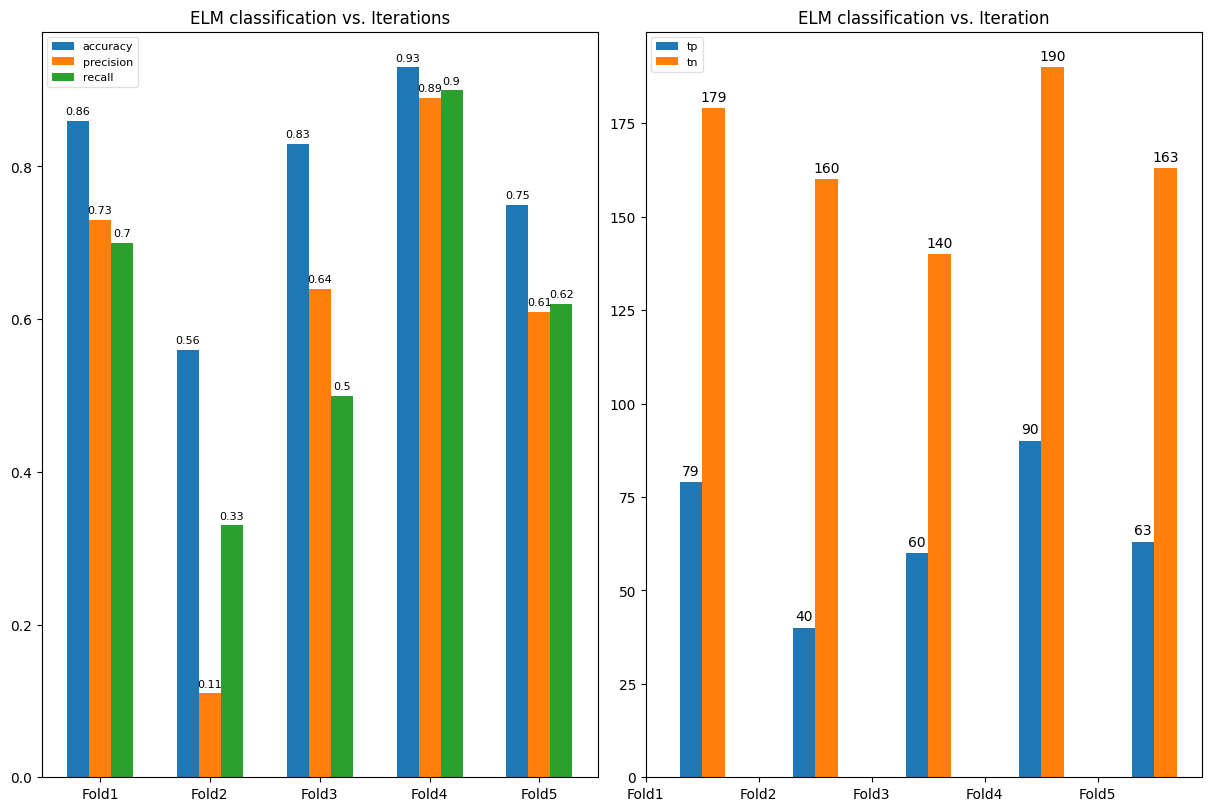

Fold 1: train shots=['30458', '30459', '30460', '30461', '30462', '30463', '30464', '30465'] test shots=['30454', '30457']
Fold 2: train shots=['30454', '30457', '30460', '30461', '30462', '30463', '30464', '30465'] test shots=['30458', '30459']
Fold 3: train shots=['30454', '30457', '30458', '30459', '30462', '30463', '30464', '30465'] test shots=['30460', '30461']
Fold 4: train shots=['30454', '30457', '30458', '30459', '30460', '30461', '30464', '30465'] test shots=['30462', '30463']
Fold 5: train shots=['30454', '30457', '30458', '30459', '30460', '30461', '30462', '30463'] test shots=['30464', '30465']
K-Fold Results: 
      tp    fp     tn    fn  accuracy  precision    recall        f1
0  79.0  21.0  179.0  21.0  0.860000   0.728867  0.700000  0.692666
1  40.0  80.0  160.0  80.0  0.555556   0.111111  0.333333  0.166667
2  60.0  20.0  140.0  20.0  0.833333   0.641026  0.500000  0.558214
3  90.0  10.0  190.0  10.0  0.933333   0.889339  0.900000  0.892301
4  63.0  37.0  163.0  37.0 

In [8]:
import pandas as pd
from utils.vis_utils import plot_bar_metrics

plot_bar_metrics(kfold_cls_results, xticks_label='Fold', figsize=(12, 8))

for k, data in enumerate(kfolds_data):
    print(f"Fold {k+1}: train shots={data[0]} test shots={data[1]}")

kfold_cls_results_df = pd.DataFrame(kfold_cls_results)
print("K-Fold Results: \n", kfold_cls_results_df)
sum_metrics = kfold_cls_results_df[["tp", "fp", "tn", "fn"]].sum()
mean_metrics = kfold_cls_results_df[["accuracy", "precision", "recall", "f1"]].mean()
avg_results = pd.DataFrame([sum_metrics.tolist() + mean_metrics.tolist()], 
                           columns=sum_metrics.index.tolist() + mean_metrics.index.tolist()
                          )
print("Average K-Fold Results: \n", avg_results)

## 3. Active Learning with Random Sampling
For active learning, we will use the same config `base.yaml`. We will incrementally add the training shots as we go through the AL iterations. Due to limited available labels, we will keep the same test shots for evaluation at each iteration. We can expect increasing accuracy over AL iterationss and higher accuracy than the normal and fold 5 of the K-fold training.  

In [9]:
import random
import numpy as np
from omegaconf import OmegaConf

from utils.misc import get_files_in_dir
from dataset.datasets import split_data
from trainer import Trainer

%load_ext autoreload
%autoreload 2
    
cfg = OmegaConf.create(OmegaConf.load("./configs/base.yaml"))

data = [f.split('.')[0] for f in get_files_in_dir(cfg.data.label_dir, file_end='.csv')]
train_shots, test_shots = split_data(data, train_split=cfg.data.train_split)
print(f"{data=}\n{train_shots=}\n{test_shots=}")

al_trainer = Trainer(cfg, exp_name='active_learning_with_random_sampling')

rng = np.random.default_rng(cfg.rng.seed)

# Active learning Options
INITIAL_LABELS = 2
N_CYCLES = 5
QUERY_BATCH_SIZE = 2

# Split labeled and unlabeled data
labeled_shots = []
unlabeled_shots = train_shots

al_cls_results = []
al_det_results = []
for i in range(N_CYCLES):
    
    print(f"\nActive Learning Cycle {i + 1}")
    
    # Random sample from unlabelled indices
    selected_shots = rng.choice(unlabeled_shots, 
                                size=QUERY_BATCH_SIZE, 
                                replace=False,
                                ).tolist()

    labeled_shots.extend(selected_shots)
    
    unlabeled_shots = [v for v in unlabeled_shots if v not in selected_shots]
    
    print(f"{labeled_shots=}\n{unlabeled_shots=}")

    al_trainer.train(train_sets=labeled_shots,
                     test_sets=test_shots,
                    )
    al_trainer.save_states(ckpt_name=f"model_states_cycle{i}")
    
    al_cls_results.append(al_trainer.cls_metric_logger.results)
    if cfg.net.detection:
        al_det_results.append(al_trainer.det_metric_logger.results)

    if not len(unlabeled_shots)>0:
        break
        

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
data=['30454', '30457', '30458', '30459', '30460', '30461', '30462', '30463', '30464', '30465']
train_shots=['30454', '30457', '30458', '30459', '30460', '30461', '30462', '30463']
test_shots=['30464', '30465']

Active Learning Cycle 1
labeled_shots=['30454', '30462']
unlabeled_shots=['30457', '30458', '30459', '30460', '30461', '30463']
Preparing train/test dataset ... 
Creating dataloaders ...
train samples: 2, train batch size: 16, train batches: 1

Verifying train dataloader ... 
{'dalpha': torch.Size([120, 1, 512]), 'dtime': torch.Size([120, 1, 512]), 'cls_labels': torch.Size([120]), 'elm_labels': torch.Size([120, 512])}
val samples: 0, val batch size: 16, val batches: 0

Verifying val dataloader ... 
test samples: 2, test batch size: 16, test batches: 1

Verifying test dataloader ... 


/home/ubuntu/miniconda3/envs/mlvis/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


{'dalpha': torch.Size([100, 1, 512]), 'dtime': torch.Size([100, 1, 512]), 'cls_labels': torch.Size([100]), 'elm_labels': torch.Size([100, 512])}
Training Started (device: cuda:0, rank: 0)
Epoch 0/1000


100%|██████████| 1/1 [00:00<00:00,  9.65it/s, , elm_cls_loss:    1.101, loss:    1.101]


Epoch 1/1000


100%|██████████| 1/1 [00:00<00:00, 19.64it/s, , elm_cls_loss:    1.101, loss:    1.101]


Epoch 2/1000


100%|██████████| 1/1 [00:00<00:00, 17.41it/s, , elm_cls_loss:    1.101, loss:    1.101]


Epoch 3/1000


100%|██████████| 1/1 [00:00<00:00, 21.19it/s, , elm_cls_loss:    1.101, loss:    1.101]


Epoch 4/1000


100%|██████████| 1/1 [00:00<00:00, 19.06it/s, , elm_cls_loss:    1.101, loss:    1.101]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 20.32it/s, test_loss: 1.118,                             test_cls_acc: 0.200]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   20 |   80 |  120 |   80 |      0.467 |       0.067 |    0.333 | 0.111 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  3.32it/s, test_loss: 1.118,                             test_cls_acc: 0.200]


Modelcheckpoint: test/loss improved from inf to 1.118136.
Saving model checkpoint ... 
Early Stopping: test/loss improved from inf to 1.118136.
Epoch 5/1000


100%|██████████| 1/1 [00:00<00:00, 18.97it/s, , elm_cls_loss:    1.100, loss:    1.100]


Epoch 6/1000


100%|██████████| 1/1 [00:00<00:00, 19.80it/s, , elm_cls_loss:    1.100, loss:    1.100]


Epoch 7/1000


100%|██████████| 1/1 [00:00<00:00, 17.65it/s, , elm_cls_loss:    1.101, loss:    1.101]


Epoch 8/1000


100%|██████████| 1/1 [00:00<00:00, 20.06it/s, , elm_cls_loss:    1.100, loss:    1.100]


Epoch 9/1000


100%|██████████| 1/1 [00:00<00:00, 19.12it/s, , elm_cls_loss:    1.100, loss:    1.100]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 24.41it/s, test_loss: 1.116,                             test_cls_acc: 0.200]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   20 |   80 |  120 |   80 |      0.467 |       0.067 |    0.333 | 0.111 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.17it/s, test_loss: 1.116,                             test_cls_acc: 0.200]


Modelcheckpoint: test/loss improved from 1.118136 to 1.115731.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.118136 to 1.115731.
Epoch 10/1000


100%|██████████| 1/1 [00:00<00:00, 18.97it/s, , elm_cls_loss:    1.100, loss:    1.100]


Epoch 11/1000


100%|██████████| 1/1 [00:00<00:00, 20.24it/s, , elm_cls_loss:    1.100, loss:    1.100]


Epoch 12/1000


100%|██████████| 1/1 [00:00<00:00, 19.86it/s, , elm_cls_loss:    1.100, loss:    1.100]


Epoch 13/1000


100%|██████████| 1/1 [00:00<00:00, 20.19it/s, , elm_cls_loss:    1.100, loss:    1.100]


Epoch 14/1000


100%|██████████| 1/1 [00:00<00:00, 19.74it/s, , elm_cls_loss:    1.100, loss:    1.100]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.73it/s, test_loss: 1.113,                             test_cls_acc: 0.200]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   20 |   80 |  120 |   80 |      0.467 |       0.067 |    0.333 | 0.111 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.72it/s, test_loss: 1.113,                             test_cls_acc: 0.200]


Modelcheckpoint: test/loss improved from 1.115731 to 1.112842.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.115731 to 1.112842.
Epoch 15/1000


100%|██████████| 1/1 [00:00<00:00, 19.08it/s, , elm_cls_loss:    1.100, loss:    1.100]


Epoch 16/1000


100%|██████████| 1/1 [00:00<00:00, 20.48it/s, , elm_cls_loss:    1.100, loss:    1.100]


Epoch 17/1000


100%|██████████| 1/1 [00:00<00:00, 19.75it/s, , elm_cls_loss:    1.099, loss:    1.099]


Epoch 18/1000


100%|██████████| 1/1 [00:00<00:00, 20.76it/s, , elm_cls_loss:    1.100, loss:    1.100]


Epoch 19/1000


100%|██████████| 1/1 [00:00<00:00, 20.29it/s, , elm_cls_loss:    1.099, loss:    1.099]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.40it/s, test_loss: 1.108,                             test_cls_acc: 0.200]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   20 |   80 |  120 |   80 |      0.467 |       0.067 |    0.333 | 0.111 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.75it/s, test_loss: 1.108,                             test_cls_acc: 0.200]


Modelcheckpoint: test/loss improved from 1.112842 to 1.107839.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.112842 to 1.107839.
Epoch 20/1000


100%|██████████| 1/1 [00:00<00:00, 19.34it/s, , elm_cls_loss:    1.099, loss:    1.099]


Epoch 21/1000


100%|██████████| 1/1 [00:00<00:00, 20.28it/s, , elm_cls_loss:    1.099, loss:    1.099]


Epoch 22/1000


100%|██████████| 1/1 [00:00<00:00, 17.32it/s, , elm_cls_loss:    1.098, loss:    1.098]


Epoch 23/1000


100%|██████████| 1/1 [00:00<00:00, 19.08it/s, , elm_cls_loss:    1.099, loss:    1.099]


Epoch 24/1000


100%|██████████| 1/1 [00:00<00:00, 20.74it/s, , elm_cls_loss:    1.098, loss:    1.098]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 24.24it/s, test_loss: 1.103,                             test_cls_acc: 0.200]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   20 |   80 |  120 |   80 |      0.467 |       0.067 |    0.333 | 0.111 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.94it/s, test_loss: 1.103,                             test_cls_acc: 0.200]


Modelcheckpoint: test/loss improved from 1.107839 to 1.103042.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.107839 to 1.103042.
Epoch 25/1000


100%|██████████| 1/1 [00:00<00:00, 18.81it/s, , elm_cls_loss:    1.099, loss:    1.099]


Epoch 26/1000


100%|██████████| 1/1 [00:00<00:00, 20.95it/s, , elm_cls_loss:    1.098, loss:    1.098]


Epoch 27/1000


100%|██████████| 1/1 [00:00<00:00, 21.76it/s, , elm_cls_loss:    1.098, loss:    1.098]


Epoch 28/1000


100%|██████████| 1/1 [00:00<00:00, 19.51it/s, , elm_cls_loss:    1.098, loss:    1.098]


Epoch 29/1000


100%|██████████| 1/1 [00:00<00:00, 20.80it/s, , elm_cls_loss:    1.100, loss:    1.100]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 24.69it/s, test_loss: 1.108,                             test_cls_acc: 0.200]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   20 |   80 |  120 |   80 |      0.467 |       0.067 |    0.333 | 0.111 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.45it/s, test_loss: 1.108,                             test_cls_acc: 0.200]


Modelcheckpoint: test/loss didn't improved from 1.103042.
Early Stopping: test/loss didn't improve from 1.103042. Counter will start after 10 warmup steps
Epoch 30/1000


100%|██████████| 1/1 [00:00<00:00, 19.89it/s, , elm_cls_loss:    1.099, loss:    1.099]


Epoch 31/1000


100%|██████████| 1/1 [00:00<00:00, 19.63it/s, , elm_cls_loss:    1.097, loss:    1.097]


Epoch 32/1000


100%|██████████| 1/1 [00:00<00:00, 19.79it/s, , elm_cls_loss:    1.100, loss:    1.100]


Epoch 33/1000


100%|██████████| 1/1 [00:00<00:00, 16.02it/s, , elm_cls_loss:    1.102, loss:    1.102]


Epoch 34/1000


100%|██████████| 1/1 [00:00<00:00, 21.11it/s, , elm_cls_loss:    1.096, loss:    1.096]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 24.91it/s, test_loss: 1.099,                             test_cls_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  7.82it/s, test_loss: 1.099,                             test_cls_acc: 0.400]


Modelcheckpoint: test/loss improved from 1.103042 to 1.098770.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.103042 to 1.098770.
Epoch 35/1000


100%|██████████| 1/1 [00:00<00:00, 18.78it/s, , elm_cls_loss:    1.098, loss:    1.098]


Epoch 36/1000


100%|██████████| 1/1 [00:00<00:00, 20.28it/s, , elm_cls_loss:    1.099, loss:    1.099]


Epoch 37/1000


100%|██████████| 1/1 [00:00<00:00, 19.94it/s, , elm_cls_loss:    1.099, loss:    1.099]


Epoch 38/1000


100%|██████████| 1/1 [00:00<00:00, 19.98it/s, , elm_cls_loss:    1.098, loss:    1.098]


Epoch 39/1000


100%|██████████| 1/1 [00:00<00:00, 17.62it/s, , elm_cls_loss:    1.099, loss:    1.099]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 24.77it/s, test_loss: 1.101,                             test_cls_acc: 0.200]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   20 |   80 |  120 |   80 |      0.467 |       0.067 |    0.333 | 0.111 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  8.09it/s, test_loss: 1.101,                             test_cls_acc: 0.200]


Modelcheckpoint: test/loss didn't improved from 1.098770.
Early Stopping: test/loss didn't improve from 1.098770. Counter will start after 10 warmup steps
Epoch 40/1000


100%|██████████| 1/1 [00:00<00:00, 19.22it/s, , elm_cls_loss:    1.099, loss:    1.099]


Epoch 41/1000


100%|██████████| 1/1 [00:00<00:00, 20.21it/s, , elm_cls_loss:    1.099, loss:    1.099]


Epoch 42/1000


100%|██████████| 1/1 [00:00<00:00, 20.60it/s, , elm_cls_loss:    1.099, loss:    1.099]


Epoch 43/1000


100%|██████████| 1/1 [00:00<00:00, 20.95it/s, , elm_cls_loss:    1.098, loss:    1.098]


Epoch 44/1000


100%|██████████| 1/1 [00:00<00:00, 20.04it/s, , elm_cls_loss:    1.099, loss:    1.099]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 24.09it/s, test_loss: 1.103,                             test_cls_acc: 0.200]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   20 |   80 |  120 |   80 |      0.467 |       0.067 |    0.333 | 0.111 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  8.13it/s, test_loss: 1.103,                             test_cls_acc: 0.200]


Modelcheckpoint: test/loss didn't improved from 1.098770.
Early Stopping: test/loss didn't improve from 1.098770. Counter will start after 10 warmup steps
Epoch 45/1000


100%|██████████| 1/1 [00:00<00:00, 19.64it/s, , elm_cls_loss:    1.099, loss:    1.099]


Epoch 46/1000


100%|██████████| 1/1 [00:00<00:00, 19.25it/s, , elm_cls_loss:    1.099, loss:    1.099]


Epoch 47/1000


100%|██████████| 1/1 [00:00<00:00, 20.63it/s, , elm_cls_loss:    1.098, loss:    1.098]


Epoch 48/1000


100%|██████████| 1/1 [00:00<00:00, 20.16it/s, , elm_cls_loss:    1.099, loss:    1.099]


Epoch 49/1000


100%|██████████| 1/1 [00:00<00:00, 17.40it/s, , elm_cls_loss:    1.099, loss:    1.099]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 24.65it/s, test_loss: 1.103,                             test_cls_acc: 0.200]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   20 |   80 |  120 |   80 |      0.467 |       0.067 |    0.333 | 0.111 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  8.14it/s, test_loss: 1.103,                             test_cls_acc: 0.200]


Modelcheckpoint: test/loss didn't improved from 1.098770.
Early Stopping: test/loss didn't improve from 1.098770. Early stopping counter: 1/10
Epoch 50/1000


100%|██████████| 1/1 [00:00<00:00, 19.32it/s, , elm_cls_loss:    1.099, loss:    1.099]


Epoch 51/1000


100%|██████████| 1/1 [00:00<00:00, 20.30it/s, , elm_cls_loss:    1.099, loss:    1.099]


Epoch 52/1000


100%|██████████| 1/1 [00:00<00:00, 19.74it/s, , elm_cls_loss:    1.099, loss:    1.099]


Epoch 53/1000


100%|██████████| 1/1 [00:00<00:00, 21.01it/s, , elm_cls_loss:    1.100, loss:    1.100]


Epoch 54/1000


100%|██████████| 1/1 [00:00<00:00, 20.68it/s, , elm_cls_loss:    1.098, loss:    1.098]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 24.88it/s, test_loss: 1.103,                             test_cls_acc: 0.200]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   20 |   80 |  120 |   80 |      0.467 |       0.067 |    0.333 | 0.111 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.87it/s, test_loss: 1.103,                             test_cls_acc: 0.200]


Modelcheckpoint: test/loss didn't improved from 1.098770.
Early Stopping: test/loss didn't improve from 1.098770. Early stopping counter: 2/10
Epoch 55/1000


100%|██████████| 1/1 [00:00<00:00, 19.53it/s, , elm_cls_loss:    1.099, loss:    1.099]


Epoch 56/1000


100%|██████████| 1/1 [00:00<00:00, 18.21it/s, , elm_cls_loss:    1.098, loss:    1.098]


Epoch 57/1000


100%|██████████| 1/1 [00:00<00:00, 20.60it/s, , elm_cls_loss:    1.098, loss:    1.098]


Epoch 58/1000


100%|██████████| 1/1 [00:00<00:00, 20.18it/s, , elm_cls_loss:    1.099, loss:    1.099]


Epoch 59/1000


100%|██████████| 1/1 [00:00<00:00, 18.79it/s, , elm_cls_loss:    1.099, loss:    1.099]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.90it/s, test_loss: 1.103,                             test_cls_acc: 0.200]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   20 |   80 |  120 |   80 |      0.467 |       0.067 |    0.333 | 0.111 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.66it/s, test_loss: 1.103,                             test_cls_acc: 0.200]


Modelcheckpoint: test/loss didn't improved from 1.098770.
Early Stopping: test/loss didn't improve from 1.098770. Early stopping counter: 3/10
Epoch 60/1000


100%|██████████| 1/1 [00:00<00:00, 18.77it/s, , elm_cls_loss:    1.099, loss:    1.099]


Epoch 61/1000


100%|██████████| 1/1 [00:00<00:00, 19.56it/s, , elm_cls_loss:    1.099, loss:    1.099]


Epoch 62/1000


100%|██████████| 1/1 [00:00<00:00, 19.72it/s, , elm_cls_loss:    1.099, loss:    1.099]


Epoch 63/1000


100%|██████████| 1/1 [00:00<00:00, 20.34it/s, , elm_cls_loss:    1.099, loss:    1.099]


Epoch 64/1000


100%|██████████| 1/1 [00:00<00:00, 18.69it/s, , elm_cls_loss:    1.099, loss:    1.099]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.60it/s, test_loss: 1.102,                             test_cls_acc: 0.200]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   20 |   80 |  120 |   80 |      0.467 |       0.067 |    0.333 | 0.111 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.40it/s, test_loss: 1.102,                             test_cls_acc: 0.200]


Modelcheckpoint: test/loss didn't improved from 1.098770.
Early Stopping: test/loss didn't improve from 1.098770. Early stopping counter: 4/10
Epoch 65/1000


100%|██████████| 1/1 [00:00<00:00, 19.19it/s, , elm_cls_loss:    1.100, loss:    1.100]


Epoch 66/1000


100%|██████████| 1/1 [00:00<00:00, 18.93it/s, , elm_cls_loss:    1.098, loss:    1.098]


Epoch 67/1000


100%|██████████| 1/1 [00:00<00:00, 19.41it/s, , elm_cls_loss:    1.099, loss:    1.099]


Epoch 68/1000


100%|██████████| 1/1 [00:00<00:00, 19.66it/s, , elm_cls_loss:    1.099, loss:    1.099]


Epoch 69/1000


100%|██████████| 1/1 [00:00<00:00, 20.01it/s, , elm_cls_loss:    1.099, loss:    1.099]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 24.06it/s, test_loss: 1.101,                             test_cls_acc: 0.200]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   20 |   80 |  120 |   80 |      0.467 |       0.067 |    0.333 | 0.111 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.58it/s, test_loss: 1.101,                             test_cls_acc: 0.200]


Modelcheckpoint: test/loss didn't improved from 1.098770.
Early Stopping: test/loss didn't improve from 1.098770. Early stopping counter: 5/10
Epoch 70/1000


100%|██████████| 1/1 [00:00<00:00, 19.22it/s, , elm_cls_loss:    1.099, loss:    1.099]


Epoch 71/1000


100%|██████████| 1/1 [00:00<00:00, 17.20it/s, , elm_cls_loss:    1.099, loss:    1.099]


Epoch 72/1000


100%|██████████| 1/1 [00:00<00:00, 18.88it/s, , elm_cls_loss:    1.099, loss:    1.099]


Epoch 73/1000


100%|██████████| 1/1 [00:00<00:00, 19.95it/s, , elm_cls_loss:    1.098, loss:    1.098]


Epoch 74/1000


100%|██████████| 1/1 [00:00<00:00, 19.65it/s, , elm_cls_loss:    1.100, loss:    1.100]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 24.06it/s, test_loss: 1.102,                             test_cls_acc: 0.200]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   20 |   80 |  120 |   80 |      0.467 |       0.067 |    0.333 | 0.111 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.74it/s, test_loss: 1.102,                             test_cls_acc: 0.200]


Modelcheckpoint: test/loss didn't improved from 1.098770.
Early Stopping: test/loss didn't improve from 1.098770. Early stopping counter: 6/10
Epoch 75/1000


100%|██████████| 1/1 [00:00<00:00, 19.03it/s, , elm_cls_loss:    1.098, loss:    1.098]


Epoch 76/1000


100%|██████████| 1/1 [00:00<00:00, 20.04it/s, , elm_cls_loss:    1.098, loss:    1.098]


Epoch 77/1000


100%|██████████| 1/1 [00:00<00:00, 18.75it/s, , elm_cls_loss:    1.098, loss:    1.098]


Epoch 78/1000


100%|██████████| 1/1 [00:00<00:00, 19.46it/s, , elm_cls_loss:    1.099, loss:    1.099]


Epoch 79/1000


100%|██████████| 1/1 [00:00<00:00, 19.23it/s, , elm_cls_loss:    1.099, loss:    1.099]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 24.52it/s, test_loss: 1.101,                             test_cls_acc: 0.200]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   20 |   80 |  120 |   80 |      0.467 |       0.067 |    0.333 | 0.111 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.77it/s, test_loss: 1.101,                             test_cls_acc: 0.200]


Modelcheckpoint: test/loss didn't improved from 1.098770.
Early Stopping: test/loss didn't improve from 1.098770. Early stopping counter: 7/10
Epoch 80/1000


100%|██████████| 1/1 [00:00<00:00, 18.56it/s, , elm_cls_loss:    1.099, loss:    1.099]


Epoch 81/1000


100%|██████████| 1/1 [00:00<00:00, 19.72it/s, , elm_cls_loss:    1.098, loss:    1.098]


Epoch 82/1000


100%|██████████| 1/1 [00:00<00:00, 19.76it/s, , elm_cls_loss:    1.099, loss:    1.099]


Epoch 83/1000


100%|██████████| 1/1 [00:00<00:00, 19.01it/s, , elm_cls_loss:    1.099, loss:    1.099]


Epoch 84/1000


100%|██████████| 1/1 [00:00<00:00, 19.74it/s, , elm_cls_loss:    1.099, loss:    1.099]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 24.60it/s, test_loss: 1.101,                             test_cls_acc: 0.200]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   20 |   80 |  120 |   80 |      0.467 |       0.067 |    0.333 | 0.111 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.75it/s, test_loss: 1.101,                             test_cls_acc: 0.200]


Modelcheckpoint: test/loss didn't improved from 1.098770.
Early Stopping: test/loss didn't improve from 1.098770. Early stopping counter: 8/10
Epoch 85/1000


100%|██████████| 1/1 [00:00<00:00, 18.93it/s, , elm_cls_loss:    1.098, loss:    1.098]


Epoch 86/1000


100%|██████████| 1/1 [00:00<00:00, 18.92it/s, , elm_cls_loss:    1.099, loss:    1.099]


Epoch 87/1000


100%|██████████| 1/1 [00:00<00:00, 19.49it/s, , elm_cls_loss:    1.099, loss:    1.099]


Epoch 88/1000


100%|██████████| 1/1 [00:00<00:00, 19.62it/s, , elm_cls_loss:    1.099, loss:    1.099]


Epoch 89/1000


100%|██████████| 1/1 [00:00<00:00, 19.33it/s, , elm_cls_loss:    1.099, loss:    1.099]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 24.34it/s, test_loss: 1.101,                             test_cls_acc: 0.200]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   20 |   80 |  120 |   80 |      0.467 |       0.067 |    0.333 | 0.111 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.42it/s, test_loss: 1.101,                             test_cls_acc: 0.200]


Modelcheckpoint: test/loss didn't improved from 1.098770.
Early Stopping: test/loss didn't improve from 1.098770. Early stopping counter: 9/10
Epoch 90/1000


100%|██████████| 1/1 [00:00<00:00, 18.50it/s, , elm_cls_loss:    1.099, loss:    1.099]


Epoch 91/1000


100%|██████████| 1/1 [00:00<00:00, 19.77it/s, , elm_cls_loss:    1.098, loss:    1.098]


Epoch 92/1000


100%|██████████| 1/1 [00:00<00:00, 19.62it/s, , elm_cls_loss:    1.099, loss:    1.099]


Epoch 93/1000


100%|██████████| 1/1 [00:00<00:00, 19.04it/s, , elm_cls_loss:    1.099, loss:    1.099]


Epoch 94/1000


100%|██████████| 1/1 [00:00<00:00, 19.61it/s, , elm_cls_loss:    1.099, loss:    1.099]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 25.09it/s, test_loss: 1.101,                             test_cls_acc: 0.200]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   20 |   80 |  120 |   80 |      0.467 |       0.067 |    0.333 | 0.111 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.90it/s, test_loss: 1.101,                             test_cls_acc: 0.200]


Modelcheckpoint: test/loss didn't improved from 1.098770.
Early Stopping: test/loss didn't improve from 1.098770. Early stopping counter: 10/10
Early stopping at epoch 94
DONE in 9.397144556045532!
Best ELM Classfication Results (epoch 34) {'tp': 40.0, 'fp': 60.0, 'tn': 140.0, 'fn': 60.0, 'accuracy': 0.6, 'precision': 0.13333333333333333, 'recall': 0.3333333333333333, 'f1': 0.1904761904761905}

Active Learning Cycle 2
labeled_shots=['30454', '30462', '30459', '30463']
unlabeled_shots=['30457', '30458', '30460', '30461']
Preparing train/test dataset ... 
Creating dataloaders ...
train samples: 4, train batch size: 16, train batches: 1

Verifying train dataloader ... 
{'dalpha': torch.Size([220, 1, 512]), 'dtime': torch.Size([220, 1, 512]), 'cls_labels': torch.Size([220]), 'elm_labels': torch.Size([220, 512])}
val samples: 0, val batch size: 16, val batches: 0

Verifying val dataloader ... 
test samples: 2, test batch size: 16, test batches: 1

Verifying test dataloader ... 


/home/ubuntu/miniconda3/envs/mlvis/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


{'dalpha': torch.Size([100, 1, 512]), 'dtime': torch.Size([100, 1, 512]), 'cls_labels': torch.Size([100]), 'elm_labels': torch.Size([100, 512])}
Training Started (device: cuda:0, rank: 0)
Epoch 0/1000


100%|██████████| 1/1 [00:00<00:00,  6.24it/s, , elm_cls_loss:    1.100, loss:    1.100]


Epoch 1/1000


100%|██████████| 1/1 [00:00<00:00, 10.37it/s, , elm_cls_loss:    1.098, loss:    1.098]


Epoch 2/1000


100%|██████████| 1/1 [00:00<00:00, 11.88it/s, , elm_cls_loss:    1.096, loss:    1.096]


Epoch 3/1000


100%|██████████| 1/1 [00:00<00:00, 10.89it/s, , elm_cls_loss:    1.096, loss:    1.096]


Epoch 4/1000


100%|██████████| 1/1 [00:00<00:00, 12.27it/s, , elm_cls_loss:    1.095, loss:    1.095]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 19.40it/s, test_loss: 1.080,                             test_cls_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  3.82it/s, test_loss: 1.080,                             test_cls_acc: 0.400]

Modelcheckpoint: test/loss improved from inf to 1.079664.
Saving model checkpoint ... 


Early Stopping: test/loss improved from inf to 1.079664.
Epoch 5/1000


100%|██████████| 1/1 [00:00<00:00, 10.74it/s, , elm_cls_loss:    1.092, loss:    1.092]


Epoch 6/1000


100%|██████████| 1/1 [00:00<00:00, 11.29it/s, , elm_cls_loss:    1.095, loss:    1.095]


Epoch 7/1000


100%|██████████| 1/1 [00:00<00:00, 12.11it/s, , elm_cls_loss:    1.096, loss:    1.096]


Epoch 8/1000


100%|██████████| 1/1 [00:00<00:00, 11.83it/s, , elm_cls_loss:    1.090, loss:    1.090]


Epoch 9/1000


100%|██████████| 1/1 [00:00<00:00, 12.09it/s, , elm_cls_loss:    1.094, loss:    1.094]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 24.24it/s, test_loss: 1.079,                             test_cls_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  7.73it/s, test_loss: 1.079,                             test_cls_acc: 0.400]


Modelcheckpoint: test/loss improved from 1.079664 to 1.079423.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.079664 to 1.079423.
Epoch 10/1000


100%|██████████| 1/1 [00:00<00:00, 10.87it/s, , elm_cls_loss:    1.092, loss:    1.092]


Epoch 11/1000


100%|██████████| 1/1 [00:00<00:00, 11.96it/s, , elm_cls_loss:    1.092, loss:    1.092]


Epoch 12/1000


100%|██████████| 1/1 [00:00<00:00, 12.13it/s, , elm_cls_loss:    1.091, loss:    1.091]


Epoch 13/1000


100%|██████████| 1/1 [00:00<00:00, 12.43it/s, , elm_cls_loss:    1.092, loss:    1.092]


Epoch 14/1000


100%|██████████| 1/1 [00:00<00:00, 11.76it/s, , elm_cls_loss:    1.095, loss:    1.095]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 22.94it/s, test_loss: 1.076,                             test_cls_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  8.07it/s, test_loss: 1.076,                             test_cls_acc: 0.400]


Modelcheckpoint: test/loss improved from 1.079423 to 1.076179.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.079423 to 1.076179.
Epoch 15/1000


100%|██████████| 1/1 [00:00<00:00, 11.21it/s, , elm_cls_loss:    1.093, loss:    1.093]


Epoch 16/1000


100%|██████████| 1/1 [00:00<00:00, 11.95it/s, , elm_cls_loss:    1.091, loss:    1.091]


Epoch 17/1000


100%|██████████| 1/1 [00:00<00:00, 11.64it/s, , elm_cls_loss:    1.092, loss:    1.092]


Epoch 18/1000


100%|██████████| 1/1 [00:00<00:00, 12.49it/s, , elm_cls_loss:    1.091, loss:    1.091]


Epoch 19/1000


100%|██████████| 1/1 [00:00<00:00, 12.23it/s, , elm_cls_loss:    1.088, loss:    1.088]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 19.27it/s, test_loss: 1.067,                             test_cls_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  7.00it/s, test_loss: 1.067,                             test_cls_acc: 0.400]


Modelcheckpoint: test/loss improved from 1.076179 to 1.066833.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.076179 to 1.066833.
Epoch 20/1000


100%|██████████| 1/1 [00:00<00:00, 11.40it/s, , elm_cls_loss:    1.090, loss:    1.090]


Epoch 21/1000


100%|██████████| 1/1 [00:00<00:00, 12.12it/s, , elm_cls_loss:    1.091, loss:    1.091]


Epoch 22/1000


100%|██████████| 1/1 [00:00<00:00, 11.75it/s, , elm_cls_loss:    1.092, loss:    1.092]


Epoch 23/1000


100%|██████████| 1/1 [00:00<00:00, 12.03it/s, , elm_cls_loss:    1.093, loss:    1.093]


Epoch 24/1000


100%|██████████| 1/1 [00:00<00:00, 11.68it/s, , elm_cls_loss:    1.090, loss:    1.090]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.20it/s, test_loss: 1.076,                             test_cls_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  7.93it/s, test_loss: 1.076,                             test_cls_acc: 0.400]


Modelcheckpoint: test/loss didn't improved from 1.066833.
Early Stopping: test/loss didn't improve from 1.066833. Counter will start after 10 warmup steps
Epoch 25/1000


100%|██████████| 1/1 [00:00<00:00, 11.62it/s, , elm_cls_loss:    1.089, loss:    1.089]


Epoch 26/1000


100%|██████████| 1/1 [00:00<00:00, 11.82it/s, , elm_cls_loss:    1.091, loss:    1.091]


Epoch 27/1000


100%|██████████| 1/1 [00:00<00:00, 11.93it/s, , elm_cls_loss:    1.089, loss:    1.089]


Epoch 28/1000


100%|██████████| 1/1 [00:00<00:00, 11.30it/s, , elm_cls_loss:    1.091, loss:    1.091]


Epoch 29/1000


100%|██████████| 1/1 [00:00<00:00, 12.12it/s, , elm_cls_loss:    1.090, loss:    1.090]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 21.58it/s, test_loss: 1.062,                             test_cls_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  7.37it/s, test_loss: 1.062,                             test_cls_acc: 0.400]


Modelcheckpoint: test/loss improved from 1.066833 to 1.061637.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.066833 to 1.061637.
Epoch 30/1000


100%|██████████| 1/1 [00:00<00:00, 10.27it/s, , elm_cls_loss:    1.089, loss:    1.089]


Epoch 31/1000


100%|██████████| 1/1 [00:00<00:00, 12.16it/s, , elm_cls_loss:    1.094, loss:    1.094]


Epoch 32/1000


100%|██████████| 1/1 [00:00<00:00, 11.67it/s, , elm_cls_loss:    1.090, loss:    1.090]


Epoch 33/1000


100%|██████████| 1/1 [00:00<00:00, 12.22it/s, , elm_cls_loss:    1.091, loss:    1.091]


Epoch 34/1000


100%|██████████| 1/1 [00:00<00:00, 12.13it/s, , elm_cls_loss:    1.089, loss:    1.089]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.90it/s, test_loss: 1.077,                             test_cls_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  7.89it/s, test_loss: 1.077,                             test_cls_acc: 0.400]


Modelcheckpoint: test/loss didn't improved from 1.061637.
Early Stopping: test/loss didn't improve from 1.061637. Counter will start after 10 warmup steps
Epoch 35/1000


100%|██████████| 1/1 [00:00<00:00, 11.65it/s, , elm_cls_loss:    1.093, loss:    1.093]


Epoch 36/1000


100%|██████████| 1/1 [00:00<00:00, 10.95it/s, , elm_cls_loss:    1.090, loss:    1.090]


Epoch 37/1000


100%|██████████| 1/1 [00:00<00:00, 11.86it/s, , elm_cls_loss:    1.090, loss:    1.090]


Epoch 38/1000


100%|██████████| 1/1 [00:00<00:00, 12.06it/s, , elm_cls_loss:    1.093, loss:    1.093]


Epoch 39/1000


100%|██████████| 1/1 [00:00<00:00, 11.84it/s, , elm_cls_loss:    1.087, loss:    1.087]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.10it/s, test_loss: 1.060,                             test_cls_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  7.90it/s, test_loss: 1.060,                             test_cls_acc: 0.400]


Modelcheckpoint: test/loss improved from 1.061637 to 1.059774.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.061637 to 1.059774.
Epoch 40/1000


100%|██████████| 1/1 [00:00<00:00, 11.46it/s, , elm_cls_loss:    1.091, loss:    1.091]


Epoch 41/1000


100%|██████████| 1/1 [00:00<00:00, 11.95it/s, , elm_cls_loss:    1.090, loss:    1.090]


Epoch 42/1000


100%|██████████| 1/1 [00:00<00:00, 12.12it/s, , elm_cls_loss:    1.084, loss:    1.084]


Epoch 43/1000


100%|██████████| 1/1 [00:00<00:00, 12.29it/s, , elm_cls_loss:    1.085, loss:    1.085]


Epoch 44/1000


100%|██████████| 1/1 [00:00<00:00, 12.20it/s, , elm_cls_loss:    1.087, loss:    1.087]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.48it/s, test_loss: 1.054,                             test_cls_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:01<00:00,  1.28s/it, test_loss: 1.054,                             test_cls_acc: 0.400]


Modelcheckpoint: test/loss improved from 1.059774 to 1.054285.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.059774 to 1.054285.
Epoch 45/1000


100%|██████████| 1/1 [00:00<00:00, 11.83it/s, , elm_cls_loss:    1.083, loss:    1.083]


Epoch 46/1000


100%|██████████| 1/1 [00:00<00:00, 11.96it/s, , elm_cls_loss:    1.084, loss:    1.084]


Epoch 47/1000


100%|██████████| 1/1 [00:00<00:00, 12.27it/s, , elm_cls_loss:    1.086, loss:    1.086]


Epoch 48/1000


100%|██████████| 1/1 [00:00<00:00, 12.20it/s, , elm_cls_loss:    1.080, loss:    1.080]


Epoch 49/1000


100%|██████████| 1/1 [00:00<00:00, 12.35it/s, , elm_cls_loss:    1.082, loss:    1.082]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.21it/s, test_loss: 1.039,                             test_cls_acc: 0.420]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   42 |   58 |  142 |   58 |      0.613 |        0.36 |     0.35 | 0.226 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.77it/s, test_loss: 1.039,                             test_cls_acc: 0.420]


Modelcheckpoint: test/loss improved from 1.054285 to 1.038565.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.054285 to 1.038565.
Epoch 50/1000


100%|██████████| 1/1 [00:00<00:00, 12.04it/s, , elm_cls_loss:    1.079, loss:    1.079]


Epoch 51/1000


100%|██████████| 1/1 [00:00<00:00, 11.93it/s, , elm_cls_loss:    1.072, loss:    1.072]


Epoch 52/1000


100%|██████████| 1/1 [00:00<00:00, 11.14it/s, , elm_cls_loss:    1.077, loss:    1.077]


Epoch 53/1000


100%|██████████| 1/1 [00:00<00:00, 11.93it/s, , elm_cls_loss:    1.070, loss:    1.070]


Epoch 54/1000


100%|██████████| 1/1 [00:00<00:00, 11.96it/s, , elm_cls_loss:    1.066, loss:    1.066]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.24it/s, test_loss: 1.024,                             test_cls_acc: 0.410]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   41 |   59 |  141 |   59 |      0.607 |       0.468 |    0.342 | 0.208 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.20it/s, test_loss: 1.024,                             test_cls_acc: 0.410]


Modelcheckpoint: test/loss improved from 1.038565 to 1.024317.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.038565 to 1.024317.
Epoch 55/1000


100%|██████████| 1/1 [00:00<00:00, 11.36it/s, , elm_cls_loss:    1.060, loss:    1.060]


Epoch 56/1000


100%|██████████| 1/1 [00:00<00:00, 11.88it/s, , elm_cls_loss:    1.052, loss:    1.052]


Epoch 57/1000


100%|██████████| 1/1 [00:00<00:00, 12.20it/s, , elm_cls_loss:    1.071, loss:    1.071]


Epoch 58/1000


100%|██████████| 1/1 [00:00<00:00, 12.44it/s, , elm_cls_loss:    1.048, loss:    1.048]


Epoch 59/1000


100%|██████████| 1/1 [00:00<00:00, 12.30it/s, , elm_cls_loss:    1.045, loss:    1.045]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.88it/s, test_loss: 0.998,                             test_cls_acc: 0.430]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   43 |   57 |  143 |   57 |       0.62 |       0.471 |    0.358 | 0.241 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.43it/s, test_loss: 0.998,                             test_cls_acc: 0.430]


Modelcheckpoint: test/loss improved from 1.024317 to 0.998324.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.024317 to 0.998324.
Epoch 60/1000


100%|██████████| 1/1 [00:00<00:00, 11.34it/s, , elm_cls_loss:    1.033, loss:    1.033]


Epoch 61/1000


100%|██████████| 1/1 [00:00<00:00, 12.04it/s, , elm_cls_loss:    1.049, loss:    1.049]


Epoch 62/1000


100%|██████████| 1/1 [00:00<00:00, 11.90it/s, , elm_cls_loss:    1.046, loss:    1.046]


Epoch 63/1000


100%|██████████| 1/1 [00:00<00:00, 11.59it/s, , elm_cls_loss:    1.030, loss:    1.030]


Epoch 64/1000


100%|██████████| 1/1 [00:00<00:00, 12.02it/s, , elm_cls_loss:    1.019, loss:    1.019]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.14it/s, test_loss: 0.977,                             test_cls_acc: 0.440]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   44 |   56 |  144 |   56 |      0.627 |        0.35 |    0.367 | 0.266 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.36it/s, test_loss: 0.977,                             test_cls_acc: 0.440]


Modelcheckpoint: test/loss improved from 0.998324 to 0.977300.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.998324 to 0.977300.
Epoch 65/1000


100%|██████████| 1/1 [00:00<00:00, 11.44it/s, , elm_cls_loss:    1.026, loss:    1.026]


Epoch 66/1000


100%|██████████| 1/1 [00:00<00:00, 11.99it/s, , elm_cls_loss:    1.005, loss:    1.005]


Epoch 67/1000


100%|██████████| 1/1 [00:00<00:00, 12.31it/s, , elm_cls_loss:    0.964, loss:    0.964]


Epoch 68/1000


100%|██████████| 1/1 [00:00<00:00, 12.15it/s, , elm_cls_loss:    0.954, loss:    0.954]


Epoch 69/1000


100%|██████████| 1/1 [00:00<00:00, 12.29it/s, , elm_cls_loss:    0.922, loss:    0.922]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.70it/s, test_loss: 0.814,                             test_cls_acc: 0.690]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   69 |   31 |  169 |   31 |      0.793 |       0.466 |    0.575 | 0.512 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.38it/s, test_loss: 0.814,                             test_cls_acc: 0.690]


Modelcheckpoint: test/loss improved from 0.977300 to 0.814280.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.977300 to 0.814280.
Epoch 70/1000


100%|██████████| 1/1 [00:00<00:00, 11.95it/s, , elm_cls_loss:    0.885, loss:    0.885]


Epoch 71/1000


100%|██████████| 1/1 [00:00<00:00, 11.77it/s, , elm_cls_loss:    0.921, loss:    0.921]


Epoch 72/1000


100%|██████████| 1/1 [00:00<00:00, 11.55it/s, , elm_cls_loss:    0.912, loss:    0.912]


Epoch 73/1000


100%|██████████| 1/1 [00:00<00:00, 12.50it/s, , elm_cls_loss:    0.876, loss:    0.876]


Epoch 74/1000


100%|██████████| 1/1 [00:00<00:00, 11.68it/s, , elm_cls_loss:    0.959, loss:    0.959]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.22it/s, test_loss: 0.869,                             test_cls_acc: 0.650]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   65 |   35 |  165 |   35 |      0.767 |       0.433 |    0.542 | 0.481 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.13it/s, test_loss: 0.869,                             test_cls_acc: 0.650]


Modelcheckpoint: test/loss didn't improved from 0.814280.
Early Stopping: test/loss didn't improve from 0.814280. Early stopping counter: 1/10
Epoch 75/1000


100%|██████████| 1/1 [00:00<00:00, 11.52it/s, , elm_cls_loss:    0.841, loss:    0.841]


Epoch 76/1000


100%|██████████| 1/1 [00:00<00:00, 11.64it/s, , elm_cls_loss:    0.904, loss:    0.904]


Epoch 77/1000


100%|██████████| 1/1 [00:00<00:00, 12.10it/s, , elm_cls_loss:    0.918, loss:    0.918]


Epoch 78/1000


100%|██████████| 1/1 [00:00<00:00, 11.87it/s, , elm_cls_loss:    0.871, loss:    0.871]


Epoch 79/1000


100%|██████████| 1/1 [00:00<00:00, 11.89it/s, , elm_cls_loss:    0.815, loss:    0.815]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 24.44it/s, test_loss: 0.739,                             test_cls_acc: 0.700]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   70 |   30 |  170 |   30 |        0.8 |       0.466 |    0.583 | 0.517 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.21it/s, test_loss: 0.739,                             test_cls_acc: 0.700]


Modelcheckpoint: test/loss improved from 0.814280 to 0.739478.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.814280 to 0.739478.
Epoch 80/1000


100%|██████████| 1/1 [00:00<00:00, 11.11it/s, , elm_cls_loss:    0.800, loss:    0.800]


Epoch 81/1000


100%|██████████| 1/1 [00:00<00:00, 11.84it/s, , elm_cls_loss:    0.893, loss:    0.893]


Epoch 82/1000


100%|██████████| 1/1 [00:00<00:00, 12.15it/s, , elm_cls_loss:    0.840, loss:    0.840]


Epoch 83/1000


100%|██████████| 1/1 [00:00<00:00, 12.26it/s, , elm_cls_loss:    0.724, loss:    0.724]


Epoch 84/1000


100%|██████████| 1/1 [00:00<00:00, 12.11it/s, , elm_cls_loss:    0.750, loss:    0.750]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 24.46it/s, test_loss: 0.802,                             test_cls_acc: 0.700]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   70 |   30 |  170 |   30 |        0.8 |       0.478 |    0.583 | 0.523 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.09it/s, test_loss: 0.802,                             test_cls_acc: 0.700]


Modelcheckpoint: test/loss didn't improved from 0.739478.
Early Stopping: test/loss didn't improve from 0.739478. Early stopping counter: 1/10
Epoch 85/1000


100%|██████████| 1/1 [00:00<00:00, 12.43it/s, , elm_cls_loss:    0.972, loss:    0.972]


Epoch 86/1000


100%|██████████| 1/1 [00:00<00:00, 12.14it/s, , elm_cls_loss:    0.819, loss:    0.819]


Epoch 87/1000


100%|██████████| 1/1 [00:00<00:00, 11.89it/s, , elm_cls_loss:    0.779, loss:    0.779]


Epoch 88/1000


100%|██████████| 1/1 [00:00<00:00, 12.26it/s, , elm_cls_loss:    0.812, loss:    0.812]


Epoch 89/1000


100%|██████████| 1/1 [00:00<00:00, 12.41it/s, , elm_cls_loss:    0.779, loss:    0.779]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.72it/s, test_loss: 0.641,                             test_cls_acc: 0.770]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   77 |   23 |  177 |   23 |      0.847 |       0.723 |    0.708 | 0.712 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.48it/s, test_loss: 0.641,                             test_cls_acc: 0.770]


Modelcheckpoint: test/loss improved from 0.739478 to 0.641284.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.739478 to 0.641284.
Epoch 90/1000


100%|██████████| 1/1 [00:00<00:00, 11.96it/s, , elm_cls_loss:    0.848, loss:    0.848]


Epoch 91/1000


100%|██████████| 1/1 [00:00<00:00, 12.40it/s, , elm_cls_loss:    0.804, loss:    0.804]


Epoch 92/1000


100%|██████████| 1/1 [00:00<00:00, 12.38it/s, , elm_cls_loss:    0.754, loss:    0.754]


Epoch 93/1000


100%|██████████| 1/1 [00:00<00:00, 12.44it/s, , elm_cls_loss:    0.748, loss:    0.748]


Epoch 94/1000


100%|██████████| 1/1 [00:00<00:00, 12.23it/s, , elm_cls_loss:    0.746, loss:    0.746]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.59it/s, test_loss: 0.743,                             test_cls_acc: 0.650]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   65 |   35 |  165 |   35 |      0.767 |        0.61 |    0.617 | 0.609 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.28it/s, test_loss: 0.743,                             test_cls_acc: 0.650]


Modelcheckpoint: test/loss didn't improved from 0.641284.
Early Stopping: test/loss didn't improve from 0.641284. Early stopping counter: 1/10
Epoch 95/1000


100%|██████████| 1/1 [00:00<00:00, 12.01it/s, , elm_cls_loss:    0.855, loss:    0.855]


Epoch 96/1000


100%|██████████| 1/1 [00:00<00:00, 12.54it/s, , elm_cls_loss:    0.836, loss:    0.836]


Epoch 97/1000


100%|██████████| 1/1 [00:00<00:00, 12.37it/s, , elm_cls_loss:    0.732, loss:    0.732]


Epoch 98/1000


100%|██████████| 1/1 [00:00<00:00, 12.33it/s, , elm_cls_loss:    0.696, loss:    0.696]


Epoch 99/1000


100%|██████████| 1/1 [00:00<00:00, 11.61it/s, , elm_cls_loss:    0.911, loss:    0.911]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 21.71it/s, test_loss: 0.920,                             test_cls_acc: 0.460]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   46 |   54 |  146 |   54 |       0.64 |       0.431 |      0.4 | 0.406 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.28it/s, test_loss: 0.920,                             test_cls_acc: 0.460]


Modelcheckpoint: test/loss didn't improved from 0.641284.
Early Stopping: test/loss didn't improve from 0.641284. Early stopping counter: 2/10
Epoch 100/1000


100%|██████████| 1/1 [00:00<00:00, 12.08it/s, , elm_cls_loss:    0.803, loss:    0.803]


Epoch 101/1000


100%|██████████| 1/1 [00:00<00:00, 12.18it/s, , elm_cls_loss:    0.709, loss:    0.709]


Epoch 102/1000


100%|██████████| 1/1 [00:00<00:00, 12.39it/s, , elm_cls_loss:    0.746, loss:    0.746]


Epoch 103/1000


100%|██████████| 1/1 [00:00<00:00, 12.15it/s, , elm_cls_loss:    0.775, loss:    0.775]


Epoch 104/1000


100%|██████████| 1/1 [00:00<00:00, 11.26it/s, , elm_cls_loss:    0.719, loss:    0.719]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.24it/s, test_loss: 0.647,                             test_cls_acc: 0.630]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   63 |   37 |  163 |   37 |      0.753 |       0.624 |    0.617 | 0.598 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.49it/s, test_loss: 0.647,                             test_cls_acc: 0.630]


Modelcheckpoint: test/loss didn't improved from 0.641284.
Early Stopping: test/loss didn't improve from 0.641284. Early stopping counter: 3/10
Epoch 105/1000


100%|██████████| 1/1 [00:00<00:00, 12.05it/s, , elm_cls_loss:    0.769, loss:    0.769]


Epoch 106/1000


100%|██████████| 1/1 [00:00<00:00, 12.52it/s, , elm_cls_loss:    0.655, loss:    0.655]


Epoch 107/1000


100%|██████████| 1/1 [00:00<00:00, 11.75it/s, , elm_cls_loss:    0.785, loss:    0.785]


Epoch 108/1000


100%|██████████| 1/1 [00:00<00:00, 12.03it/s, , elm_cls_loss:    0.745, loss:    0.745]


Epoch 109/1000


100%|██████████| 1/1 [00:00<00:00, 12.30it/s, , elm_cls_loss:    0.695, loss:    0.695]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 24.08it/s, test_loss: 0.849,                             test_cls_acc: 0.590]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   59 |   41 |  159 |   41 |      0.727 |       0.554 |    0.558 | 0.549 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  8.00it/s, test_loss: 0.849,                             test_cls_acc: 0.590]


Modelcheckpoint: test/loss didn't improved from 0.641284.
Early Stopping: test/loss didn't improve from 0.641284. Early stopping counter: 4/10
Epoch 110/1000


100%|██████████| 1/1 [00:00<00:00, 11.98it/s, , elm_cls_loss:    0.713, loss:    0.713]


Epoch 111/1000


100%|██████████| 1/1 [00:00<00:00, 12.20it/s, , elm_cls_loss:    0.739, loss:    0.739]


Epoch 112/1000


100%|██████████| 1/1 [00:00<00:00, 12.39it/s, , elm_cls_loss:    0.817, loss:    0.817]


Epoch 113/1000


100%|██████████| 1/1 [00:00<00:00, 11.73it/s, , elm_cls_loss:    0.729, loss:    0.729]


Epoch 114/1000


100%|██████████| 1/1 [00:00<00:00, 10.91it/s, , elm_cls_loss:    0.684, loss:    0.684]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 22.30it/s, test_loss: 0.720,                             test_cls_acc: 0.640]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   64 |   36 |  164 |   36 |       0.76 |        0.66 |    0.658 | 0.611 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.63it/s, test_loss: 0.720,                             test_cls_acc: 0.640]


Modelcheckpoint: test/loss didn't improved from 0.641284.
Early Stopping: test/loss didn't improve from 0.641284. Early stopping counter: 5/10
Epoch 115/1000


100%|██████████| 1/1 [00:00<00:00, 11.77it/s, , elm_cls_loss:    0.682, loss:    0.682]


Epoch 116/1000


100%|██████████| 1/1 [00:00<00:00, 11.52it/s, , elm_cls_loss:    0.652, loss:    0.652]


Epoch 117/1000


100%|██████████| 1/1 [00:00<00:00, 11.64it/s, , elm_cls_loss:    0.649, loss:    0.649]


Epoch 118/1000


100%|██████████| 1/1 [00:00<00:00, 11.80it/s, , elm_cls_loss:    0.741, loss:    0.741]


Epoch 119/1000


100%|██████████| 1/1 [00:00<00:00, 11.83it/s, , elm_cls_loss:    0.670, loss:    0.670]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 21.06it/s, test_loss: 0.685,                             test_cls_acc: 0.630]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   63 |   37 |  163 |   37 |      0.753 |       0.652 |     0.65 | 0.602 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.29it/s, test_loss: 0.685,                             test_cls_acc: 0.630]


Modelcheckpoint: test/loss didn't improved from 0.641284.
Early Stopping: test/loss didn't improve from 0.641284. Early stopping counter: 6/10
Epoch 120/1000


100%|██████████| 1/1 [00:00<00:00, 11.75it/s, , elm_cls_loss:    0.635, loss:    0.635]


Epoch 121/1000


100%|██████████| 1/1 [00:00<00:00, 12.18it/s, , elm_cls_loss:    0.724, loss:    0.724]


Epoch 122/1000


100%|██████████| 1/1 [00:00<00:00, 12.10it/s, , elm_cls_loss:    0.778, loss:    0.778]


Epoch 123/1000


100%|██████████| 1/1 [00:00<00:00, 11.69it/s, , elm_cls_loss:    0.675, loss:    0.675]


Epoch 124/1000


100%|██████████| 1/1 [00:00<00:00, 11.36it/s, , elm_cls_loss:    0.720, loss:    0.720]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 22.61it/s, test_loss: 0.953,                             test_cls_acc: 0.550]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   55 |   45 |  155 |   45 |        0.7 |       0.579 |     0.55 | 0.53 |
+-------------+------+------+------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  7.84it/s, test_loss: 0.953,                             test_cls_acc: 0.550]


Modelcheckpoint: test/loss didn't improved from 0.641284.
Early Stopping: test/loss didn't improve from 0.641284. Early stopping counter: 7/10
Epoch 125/1000


100%|██████████| 1/1 [00:00<00:00, 11.55it/s, , elm_cls_loss:    0.659, loss:    0.659]


Epoch 126/1000


100%|██████████| 1/1 [00:00<00:00, 11.82it/s, , elm_cls_loss:    0.657, loss:    0.657]


Epoch 127/1000


100%|██████████| 1/1 [00:00<00:00, 11.74it/s, , elm_cls_loss:    0.746, loss:    0.746]


Epoch 128/1000


100%|██████████| 1/1 [00:00<00:00, 12.50it/s, , elm_cls_loss:    0.682, loss:    0.682]


Epoch 129/1000


100%|██████████| 1/1 [00:00<00:00, 12.17it/s, , elm_cls_loss:    0.657, loss:    0.657]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 22.19it/s, test_loss: 0.960,                             test_cls_acc: 0.550]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   55 |   45 |  155 |   45 |        0.7 |       0.624 |    0.575 | 0.522 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.60it/s, test_loss: 0.960,                             test_cls_acc: 0.550]


Modelcheckpoint: test/loss didn't improved from 0.641284.
Early Stopping: test/loss didn't improve from 0.641284. Early stopping counter: 8/10
Epoch 130/1000


100%|██████████| 1/1 [00:00<00:00, 12.08it/s, , elm_cls_loss:    0.794, loss:    0.794]


Epoch 131/1000


100%|██████████| 1/1 [00:00<00:00, 11.57it/s, , elm_cls_loss:    0.688, loss:    0.688]


Epoch 132/1000


100%|██████████| 1/1 [00:00<00:00, 11.78it/s, , elm_cls_loss:    0.695, loss:    0.695]


Epoch 133/1000


100%|██████████| 1/1 [00:00<00:00, 11.73it/s, , elm_cls_loss:    0.612, loss:    0.612]


Epoch 134/1000


100%|██████████| 1/1 [00:00<00:00, 11.52it/s, , elm_cls_loss:    0.685, loss:    0.685]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.87it/s, test_loss: 0.797,                             test_cls_acc: 0.600]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   60 |   40 |  160 |   40 |      0.733 |       0.609 |      0.6 | 0.577 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.74it/s, test_loss: 0.797,                             test_cls_acc: 0.600]


Modelcheckpoint: test/loss didn't improved from 0.641284.
Early Stopping: test/loss didn't improve from 0.641284. Early stopping counter: 9/10
Epoch 135/1000


100%|██████████| 1/1 [00:00<00:00, 12.13it/s, , elm_cls_loss:    0.685, loss:    0.685]


Epoch 136/1000


100%|██████████| 1/1 [00:00<00:00, 12.18it/s, , elm_cls_loss:    0.649, loss:    0.649]


Epoch 137/1000


100%|██████████| 1/1 [00:00<00:00, 12.32it/s, , elm_cls_loss:    0.699, loss:    0.699]


Epoch 138/1000


100%|██████████| 1/1 [00:00<00:00, 12.37it/s, , elm_cls_loss:    0.703, loss:    0.703]


Epoch 139/1000


100%|██████████| 1/1 [00:00<00:00, 12.16it/s, , elm_cls_loss:    0.698, loss:    0.698]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 22.69it/s, test_loss: 0.790,                             test_cls_acc: 0.590]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   59 |   41 |  159 |   41 |      0.727 |       0.692 |    0.625 | 0.562 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.51it/s, test_loss: 0.790,                             test_cls_acc: 0.590]


Modelcheckpoint: test/loss didn't improved from 0.641284.
Early Stopping: test/loss didn't improve from 0.641284. Early stopping counter: 10/10
Early stopping at epoch 139
DONE in 20.699713706970215!
Best ELM Classfication Results (epoch 89) {'tp': 77.0, 'fp': 23.0, 'tn': 177.0, 'fn': 23.0, 'accuracy': 0.8466666666666667, 'precision': 0.7231121281464531, 'recall': 0.7083333333333334, 'f1': 0.7124494798913404}

Active Learning Cycle 3
labeled_shots=['30454', '30462', '30459', '30463', '30460', '30457']
unlabeled_shots=['30458', '30461']
Preparing train/test dataset ... 
Creating dataloaders ...
train samples: 6, train batch size: 16, train batches: 1

Verifying train dataloader ... 
{'dalpha': torch.Size([300, 1, 512]), 'dtime': torch.Size([300, 1, 512]), 'cls_labels': torch.Size([300]), 'elm_labels': torch.Size([300, 512])}
val samples: 0, val batch size: 16, val batches: 0

Verifying val dataloader ... 
test samples: 2, test batch size: 16, test batches: 1

Verifying test dataloader .

/home/ubuntu/miniconda3/envs/mlvis/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


{'dalpha': torch.Size([100, 1, 512]), 'dtime': torch.Size([100, 1, 512]), 'cls_labels': torch.Size([100]), 'elm_labels': torch.Size([100, 512])}
Training Started (device: cuda:0, rank: 0)
Epoch 0/1000


100%|██████████| 1/1 [00:00<00:00,  5.41it/s, , elm_cls_loss:    0.692, loss:    0.692]


Epoch 1/1000


100%|██████████| 1/1 [00:00<00:00,  9.42it/s, , elm_cls_loss:    0.748, loss:    0.748]


Epoch 2/1000


100%|██████████| 1/1 [00:00<00:00,  9.53it/s, , elm_cls_loss:    0.707, loss:    0.707]


Epoch 3/1000


100%|██████████| 1/1 [00:00<00:00,  9.48it/s, , elm_cls_loss:    0.677, loss:    0.677]


Epoch 4/1000


100%|██████████| 1/1 [00:00<00:00,  9.72it/s, , elm_cls_loss:    0.703, loss:    0.703]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 20.60it/s, test_loss: 0.653,                             test_cls_acc: 0.670]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   67 |   33 |  167 |   33 |       0.78 |       0.676 |    0.667 | 0.647 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  3.32it/s, test_loss: 0.653,                             test_cls_acc: 0.670]


Modelcheckpoint: test/loss improved from inf to 0.653430.
Saving model checkpoint ... 
Early Stopping: test/loss improved from inf to 0.653430.
Epoch 5/1000


100%|██████████| 1/1 [00:00<00:00,  9.23it/s, , elm_cls_loss:    0.690, loss:    0.690]


Epoch 6/1000


100%|██████████| 1/1 [00:00<00:00,  9.72it/s, , elm_cls_loss:    0.750, loss:    0.750]


Epoch 7/1000


100%|██████████| 1/1 [00:00<00:00,  9.71it/s, , elm_cls_loss:    0.696, loss:    0.696]


Epoch 8/1000


100%|██████████| 1/1 [00:00<00:00,  9.66it/s, , elm_cls_loss:    0.673, loss:    0.673]


Epoch 9/1000


100%|██████████| 1/1 [00:00<00:00,  9.64it/s, , elm_cls_loss:    0.715, loss:    0.715]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 25.36it/s, test_loss: 0.866,                             test_cls_acc: 0.550]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   55 |   45 |  155 |   45 |        0.7 |       0.579 |    0.567 | 0.529 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.62it/s, test_loss: 0.866,                             test_cls_acc: 0.550]


Modelcheckpoint: test/loss didn't improved from 0.653430.
Early Stopping: test/loss didn't improve from 0.653430. Counter will start after 10 warmup steps
Epoch 10/1000


100%|██████████| 1/1 [00:00<00:00,  9.64it/s, , elm_cls_loss:    0.696, loss:    0.696]


Epoch 11/1000


100%|██████████| 1/1 [00:00<00:00,  9.55it/s, , elm_cls_loss:    0.639, loss:    0.639]


Epoch 12/1000


100%|██████████| 1/1 [00:00<00:00,  9.78it/s, , elm_cls_loss:    0.651, loss:    0.651]


Epoch 13/1000


100%|██████████| 1/1 [00:00<00:00,  9.71it/s, , elm_cls_loss:    0.672, loss:    0.672]


Epoch 14/1000


100%|██████████| 1/1 [00:00<00:00,  9.59it/s, , elm_cls_loss:    0.679, loss:    0.679]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 24.49it/s, test_loss: 0.764,                             test_cls_acc: 0.650]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   65 |   35 |  165 |   35 |      0.767 |       0.621 |    0.633 | 0.623 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.48it/s, test_loss: 0.764,                             test_cls_acc: 0.650]


Modelcheckpoint: test/loss didn't improved from 0.653430.
Early Stopping: test/loss didn't improve from 0.653430. Counter will start after 10 warmup steps
Epoch 15/1000


100%|██████████| 1/1 [00:00<00:00,  9.63it/s, , elm_cls_loss:    0.675, loss:    0.675]


Epoch 16/1000


100%|██████████| 1/1 [00:00<00:00,  9.81it/s, , elm_cls_loss:    0.651, loss:    0.651]


Epoch 17/1000


100%|██████████| 1/1 [00:00<00:00,  9.90it/s, , elm_cls_loss:    0.640, loss:    0.640]


Epoch 18/1000


100%|██████████| 1/1 [00:00<00:00,  9.78it/s, , elm_cls_loss:    0.698, loss:    0.698]


Epoch 19/1000


100%|██████████| 1/1 [00:00<00:00,  9.75it/s, , elm_cls_loss:    0.649, loss:    0.649]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.53it/s, test_loss: 0.706,                             test_cls_acc: 0.660]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   66 |   34 |  166 |   34 |      0.773 |       0.607 |      0.6 | 0.602 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.70it/s, test_loss: 0.706,                             test_cls_acc: 0.660]


Modelcheckpoint: test/loss didn't improved from 0.653430.
Early Stopping: test/loss didn't improve from 0.653430. Counter will start after 10 warmup steps
Epoch 20/1000


100%|██████████| 1/1 [00:00<00:00,  9.61it/s, , elm_cls_loss:    0.684, loss:    0.684]


Epoch 21/1000


100%|██████████| 1/1 [00:00<00:00,  9.43it/s, , elm_cls_loss:    0.654, loss:    0.654]


Epoch 22/1000


100%|██████████| 1/1 [00:00<00:00,  9.23it/s, , elm_cls_loss:    0.678, loss:    0.678]


Epoch 23/1000


100%|██████████| 1/1 [00:00<00:00,  9.44it/s, , elm_cls_loss:    0.717, loss:    0.717]


Epoch 24/1000


100%|██████████| 1/1 [00:00<00:00,  9.31it/s, , elm_cls_loss:    0.681, loss:    0.681]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 24.98it/s, test_loss: 0.701,                             test_cls_acc: 0.620]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   62 |   38 |  162 |   38 |      0.747 |       0.601 |    0.592 | 0.586 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.56it/s, test_loss: 0.701,                             test_cls_acc: 0.620]


Modelcheckpoint: test/loss didn't improved from 0.653430.
Early Stopping: test/loss didn't improve from 0.653430. Counter will start after 10 warmup steps
Epoch 25/1000


100%|██████████| 1/1 [00:00<00:00,  9.31it/s, , elm_cls_loss:    0.641, loss:    0.641]


Epoch 26/1000


100%|██████████| 1/1 [00:00<00:00,  9.52it/s, , elm_cls_loss:    0.681, loss:    0.681]


Epoch 27/1000


100%|██████████| 1/1 [00:00<00:00,  9.37it/s, , elm_cls_loss:    0.649, loss:    0.649]


Epoch 28/1000


100%|██████████| 1/1 [00:00<00:00,  9.55it/s, , elm_cls_loss:    0.594, loss:    0.594]


Epoch 29/1000


100%|██████████| 1/1 [00:00<00:00,  9.55it/s, , elm_cls_loss:    0.603, loss:    0.603]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 24.54it/s, test_loss: 0.731,                             test_cls_acc: 0.560]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   56 |   44 |  156 |   44 |      0.707 |       0.581 |    0.567 | 0.528 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.63it/s, test_loss: 0.731,                             test_cls_acc: 0.560]


Modelcheckpoint: test/loss didn't improved from 0.653430.
Early Stopping: test/loss didn't improve from 0.653430. Counter will start after 10 warmup steps
Epoch 30/1000


100%|██████████| 1/1 [00:00<00:00,  9.50it/s, , elm_cls_loss:    0.653, loss:    0.653]


Epoch 31/1000


100%|██████████| 1/1 [00:00<00:00,  9.52it/s, , elm_cls_loss:    0.622, loss:    0.622]


Epoch 32/1000


100%|██████████| 1/1 [00:00<00:00,  9.41it/s, , elm_cls_loss:    0.633, loss:    0.633]


Epoch 33/1000


100%|██████████| 1/1 [00:00<00:00,  9.67it/s, , elm_cls_loss:    0.707, loss:    0.707]


Epoch 34/1000


100%|██████████| 1/1 [00:00<00:00,  9.64it/s, , elm_cls_loss:    0.640, loss:    0.640]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 24.76it/s, test_loss: 0.623,                             test_cls_acc: 0.650]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   65 |   35 |  165 |   35 |      0.767 |       0.635 |    0.617 | 0.616 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.71it/s, test_loss: 0.623,                             test_cls_acc: 0.650]


Modelcheckpoint: test/loss improved from 0.653430 to 0.623409.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.653430 to 0.623409.
Epoch 35/1000


100%|██████████| 1/1 [00:00<00:00,  9.40it/s, , elm_cls_loss:    0.600, loss:    0.600]


Epoch 36/1000


100%|██████████| 1/1 [00:00<00:00,  9.20it/s, , elm_cls_loss:    0.630, loss:    0.630]


Epoch 37/1000


100%|██████████| 1/1 [00:00<00:00,  9.48it/s, , elm_cls_loss:    0.645, loss:    0.645]


Epoch 38/1000


100%|██████████| 1/1 [00:00<00:00,  9.47it/s, , elm_cls_loss:    0.733, loss:    0.733]


Epoch 39/1000


100%|██████████| 1/1 [00:00<00:00,  9.64it/s, , elm_cls_loss:    0.602, loss:    0.602]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.43it/s, test_loss: 0.691,                             test_cls_acc: 0.590]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   59 |   41 |  159 |   41 |      0.727 |       0.584 |    0.575 | 0.556 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.52it/s, test_loss: 0.691,                             test_cls_acc: 0.590]


Modelcheckpoint: test/loss didn't improved from 0.623409.
Early Stopping: test/loss didn't improve from 0.623409. Counter will start after 10 warmup steps
Epoch 40/1000


100%|██████████| 1/1 [00:00<00:00,  9.05it/s, , elm_cls_loss:    0.680, loss:    0.680]


Epoch 41/1000


100%|██████████| 1/1 [00:00<00:00,  9.69it/s, , elm_cls_loss:    0.656, loss:    0.656]


Epoch 42/1000


100%|██████████| 1/1 [00:00<00:00,  9.66it/s, , elm_cls_loss:    0.625, loss:    0.625]


Epoch 43/1000


100%|██████████| 1/1 [00:00<00:00,  9.54it/s, , elm_cls_loss:    0.616, loss:    0.616]


Epoch 44/1000


100%|██████████| 1/1 [00:00<00:00,  9.11it/s, , elm_cls_loss:    0.632, loss:    0.632]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 24.94it/s, test_loss: 0.686,                             test_cls_acc: 0.720]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   72 |   28 |  172 |   28 |      0.813 |       0.664 |    0.667 | 0.664 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.57it/s, test_loss: 0.686,                             test_cls_acc: 0.720]


Modelcheckpoint: test/loss didn't improved from 0.623409.
Early Stopping: test/loss didn't improve from 0.623409. Counter will start after 10 warmup steps
Epoch 45/1000


100%|██████████| 1/1 [00:00<00:00,  9.51it/s, , elm_cls_loss:    0.638, loss:    0.638]


Epoch 46/1000


100%|██████████| 1/1 [00:00<00:00,  9.65it/s, , elm_cls_loss:    0.567, loss:    0.567]


Epoch 47/1000


100%|██████████| 1/1 [00:00<00:00,  9.23it/s, , elm_cls_loss:    0.682, loss:    0.682]


Epoch 48/1000


100%|██████████| 1/1 [00:00<00:00,  9.10it/s, , elm_cls_loss:    0.670, loss:    0.670]


Epoch 49/1000


100%|██████████| 1/1 [00:00<00:00,  9.42it/s, , elm_cls_loss:    0.635, loss:    0.635]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 24.97it/s, test_loss: 0.582,                             test_cls_acc: 0.710]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   71 |   29 |  171 |   29 |      0.807 |       0.716 |    0.725 | 0.682 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.81it/s, test_loss: 0.582,                             test_cls_acc: 0.710]


Modelcheckpoint: test/loss improved from 0.623409 to 0.582331.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.623409 to 0.582331.
Epoch 50/1000


100%|██████████| 1/1 [00:00<00:00,  9.29it/s, , elm_cls_loss:    0.670, loss:    0.670]


Epoch 51/1000


100%|██████████| 1/1 [00:00<00:00,  9.25it/s, , elm_cls_loss:    0.588, loss:    0.588]


Epoch 52/1000


100%|██████████| 1/1 [00:00<00:00,  8.89it/s, , elm_cls_loss:    0.569, loss:    0.569]


Epoch 53/1000


100%|██████████| 1/1 [00:00<00:00,  9.46it/s, , elm_cls_loss:    0.602, loss:    0.602]


Epoch 54/1000


100%|██████████| 1/1 [00:00<00:00,  8.73it/s, , elm_cls_loss:    0.582, loss:    0.582]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 24.43it/s, test_loss: 0.731,                             test_cls_acc: 0.710]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   71 |   29 |  171 |   29 |      0.807 |       0.687 |    0.692 | 0.683 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.59it/s, test_loss: 0.731,                             test_cls_acc: 0.710]


Modelcheckpoint: test/loss didn't improved from 0.582331.
Early Stopping: test/loss didn't improve from 0.582331. Early stopping counter: 1/10
Epoch 55/1000


100%|██████████| 1/1 [00:00<00:00,  9.65it/s, , elm_cls_loss:    0.627, loss:    0.627]


Epoch 56/1000


100%|██████████| 1/1 [00:00<00:00,  9.70it/s, , elm_cls_loss:    0.588, loss:    0.588]


Epoch 57/1000


100%|██████████| 1/1 [00:00<00:00,  9.05it/s, , elm_cls_loss:    0.650, loss:    0.650]


Epoch 58/1000


100%|██████████| 1/1 [00:00<00:00,  9.15it/s, , elm_cls_loss:    0.654, loss:    0.654]


Epoch 59/1000


100%|██████████| 1/1 [00:00<00:00,  9.46it/s, , elm_cls_loss:    0.608, loss:    0.608]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.39it/s, test_loss: 0.615,                             test_cls_acc: 0.690]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   69 |   31 |  169 |   31 |      0.793 |       0.686 |    0.683 | 0.657 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.49it/s, test_loss: 0.615,                             test_cls_acc: 0.690]


Modelcheckpoint: test/loss didn't improved from 0.582331.
Early Stopping: test/loss didn't improve from 0.582331. Early stopping counter: 2/10
Epoch 60/1000


100%|██████████| 1/1 [00:00<00:00,  9.07it/s, , elm_cls_loss:    0.580, loss:    0.580]


Epoch 61/1000


100%|██████████| 1/1 [00:00<00:00,  9.35it/s, , elm_cls_loss:    0.593, loss:    0.593]


Epoch 62/1000


100%|██████████| 1/1 [00:00<00:00,  9.59it/s, , elm_cls_loss:    0.569, loss:    0.569]


Epoch 63/1000


100%|██████████| 1/1 [00:00<00:00,  9.09it/s, , elm_cls_loss:    0.624, loss:    0.624]


Epoch 64/1000


100%|██████████| 1/1 [00:00<00:00,  9.11it/s, , elm_cls_loss:    0.610, loss:    0.610]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 24.62it/s, test_loss: 0.616,                             test_cls_acc: 0.750]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   75 |   25 |  175 |   25 |      0.833 |       0.767 |    0.767 | 0.733 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.71it/s, test_loss: 0.616,                             test_cls_acc: 0.750]


Modelcheckpoint: test/loss didn't improved from 0.582331.
Early Stopping: test/loss didn't improve from 0.582331. Early stopping counter: 3/10
Epoch 65/1000


100%|██████████| 1/1 [00:00<00:00,  9.53it/s, , elm_cls_loss:    0.593, loss:    0.593]


Epoch 66/1000


100%|██████████| 1/1 [00:00<00:00,  9.60it/s, , elm_cls_loss:    0.655, loss:    0.655]


Epoch 67/1000


100%|██████████| 1/1 [00:00<00:00,  9.56it/s, , elm_cls_loss:    0.607, loss:    0.607]


Epoch 68/1000


100%|██████████| 1/1 [00:00<00:00,  9.52it/s, , elm_cls_loss:    0.647, loss:    0.647]


Epoch 69/1000


100%|██████████| 1/1 [00:00<00:00,  9.44it/s, , elm_cls_loss:    0.606, loss:    0.606]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.81it/s, test_loss: 0.689,                             test_cls_acc: 0.650]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   65 |   35 |  165 |   35 |      0.767 |       0.653 |    0.642 | 0.619 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.49it/s, test_loss: 0.689,                             test_cls_acc: 0.650]


Modelcheckpoint: test/loss didn't improved from 0.582331.
Early Stopping: test/loss didn't improve from 0.582331. Early stopping counter: 4/10
Epoch 70/1000


100%|██████████| 1/1 [00:00<00:00,  9.49it/s, , elm_cls_loss:    0.575, loss:    0.575]


Epoch 71/1000


100%|██████████| 1/1 [00:00<00:00,  9.42it/s, , elm_cls_loss:    0.573, loss:    0.573]


Epoch 72/1000


100%|██████████| 1/1 [00:00<00:00,  9.63it/s, , elm_cls_loss:    0.668, loss:    0.668]


Epoch 73/1000


100%|██████████| 1/1 [00:00<00:00,  9.70it/s, , elm_cls_loss:    0.612, loss:    0.612]


Epoch 74/1000


100%|██████████| 1/1 [00:00<00:00,  9.47it/s, , elm_cls_loss:    0.559, loss:    0.559]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 24.51it/s, test_loss: 0.773,                             test_cls_acc: 0.670]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   67 |   33 |  167 |   33 |       0.78 |       0.654 |    0.642 | 0.639 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.62it/s, test_loss: 0.773,                             test_cls_acc: 0.670]


Modelcheckpoint: test/loss didn't improved from 0.582331.
Early Stopping: test/loss didn't improve from 0.582331. Early stopping counter: 5/10
Epoch 75/1000


100%|██████████| 1/1 [00:00<00:00,  9.49it/s, , elm_cls_loss:    0.569, loss:    0.569]


Epoch 76/1000


100%|██████████| 1/1 [00:00<00:00,  9.53it/s, , elm_cls_loss:    0.538, loss:    0.538]


Epoch 77/1000


100%|██████████| 1/1 [00:00<00:00,  9.47it/s, , elm_cls_loss:    0.625, loss:    0.625]


Epoch 78/1000


100%|██████████| 1/1 [00:00<00:00,  9.51it/s, , elm_cls_loss:    0.555, loss:    0.555]


Epoch 79/1000


100%|██████████| 1/1 [00:00<00:00,  9.49it/s, , elm_cls_loss:    0.611, loss:    0.611]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.52it/s, test_loss: 0.777,                             test_cls_acc: 0.680]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   68 |   32 |  168 |   32 |      0.787 |       0.643 |    0.642 | 0.638 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.65it/s, test_loss: 0.777,                             test_cls_acc: 0.680]


Modelcheckpoint: test/loss didn't improved from 0.582331.
Early Stopping: test/loss didn't improve from 0.582331. Early stopping counter: 6/10
Epoch 80/1000


100%|██████████| 1/1 [00:00<00:00,  9.44it/s, , elm_cls_loss:    0.553, loss:    0.553]


Epoch 81/1000


100%|██████████| 1/1 [00:00<00:00,  9.52it/s, , elm_cls_loss:    0.671, loss:    0.671]


Epoch 82/1000


100%|██████████| 1/1 [00:00<00:00,  9.21it/s, , elm_cls_loss:    0.511, loss:    0.511]


Epoch 83/1000


100%|██████████| 1/1 [00:00<00:00,  9.64it/s, , elm_cls_loss:    0.581, loss:    0.581]


Epoch 84/1000


100%|██████████| 1/1 [00:00<00:00,  9.12it/s, , elm_cls_loss:    0.586, loss:    0.586]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.70it/s, test_loss: 0.607,                             test_cls_acc: 0.730]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   73 |   27 |  173 |   27 |       0.82 |       0.687 |    0.667 | 0.671 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.54it/s, test_loss: 0.607,                             test_cls_acc: 0.730]


Modelcheckpoint: test/loss didn't improved from 0.582331.
Early Stopping: test/loss didn't improve from 0.582331. Early stopping counter: 7/10
Epoch 85/1000


100%|██████████| 1/1 [00:00<00:00,  9.27it/s, , elm_cls_loss:    0.553, loss:    0.553]


Epoch 86/1000


100%|██████████| 1/1 [00:00<00:00,  9.45it/s, , elm_cls_loss:    0.563, loss:    0.563]


Epoch 87/1000


100%|██████████| 1/1 [00:00<00:00,  9.59it/s, , elm_cls_loss:    0.552, loss:    0.552]


Epoch 88/1000


100%|██████████| 1/1 [00:00<00:00,  9.54it/s, , elm_cls_loss:    0.566, loss:    0.566]


Epoch 89/1000


100%|██████████| 1/1 [00:00<00:00,  9.17it/s, , elm_cls_loss:    0.569, loss:    0.569]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 24.90it/s, test_loss: 0.737,                             test_cls_acc: 0.730]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   73 |   27 |  173 |   27 |       0.82 |       0.633 |    0.633 | 0.618 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.80it/s, test_loss: 0.737,                             test_cls_acc: 0.730]


Modelcheckpoint: test/loss didn't improved from 0.582331.
Early Stopping: test/loss didn't improve from 0.582331. Early stopping counter: 8/10
Epoch 90/1000


100%|██████████| 1/1 [00:00<00:00,  9.47it/s, , elm_cls_loss:    0.558, loss:    0.558]


Epoch 91/1000


100%|██████████| 1/1 [00:00<00:00,  8.67it/s, , elm_cls_loss:    0.568, loss:    0.568]


Epoch 92/1000


100%|██████████| 1/1 [00:00<00:00,  9.42it/s, , elm_cls_loss:    0.522, loss:    0.522]


Epoch 93/1000


100%|██████████| 1/1 [00:00<00:00,  9.38it/s, , elm_cls_loss:    0.612, loss:    0.612]


Epoch 94/1000


100%|██████████| 1/1 [00:00<00:00,  9.48it/s, , elm_cls_loss:    0.536, loss:    0.536]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.43it/s, test_loss: 0.749,                             test_cls_acc: 0.650]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   65 |   35 |  165 |   35 |      0.767 |       0.623 |      0.6 | 0.605 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.54it/s, test_loss: 0.749,                             test_cls_acc: 0.650]


Modelcheckpoint: test/loss didn't improved from 0.582331.
Early Stopping: test/loss didn't improve from 0.582331. Early stopping counter: 9/10
Epoch 95/1000


100%|██████████| 1/1 [00:00<00:00,  8.10it/s, , elm_cls_loss:    0.535, loss:    0.535]


Epoch 96/1000


100%|██████████| 1/1 [00:00<00:00,  9.37it/s, , elm_cls_loss:    0.627, loss:    0.627]


Epoch 97/1000


100%|██████████| 1/1 [00:00<00:00,  9.48it/s, , elm_cls_loss:    0.561, loss:    0.561]


Epoch 98/1000


100%|██████████| 1/1 [00:00<00:00,  9.17it/s, , elm_cls_loss:    0.604, loss:    0.604]


Epoch 99/1000


100%|██████████| 1/1 [00:00<00:00,  9.44it/s, , elm_cls_loss:    0.507, loss:    0.507]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.77it/s, test_loss: 0.626,                             test_cls_acc: 0.790]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   79 |   21 |  179 |   21 |       0.86 |       0.755 |    0.725 | 0.73 |
+-------------+------+------+------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  7.57it/s, test_loss: 0.626,                             test_cls_acc: 0.790]


Modelcheckpoint: test/loss didn't improved from 0.582331.
Early Stopping: test/loss didn't improve from 0.582331. Early stopping counter: 10/10
Early stopping at epoch 99
DONE in 14.785650730133057!
Best ELM Classfication Results (epoch 49) {'tp': 71.0, 'fp': 29.0, 'tn': 171.0, 'fn': 29.0, 'accuracy': 0.8066666666666666, 'precision': 0.7155727155727156, 'recall': 0.725, 'f1': 0.6818699420816469}

Active Learning Cycle 4
labeled_shots=['30454', '30462', '30459', '30463', '30460', '30457', '30458', '30461']
unlabeled_shots=[]
Preparing train/test dataset ... 
Creating dataloaders ...
train samples: 8, train batch size: 16, train batches: 1

Verifying train dataloader ... 
{'dalpha': torch.Size([400, 1, 512]), 'dtime': torch.Size([400, 1, 512]), 'cls_labels': torch.Size([400]), 'elm_labels': torch.Size([400, 512])}
val samples: 0, val batch size: 16, val batches: 0

Verifying val dataloader ... 
test samples: 2, test batch size: 16, test batches: 1

Verifying test dataloader ... 


/home/ubuntu/miniconda3/envs/mlvis/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


{'dalpha': torch.Size([100, 1, 512]), 'dtime': torch.Size([100, 1, 512]), 'cls_labels': torch.Size([100]), 'elm_labels': torch.Size([100, 512])}
Training Started (device: cuda:0, rank: 0)
Epoch 0/1000


100%|██████████| 1/1 [00:00<00:00,  1.91it/s, , elm_cls_loss:    0.491, loss:    0.491]


Epoch 1/1000


100%|██████████| 1/1 [00:00<00:00,  6.90it/s, , elm_cls_loss:    1.384, loss:    1.384]


Epoch 2/1000


100%|██████████| 1/1 [00:00<00:00,  6.92it/s, , elm_cls_loss:    0.863, loss:    0.863]


Epoch 3/1000


100%|██████████| 1/1 [00:00<00:00,  7.06it/s, , elm_cls_loss:    0.532, loss:    0.532]


Epoch 4/1000


100%|██████████| 1/1 [00:00<00:00,  7.19it/s, , elm_cls_loss:    0.539, loss:    0.539]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 20.07it/s, test_loss: 0.616,                             test_cls_acc: 0.730]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   73 |   27 |  173 |   27 |       0.82 |       0.719 |    0.725 | 0.702 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  3.28it/s, test_loss: 0.616,                             test_cls_acc: 0.730]


Modelcheckpoint: test/loss improved from inf to 0.616110.
Saving model checkpoint ... 
Early Stopping: test/loss improved from inf to 0.616110.
Epoch 5/1000


100%|██████████| 1/1 [00:00<00:00,  6.61it/s, , elm_cls_loss:    0.590, loss:    0.590]


Epoch 6/1000


100%|██████████| 1/1 [00:00<00:00,  6.89it/s, , elm_cls_loss:    0.544, loss:    0.544]


Epoch 7/1000


100%|██████████| 1/1 [00:00<00:00,  7.00it/s, , elm_cls_loss:    0.469, loss:    0.469]


Epoch 8/1000


100%|██████████| 1/1 [00:00<00:00,  7.04it/s, , elm_cls_loss:    0.571, loss:    0.571]


Epoch 9/1000


100%|██████████| 1/1 [00:00<00:00,  6.90it/s, , elm_cls_loss:    0.574, loss:    0.574]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 22.85it/s, test_loss: 0.638,                             test_cls_acc: 0.770]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   77 |   23 |  177 |   23 |      0.847 |       0.728 |    0.725 | 0.725 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.25it/s, test_loss: 0.638,                             test_cls_acc: 0.770]


Modelcheckpoint: test/loss didn't improved from 0.616110.
Early Stopping: test/loss didn't improve from 0.616110. Counter will start after 10 warmup steps
Epoch 10/1000


100%|██████████| 1/1 [00:00<00:00,  6.98it/s, , elm_cls_loss:    0.541, loss:    0.541]


Epoch 11/1000


100%|██████████| 1/1 [00:00<00:00,  6.84it/s, , elm_cls_loss:    0.473, loss:    0.473]


Epoch 12/1000


100%|██████████| 1/1 [00:00<00:00,  7.01it/s, , elm_cls_loss:    0.510, loss:    0.510]


Epoch 13/1000


100%|██████████| 1/1 [00:00<00:00,  6.92it/s, , elm_cls_loss:    0.540, loss:    0.540]


Epoch 14/1000


100%|██████████| 1/1 [00:00<00:00,  7.05it/s, , elm_cls_loss:    0.476, loss:    0.476]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.25it/s, test_loss: 0.784,                             test_cls_acc: 0.710]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   71 |   29 |  171 |   29 |      0.807 |       0.666 |    0.642 | 0.643 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.63it/s, test_loss: 0.784,                             test_cls_acc: 0.710]


Modelcheckpoint: test/loss didn't improved from 0.616110.
Early Stopping: test/loss didn't improve from 0.616110. Counter will start after 10 warmup steps
Epoch 15/1000


100%|██████████| 1/1 [00:00<00:00,  6.77it/s, , elm_cls_loss:    0.593, loss:    0.593]


Epoch 16/1000


100%|██████████| 1/1 [00:00<00:00,  6.95it/s, , elm_cls_loss:    0.537, loss:    0.537]


Epoch 17/1000


100%|██████████| 1/1 [00:00<00:00,  6.89it/s, , elm_cls_loss:    0.501, loss:    0.501]


Epoch 18/1000


100%|██████████| 1/1 [00:00<00:00,  6.81it/s, , elm_cls_loss:    0.510, loss:    0.510]


Epoch 19/1000


100%|██████████| 1/1 [00:00<00:00,  6.93it/s, , elm_cls_loss:    0.506, loss:    0.506]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 22.08it/s, test_loss: 0.600,                             test_cls_acc: 0.750]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   75 |   25 |  175 |   25 |      0.833 |       0.697 |      0.7 | 0.698 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.27it/s, test_loss: 0.600,                             test_cls_acc: 0.750]


Modelcheckpoint: test/loss improved from 0.616110 to 0.600231.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.616110 to 0.600231.
Epoch 20/1000


100%|██████████| 1/1 [00:00<00:00,  6.61it/s, , elm_cls_loss:    0.477, loss:    0.477]


Epoch 21/1000


100%|██████████| 1/1 [00:00<00:00,  7.00it/s, , elm_cls_loss:    0.519, loss:    0.519]


Epoch 22/1000


100%|██████████| 1/1 [00:00<00:00,  6.78it/s, , elm_cls_loss:    0.464, loss:    0.464]


Epoch 23/1000


100%|██████████| 1/1 [00:00<00:00,  6.89it/s, , elm_cls_loss:    0.437, loss:    0.437]


Epoch 24/1000


100%|██████████| 1/1 [00:00<00:00,  6.39it/s, , elm_cls_loss:    0.497, loss:    0.497]


Evaluating


100%|██████████| 1/1 [00:00<00:00,  7.46it/s, test_loss: 0.696,                             test_cls_acc: 0.700]


+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   70 |   30 |  170 |   30 |        0.8 |       0.669 |    0.667 | 0.664 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
Modelcheckpoint: test/loss didn't improved from 0.600231.
Early Stopping: test/loss didn't improve from 0.600231. Counter will start after 10 warmup steps
Epoch 25/1000


100%|██████████| 1/1 [00:00<00:00,  6.90it/s, , elm_cls_loss:    0.469, loss:    0.469]


Epoch 26/1000


100%|██████████| 1/1 [00:00<00:00,  6.82it/s, , elm_cls_loss:    0.476, loss:    0.476]


Epoch 27/1000


100%|██████████| 1/1 [00:00<00:00,  7.09it/s, , elm_cls_loss:    0.469, loss:    0.469]


Epoch 28/1000


100%|██████████| 1/1 [00:00<00:00,  7.16it/s, , elm_cls_loss:    0.465, loss:    0.465]


Epoch 29/1000


100%|██████████| 1/1 [00:00<00:00,  7.10it/s, , elm_cls_loss:    0.519, loss:    0.519]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.01it/s, test_loss: 0.693,                             test_cls_acc: 0.700]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   70 |   30 |  170 |   30 |        0.8 |       0.654 |     0.65 | 0.651 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.45it/s, test_loss: 0.693,                             test_cls_acc: 0.700]


Modelcheckpoint: test/loss didn't improved from 0.600231.
Early Stopping: test/loss didn't improve from 0.600231. Counter will start after 10 warmup steps
Epoch 30/1000


100%|██████████| 1/1 [00:00<00:00,  7.20it/s, , elm_cls_loss:    0.468, loss:    0.468]


Epoch 31/1000


100%|██████████| 1/1 [00:00<00:00,  6.89it/s, , elm_cls_loss:    0.492, loss:    0.492]


Epoch 32/1000


100%|██████████| 1/1 [00:00<00:00,  6.95it/s, , elm_cls_loss:    0.499, loss:    0.499]


Epoch 33/1000


100%|██████████| 1/1 [00:00<00:00,  7.10it/s, , elm_cls_loss:    0.480, loss:    0.480]


Epoch 34/1000


100%|██████████| 1/1 [00:00<00:00,  7.04it/s, , elm_cls_loss:    0.477, loss:    0.477]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 22.87it/s, test_loss: 0.639,                             test_cls_acc: 0.770]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   77 |   23 |  177 |   23 |      0.847 |       0.722 |    0.725 | 0.722 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.61it/s, test_loss: 0.639,                             test_cls_acc: 0.770]


Modelcheckpoint: test/loss didn't improved from 0.600231.
Early Stopping: test/loss didn't improve from 0.600231. Counter will start after 10 warmup steps
Epoch 35/1000


100%|██████████| 1/1 [00:00<00:00,  6.95it/s, , elm_cls_loss:    0.468, loss:    0.468]


Epoch 36/1000


100%|██████████| 1/1 [00:00<00:00,  6.69it/s, , elm_cls_loss:    0.436, loss:    0.436]


Epoch 37/1000


100%|██████████| 1/1 [00:00<00:00,  7.03it/s, , elm_cls_loss:    0.472, loss:    0.472]


Epoch 38/1000


100%|██████████| 1/1 [00:00<00:00,  6.74it/s, , elm_cls_loss:    0.491, loss:    0.491]


Epoch 39/1000


100%|██████████| 1/1 [00:00<00:00,  7.12it/s, , elm_cls_loss:    0.488, loss:    0.488]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 24.03it/s, test_loss: 0.978,                             test_cls_acc: 0.660]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   66 |   34 |  166 |   34 |      0.773 |       0.576 |    0.583 | 0.579 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.85it/s, test_loss: 0.978,                             test_cls_acc: 0.660]


Modelcheckpoint: test/loss didn't improved from 0.600231.
Early Stopping: test/loss didn't improve from 0.600231. Counter will start after 10 warmup steps
Epoch 40/1000


100%|██████████| 1/1 [00:00<00:00,  6.93it/s, , elm_cls_loss:    0.438, loss:    0.438]


Epoch 41/1000


100%|██████████| 1/1 [00:00<00:00,  6.97it/s, , elm_cls_loss:    0.526, loss:    0.526]


Epoch 42/1000


100%|██████████| 1/1 [00:00<00:00,  6.89it/s, , elm_cls_loss:    0.519, loss:    0.519]


Epoch 43/1000


100%|██████████| 1/1 [00:00<00:00,  7.09it/s, , elm_cls_loss:    0.486, loss:    0.486]


Epoch 44/1000


100%|██████████| 1/1 [00:00<00:00,  7.08it/s, , elm_cls_loss:    0.488, loss:    0.488]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 24.32it/s, test_loss: 0.794,                             test_cls_acc: 0.750]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   75 |   25 |  175 |   25 |      0.833 |       0.692 |    0.692 | 0.692 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.69it/s, test_loss: 0.794,                             test_cls_acc: 0.750]


Modelcheckpoint: test/loss didn't improved from 0.600231.
Early Stopping: test/loss didn't improve from 0.600231. Counter will start after 10 warmup steps
Epoch 45/1000


100%|██████████| 1/1 [00:00<00:00,  6.97it/s, , elm_cls_loss:    0.443, loss:    0.443]


Epoch 46/1000


100%|██████████| 1/1 [00:00<00:00,  7.08it/s, , elm_cls_loss:    0.464, loss:    0.464]


Epoch 47/1000


100%|██████████| 1/1 [00:00<00:00,  7.19it/s, , elm_cls_loss:    0.422, loss:    0.422]


Epoch 48/1000


100%|██████████| 1/1 [00:00<00:00,  6.98it/s, , elm_cls_loss:    0.473, loss:    0.473]


Epoch 49/1000


100%|██████████| 1/1 [00:00<00:00,  7.08it/s, , elm_cls_loss:    0.449, loss:    0.449]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.04it/s, test_loss: 0.821,                             test_cls_acc: 0.760]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   76 |   24 |  176 |   24 |       0.84 |       0.694 |    0.692 | 0.692 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.55it/s, test_loss: 0.821,                             test_cls_acc: 0.760]


Modelcheckpoint: test/loss didn't improved from 0.600231.
Early Stopping: test/loss didn't improve from 0.600231. Early stopping counter: 1/10
Epoch 50/1000


100%|██████████| 1/1 [00:00<00:00,  6.98it/s, , elm_cls_loss:    0.445, loss:    0.445]


Epoch 51/1000


100%|██████████| 1/1 [00:00<00:00,  6.89it/s, , elm_cls_loss:    0.423, loss:    0.423]


Epoch 52/1000


100%|██████████| 1/1 [00:00<00:00,  7.04it/s, , elm_cls_loss:    0.435, loss:    0.435]


Epoch 53/1000


100%|██████████| 1/1 [00:00<00:00,  7.09it/s, , elm_cls_loss:    0.439, loss:    0.439]


Epoch 54/1000


100%|██████████| 1/1 [00:00<00:00,  6.91it/s, , elm_cls_loss:    0.434, loss:    0.434]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 21.95it/s, test_loss: 1.398,                             test_cls_acc: 0.710]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   71 |   29 |  171 |   29 |      0.807 |       0.644 |    0.625 | 0.618 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.57it/s, test_loss: 1.398,                             test_cls_acc: 0.710]


Modelcheckpoint: test/loss didn't improved from 0.600231.
Early Stopping: test/loss didn't improve from 0.600231. Early stopping counter: 2/10
Epoch 55/1000


100%|██████████| 1/1 [00:00<00:00,  6.74it/s, , elm_cls_loss:    0.410, loss:    0.410]


Epoch 56/1000


100%|██████████| 1/1 [00:00<00:00,  7.06it/s, , elm_cls_loss:    0.436, loss:    0.436]


Epoch 57/1000


100%|██████████| 1/1 [00:00<00:00,  6.66it/s, , elm_cls_loss:    0.457, loss:    0.457]


Epoch 58/1000


100%|██████████| 1/1 [00:00<00:00,  7.03it/s, , elm_cls_loss:    0.469, loss:    0.469]


Epoch 59/1000


100%|██████████| 1/1 [00:00<00:00,  6.69it/s, , elm_cls_loss:    0.475, loss:    0.475]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.05it/s, test_loss: 0.985,                             test_cls_acc: 0.690]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   69 |   31 |  169 |   31 |      0.793 |       0.604 |    0.608 | 0.606 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.68it/s, test_loss: 0.985,                             test_cls_acc: 0.690]


Modelcheckpoint: test/loss didn't improved from 0.600231.
Early Stopping: test/loss didn't improve from 0.600231. Early stopping counter: 3/10
Epoch 60/1000


100%|██████████| 1/1 [00:00<00:00,  6.94it/s, , elm_cls_loss:    0.386, loss:    0.386]


Epoch 61/1000


100%|██████████| 1/1 [00:00<00:00,  7.00it/s, , elm_cls_loss:    0.450, loss:    0.450]


Epoch 62/1000


100%|██████████| 1/1 [00:00<00:00,  6.97it/s, , elm_cls_loss:    0.418, loss:    0.418]


Epoch 63/1000


100%|██████████| 1/1 [00:00<00:00,  6.93it/s, , elm_cls_loss:    0.441, loss:    0.441]


Epoch 64/1000


100%|██████████| 1/1 [00:00<00:00,  6.96it/s, , elm_cls_loss:    0.436, loss:    0.436]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 22.38it/s, test_loss: 0.705,                             test_cls_acc: 0.730]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   73 |   27 |  173 |   27 |       0.82 |       0.654 |    0.658 | 0.654 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.30it/s, test_loss: 0.705,                             test_cls_acc: 0.730]


Modelcheckpoint: test/loss didn't improved from 0.600231.
Early Stopping: test/loss didn't improve from 0.600231. Early stopping counter: 4/10
Epoch 65/1000


100%|██████████| 1/1 [00:00<00:00,  6.90it/s, , elm_cls_loss:    0.431, loss:    0.431]


Epoch 66/1000


100%|██████████| 1/1 [00:00<00:00,  6.90it/s, , elm_cls_loss:    0.427, loss:    0.427]


Epoch 67/1000


100%|██████████| 1/1 [00:00<00:00,  6.83it/s, , elm_cls_loss:    0.419, loss:    0.419]


Epoch 68/1000


100%|██████████| 1/1 [00:00<00:00,  7.03it/s, , elm_cls_loss:    0.415, loss:    0.415]


Epoch 69/1000


100%|██████████| 1/1 [00:00<00:00,  6.93it/s, , elm_cls_loss:    0.416, loss:    0.416]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.36it/s, test_loss: 0.849,                             test_cls_acc: 0.660]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   66 |   34 |  166 |   34 |      0.773 |       0.605 |      0.6 | 0.599 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.33it/s, test_loss: 0.849,                             test_cls_acc: 0.660]


Modelcheckpoint: test/loss didn't improved from 0.600231.
Early Stopping: test/loss didn't improve from 0.600231. Early stopping counter: 5/10
Epoch 70/1000


100%|██████████| 1/1 [00:00<00:00,  6.96it/s, , elm_cls_loss:    0.415, loss:    0.415]


Epoch 71/1000


100%|██████████| 1/1 [00:00<00:00,  6.84it/s, , elm_cls_loss:    0.429, loss:    0.429]


Epoch 72/1000


100%|██████████| 1/1 [00:00<00:00,  6.97it/s, , elm_cls_loss:    0.399, loss:    0.399]


Epoch 73/1000


100%|██████████| 1/1 [00:00<00:00,  7.01it/s, , elm_cls_loss:    0.466, loss:    0.466]


Epoch 74/1000


100%|██████████| 1/1 [00:00<00:00,  6.98it/s, , elm_cls_loss:    0.413, loss:    0.413]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.50it/s, test_loss: 1.106,                             test_cls_acc: 0.730]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   73 |   27 |  173 |   27 |       0.82 |       0.646 |     0.65 | 0.644 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.06it/s, test_loss: 1.106,                             test_cls_acc: 0.730]


Modelcheckpoint: test/loss didn't improved from 0.600231.
Early Stopping: test/loss didn't improve from 0.600231. Early stopping counter: 6/10
Epoch 75/1000


100%|██████████| 1/1 [00:00<00:00,  7.06it/s, , elm_cls_loss:    0.419, loss:    0.419]


Epoch 76/1000


100%|██████████| 1/1 [00:00<00:00,  6.94it/s, , elm_cls_loss:    0.432, loss:    0.432]


Epoch 77/1000


100%|██████████| 1/1 [00:00<00:00,  6.94it/s, , elm_cls_loss:    0.406, loss:    0.406]


Epoch 78/1000


100%|██████████| 1/1 [00:00<00:00,  7.06it/s, , elm_cls_loss:    0.427, loss:    0.427]


Epoch 79/1000


100%|██████████| 1/1 [00:00<00:00,  7.11it/s, , elm_cls_loss:    0.418, loss:    0.418]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 22.39it/s, test_loss: 1.007,                             test_cls_acc: 0.680]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   68 |   32 |  168 |   32 |      0.787 |       0.659 |     0.65 | 0.638 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.16it/s, test_loss: 1.007,                             test_cls_acc: 0.680]


Modelcheckpoint: test/loss didn't improved from 0.600231.
Early Stopping: test/loss didn't improve from 0.600231. Early stopping counter: 7/10
Epoch 80/1000


100%|██████████| 1/1 [00:00<00:00,  6.93it/s, , elm_cls_loss:    0.444, loss:    0.444]


Epoch 81/1000


100%|██████████| 1/1 [00:00<00:00,  6.89it/s, , elm_cls_loss:    0.385, loss:    0.385]


Epoch 82/1000


100%|██████████| 1/1 [00:00<00:00,  7.08it/s, , elm_cls_loss:    0.393, loss:    0.393]


Epoch 83/1000


100%|██████████| 1/1 [00:00<00:00,  6.89it/s, , elm_cls_loss:    0.435, loss:    0.435]


Epoch 84/1000


100%|██████████| 1/1 [00:00<00:00,  6.92it/s, , elm_cls_loss:    0.414, loss:    0.414]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 20.77it/s, test_loss: 0.637,                             test_cls_acc: 0.820]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   82 |   18 |  182 |   18 |       0.88 |       0.779 |    0.767 | 0.77 |
+-------------+------+------+------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  7.28it/s, test_loss: 0.637,                             test_cls_acc: 0.820]


Modelcheckpoint: test/loss didn't improved from 0.600231.
Early Stopping: test/loss didn't improve from 0.600231. Early stopping counter: 8/10
Epoch 85/1000


100%|██████████| 1/1 [00:00<00:00,  6.64it/s, , elm_cls_loss:    0.440, loss:    0.440]


Epoch 86/1000


100%|██████████| 1/1 [00:00<00:00,  6.80it/s, , elm_cls_loss:    0.401, loss:    0.401]


Epoch 87/1000


100%|██████████| 1/1 [00:00<00:00,  7.08it/s, , elm_cls_loss:    0.458, loss:    0.458]


Epoch 88/1000


100%|██████████| 1/1 [00:00<00:00,  7.16it/s, , elm_cls_loss:    0.412, loss:    0.412]


Epoch 89/1000


100%|██████████| 1/1 [00:00<00:00,  6.95it/s, , elm_cls_loss:    0.421, loss:    0.421]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.60it/s, test_loss: 0.762,                             test_cls_acc: 0.750]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   75 |   25 |  175 |   25 |      0.833 |       0.715 |    0.717 | 0.711 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.38it/s, test_loss: 0.762,                             test_cls_acc: 0.750]


Modelcheckpoint: test/loss didn't improved from 0.600231.
Early Stopping: test/loss didn't improve from 0.600231. Early stopping counter: 9/10
Epoch 90/1000


100%|██████████| 1/1 [00:00<00:00,  7.04it/s, , elm_cls_loss:    0.387, loss:    0.387]


Epoch 91/1000


100%|██████████| 1/1 [00:00<00:00,  7.11it/s, , elm_cls_loss:    0.372, loss:    0.372]


Epoch 92/1000


100%|██████████| 1/1 [00:00<00:00,  7.16it/s, , elm_cls_loss:    0.377, loss:    0.377]


Epoch 93/1000


100%|██████████| 1/1 [00:00<00:00,  6.93it/s, , elm_cls_loss:    0.417, loss:    0.417]


Epoch 94/1000


100%|██████████| 1/1 [00:00<00:00,  6.86it/s, , elm_cls_loss:    0.443, loss:    0.443]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.01it/s, test_loss: 1.089,                             test_cls_acc: 0.700]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   70 |   30 |  170 |   30 |        0.8 |       0.613 |    0.617 | 0.61 |
+-------------+------+------+------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  7.65it/s, test_loss: 1.089,                             test_cls_acc: 0.700]


Modelcheckpoint: test/loss didn't improved from 0.600231.
Early Stopping: test/loss didn't improve from 0.600231. Early stopping counter: 10/10
Early stopping at epoch 94
DONE in 17.853307962417603!
Best ELM Classfication Results (epoch 19) {'tp': 75.0, 'fp': 25.0, 'tn': 175.0, 'fn': 25.0, 'accuracy': 0.8333333333333334, 'precision': 0.6966966966966966, 'recall': 0.7000000000000001, 'f1': 0.6977087952697708}


#### Visualize results of Active Learning with Random Sampling

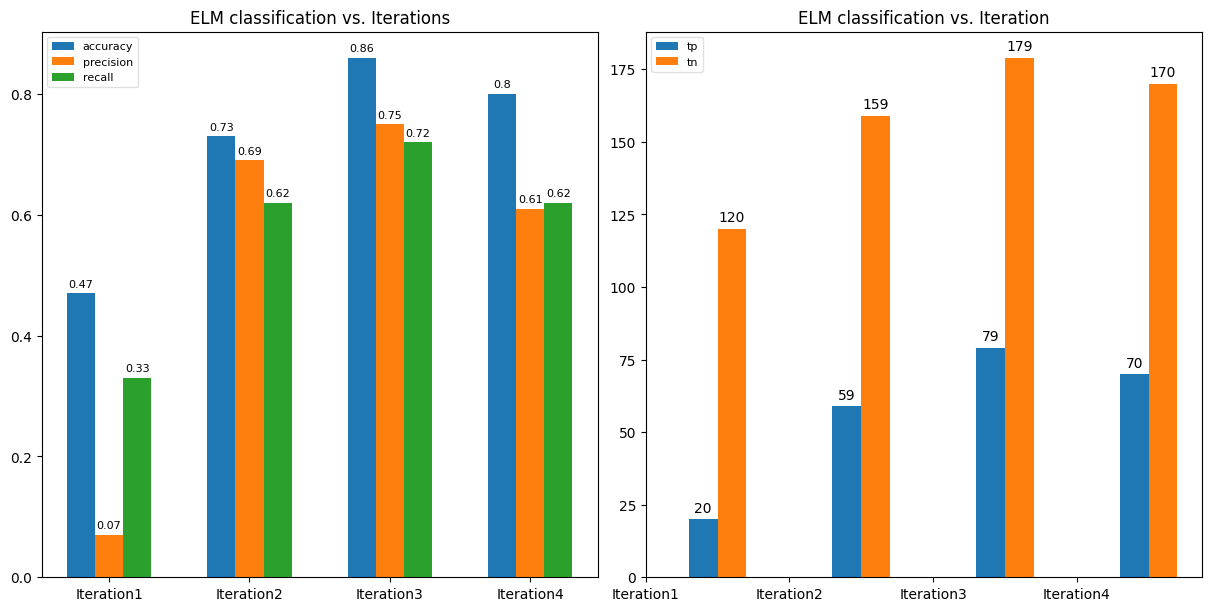

In [14]:
import matplotlib
%matplotlib inline
from utils.vis_utils import plot_bar_metrics
# Visualize classification results
plot_bar_metrics(al_cls_results, metric_type='classification', xticks_label='Iteration', figsize=(12, 6))
# Visualize detection results
if len(al_det_results)>0:
    plot_bar_metrics(al_det_results, metric_type='Detection', xticks_label='Iteration', figsize=(12, 6))


## 4.Active learning with Uncertainity Sampling

In [11]:
import random
import numpy as np
from copy import copy
from omegaconf import OmegaConf
from scipy.stats import entropy

import torch
from torch.utils.data import DataLoader

from utils.misc import get_files_in_dir
from dataset.datasets import split_data, collate_fn
from dataset.datasets import ELMDataset
from trainer import Trainer

%load_ext autoreload
%autoreload 2

def compute_entropy_uncertainty(model, dataset, device):
    model.eval()
    
    dataloader = DataLoader(
        dataset, 
        batch_size=1,
        collate_fn=collate_fn,
        )

    cls_uncertainties = []
    det_uncertainities = []

    with torch.no_grad():
        for batch in dataloader:
            batch = batch.to(device)
            cls_preds, elm_preds = model(batch.dalpha)
            cls_probs = torch.softmax(cls_preds, dim=1).cpu().numpy()
            cls_ent = entropy(cls_probs, axis=1)
            cls_uncertainties.append(cls_ent.mean())
            if elm_preds is not None:
                det_probs = torch.softmax(elm_preds, dim=1).cpu().numpy()
                det_ent = entropy(det_probs, axis=1)
                det_uncertainities.append(det_ent.mean())

    
    return cls_uncertainties, det_uncertainities

INITIAL_LABELS = 2
QUERY_BATCH_SIZE = 2
N_CYCLES = 5

cfg = OmegaConf.create(OmegaConf.load("./configs/base.yaml"))

# Create the trainer
al_ent_trainer = Trainer(cfg, exp_name='al_uncertainity_sampling')

# Load train/test data
shots = [f.split('.')[0] for f in get_files_in_dir(cfg.data.label_dir, file_end='.csv')]
train_shots, test_shots = split_data(shots, train_split=cfg.data.train_split, seed=cfg.rng.seed)
print(f"{shots=}\n{train_shots=}\n{test_shots=}")

# Initialize labeled and unlabeled samples
rng = np.random.default_rng(cfg.rng.seed)

selected_shots = rng.choice(train_shots, 
                            size=INITIAL_LABELS, 
                            replace=False,
                            ).tolist()
labeled_shots = []
unlabeled_shots = train_shots
print(f"{labeled_shots=}, {unlabeled_shots=}")


al_ent_cls_results = []
al_ent_det_results = []
for i in range(N_CYCLES):
    
    print(f"\nActive Learning Cycle {i + 1}")
    
    labeled_shots.extend(selected_shots)
    
    unlabeled_shots = [s for s in unlabeled_shots if s not in selected_shots]

    print(f"{labeled_shots=}\n{unlabeled_shots=}")
    
    al_ent_trainer.train(
        train_sets=labeled_shots, 
        test_sets=test_shots,
        )
        
    # create dataset for unlabelled indices
    unlabeled_dataset = ELMDataset(cfg.data, 
                                   label_files=unlabeled_shots, 
                                   mode='test',
                                  )

    cls_uncertainty_scores, det_uncertainity_scores = compute_entropy_uncertainty(
        model=al_ent_trainer.network, 
        dataset=unlabeled_dataset, 
        device=al_ent_trainer.device,
        )

    # Select most uncertain samples
    query_indices = np.argsort(cls_uncertainty_scores)[-QUERY_BATCH_SIZE:]

    # Add the uncertain samples for training
    selected_shots = [unlabeled_shots[idx] for idx in query_indices]
    

    al_ent_cls_results.append(al_ent_trainer.cls_metric_logger.results)
    if cfg.net.detection:
        al_ent_det_results.append(al_ent_trainer.det_metric_logger.results)

    if not len(unlabeled_shots)>0:
        break


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
shots=['30454', '30457', '30458', '30459', '30460', '30461', '30462', '30463', '30464', '30465']
train_shots=['30454', '30457', '30458', '30459', '30460', '30461', '30462', '30463']
test_shots=['30464', '30465']
labeled_shots=[], unlabeled_shots=['30454', '30457', '30458', '30459', '30460', '30461', '30462', '30463']

Active Learning Cycle 1
labeled_shots=['30454', '30462']
unlabeled_shots=['30457', '30458', '30459', '30460', '30461', '30463']
Preparing train/test dataset ... 
Creating dataloaders ...
train samples: 2, train batch size: 16, train batches: 1

Verifying train dataloader ... 
{'dalpha': torch.Size([120, 1, 512]), 'dtime': torch.Size([120, 1, 512]), 'cls_labels': torch.Size([120]), 'elm_labels': torch.Size([120, 512])}
val samples: 0, val batch size: 16, val batches: 0

Verifying val dataloader ... 
test samples: 2, test batch size: 16, test batches: 1

Verifying test dataloader ... 


/home/ubuntu/miniconda3/envs/mlvis/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


{'dalpha': torch.Size([100, 1, 512]), 'dtime': torch.Size([100, 1, 512]), 'cls_labels': torch.Size([100]), 'elm_labels': torch.Size([100, 512])}
Training Started (device: cuda:0, rank: 0)
Epoch 0/1000


100%|██████████| 1/1 [00:00<00:00, 15.91it/s, , elm_cls_loss:    1.101, loss:    1.101]


Epoch 1/1000


100%|██████████| 1/1 [00:00<00:00, 20.15it/s, , elm_cls_loss:    1.101, loss:    1.101]


Epoch 2/1000


100%|██████████| 1/1 [00:00<00:00, 20.83it/s, , elm_cls_loss:    1.101, loss:    1.101]


Epoch 3/1000


100%|██████████| 1/1 [00:00<00:00, 20.99it/s, , elm_cls_loss:    1.101, loss:    1.101]


Epoch 4/1000


100%|██████████| 1/1 [00:00<00:00, 21.40it/s, , elm_cls_loss:    1.101, loss:    1.101]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 21.79it/s, test_loss: 1.118,                             test_cls_acc: 0.200]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   20 |   80 |  120 |   80 |      0.467 |       0.067 |    0.333 | 0.111 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  3.09it/s, test_loss: 1.118,                             test_cls_acc: 0.200]


Modelcheckpoint: test/loss improved from inf to 1.118136.
Saving model checkpoint ... 
Early Stopping: test/loss improved from inf to 1.118136.
Epoch 5/1000


100%|██████████| 1/1 [00:00<00:00, 20.30it/s, , elm_cls_loss:    1.100, loss:    1.100]


Epoch 6/1000


100%|██████████| 1/1 [00:00<00:00, 19.63it/s, , elm_cls_loss:    1.100, loss:    1.100]


Epoch 7/1000


100%|██████████| 1/1 [00:00<00:00, 21.34it/s, , elm_cls_loss:    1.101, loss:    1.101]


Epoch 8/1000


100%|██████████| 1/1 [00:00<00:00, 21.15it/s, , elm_cls_loss:    1.100, loss:    1.100]


Epoch 9/1000


100%|██████████| 1/1 [00:00<00:00, 21.72it/s, , elm_cls_loss:    1.100, loss:    1.100]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 25.11it/s, test_loss: 1.116,                             test_cls_acc: 0.200]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   20 |   80 |  120 |   80 |      0.467 |       0.067 |    0.333 | 0.111 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.66it/s, test_loss: 1.116,                             test_cls_acc: 0.200]


Modelcheckpoint: test/loss improved from 1.118136 to 1.115731.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.118136 to 1.115731.
Epoch 10/1000


100%|██████████| 1/1 [00:00<00:00, 19.50it/s, , elm_cls_loss:    1.100, loss:    1.100]


Epoch 11/1000


100%|██████████| 1/1 [00:00<00:00, 20.01it/s, , elm_cls_loss:    1.100, loss:    1.100]


Epoch 12/1000


100%|██████████| 1/1 [00:00<00:00, 20.22it/s, , elm_cls_loss:    1.100, loss:    1.100]


Epoch 13/1000


100%|██████████| 1/1 [00:00<00:00, 20.99it/s, , elm_cls_loss:    1.100, loss:    1.100]


Epoch 14/1000


100%|██████████| 1/1 [00:00<00:00, 20.08it/s, , elm_cls_loss:    1.100, loss:    1.100]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 25.43it/s, test_loss: 1.113,                             test_cls_acc: 0.200]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   20 |   80 |  120 |   80 |      0.467 |       0.067 |    0.333 | 0.111 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.82it/s, test_loss: 1.113,                             test_cls_acc: 0.200]


Modelcheckpoint: test/loss improved from 1.115731 to 1.112842.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.115731 to 1.112842.
Epoch 15/1000


100%|██████████| 1/1 [00:00<00:00, 20.53it/s, , elm_cls_loss:    1.100, loss:    1.100]


Epoch 16/1000


100%|██████████| 1/1 [00:00<00:00, 21.06it/s, , elm_cls_loss:    1.100, loss:    1.100]


Epoch 17/1000


100%|██████████| 1/1 [00:00<00:00, 21.12it/s, , elm_cls_loss:    1.099, loss:    1.099]


Epoch 18/1000


100%|██████████| 1/1 [00:00<00:00, 21.37it/s, , elm_cls_loss:    1.100, loss:    1.100]


Epoch 19/1000


100%|██████████| 1/1 [00:00<00:00, 20.75it/s, , elm_cls_loss:    1.099, loss:    1.099]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 25.14it/s, test_loss: 1.108,                             test_cls_acc: 0.200]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   20 |   80 |  120 |   80 |      0.467 |       0.067 |    0.333 | 0.111 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.92it/s, test_loss: 1.108,                             test_cls_acc: 0.200]


Modelcheckpoint: test/loss improved from 1.112842 to 1.107839.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.112842 to 1.107839.
Epoch 20/1000


100%|██████████| 1/1 [00:00<00:00, 19.74it/s, , elm_cls_loss:    1.099, loss:    1.099]


Epoch 21/1000


100%|██████████| 1/1 [00:00<00:00, 21.24it/s, , elm_cls_loss:    1.099, loss:    1.099]


Epoch 22/1000


100%|██████████| 1/1 [00:00<00:00, 21.14it/s, , elm_cls_loss:    1.098, loss:    1.098]


Epoch 23/1000


100%|██████████| 1/1 [00:00<00:00, 21.92it/s, , elm_cls_loss:    1.099, loss:    1.099]


Epoch 24/1000


100%|██████████| 1/1 [00:00<00:00, 21.42it/s, , elm_cls_loss:    1.098, loss:    1.098]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 25.90it/s, test_loss: 1.103,                             test_cls_acc: 0.200]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   20 |   80 |  120 |   80 |      0.467 |       0.067 |    0.333 | 0.111 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.21it/s, test_loss: 1.103,                             test_cls_acc: 0.200]


Modelcheckpoint: test/loss improved from 1.107839 to 1.103042.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.107839 to 1.103042.
Epoch 25/1000


100%|██████████| 1/1 [00:00<00:00, 18.73it/s, , elm_cls_loss:    1.099, loss:    1.099]


Epoch 26/1000


100%|██████████| 1/1 [00:00<00:00, 20.07it/s, , elm_cls_loss:    1.098, loss:    1.098]


Epoch 27/1000


100%|██████████| 1/1 [00:00<00:00, 20.80it/s, , elm_cls_loss:    1.098, loss:    1.098]


Epoch 28/1000


100%|██████████| 1/1 [00:00<00:00, 20.34it/s, , elm_cls_loss:    1.098, loss:    1.098]


Epoch 29/1000


100%|██████████| 1/1 [00:00<00:00, 21.39it/s, , elm_cls_loss:    1.100, loss:    1.100]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 24.51it/s, test_loss: 1.108,                             test_cls_acc: 0.200]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   20 |   80 |  120 |   80 |      0.467 |       0.067 |    0.333 | 0.111 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.02it/s, test_loss: 1.108,                             test_cls_acc: 0.200]


Modelcheckpoint: test/loss didn't improved from 1.103042.
Early Stopping: test/loss didn't improve from 1.103042. Counter will start after 10 warmup steps
Epoch 30/1000


100%|██████████| 1/1 [00:00<00:00, 20.40it/s, , elm_cls_loss:    1.099, loss:    1.099]


Epoch 31/1000


100%|██████████| 1/1 [00:00<00:00, 21.59it/s, , elm_cls_loss:    1.097, loss:    1.097]


Epoch 32/1000


100%|██████████| 1/1 [00:00<00:00, 21.47it/s, , elm_cls_loss:    1.100, loss:    1.100]


Epoch 33/1000


100%|██████████| 1/1 [00:00<00:00, 21.84it/s, , elm_cls_loss:    1.102, loss:    1.102]


Epoch 34/1000


100%|██████████| 1/1 [00:00<00:00, 22.40it/s, , elm_cls_loss:    1.096, loss:    1.096]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 26.00it/s, test_loss: 1.099,                             test_cls_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  7.69it/s, test_loss: 1.099,                             test_cls_acc: 0.400]


Modelcheckpoint: test/loss improved from 1.103042 to 1.098770.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.103042 to 1.098770.
Epoch 35/1000


100%|██████████| 1/1 [00:00<00:00, 19.83it/s, , elm_cls_loss:    1.098, loss:    1.098]


Epoch 36/1000


100%|██████████| 1/1 [00:00<00:00, 21.09it/s, , elm_cls_loss:    1.099, loss:    1.099]


Epoch 37/1000


100%|██████████| 1/1 [00:00<00:00, 21.95it/s, , elm_cls_loss:    1.099, loss:    1.099]


Epoch 38/1000


100%|██████████| 1/1 [00:00<00:00, 22.04it/s, , elm_cls_loss:    1.098, loss:    1.098]


Epoch 39/1000


100%|██████████| 1/1 [00:00<00:00, 20.15it/s, , elm_cls_loss:    1.099, loss:    1.099]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 25.65it/s, test_loss: 1.101,                             test_cls_acc: 0.200]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   20 |   80 |  120 |   80 |      0.467 |       0.067 |    0.333 | 0.111 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.91it/s, test_loss: 1.101,                             test_cls_acc: 0.200]


Modelcheckpoint: test/loss didn't improved from 1.098770.
Early Stopping: test/loss didn't improve from 1.098770. Counter will start after 10 warmup steps
Epoch 40/1000


100%|██████████| 1/1 [00:00<00:00, 20.35it/s, , elm_cls_loss:    1.099, loss:    1.099]


Epoch 41/1000


100%|██████████| 1/1 [00:00<00:00, 20.16it/s, , elm_cls_loss:    1.099, loss:    1.099]


Epoch 42/1000


100%|██████████| 1/1 [00:00<00:00, 20.80it/s, , elm_cls_loss:    1.099, loss:    1.099]


Epoch 43/1000


100%|██████████| 1/1 [00:00<00:00, 21.46it/s, , elm_cls_loss:    1.098, loss:    1.098]


Epoch 44/1000


100%|██████████| 1/1 [00:00<00:00, 21.35it/s, , elm_cls_loss:    1.099, loss:    1.099]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 25.88it/s, test_loss: 1.103,                             test_cls_acc: 0.200]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   20 |   80 |  120 |   80 |      0.467 |       0.067 |    0.333 | 0.111 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.65it/s, test_loss: 1.103,                             test_cls_acc: 0.200]


Modelcheckpoint: test/loss didn't improved from 1.098770.
Early Stopping: test/loss didn't improve from 1.098770. Counter will start after 10 warmup steps
Epoch 45/1000


100%|██████████| 1/1 [00:00<00:00, 20.17it/s, , elm_cls_loss:    1.099, loss:    1.099]


Epoch 46/1000


100%|██████████| 1/1 [00:00<00:00, 20.89it/s, , elm_cls_loss:    1.099, loss:    1.099]


Epoch 47/1000


100%|██████████| 1/1 [00:00<00:00, 20.19it/s, , elm_cls_loss:    1.098, loss:    1.098]


Epoch 48/1000


100%|██████████| 1/1 [00:00<00:00, 20.88it/s, , elm_cls_loss:    1.099, loss:    1.099]


Epoch 49/1000


100%|██████████| 1/1 [00:00<00:00, 21.94it/s, , elm_cls_loss:    1.099, loss:    1.099]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 24.81it/s, test_loss: 1.103,                             test_cls_acc: 0.200]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   20 |   80 |  120 |   80 |      0.467 |       0.067 |    0.333 | 0.111 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.56it/s, test_loss: 1.103,                             test_cls_acc: 0.200]


Modelcheckpoint: test/loss didn't improved from 1.098770.
Early Stopping: test/loss didn't improve from 1.098770. Early stopping counter: 1/10
Epoch 50/1000


100%|██████████| 1/1 [00:00<00:00, 19.74it/s, , elm_cls_loss:    1.099, loss:    1.099]


Epoch 51/1000


100%|██████████| 1/1 [00:00<00:00, 19.86it/s, , elm_cls_loss:    1.099, loss:    1.099]


Epoch 52/1000


100%|██████████| 1/1 [00:00<00:00, 20.46it/s, , elm_cls_loss:    1.099, loss:    1.099]


Epoch 53/1000


100%|██████████| 1/1 [00:00<00:00, 19.96it/s, , elm_cls_loss:    1.100, loss:    1.100]


Epoch 54/1000


100%|██████████| 1/1 [00:00<00:00, 18.38it/s, , elm_cls_loss:    1.098, loss:    1.098]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 25.95it/s, test_loss: 1.103,                             test_cls_acc: 0.200]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   20 |   80 |  120 |   80 |      0.467 |       0.067 |    0.333 | 0.111 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.74it/s, test_loss: 1.103,                             test_cls_acc: 0.200]


Modelcheckpoint: test/loss didn't improved from 1.098770.
Early Stopping: test/loss didn't improve from 1.098770. Early stopping counter: 2/10
Epoch 55/1000


100%|██████████| 1/1 [00:00<00:00, 19.04it/s, , elm_cls_loss:    1.099, loss:    1.099]


Epoch 56/1000


100%|██████████| 1/1 [00:00<00:00, 20.52it/s, , elm_cls_loss:    1.098, loss:    1.098]


Epoch 57/1000


100%|██████████| 1/1 [00:00<00:00, 20.53it/s, , elm_cls_loss:    1.098, loss:    1.098]


Epoch 58/1000


100%|██████████| 1/1 [00:00<00:00, 19.14it/s, , elm_cls_loss:    1.099, loss:    1.099]


Epoch 59/1000


100%|██████████| 1/1 [00:00<00:00, 20.48it/s, , elm_cls_loss:    1.099, loss:    1.099]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 20.86it/s, test_loss: 1.103,                             test_cls_acc: 0.200]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   20 |   80 |  120 |   80 |      0.467 |       0.067 |    0.333 | 0.111 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  6.77it/s, test_loss: 1.103,                             test_cls_acc: 0.200]


Modelcheckpoint: test/loss didn't improved from 1.098770.
Early Stopping: test/loss didn't improve from 1.098770. Early stopping counter: 3/10
Epoch 60/1000


100%|██████████| 1/1 [00:00<00:00, 19.68it/s, , elm_cls_loss:    1.099, loss:    1.099]


Epoch 61/1000


100%|██████████| 1/1 [00:00<00:00, 20.33it/s, , elm_cls_loss:    1.099, loss:    1.099]


Epoch 62/1000


100%|██████████| 1/1 [00:00<00:00, 19.73it/s, , elm_cls_loss:    1.099, loss:    1.099]


Epoch 63/1000


100%|██████████| 1/1 [00:00<00:00, 21.07it/s, , elm_cls_loss:    1.099, loss:    1.099]


Epoch 64/1000


100%|██████████| 1/1 [00:00<00:00, 21.27it/s, , elm_cls_loss:    1.099, loss:    1.099]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 26.05it/s, test_loss: 1.102,                             test_cls_acc: 0.200]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   20 |   80 |  120 |   80 |      0.467 |       0.067 |    0.333 | 0.111 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.42it/s, test_loss: 1.102,                             test_cls_acc: 0.200]


Modelcheckpoint: test/loss didn't improved from 1.098770.
Early Stopping: test/loss didn't improve from 1.098770. Early stopping counter: 4/10
Epoch 65/1000


100%|██████████| 1/1 [00:00<00:00, 18.00it/s, , elm_cls_loss:    1.100, loss:    1.100]


Epoch 66/1000


100%|██████████| 1/1 [00:00<00:00, 21.05it/s, , elm_cls_loss:    1.098, loss:    1.098]


Epoch 67/1000


100%|██████████| 1/1 [00:00<00:00, 20.78it/s, , elm_cls_loss:    1.099, loss:    1.099]


Epoch 68/1000


100%|██████████| 1/1 [00:00<00:00, 20.35it/s, , elm_cls_loss:    1.099, loss:    1.099]


Epoch 69/1000


100%|██████████| 1/1 [00:00<00:00, 21.26it/s, , elm_cls_loss:    1.099, loss:    1.099]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 26.13it/s, test_loss: 1.101,                             test_cls_acc: 0.200]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   20 |   80 |  120 |   80 |      0.467 |       0.067 |    0.333 | 0.111 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.71it/s, test_loss: 1.101,                             test_cls_acc: 0.200]


Modelcheckpoint: test/loss didn't improved from 1.098770.
Early Stopping: test/loss didn't improve from 1.098770. Early stopping counter: 5/10
Epoch 70/1000


100%|██████████| 1/1 [00:00<00:00, 17.35it/s, , elm_cls_loss:    1.099, loss:    1.099]


Epoch 71/1000


100%|██████████| 1/1 [00:00<00:00, 19.44it/s, , elm_cls_loss:    1.099, loss:    1.099]


Epoch 72/1000


100%|██████████| 1/1 [00:00<00:00, 17.78it/s, , elm_cls_loss:    1.099, loss:    1.099]


Epoch 73/1000


100%|██████████| 1/1 [00:00<00:00, 19.98it/s, , elm_cls_loss:    1.098, loss:    1.098]


Epoch 74/1000


100%|██████████| 1/1 [00:00<00:00, 21.29it/s, , elm_cls_loss:    1.100, loss:    1.100]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 25.33it/s, test_loss: 1.102,                             test_cls_acc: 0.200]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   20 |   80 |  120 |   80 |      0.467 |       0.067 |    0.333 | 0.111 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  8.20it/s, test_loss: 1.102,                             test_cls_acc: 0.200]


Modelcheckpoint: test/loss didn't improved from 1.098770.
Early Stopping: test/loss didn't improve from 1.098770. Early stopping counter: 6/10
Epoch 75/1000


100%|██████████| 1/1 [00:00<00:00, 20.46it/s, , elm_cls_loss:    1.098, loss:    1.098]


Epoch 76/1000


100%|██████████| 1/1 [00:00<00:00, 21.01it/s, , elm_cls_loss:    1.098, loss:    1.098]


Epoch 77/1000


100%|██████████| 1/1 [00:00<00:00, 20.79it/s, , elm_cls_loss:    1.098, loss:    1.098]


Epoch 78/1000


100%|██████████| 1/1 [00:00<00:00, 19.74it/s, , elm_cls_loss:    1.099, loss:    1.099]


Epoch 79/1000


100%|██████████| 1/1 [00:00<00:00, 20.64it/s, , elm_cls_loss:    1.099, loss:    1.099]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 24.47it/s, test_loss: 1.101,                             test_cls_acc: 0.200]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   20 |   80 |  120 |   80 |      0.467 |       0.067 |    0.333 | 0.111 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.16it/s, test_loss: 1.101,                             test_cls_acc: 0.200]


Modelcheckpoint: test/loss didn't improved from 1.098770.
Early Stopping: test/loss didn't improve from 1.098770. Early stopping counter: 7/10
Epoch 80/1000


100%|██████████| 1/1 [00:00<00:00, 20.49it/s, , elm_cls_loss:    1.099, loss:    1.099]


Epoch 81/1000


100%|██████████| 1/1 [00:00<00:00, 21.13it/s, , elm_cls_loss:    1.098, loss:    1.098]


Epoch 82/1000


100%|██████████| 1/1 [00:00<00:00, 21.50it/s, , elm_cls_loss:    1.099, loss:    1.099]


Epoch 83/1000


100%|██████████| 1/1 [00:00<00:00, 21.03it/s, , elm_cls_loss:    1.099, loss:    1.099]


Epoch 84/1000


100%|██████████| 1/1 [00:00<00:00, 21.35it/s, , elm_cls_loss:    1.099, loss:    1.099]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.37it/s, test_loss: 1.101,                             test_cls_acc: 0.200]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   20 |   80 |  120 |   80 |      0.467 |       0.067 |    0.333 | 0.111 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.80it/s, test_loss: 1.101,                             test_cls_acc: 0.200]


Modelcheckpoint: test/loss didn't improved from 1.098770.
Early Stopping: test/loss didn't improve from 1.098770. Early stopping counter: 8/10
Epoch 85/1000


100%|██████████| 1/1 [00:00<00:00, 18.41it/s, , elm_cls_loss:    1.098, loss:    1.098]


Epoch 86/1000


100%|██████████| 1/1 [00:00<00:00, 21.11it/s, , elm_cls_loss:    1.099, loss:    1.099]


Epoch 87/1000


100%|██████████| 1/1 [00:00<00:00, 21.54it/s, , elm_cls_loss:    1.099, loss:    1.099]


Epoch 88/1000


100%|██████████| 1/1 [00:00<00:00, 20.94it/s, , elm_cls_loss:    1.099, loss:    1.099]


Epoch 89/1000


100%|██████████| 1/1 [00:00<00:00, 19.48it/s, , elm_cls_loss:    1.099, loss:    1.099]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 24.98it/s, test_loss: 1.101,                             test_cls_acc: 0.200]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   20 |   80 |  120 |   80 |      0.467 |       0.067 |    0.333 | 0.111 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.72it/s, test_loss: 1.101,                             test_cls_acc: 0.200]


Modelcheckpoint: test/loss didn't improved from 1.098770.
Early Stopping: test/loss didn't improve from 1.098770. Early stopping counter: 9/10
Epoch 90/1000


100%|██████████| 1/1 [00:00<00:00, 19.64it/s, , elm_cls_loss:    1.099, loss:    1.099]


Epoch 91/1000


100%|██████████| 1/1 [00:00<00:00, 18.54it/s, , elm_cls_loss:    1.098, loss:    1.098]


Epoch 92/1000


100%|██████████| 1/1 [00:00<00:00, 21.68it/s, , elm_cls_loss:    1.099, loss:    1.099]


Epoch 93/1000


100%|██████████| 1/1 [00:00<00:00, 21.88it/s, , elm_cls_loss:    1.099, loss:    1.099]


Epoch 94/1000


100%|██████████| 1/1 [00:00<00:00, 19.86it/s, , elm_cls_loss:    1.099, loss:    1.099]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 25.60it/s, test_loss: 1.101,                             test_cls_acc: 0.200]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   20 |   80 |  120 |   80 |      0.467 |       0.067 |    0.333 | 0.111 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.71it/s, test_loss: 1.101,                             test_cls_acc: 0.200]


Modelcheckpoint: test/loss didn't improved from 1.098770.
Early Stopping: test/loss didn't improve from 1.098770. Early stopping counter: 10/10
Early stopping at epoch 94
DONE in 9.096487283706665!
Best ELM Classfication Results (epoch 34) {'tp': 40.0, 'fp': 60.0, 'tn': 140.0, 'fn': 60.0, 'accuracy': 0.6, 'precision': 0.13333333333333333, 'recall': 0.3333333333333333, 'f1': 0.1904761904761905}

Active Learning Cycle 2
labeled_shots=['30454', '30462', '30461', '30463']
unlabeled_shots=['30457', '30458', '30459', '30460']
Preparing train/test dataset ... 
Creating dataloaders ...
train samples: 4, train batch size: 16, train batches: 1

Verifying train dataloader ... 
{'dalpha': torch.Size([200, 1, 512]), 'dtime': torch.Size([200, 1, 512]), 'cls_labels': torch.Size([200]), 'elm_labels': torch.Size([200, 512])}
val samples: 0, val batch size: 16, val batches: 0

Verifying val dataloader ... 
test samples: 2, test batch size: 16, test batches: 1

Verifying test dataloader ... 


/home/ubuntu/miniconda3/envs/mlvis/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


{'dalpha': torch.Size([100, 1, 512]), 'dtime': torch.Size([100, 1, 512]), 'cls_labels': torch.Size([100]), 'elm_labels': torch.Size([100, 512])}
Training Started (device: cuda:0, rank: 0)
Epoch 0/1000


100%|██████████| 1/1 [00:00<00:00,  7.97it/s, , elm_cls_loss:    1.102, loss:    1.102]


Epoch 1/1000


100%|██████████| 1/1 [00:00<00:00, 11.29it/s, , elm_cls_loss:    1.098, loss:    1.098]


Epoch 2/1000


100%|██████████| 1/1 [00:00<00:00, 12.84it/s, , elm_cls_loss:    1.094, loss:    1.094]


Epoch 3/1000


100%|██████████| 1/1 [00:00<00:00, 12.04it/s, , elm_cls_loss:    1.090, loss:    1.090]


Epoch 4/1000


100%|██████████| 1/1 [00:00<00:00, 12.53it/s, , elm_cls_loss:    1.089, loss:    1.089]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 20.25it/s, test_loss: 1.078,                             test_cls_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  3.06it/s, test_loss: 1.078,                             test_cls_acc: 0.400]


Modelcheckpoint: test/loss improved from inf to 1.077671.
Saving model checkpoint ... 
Early Stopping: test/loss improved from inf to 1.077671.
Epoch 5/1000


100%|██████████| 1/1 [00:00<00:00, 12.41it/s, , elm_cls_loss:    1.079, loss:    1.079]


Epoch 6/1000


100%|██████████| 1/1 [00:00<00:00, 12.60it/s, , elm_cls_loss:    1.064, loss:    1.064]


Epoch 7/1000


100%|██████████| 1/1 [00:00<00:00, 12.89it/s, , elm_cls_loss:    1.076, loss:    1.076]


Epoch 8/1000


100%|██████████| 1/1 [00:00<00:00, 12.85it/s, , elm_cls_loss:    1.090, loss:    1.090]


Epoch 9/1000


100%|██████████| 1/1 [00:00<00:00, 12.42it/s, , elm_cls_loss:    1.078, loss:    1.078]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.61it/s, test_loss: 1.063,                             test_cls_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  7.43it/s, test_loss: 1.063,                             test_cls_acc: 0.400]


Modelcheckpoint: test/loss improved from 1.077671 to 1.063036.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.077671 to 1.063036.
Epoch 10/1000


100%|██████████| 1/1 [00:00<00:00, 12.28it/s, , elm_cls_loss:    1.065, loss:    1.065]


Epoch 11/1000


100%|██████████| 1/1 [00:00<00:00, 12.71it/s, , elm_cls_loss:    1.068, loss:    1.068]


Epoch 12/1000


100%|██████████| 1/1 [00:00<00:00, 11.26it/s, , elm_cls_loss:    1.067, loss:    1.067]


Epoch 13/1000


100%|██████████| 1/1 [00:00<00:00, 12.92it/s, , elm_cls_loss:    1.072, loss:    1.072]


Epoch 14/1000


100%|██████████| 1/1 [00:00<00:00, 13.18it/s, , elm_cls_loss:    1.066, loss:    1.066]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 21.33it/s, test_loss: 1.066,                             test_cls_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  7.11it/s, test_loss: 1.066,                             test_cls_acc: 0.400]


Modelcheckpoint: test/loss didn't improved from 1.063036.
Early Stopping: test/loss didn't improve from 1.063036. Counter will start after 10 warmup steps
Epoch 15/1000


100%|██████████| 1/1 [00:00<00:00, 10.96it/s, , elm_cls_loss:    1.068, loss:    1.068]


Epoch 16/1000


100%|██████████| 1/1 [00:00<00:00, 11.74it/s, , elm_cls_loss:    1.058, loss:    1.058]


Epoch 17/1000


100%|██████████| 1/1 [00:00<00:00, 12.82it/s, , elm_cls_loss:    1.064, loss:    1.064]


Epoch 18/1000


100%|██████████| 1/1 [00:00<00:00, 12.65it/s, , elm_cls_loss:    1.050, loss:    1.050]


Epoch 19/1000


100%|██████████| 1/1 [00:00<00:00, 12.41it/s, , elm_cls_loss:    1.063, loss:    1.063]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.09it/s, test_loss: 1.059,                             test_cls_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  7.28it/s, test_loss: 1.059,                             test_cls_acc: 0.400]


Modelcheckpoint: test/loss improved from 1.063036 to 1.059333.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.063036 to 1.059333.
Epoch 20/1000


100%|██████████| 1/1 [00:00<00:00, 12.52it/s, , elm_cls_loss:    1.069, loss:    1.069]


Epoch 21/1000


100%|██████████| 1/1 [00:00<00:00, 13.04it/s, , elm_cls_loss:    1.071, loss:    1.071]


Epoch 22/1000


100%|██████████| 1/1 [00:00<00:00, 11.48it/s, , elm_cls_loss:    1.052, loss:    1.052]


Epoch 23/1000


100%|██████████| 1/1 [00:00<00:00, 12.73it/s, , elm_cls_loss:    1.068, loss:    1.068]


Epoch 24/1000


100%|██████████| 1/1 [00:00<00:00, 12.60it/s, , elm_cls_loss:    1.054, loss:    1.054]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 22.67it/s, test_loss: 1.059,                             test_cls_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  7.32it/s, test_loss: 1.059,                             test_cls_acc: 0.400]


Modelcheckpoint: test/loss improved from 1.059333 to 1.058565.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.059333 to 1.058565.
Epoch 25/1000


100%|██████████| 1/1 [00:00<00:00, 11.09it/s, , elm_cls_loss:    1.050, loss:    1.050]


Epoch 26/1000


100%|██████████| 1/1 [00:00<00:00, 12.59it/s, , elm_cls_loss:    1.060, loss:    1.060]


Epoch 27/1000


100%|██████████| 1/1 [00:00<00:00, 12.89it/s, , elm_cls_loss:    1.070, loss:    1.070]


Epoch 28/1000


100%|██████████| 1/1 [00:00<00:00,  9.97it/s, , elm_cls_loss:    1.056, loss:    1.056]


Epoch 29/1000


100%|██████████| 1/1 [00:00<00:00, 12.83it/s, , elm_cls_loss:    1.052, loss:    1.052]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 22.05it/s, test_loss: 1.055,                             test_cls_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  5.30it/s, test_loss: 1.055,                             test_cls_acc: 0.400]


Modelcheckpoint: test/loss improved from 1.058565 to 1.054881.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.058565 to 1.054881.
Epoch 30/1000


100%|██████████| 1/1 [00:00<00:00, 12.11it/s, , elm_cls_loss:    1.058, loss:    1.058]


Epoch 31/1000


100%|██████████| 1/1 [00:00<00:00, 12.63it/s, , elm_cls_loss:    1.051, loss:    1.051]


Epoch 32/1000


100%|██████████| 1/1 [00:00<00:00, 11.38it/s, , elm_cls_loss:    1.067, loss:    1.067]


Epoch 33/1000


100%|██████████| 1/1 [00:00<00:00, 12.59it/s, , elm_cls_loss:    1.055, loss:    1.055]


Epoch 34/1000


100%|██████████| 1/1 [00:00<00:00, 12.96it/s, , elm_cls_loss:    1.069, loss:    1.069]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 20.85it/s, test_loss: 1.054,                             test_cls_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  5.86it/s, test_loss: 1.054,                             test_cls_acc: 0.400]


Modelcheckpoint: test/loss improved from 1.054881 to 1.054481.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.054881 to 1.054481.
Epoch 35/1000


100%|██████████| 1/1 [00:00<00:00, 12.07it/s, , elm_cls_loss:    1.075, loss:    1.075]


Epoch 36/1000


100%|██████████| 1/1 [00:00<00:00, 12.09it/s, , elm_cls_loss:    1.056, loss:    1.056]


Epoch 37/1000


100%|██████████| 1/1 [00:00<00:00, 12.15it/s, , elm_cls_loss:    1.065, loss:    1.065]


Epoch 38/1000


100%|██████████| 1/1 [00:00<00:00, 12.29it/s, , elm_cls_loss:    1.062, loss:    1.062]


Epoch 39/1000


100%|██████████| 1/1 [00:00<00:00, 12.50it/s, , elm_cls_loss:    1.059, loss:    1.059]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.61it/s, test_loss: 1.058,                             test_cls_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  6.03it/s, test_loss: 1.058,                             test_cls_acc: 0.400]


Modelcheckpoint: test/loss didn't improved from 1.054481.
Early Stopping: test/loss didn't improve from 1.054481. Counter will start after 10 warmup steps
Epoch 40/1000


100%|██████████| 1/1 [00:00<00:00, 11.28it/s, , elm_cls_loss:    1.058, loss:    1.058]


Epoch 41/1000


100%|██████████| 1/1 [00:00<00:00, 12.55it/s, , elm_cls_loss:    1.054, loss:    1.054]


Epoch 42/1000


100%|██████████| 1/1 [00:00<00:00, 12.97it/s, , elm_cls_loss:    1.051, loss:    1.051]


Epoch 43/1000


100%|██████████| 1/1 [00:00<00:00, 12.98it/s, , elm_cls_loss:    1.055, loss:    1.055]


Epoch 44/1000


100%|██████████| 1/1 [00:00<00:00, 12.32it/s, , elm_cls_loss:    1.061, loss:    1.061]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.43it/s, test_loss: 1.054,                             test_cls_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  5.77it/s, test_loss: 1.054,                             test_cls_acc: 0.400]


Modelcheckpoint: test/loss improved from 1.054481 to 1.054304.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.054481 to 1.054304.
Epoch 45/1000


100%|██████████| 1/1 [00:00<00:00, 10.02it/s, , elm_cls_loss:    1.051, loss:    1.051]


Epoch 46/1000


100%|██████████| 1/1 [00:00<00:00, 12.16it/s, , elm_cls_loss:    1.060, loss:    1.060]


Epoch 47/1000


100%|██████████| 1/1 [00:00<00:00, 12.08it/s, , elm_cls_loss:    1.053, loss:    1.053]


Epoch 48/1000


100%|██████████| 1/1 [00:00<00:00, 12.07it/s, , elm_cls_loss:    1.053, loss:    1.053]


Epoch 49/1000


100%|██████████| 1/1 [00:00<00:00, 12.75it/s, , elm_cls_loss:    1.056, loss:    1.056]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 21.11it/s, test_loss: 1.055,                             test_cls_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  5.34it/s, test_loss: 1.055,                             test_cls_acc: 0.400]


Modelcheckpoint: test/loss didn't improved from 1.054304.
Early Stopping: test/loss didn't improve from 1.054304. Early stopping counter: 1/10
Epoch 50/1000


100%|██████████| 1/1 [00:00<00:00, 12.48it/s, , elm_cls_loss:    1.057, loss:    1.057]


Epoch 51/1000


100%|██████████| 1/1 [00:00<00:00, 11.48it/s, , elm_cls_loss:    1.053, loss:    1.053]


Epoch 52/1000


100%|██████████| 1/1 [00:00<00:00, 11.86it/s, , elm_cls_loss:    1.048, loss:    1.048]


Epoch 53/1000


100%|██████████| 1/1 [00:00<00:00, 12.54it/s, , elm_cls_loss:    1.050, loss:    1.050]


Epoch 54/1000


100%|██████████| 1/1 [00:00<00:00, 12.10it/s, , elm_cls_loss:    1.052, loss:    1.052]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.35it/s, test_loss: 1.051,                             test_cls_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  6.46it/s, test_loss: 1.051,                             test_cls_acc: 0.400]


Modelcheckpoint: test/loss improved from 1.054304 to 1.050677.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.054304 to 1.050677.
Epoch 55/1000


100%|██████████| 1/1 [00:00<00:00, 10.16it/s, , elm_cls_loss:    1.059, loss:    1.059]


Epoch 56/1000


100%|██████████| 1/1 [00:00<00:00, 12.60it/s, , elm_cls_loss:    1.051, loss:    1.051]


Epoch 57/1000


100%|██████████| 1/1 [00:00<00:00, 12.41it/s, , elm_cls_loss:    1.059, loss:    1.059]


Epoch 58/1000


100%|██████████| 1/1 [00:00<00:00, 12.51it/s, , elm_cls_loss:    1.052, loss:    1.052]


Epoch 59/1000


100%|██████████| 1/1 [00:00<00:00, 12.22it/s, , elm_cls_loss:    1.050, loss:    1.050]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 17.88it/s, test_loss: 1.049,                             test_cls_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  4.27it/s, test_loss: 1.049,                             test_cls_acc: 0.400]


Modelcheckpoint: test/loss improved from 1.050677 to 1.049426.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.050677 to 1.049426.
Epoch 60/1000


100%|██████████| 1/1 [00:00<00:00, 11.45it/s, , elm_cls_loss:    1.051, loss:    1.051]


Epoch 61/1000


100%|██████████| 1/1 [00:00<00:00, 12.61it/s, , elm_cls_loss:    1.049, loss:    1.049]


Epoch 62/1000


100%|██████████| 1/1 [00:00<00:00, 12.70it/s, , elm_cls_loss:    1.047, loss:    1.047]


Epoch 63/1000


100%|██████████| 1/1 [00:00<00:00, 12.20it/s, , elm_cls_loss:    1.052, loss:    1.052]


Epoch 64/1000


100%|██████████| 1/1 [00:00<00:00, 11.79it/s, , elm_cls_loss:    1.051, loss:    1.051]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.51it/s, test_loss: 1.047,                             test_cls_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  6.82it/s, test_loss: 1.047,                             test_cls_acc: 0.400]


Modelcheckpoint: test/loss improved from 1.049426 to 1.047329.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.049426 to 1.047329.
Epoch 65/1000


100%|██████████| 1/1 [00:00<00:00, 12.24it/s, , elm_cls_loss:    1.038, loss:    1.038]


Epoch 66/1000


100%|██████████| 1/1 [00:00<00:00, 12.48it/s, , elm_cls_loss:    1.044, loss:    1.044]


Epoch 67/1000


100%|██████████| 1/1 [00:00<00:00, 12.52it/s, , elm_cls_loss:    1.037, loss:    1.037]


Epoch 68/1000


100%|██████████| 1/1 [00:00<00:00, 12.39it/s, , elm_cls_loss:    1.032, loss:    1.032]


Epoch 69/1000


100%|██████████| 1/1 [00:00<00:00, 12.29it/s, , elm_cls_loss:    1.039, loss:    1.039]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.07it/s, test_loss: 1.030,                             test_cls_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  6.84it/s, test_loss: 1.030,                             test_cls_acc: 0.400]


Modelcheckpoint: test/loss improved from 1.047329 to 1.030000.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.047329 to 1.030000.
Epoch 70/1000


100%|██████████| 1/1 [00:00<00:00, 11.95it/s, , elm_cls_loss:    1.030, loss:    1.030]


Epoch 71/1000


100%|██████████| 1/1 [00:00<00:00, 12.66it/s, , elm_cls_loss:    1.030, loss:    1.030]


Epoch 72/1000


100%|██████████| 1/1 [00:00<00:00, 12.03it/s, , elm_cls_loss:    1.033, loss:    1.033]


Epoch 73/1000


100%|██████████| 1/1 [00:00<00:00, 12.45it/s, , elm_cls_loss:    1.032, loss:    1.032]


Epoch 74/1000


100%|██████████| 1/1 [00:00<00:00, 11.94it/s, , elm_cls_loss:    1.024, loss:    1.024]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 24.10it/s, test_loss: 1.048,                             test_cls_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  7.13it/s, test_loss: 1.048,                             test_cls_acc: 0.400]


Modelcheckpoint: test/loss didn't improved from 1.030000.
Early Stopping: test/loss didn't improve from 1.030000. Early stopping counter: 1/10
Epoch 75/1000


100%|██████████| 1/1 [00:00<00:00, 12.14it/s, , elm_cls_loss:    1.021, loss:    1.021]


Epoch 76/1000


100%|██████████| 1/1 [00:00<00:00, 12.59it/s, , elm_cls_loss:    1.015, loss:    1.015]


Epoch 77/1000


100%|██████████| 1/1 [00:00<00:00, 12.39it/s, , elm_cls_loss:    1.029, loss:    1.029]


Epoch 78/1000


100%|██████████| 1/1 [00:00<00:00, 12.35it/s, , elm_cls_loss:    1.027, loss:    1.027]


Epoch 79/1000


100%|██████████| 1/1 [00:00<00:00, 12.19it/s, , elm_cls_loss:    1.036, loss:    1.036]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.45it/s, test_loss: 1.027,                             test_cls_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  7.14it/s, test_loss: 1.027,                             test_cls_acc: 0.400]


Modelcheckpoint: test/loss improved from 1.030000 to 1.026881.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.030000 to 1.026881.
Epoch 80/1000


100%|██████████| 1/1 [00:00<00:00, 11.87it/s, , elm_cls_loss:    1.022, loss:    1.022]


Epoch 81/1000


100%|██████████| 1/1 [00:00<00:00, 12.75it/s, , elm_cls_loss:    1.020, loss:    1.020]


Epoch 82/1000


100%|██████████| 1/1 [00:00<00:00, 12.71it/s, , elm_cls_loss:    1.035, loss:    1.035]


Epoch 83/1000


100%|██████████| 1/1 [00:00<00:00, 12.76it/s, , elm_cls_loss:    1.026, loss:    1.026]


Epoch 84/1000


100%|██████████| 1/1 [00:00<00:00, 11.42it/s, , elm_cls_loss:    1.022, loss:    1.022]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 20.24it/s, test_loss: 1.017,                             test_cls_acc: 0.430]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   43 |   57 |  143 |   57 |       0.62 |       0.272 |    0.358 | 0.27 |
+-------------+------+------+------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  6.17it/s, test_loss: 1.017,                             test_cls_acc: 0.430]


Modelcheckpoint: test/loss improved from 1.026881 to 1.017393.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.026881 to 1.017393.
Epoch 85/1000


100%|██████████| 1/1 [00:00<00:00, 11.10it/s, , elm_cls_loss:    1.016, loss:    1.016]


Epoch 86/1000


100%|██████████| 1/1 [00:00<00:00, 12.80it/s, , elm_cls_loss:    1.000, loss:    1.000]


Epoch 87/1000


100%|██████████| 1/1 [00:00<00:00, 12.56it/s, , elm_cls_loss:    1.007, loss:    1.007]


Epoch 88/1000


100%|██████████| 1/1 [00:00<00:00,  9.61it/s, , elm_cls_loss:    0.977, loss:    0.977]


Epoch 89/1000


100%|██████████| 1/1 [00:00<00:00, 11.46it/s, , elm_cls_loss:    0.969, loss:    0.969]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.18it/s, test_loss: 0.988,                             test_cls_acc: 0.620]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   62 |   38 |  162 |   38 |      0.747 |       0.412 |    0.517 | 0.458 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  5.48it/s, test_loss: 0.988,                             test_cls_acc: 0.620]


Modelcheckpoint: test/loss improved from 1.017393 to 0.987508.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.017393 to 0.987508.
Epoch 90/1000


100%|██████████| 1/1 [00:00<00:00, 11.19it/s, , elm_cls_loss:    0.956, loss:    0.956]


Epoch 91/1000


100%|██████████| 1/1 [00:00<00:00, 12.90it/s, , elm_cls_loss:    0.893, loss:    0.893]


Epoch 92/1000


100%|██████████| 1/1 [00:00<00:00, 11.44it/s, , elm_cls_loss:    0.949, loss:    0.949]


Epoch 93/1000


100%|██████████| 1/1 [00:00<00:00, 12.63it/s, , elm_cls_loss:    1.102, loss:    1.102]


Epoch 94/1000


100%|██████████| 1/1 [00:00<00:00, 13.05it/s, , elm_cls_loss:    0.855, loss:    0.855]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.00it/s, test_loss: 0.863,                             test_cls_acc: 0.760]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   76 |   24 |  176 |   24 |       0.84 |       0.722 |    0.692 | 0.696 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  6.56it/s, test_loss: 0.863,                             test_cls_acc: 0.760]


Modelcheckpoint: test/loss improved from 0.987508 to 0.862589.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.987508 to 0.862589.
Epoch 95/1000


100%|██████████| 1/1 [00:00<00:00, 12.00it/s, , elm_cls_loss:    0.785, loss:    0.785]


Epoch 96/1000


100%|██████████| 1/1 [00:00<00:00, 12.29it/s, , elm_cls_loss:    0.760, loss:    0.760]


Epoch 97/1000


100%|██████████| 1/1 [00:00<00:00, 12.92it/s, , elm_cls_loss:    0.836, loss:    0.836]


Epoch 98/1000


100%|██████████| 1/1 [00:00<00:00, 13.04it/s, , elm_cls_loss:    0.918, loss:    0.918]


Epoch 99/1000


100%|██████████| 1/1 [00:00<00:00, 12.97it/s, , elm_cls_loss:    0.786, loss:    0.786]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.95it/s, test_loss: 1.143,                             test_cls_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  7.42it/s, test_loss: 1.143,                             test_cls_acc: 0.400]


Modelcheckpoint: test/loss didn't improved from 0.862589.
Early Stopping: test/loss didn't improve from 0.862589. Early stopping counter: 1/10
Epoch 100/1000


100%|██████████| 1/1 [00:00<00:00, 12.16it/s, , elm_cls_loss:    1.130, loss:    1.130]


Epoch 101/1000


100%|██████████| 1/1 [00:00<00:00, 12.90it/s, , elm_cls_loss:    1.071, loss:    1.071]


Epoch 102/1000


100%|██████████| 1/1 [00:00<00:00, 12.46it/s, , elm_cls_loss:    0.992, loss:    0.992]


Epoch 103/1000


100%|██████████| 1/1 [00:00<00:00, 12.29it/s, , elm_cls_loss:    1.039, loss:    1.039]


Epoch 104/1000


100%|██████████| 1/1 [00:00<00:00, 12.15it/s, , elm_cls_loss:    0.851, loss:    0.851]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 22.96it/s, test_loss: 0.839,                             test_cls_acc: 0.620]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   62 |   38 |  162 |   38 |      0.747 |       0.413 |    0.517 | 0.453 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  6.37it/s, test_loss: 0.839,                             test_cls_acc: 0.620]


Modelcheckpoint: test/loss improved from 0.862589 to 0.838756.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.862589 to 0.838756.
Epoch 105/1000


100%|██████████| 1/1 [00:00<00:00, 11.72it/s, , elm_cls_loss:    0.850, loss:    0.850]


Epoch 106/1000


100%|██████████| 1/1 [00:00<00:00, 12.29it/s, , elm_cls_loss:    0.786, loss:    0.786]


Epoch 107/1000


100%|██████████| 1/1 [00:00<00:00, 12.86it/s, , elm_cls_loss:    0.818, loss:    0.818]


Epoch 108/1000


100%|██████████| 1/1 [00:00<00:00, 12.58it/s, , elm_cls_loss:    0.785, loss:    0.785]


Epoch 109/1000


100%|██████████| 1/1 [00:00<00:00, 12.65it/s, , elm_cls_loss:    0.836, loss:    0.836]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 22.91it/s, test_loss: 0.752,                             test_cls_acc: 0.670]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   67 |   33 |  167 |   33 |       0.78 |       0.447 |    0.558 | 0.496 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.10it/s, test_loss: 0.752,                             test_cls_acc: 0.670]


Modelcheckpoint: test/loss improved from 0.838756 to 0.751857.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.838756 to 0.751857.
Epoch 110/1000


100%|██████████| 1/1 [00:00<00:00, 11.99it/s, , elm_cls_loss:    0.736, loss:    0.736]


Epoch 111/1000


100%|██████████| 1/1 [00:00<00:00, 13.11it/s, , elm_cls_loss:    0.775, loss:    0.775]


Epoch 112/1000


100%|██████████| 1/1 [00:00<00:00, 12.89it/s, , elm_cls_loss:    0.633, loss:    0.633]


Epoch 113/1000


100%|██████████| 1/1 [00:00<00:00, 12.91it/s, , elm_cls_loss:    0.998, loss:    0.998]


Epoch 114/1000


100%|██████████| 1/1 [00:00<00:00, 11.79it/s, , elm_cls_loss:    1.015, loss:    1.015]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.37it/s, test_loss: 0.852,                             test_cls_acc: 0.630]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   63 |   37 |  163 |   37 |      0.753 |       0.434 |    0.525 | 0.468 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.00it/s, test_loss: 0.852,                             test_cls_acc: 0.630]


Modelcheckpoint: test/loss didn't improved from 0.751857.
Early Stopping: test/loss didn't improve from 0.751857. Early stopping counter: 1/10
Epoch 115/1000


100%|██████████| 1/1 [00:00<00:00, 12.47it/s, , elm_cls_loss:    0.720, loss:    0.720]


Epoch 116/1000


100%|██████████| 1/1 [00:00<00:00, 12.43it/s, , elm_cls_loss:    0.740, loss:    0.740]


Epoch 117/1000


100%|██████████| 1/1 [00:00<00:00, 12.55it/s, , elm_cls_loss:    0.813, loss:    0.813]


Epoch 118/1000


100%|██████████| 1/1 [00:00<00:00, 12.67it/s, , elm_cls_loss:    0.818, loss:    0.818]


Epoch 119/1000


100%|██████████| 1/1 [00:00<00:00, 12.91it/s, , elm_cls_loss:    0.687, loss:    0.687]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.92it/s, test_loss: 0.873,                             test_cls_acc: 0.690]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   69 |   31 |  169 |   31 |      0.793 |       0.499 |    0.575 | 0.521 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.17it/s, test_loss: 0.873,                             test_cls_acc: 0.690]


Modelcheckpoint: test/loss didn't improved from 0.751857.
Early Stopping: test/loss didn't improve from 0.751857. Early stopping counter: 2/10
Epoch 120/1000


100%|██████████| 1/1 [00:00<00:00, 12.06it/s, , elm_cls_loss:    0.665, loss:    0.665]


Epoch 121/1000


100%|██████████| 1/1 [00:00<00:00, 12.13it/s, , elm_cls_loss:    0.780, loss:    0.780]


Epoch 122/1000


100%|██████████| 1/1 [00:00<00:00, 12.64it/s, , elm_cls_loss:    0.672, loss:    0.672]


Epoch 123/1000


100%|██████████| 1/1 [00:00<00:00, 12.71it/s, , elm_cls_loss:    0.668, loss:    0.668]


Epoch 124/1000


100%|██████████| 1/1 [00:00<00:00, 12.64it/s, , elm_cls_loss:    0.689, loss:    0.689]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 20.92it/s, test_loss: 0.898,                             test_cls_acc: 0.590]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   59 |   41 |  159 |   41 |      0.727 |       0.461 |      0.5 | 0.468 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  6.71it/s, test_loss: 0.898,                             test_cls_acc: 0.590]


Modelcheckpoint: test/loss didn't improved from 0.751857.
Early Stopping: test/loss didn't improve from 0.751857. Early stopping counter: 3/10
Epoch 125/1000


100%|██████████| 1/1 [00:00<00:00, 11.79it/s, , elm_cls_loss:    0.729, loss:    0.729]


Epoch 126/1000


100%|██████████| 1/1 [00:00<00:00, 12.39it/s, , elm_cls_loss:    0.693, loss:    0.693]


Epoch 127/1000


100%|██████████| 1/1 [00:00<00:00, 12.94it/s, , elm_cls_loss:    0.786, loss:    0.786]


Epoch 128/1000


100%|██████████| 1/1 [00:00<00:00, 12.53it/s, , elm_cls_loss:    0.748, loss:    0.748]


Epoch 129/1000


100%|██████████| 1/1 [00:00<00:00, 12.80it/s, , elm_cls_loss:    0.600, loss:    0.600]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.57it/s, test_loss: 0.756,                             test_cls_acc: 0.710]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   71 |   29 |  171 |   29 |      0.807 |       0.646 |    0.608 | 0.578 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  6.06it/s, test_loss: 0.756,                             test_cls_acc: 0.710]


Modelcheckpoint: test/loss didn't improved from 0.751857.
Early Stopping: test/loss didn't improve from 0.751857. Early stopping counter: 4/10
Epoch 130/1000


100%|██████████| 1/1 [00:00<00:00, 11.54it/s, , elm_cls_loss:    0.680, loss:    0.680]


Epoch 131/1000


100%|██████████| 1/1 [00:00<00:00, 12.85it/s, , elm_cls_loss:    0.626, loss:    0.626]


Epoch 132/1000


100%|██████████| 1/1 [00:00<00:00, 11.49it/s, , elm_cls_loss:    0.661, loss:    0.661]


Epoch 133/1000


100%|██████████| 1/1 [00:00<00:00, 12.58it/s, , elm_cls_loss:    0.562, loss:    0.562]


Epoch 134/1000


100%|██████████| 1/1 [00:00<00:00,  9.21it/s, , elm_cls_loss:    0.576, loss:    0.576]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.96it/s, test_loss: 0.775,                             test_cls_acc: 0.650]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   65 |   35 |  165 |   35 |      0.767 |        0.58 |    0.583 | 0.576 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  5.80it/s, test_loss: 0.775,                             test_cls_acc: 0.650]


Modelcheckpoint: test/loss didn't improved from 0.751857.
Early Stopping: test/loss didn't improve from 0.751857. Early stopping counter: 5/10
Epoch 135/1000


100%|██████████| 1/1 [00:00<00:00, 10.68it/s, , elm_cls_loss:    0.666, loss:    0.666]


Epoch 136/1000


100%|██████████| 1/1 [00:00<00:00, 12.18it/s, , elm_cls_loss:    0.594, loss:    0.594]


Epoch 137/1000


100%|██████████| 1/1 [00:00<00:00, 12.67it/s, , elm_cls_loss:    0.568, loss:    0.568]


Epoch 138/1000


100%|██████████| 1/1 [00:00<00:00, 12.51it/s, , elm_cls_loss:    0.584, loss:    0.584]


Epoch 139/1000


100%|██████████| 1/1 [00:00<00:00, 12.50it/s, , elm_cls_loss:    0.691, loss:    0.691]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 25.04it/s, test_loss: 0.836,                             test_cls_acc: 0.600]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   60 |   40 |  160 |   40 |      0.733 |       0.576 |    0.567 | 0.558 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  6.45it/s, test_loss: 0.836,                             test_cls_acc: 0.600]


Modelcheckpoint: test/loss didn't improved from 0.751857.
Early Stopping: test/loss didn't improve from 0.751857. Early stopping counter: 6/10
Epoch 140/1000


100%|██████████| 1/1 [00:00<00:00, 11.33it/s, , elm_cls_loss:    0.616, loss:    0.616]


Epoch 141/1000


100%|██████████| 1/1 [00:00<00:00, 11.96it/s, , elm_cls_loss:    0.568, loss:    0.568]


Epoch 142/1000


100%|██████████| 1/1 [00:00<00:00, 11.60it/s, , elm_cls_loss:    0.608, loss:    0.608]


Epoch 143/1000


100%|██████████| 1/1 [00:00<00:00, 12.08it/s, , elm_cls_loss:    0.629, loss:    0.629]


Epoch 144/1000


100%|██████████| 1/1 [00:00<00:00, 12.53it/s, , elm_cls_loss:    0.553, loss:    0.553]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 20.43it/s, test_loss: 0.748,                             test_cls_acc: 0.660]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   66 |   34 |  166 |   34 |      0.773 |       0.626 |    0.617 | 0.617 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  6.08it/s, test_loss: 0.748,                             test_cls_acc: 0.660]


Modelcheckpoint: test/loss improved from 0.751857 to 0.748356.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.751857 to 0.748356.
Epoch 145/1000


100%|██████████| 1/1 [00:00<00:00, 10.90it/s, , elm_cls_loss:    0.597, loss:    0.597]


Epoch 146/1000


100%|██████████| 1/1 [00:00<00:00, 12.20it/s, , elm_cls_loss:    0.541, loss:    0.541]


Epoch 147/1000


100%|██████████| 1/1 [00:00<00:00, 11.49it/s, , elm_cls_loss:    0.537, loss:    0.537]


Epoch 148/1000


100%|██████████| 1/1 [00:00<00:00, 12.74it/s, , elm_cls_loss:    0.520, loss:    0.520]


Epoch 149/1000


100%|██████████| 1/1 [00:00<00:00, 12.11it/s, , elm_cls_loss:    0.515, loss:    0.515]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.46it/s, test_loss: 0.940,                             test_cls_acc: 0.660]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   66 |   34 |  166 |   34 |      0.773 |       0.612 |    0.608 | 0.61 |
+-------------+------+------+------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  7.46it/s, test_loss: 0.940,                             test_cls_acc: 0.660]


Modelcheckpoint: test/loss didn't improved from 0.748356.
Early Stopping: test/loss didn't improve from 0.748356. Early stopping counter: 1/10
Epoch 150/1000


100%|██████████| 1/1 [00:00<00:00, 12.11it/s, , elm_cls_loss:    0.496, loss:    0.496]


Epoch 151/1000


100%|██████████| 1/1 [00:00<00:00, 12.27it/s, , elm_cls_loss:    0.519, loss:    0.519]


Epoch 152/1000


100%|██████████| 1/1 [00:00<00:00, 12.14it/s, , elm_cls_loss:    0.374, loss:    0.374]


Epoch 153/1000


100%|██████████| 1/1 [00:00<00:00, 12.55it/s, , elm_cls_loss:    0.475, loss:    0.475]


Epoch 154/1000


100%|██████████| 1/1 [00:00<00:00, 12.42it/s, , elm_cls_loss:    0.605, loss:    0.605]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.69it/s, test_loss: 0.989,                             test_cls_acc: 0.620]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   62 |   38 |  162 |   38 |      0.747 |       0.593 |    0.583 | 0.572 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  6.54it/s, test_loss: 0.989,                             test_cls_acc: 0.620]


Modelcheckpoint: test/loss didn't improved from 0.748356.
Early Stopping: test/loss didn't improve from 0.748356. Early stopping counter: 2/10
Epoch 155/1000


100%|██████████| 1/1 [00:00<00:00, 12.02it/s, , elm_cls_loss:    0.650, loss:    0.650]


Epoch 156/1000


100%|██████████| 1/1 [00:00<00:00, 12.86it/s, , elm_cls_loss:    0.521, loss:    0.521]


Epoch 157/1000


100%|██████████| 1/1 [00:00<00:00, 12.78it/s, , elm_cls_loss:    0.462, loss:    0.462]


Epoch 158/1000


100%|██████████| 1/1 [00:00<00:00, 13.00it/s, , elm_cls_loss:    0.524, loss:    0.524]


Epoch 159/1000


100%|██████████| 1/1 [00:00<00:00, 12.86it/s, , elm_cls_loss:    0.490, loss:    0.490]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.03it/s, test_loss: 0.924,                             test_cls_acc: 0.660]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   66 |   34 |  166 |   34 |      0.773 |        0.66 |     0.65 | 0.641 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  6.91it/s, test_loss: 0.924,                             test_cls_acc: 0.660]


Modelcheckpoint: test/loss didn't improved from 0.748356.
Early Stopping: test/loss didn't improve from 0.748356. Early stopping counter: 3/10
Epoch 160/1000


100%|██████████| 1/1 [00:00<00:00, 12.60it/s, , elm_cls_loss:    0.503, loss:    0.503]


Epoch 161/1000


100%|██████████| 1/1 [00:00<00:00, 12.75it/s, , elm_cls_loss:    0.540, loss:    0.540]


Epoch 162/1000


100%|██████████| 1/1 [00:00<00:00, 12.61it/s, , elm_cls_loss:    0.434, loss:    0.434]


Epoch 163/1000


100%|██████████| 1/1 [00:00<00:00, 12.69it/s, , elm_cls_loss:    0.393, loss:    0.393]


Epoch 164/1000


100%|██████████| 1/1 [00:00<00:00, 12.86it/s, , elm_cls_loss:    0.409, loss:    0.409]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.45it/s, test_loss: 0.918,                             test_cls_acc: 0.670]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   67 |   33 |  167 |   33 |       0.78 |       0.657 |    0.658 | 0.638 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  6.55it/s, test_loss: 0.918,                             test_cls_acc: 0.670]


Modelcheckpoint: test/loss didn't improved from 0.748356.
Early Stopping: test/loss didn't improve from 0.748356. Early stopping counter: 4/10
Epoch 165/1000


100%|██████████| 1/1 [00:00<00:00, 12.26it/s, , elm_cls_loss:    0.487, loss:    0.487]


Epoch 166/1000


100%|██████████| 1/1 [00:00<00:00, 12.85it/s, , elm_cls_loss:    0.457, loss:    0.457]


Epoch 167/1000


100%|██████████| 1/1 [00:00<00:00, 12.31it/s, , elm_cls_loss:    0.449, loss:    0.449]


Epoch 168/1000


100%|██████████| 1/1 [00:00<00:00, 12.19it/s, , elm_cls_loss:    0.461, loss:    0.461]


Epoch 169/1000


100%|██████████| 1/1 [00:00<00:00, 12.18it/s, , elm_cls_loss:    0.578, loss:    0.578]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 24.29it/s, test_loss: 0.981,                             test_cls_acc: 0.740]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   74 |   26 |  174 |   26 |      0.827 |       0.701 |    0.708 | 0.699 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.04it/s, test_loss: 0.981,                             test_cls_acc: 0.740]


Modelcheckpoint: test/loss didn't improved from 0.748356.
Early Stopping: test/loss didn't improve from 0.748356. Early stopping counter: 5/10
Epoch 170/1000


100%|██████████| 1/1 [00:00<00:00, 12.23it/s, , elm_cls_loss:    0.445, loss:    0.445]


Epoch 171/1000


100%|██████████| 1/1 [00:00<00:00, 11.80it/s, , elm_cls_loss:    0.460, loss:    0.460]


Epoch 172/1000


100%|██████████| 1/1 [00:00<00:00, 12.43it/s, , elm_cls_loss:    0.429, loss:    0.429]


Epoch 173/1000


100%|██████████| 1/1 [00:00<00:00, 12.44it/s, , elm_cls_loss:    0.470, loss:    0.470]


Epoch 174/1000


100%|██████████| 1/1 [00:00<00:00, 12.48it/s, , elm_cls_loss:    0.414, loss:    0.414]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 18.70it/s, test_loss: 0.867,                             test_cls_acc: 0.740]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   74 |   26 |  174 |   26 |      0.827 |       0.681 |    0.675 | 0.675 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  6.24it/s, test_loss: 0.867,                             test_cls_acc: 0.740]


Modelcheckpoint: test/loss didn't improved from 0.748356.
Early Stopping: test/loss didn't improve from 0.748356. Early stopping counter: 6/10
Epoch 175/1000


100%|██████████| 1/1 [00:00<00:00, 11.42it/s, , elm_cls_loss:    0.403, loss:    0.403]


Epoch 176/1000


100%|██████████| 1/1 [00:00<00:00, 12.40it/s, , elm_cls_loss:    0.439, loss:    0.439]


Epoch 177/1000


100%|██████████| 1/1 [00:00<00:00, 12.80it/s, , elm_cls_loss:    0.398, loss:    0.398]


Epoch 178/1000


100%|██████████| 1/1 [00:00<00:00, 12.92it/s, , elm_cls_loss:    0.452, loss:    0.452]


Epoch 179/1000


100%|██████████| 1/1 [00:00<00:00, 12.83it/s, , elm_cls_loss:    0.473, loss:    0.473]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 22.73it/s, test_loss: 1.054,                             test_cls_acc: 0.650]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   65 |   35 |  165 |   35 |      0.767 |       0.577 |    0.575 | 0.575 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.17it/s, test_loss: 1.054,                             test_cls_acc: 0.650]


Modelcheckpoint: test/loss didn't improved from 0.748356.
Early Stopping: test/loss didn't improve from 0.748356. Early stopping counter: 7/10
Epoch 180/1000


100%|██████████| 1/1 [00:00<00:00, 11.12it/s, , elm_cls_loss:    0.599, loss:    0.599]


Epoch 181/1000


100%|██████████| 1/1 [00:00<00:00, 13.11it/s, , elm_cls_loss:    0.505, loss:    0.505]


Epoch 182/1000


100%|██████████| 1/1 [00:00<00:00, 12.94it/s, , elm_cls_loss:    0.384, loss:    0.384]


Epoch 183/1000


100%|██████████| 1/1 [00:00<00:00, 13.05it/s, , elm_cls_loss:    0.422, loss:    0.422]


Epoch 184/1000


100%|██████████| 1/1 [00:00<00:00, 11.64it/s, , elm_cls_loss:    0.408, loss:    0.408]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 22.38it/s, test_loss: 1.115,                             test_cls_acc: 0.660]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   66 |   34 |  166 |   34 |      0.773 |       0.623 |    0.617 | 0.611 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.13it/s, test_loss: 1.115,                             test_cls_acc: 0.660]


Modelcheckpoint: test/loss didn't improved from 0.748356.
Early Stopping: test/loss didn't improve from 0.748356. Early stopping counter: 8/10
Epoch 185/1000


100%|██████████| 1/1 [00:00<00:00, 12.66it/s, , elm_cls_loss:    0.492, loss:    0.492]


Epoch 186/1000


100%|██████████| 1/1 [00:00<00:00, 13.07it/s, , elm_cls_loss:    0.383, loss:    0.383]


Epoch 187/1000


100%|██████████| 1/1 [00:00<00:00, 12.57it/s, , elm_cls_loss:    0.383, loss:    0.383]


Epoch 188/1000


100%|██████████| 1/1 [00:00<00:00, 12.31it/s, , elm_cls_loss:    0.361, loss:    0.361]


Epoch 189/1000


100%|██████████| 1/1 [00:00<00:00, 12.61it/s, , elm_cls_loss:    0.471, loss:    0.471]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 24.20it/s, test_loss: 1.120,                             test_cls_acc: 0.680]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   68 |   32 |  168 |   32 |      0.787 |       0.676 |    0.675 | 0.654 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.68it/s, test_loss: 1.120,                             test_cls_acc: 0.680]


Modelcheckpoint: test/loss didn't improved from 0.748356.
Early Stopping: test/loss didn't improve from 0.748356. Early stopping counter: 9/10
Epoch 190/1000


100%|██████████| 1/1 [00:00<00:00, 12.38it/s, , elm_cls_loss:    0.418, loss:    0.418]


Epoch 191/1000


100%|██████████| 1/1 [00:00<00:00, 12.52it/s, , elm_cls_loss:    0.463, loss:    0.463]


Epoch 192/1000


100%|██████████| 1/1 [00:00<00:00, 12.72it/s, , elm_cls_loss:    0.424, loss:    0.424]


Epoch 193/1000


100%|██████████| 1/1 [00:00<00:00, 12.72it/s, , elm_cls_loss:    0.357, loss:    0.357]


Epoch 194/1000


100%|██████████| 1/1 [00:00<00:00, 12.73it/s, , elm_cls_loss:    0.482, loss:    0.482]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 24.87it/s, test_loss: 0.810,                             test_cls_acc: 0.730]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   73 |   27 |  173 |   27 |       0.82 |       0.684 |    0.692 | 0.683 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.63it/s, test_loss: 0.810,                             test_cls_acc: 0.730]


Modelcheckpoint: test/loss didn't improved from 0.748356.
Early Stopping: test/loss didn't improve from 0.748356. Early stopping counter: 10/10
Early stopping at epoch 194
DONE in 28.001492023468018!
Best ELM Classfication Results (epoch 144) {'tp': 66.0, 'fp': 34.0, 'tn': 166.0, 'fn': 34.0, 'accuracy': 0.7733333333333333, 'precision': 0.6259147533657338, 'recall': 0.6166666666666667, 'f1': 0.6171814151884176}

Active Learning Cycle 3
labeled_shots=['30454', '30462', '30461', '30463', '30460', '30459']
unlabeled_shots=['30457', '30458']
Preparing train/test dataset ... 
Creating dataloaders ...
train samples: 6, train batch size: 16, train batches: 1

Verifying train dataloader ... 
{'dalpha': torch.Size([300, 1, 512]), 'dtime': torch.Size([300, 1, 512]), 'cls_labels': torch.Size([300]), 'elm_labels': torch.Size([300, 512])}
val samples: 0, val batch size: 16, val batches: 0

Verifying val dataloader ... 
test samples: 2, test batch size: 16, test batches: 1

Verifying test dataloader 

/home/ubuntu/miniconda3/envs/mlvis/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


{'dalpha': torch.Size([100, 1, 512]), 'dtime': torch.Size([100, 1, 512]), 'cls_labels': torch.Size([100]), 'elm_labels': torch.Size([100, 512])}
Training Started (device: cuda:0, rank: 0)
Epoch 0/1000


100%|██████████| 1/1 [00:00<00:00,  7.85it/s, , elm_cls_loss:    0.691, loss:    0.691]


Epoch 1/1000


100%|██████████| 1/1 [00:00<00:00,  9.41it/s, , elm_cls_loss:    0.585, loss:    0.585]


Epoch 2/1000


100%|██████████| 1/1 [00:00<00:00,  9.26it/s, , elm_cls_loss:    0.635, loss:    0.635]


Epoch 3/1000


100%|██████████| 1/1 [00:00<00:00,  9.51it/s, , elm_cls_loss:    0.614, loss:    0.614]


Epoch 4/1000


100%|██████████| 1/1 [00:00<00:00,  9.02it/s, , elm_cls_loss:    0.583, loss:    0.583]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 19.60it/s, test_loss: 0.752,                             test_cls_acc: 0.790]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   79 |   21 |  179 |   21 |       0.86 |       0.743 |    0.742 | 0.742 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  3.23it/s, test_loss: 0.752,                             test_cls_acc: 0.790]


Modelcheckpoint: test/loss improved from inf to 0.752073.
Saving model checkpoint ... 
Early Stopping: test/loss improved from inf to 0.752073.
Epoch 5/1000


100%|██████████| 1/1 [00:00<00:00,  9.00it/s, , elm_cls_loss:    0.598, loss:    0.598]


Epoch 6/1000


100%|██████████| 1/1 [00:00<00:00,  9.42it/s, , elm_cls_loss:    0.555, loss:    0.555]


Epoch 7/1000


100%|██████████| 1/1 [00:00<00:00,  9.43it/s, , elm_cls_loss:    0.517, loss:    0.517]


Epoch 8/1000


100%|██████████| 1/1 [00:00<00:00,  9.29it/s, , elm_cls_loss:    0.602, loss:    0.602]


Epoch 9/1000


100%|██████████| 1/1 [00:00<00:00,  9.27it/s, , elm_cls_loss:    0.434, loss:    0.434]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 24.23it/s, test_loss: 1.030,                             test_cls_acc: 0.720]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   72 |   28 |  172 |   28 |      0.813 |       0.658 |    0.658 | 0.658 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.57it/s, test_loss: 1.030,                             test_cls_acc: 0.720]


Modelcheckpoint: test/loss didn't improved from 0.752073.
Early Stopping: test/loss didn't improve from 0.752073. Counter will start after 10 warmup steps
Epoch 10/1000


100%|██████████| 1/1 [00:00<00:00,  9.08it/s, , elm_cls_loss:    0.694, loss:    0.694]


Epoch 11/1000


100%|██████████| 1/1 [00:00<00:00,  8.91it/s, , elm_cls_loss:    0.605, loss:    0.605]


Epoch 12/1000


100%|██████████| 1/1 [00:00<00:00,  9.05it/s, , elm_cls_loss:    0.566, loss:    0.566]


Epoch 13/1000


100%|██████████| 1/1 [00:00<00:00,  9.35it/s, , elm_cls_loss:    0.614, loss:    0.614]


Epoch 14/1000


100%|██████████| 1/1 [00:00<00:00,  8.18it/s, , elm_cls_loss:    0.606, loss:    0.606]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.64it/s, test_loss: 0.818,                             test_cls_acc: 0.690]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   69 |   31 |  169 |   31 |      0.793 |       0.658 |    0.658 | 0.651 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.45it/s, test_loss: 0.818,                             test_cls_acc: 0.690]


Modelcheckpoint: test/loss didn't improved from 0.752073.
Early Stopping: test/loss didn't improve from 0.752073. Counter will start after 10 warmup steps
Epoch 15/1000


100%|██████████| 1/1 [00:00<00:00,  8.92it/s, , elm_cls_loss:    0.626, loss:    0.626]


Epoch 16/1000


100%|██████████| 1/1 [00:00<00:00,  9.35it/s, , elm_cls_loss:    0.593, loss:    0.593]


Epoch 17/1000


100%|██████████| 1/1 [00:00<00:00,  8.75it/s, , elm_cls_loss:    0.567, loss:    0.567]


Epoch 18/1000


100%|██████████| 1/1 [00:00<00:00,  9.39it/s, , elm_cls_loss:    0.576, loss:    0.576]


Epoch 19/1000


100%|██████████| 1/1 [00:00<00:00,  8.54it/s, , elm_cls_loss:    0.564, loss:    0.564]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.20it/s, test_loss: 0.644,                             test_cls_acc: 0.760]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   76 |   24 |  176 |   24 |       0.84 |       0.681 |    0.683 | 0.679 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  6.84it/s, test_loss: 0.644,                             test_cls_acc: 0.760]


Modelcheckpoint: test/loss improved from 0.752073 to 0.643864.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.752073 to 0.643864.
Epoch 20/1000


100%|██████████| 1/1 [00:00<00:00,  8.62it/s, , elm_cls_loss:    0.532, loss:    0.532]


Epoch 21/1000


100%|██████████| 1/1 [00:00<00:00,  9.27it/s, , elm_cls_loss:    0.550, loss:    0.550]


Epoch 22/1000


100%|██████████| 1/1 [00:00<00:00,  9.47it/s, , elm_cls_loss:    0.566, loss:    0.566]


Epoch 23/1000


100%|██████████| 1/1 [00:00<00:00,  8.79it/s, , elm_cls_loss:    0.616, loss:    0.616]


Epoch 24/1000


100%|██████████| 1/1 [00:00<00:00,  9.45it/s, , elm_cls_loss:    0.531, loss:    0.531]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.56it/s, test_loss: 0.934,                             test_cls_acc: 0.660]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   66 |   34 |  166 |   34 |      0.773 |       0.582 |    0.583 | 0.581 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.43it/s, test_loss: 0.934,                             test_cls_acc: 0.660]


Modelcheckpoint: test/loss didn't improved from 0.643864.
Early Stopping: test/loss didn't improve from 0.643864. Counter will start after 10 warmup steps
Epoch 25/1000


100%|██████████| 1/1 [00:00<00:00,  9.28it/s, , elm_cls_loss:    0.510, loss:    0.510]


Epoch 26/1000


100%|██████████| 1/1 [00:00<00:00,  9.12it/s, , elm_cls_loss:    0.532, loss:    0.532]


Epoch 27/1000


100%|██████████| 1/1 [00:00<00:00,  9.46it/s, , elm_cls_loss:    0.526, loss:    0.526]


Epoch 28/1000


100%|██████████| 1/1 [00:00<00:00,  9.20it/s, , elm_cls_loss:    0.516, loss:    0.516]


Epoch 29/1000


100%|██████████| 1/1 [00:00<00:00,  8.89it/s, , elm_cls_loss:    0.519, loss:    0.519]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 24.01it/s, test_loss: 0.933,                             test_cls_acc: 0.690]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   69 |   31 |  169 |   31 |      0.793 |       0.636 |    0.633 | 0.635 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  1.83it/s, test_loss: 0.933,                             test_cls_acc: 0.690]


Modelcheckpoint: test/loss didn't improved from 0.643864.
Early Stopping: test/loss didn't improve from 0.643864. Counter will start after 10 warmup steps
Epoch 30/1000


100%|██████████| 1/1 [00:00<00:00,  8.65it/s, , elm_cls_loss:    0.570, loss:    0.570]


Epoch 31/1000


100%|██████████| 1/1 [00:00<00:00,  9.22it/s, , elm_cls_loss:    0.560, loss:    0.560]


Epoch 32/1000


100%|██████████| 1/1 [00:00<00:00,  9.07it/s, , elm_cls_loss:    0.585, loss:    0.585]


Epoch 33/1000


100%|██████████| 1/1 [00:00<00:00,  9.44it/s, , elm_cls_loss:    0.473, loss:    0.473]


Epoch 34/1000


100%|██████████| 1/1 [00:00<00:00,  9.41it/s, , elm_cls_loss:    0.521, loss:    0.521]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 24.52it/s, test_loss: 1.008,                             test_cls_acc: 0.670]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   67 |   33 |  167 |   33 |       0.78 |       0.621 |    0.608 | 0.612 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.60it/s, test_loss: 1.008,                             test_cls_acc: 0.670]


Modelcheckpoint: test/loss didn't improved from 0.643864.
Early Stopping: test/loss didn't improve from 0.643864. Counter will start after 10 warmup steps
Epoch 35/1000


100%|██████████| 1/1 [00:00<00:00,  9.03it/s, , elm_cls_loss:    0.512, loss:    0.512]


Epoch 36/1000


100%|██████████| 1/1 [00:00<00:00,  8.80it/s, , elm_cls_loss:    0.509, loss:    0.509]


Epoch 37/1000


100%|██████████| 1/1 [00:00<00:00,  9.21it/s, , elm_cls_loss:    0.514, loss:    0.514]


Epoch 38/1000


100%|██████████| 1/1 [00:00<00:00,  9.34it/s, , elm_cls_loss:    0.488, loss:    0.488]


Epoch 39/1000


100%|██████████| 1/1 [00:00<00:00,  8.89it/s, , elm_cls_loss:    0.557, loss:    0.557]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 24.37it/s, test_loss: 0.639,                             test_cls_acc: 0.770]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   77 |   23 |  177 |   23 |      0.847 |       0.697 |    0.692 | 0.688 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.30it/s, test_loss: 0.639,                             test_cls_acc: 0.770]


Modelcheckpoint: test/loss improved from 0.643864 to 0.638873.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.643864 to 0.638873.
Epoch 40/1000


100%|██████████| 1/1 [00:00<00:00,  8.70it/s, , elm_cls_loss:    0.472, loss:    0.472]


Epoch 41/1000


100%|██████████| 1/1 [00:00<00:00,  9.37it/s, , elm_cls_loss:    0.499, loss:    0.499]


Epoch 42/1000


100%|██████████| 1/1 [00:00<00:00,  8.92it/s, , elm_cls_loss:    0.559, loss:    0.559]


Epoch 43/1000


100%|██████████| 1/1 [00:00<00:00,  9.37it/s, , elm_cls_loss:    0.531, loss:    0.531]


Epoch 44/1000


100%|██████████| 1/1 [00:00<00:00,  9.37it/s, , elm_cls_loss:    0.510, loss:    0.510]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 24.05it/s, test_loss: 0.891,                             test_cls_acc: 0.700]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   70 |   30 |  170 |   30 |        0.8 |       0.663 |    0.667 | 0.661 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.74it/s, test_loss: 0.891,                             test_cls_acc: 0.700]


Modelcheckpoint: test/loss didn't improved from 0.638873.
Early Stopping: test/loss didn't improve from 0.638873. Counter will start after 10 warmup steps
Epoch 45/1000


100%|██████████| 1/1 [00:00<00:00,  8.63it/s, , elm_cls_loss:    0.546, loss:    0.546]


Epoch 46/1000


100%|██████████| 1/1 [00:00<00:00,  9.50it/s, , elm_cls_loss:    0.549, loss:    0.549]


Epoch 47/1000


100%|██████████| 1/1 [00:00<00:00,  9.44it/s, , elm_cls_loss:    0.528, loss:    0.528]


Epoch 48/1000


100%|██████████| 1/1 [00:00<00:00,  8.48it/s, , elm_cls_loss:    0.556, loss:    0.556]


Epoch 49/1000


100%|██████████| 1/1 [00:00<00:00,  8.93it/s, , elm_cls_loss:    0.488, loss:    0.488]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.00it/s, test_loss: 0.847,                             test_cls_acc: 0.710]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   71 |   29 |  171 |   29 |      0.807 |       0.615 |    0.625 | 0.619 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.32it/s, test_loss: 0.847,                             test_cls_acc: 0.710]


Modelcheckpoint: test/loss didn't improved from 0.638873.
Early Stopping: test/loss didn't improve from 0.638873. Early stopping counter: 1/10
Epoch 50/1000


100%|██████████| 1/1 [00:00<00:00,  8.91it/s, , elm_cls_loss:    0.490, loss:    0.490]

Epoch 51/1000



100%|██████████| 1/1 [00:00<00:00,  8.75it/s, , elm_cls_loss:    0.502, loss:    0.502]


Epoch 52/1000


100%|██████████| 1/1 [00:00<00:00,  8.85it/s, , elm_cls_loss:    0.455, loss:    0.455]


Epoch 53/1000


100%|██████████| 1/1 [00:00<00:00,  9.36it/s, , elm_cls_loss:    0.517, loss:    0.517]


Epoch 54/1000


100%|██████████| 1/1 [00:00<00:00,  9.49it/s, , elm_cls_loss:    0.522, loss:    0.522]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.01it/s, test_loss: 1.063,                             test_cls_acc: 0.710]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   71 |   29 |  171 |   29 |      0.807 |       0.619 |    0.625 | 0.619 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.60it/s, test_loss: 1.063,                             test_cls_acc: 0.710]


Modelcheckpoint: test/loss didn't improved from 0.638873.
Early Stopping: test/loss didn't improve from 0.638873. Early stopping counter: 2/10
Epoch 55/1000


100%|██████████| 1/1 [00:00<00:00,  9.44it/s, , elm_cls_loss:    0.467, loss:    0.467]


Epoch 56/1000


100%|██████████| 1/1 [00:00<00:00,  9.47it/s, , elm_cls_loss:    0.513, loss:    0.513]


Epoch 57/1000


100%|██████████| 1/1 [00:00<00:00,  9.74it/s, , elm_cls_loss:    0.483, loss:    0.483]


Epoch 58/1000


100%|██████████| 1/1 [00:00<00:00,  9.76it/s, , elm_cls_loss:    0.526, loss:    0.526]


Epoch 59/1000


100%|██████████| 1/1 [00:00<00:00,  9.14it/s, , elm_cls_loss:    0.493, loss:    0.493]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 24.16it/s, test_loss: 0.820,                             test_cls_acc: 0.730]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   73 |   27 |  173 |   27 |       0.82 |       0.669 |    0.667 | 0.668 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.40it/s, test_loss: 0.820,                             test_cls_acc: 0.730]


Modelcheckpoint: test/loss didn't improved from 0.638873.
Early Stopping: test/loss didn't improve from 0.638873. Early stopping counter: 3/10
Epoch 60/1000


100%|██████████| 1/1 [00:00<00:00,  8.73it/s, , elm_cls_loss:    0.521, loss:    0.521]


Epoch 61/1000


100%|██████████| 1/1 [00:00<00:00,  8.94it/s, , elm_cls_loss:    0.471, loss:    0.471]


Epoch 62/1000


100%|██████████| 1/1 [00:00<00:00,  8.93it/s, , elm_cls_loss:    0.502, loss:    0.502]


Epoch 63/1000


100%|██████████| 1/1 [00:00<00:00,  9.14it/s, , elm_cls_loss:    0.503, loss:    0.503]


Epoch 64/1000


100%|██████████| 1/1 [00:00<00:00,  9.42it/s, , elm_cls_loss:    0.533, loss:    0.533]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 24.03it/s, test_loss: 0.746,                             test_cls_acc: 0.740]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   74 |   26 |  174 |   26 |      0.827 |       0.687 |    0.683 | 0.685 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.34it/s, test_loss: 0.746,                             test_cls_acc: 0.740]


Modelcheckpoint: test/loss didn't improved from 0.638873.
Early Stopping: test/loss didn't improve from 0.638873. Early stopping counter: 4/10
Epoch 65/1000


100%|██████████| 1/1 [00:00<00:00,  8.97it/s, , elm_cls_loss:    0.482, loss:    0.482]


Epoch 66/1000


100%|██████████| 1/1 [00:00<00:00,  8.92it/s, , elm_cls_loss:    0.513, loss:    0.513]


Epoch 67/1000


100%|██████████| 1/1 [00:00<00:00,  8.58it/s, , elm_cls_loss:    0.541, loss:    0.541]


Epoch 68/1000


100%|██████████| 1/1 [00:00<00:00,  9.17it/s, , elm_cls_loss:    0.547, loss:    0.547]


Epoch 69/1000


100%|██████████| 1/1 [00:00<00:00,  9.32it/s, , elm_cls_loss:    0.506, loss:    0.506]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.96it/s, test_loss: 0.740,                             test_cls_acc: 0.760]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   76 |   24 |  176 |   24 |       0.84 |       0.697 |    0.667 | 0.656 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.85it/s, test_loss: 0.740,                             test_cls_acc: 0.760]


Modelcheckpoint: test/loss didn't improved from 0.638873.
Early Stopping: test/loss didn't improve from 0.638873. Early stopping counter: 5/10
Epoch 70/1000


100%|██████████| 1/1 [00:00<00:00,  8.45it/s, , elm_cls_loss:    0.548, loss:    0.548]


Epoch 71/1000


100%|██████████| 1/1 [00:00<00:00,  7.62it/s, , elm_cls_loss:    0.526, loss:    0.526]


Epoch 72/1000


100%|██████████| 1/1 [00:00<00:00,  9.15it/s, , elm_cls_loss:    0.571, loss:    0.571]


Epoch 73/1000


100%|██████████| 1/1 [00:00<00:00,  9.56it/s, , elm_cls_loss:    0.462, loss:    0.462]


Epoch 74/1000


100%|██████████| 1/1 [00:00<00:00,  9.28it/s, , elm_cls_loss:    0.543, loss:    0.543]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 24.30it/s, test_loss: 0.650,                             test_cls_acc: 0.790]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   79 |   21 |  179 |   21 |       0.86 |       0.749 |     0.75 | 0.747 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.23it/s, test_loss: 0.650,                             test_cls_acc: 0.790]


Modelcheckpoint: test/loss didn't improved from 0.638873.
Early Stopping: test/loss didn't improve from 0.638873. Early stopping counter: 6/10
Epoch 75/1000


100%|██████████| 1/1 [00:00<00:00,  8.87it/s, , elm_cls_loss:    0.551, loss:    0.551]


Epoch 76/1000


100%|██████████| 1/1 [00:00<00:00,  9.08it/s, , elm_cls_loss:    0.474, loss:    0.474]


Epoch 77/1000


100%|██████████| 1/1 [00:00<00:00,  9.34it/s, , elm_cls_loss:    0.525, loss:    0.525]


Epoch 78/1000


100%|██████████| 1/1 [00:00<00:00,  9.51it/s, , elm_cls_loss:    0.506, loss:    0.506]


Epoch 79/1000


100%|██████████| 1/1 [00:00<00:00,  9.36it/s, , elm_cls_loss:    0.438, loss:    0.438]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.73it/s, test_loss: 0.906,                             test_cls_acc: 0.690]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   69 |   31 |  169 |   31 |      0.793 |       0.618 |    0.617 | 0.616 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.01it/s, test_loss: 0.906,                             test_cls_acc: 0.690]


Modelcheckpoint: test/loss didn't improved from 0.638873.
Early Stopping: test/loss didn't improve from 0.638873. Early stopping counter: 7/10
Epoch 80/1000


100%|██████████| 1/1 [00:00<00:00,  8.68it/s, , elm_cls_loss:    0.497, loss:    0.497]


Epoch 81/1000


100%|██████████| 1/1 [00:00<00:00,  9.53it/s, , elm_cls_loss:    0.538, loss:    0.538]


Epoch 82/1000


100%|██████████| 1/1 [00:00<00:00,  9.38it/s, , elm_cls_loss:    0.513, loss:    0.513]


Epoch 83/1000


100%|██████████| 1/1 [00:00<00:00,  9.07it/s, , elm_cls_loss:    0.487, loss:    0.487]


Epoch 84/1000


100%|██████████| 1/1 [00:00<00:00,  9.20it/s, , elm_cls_loss:    0.509, loss:    0.509]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.01it/s, test_loss: 0.693,                             test_cls_acc: 0.760]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   76 |   24 |  176 |   24 |       0.84 |         0.7 |      0.7 | 0.698 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  6.91it/s, test_loss: 0.693,                             test_cls_acc: 0.760]


Modelcheckpoint: test/loss didn't improved from 0.638873.
Early Stopping: test/loss didn't improve from 0.638873. Early stopping counter: 8/10
Epoch 85/1000


100%|██████████| 1/1 [00:00<00:00,  9.13it/s, , elm_cls_loss:    0.493, loss:    0.493]


Epoch 86/1000


100%|██████████| 1/1 [00:00<00:00,  9.26it/s, , elm_cls_loss:    0.444, loss:    0.444]


Epoch 87/1000


100%|██████████| 1/1 [00:00<00:00,  8.55it/s, , elm_cls_loss:    0.437, loss:    0.437]


Epoch 88/1000


100%|██████████| 1/1 [00:00<00:00,  8.42it/s, , elm_cls_loss:    0.461, loss:    0.461]


Epoch 89/1000


100%|██████████| 1/1 [00:00<00:00,  8.09it/s, , elm_cls_loss:    0.506, loss:    0.506]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 20.85it/s, test_loss: 0.773,                             test_cls_acc: 0.730]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   73 |   27 |  173 |   27 |       0.82 |       0.641 |     0.65 | 0.643 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  6.97it/s, test_loss: 0.773,                             test_cls_acc: 0.730]


Modelcheckpoint: test/loss didn't improved from 0.638873.
Early Stopping: test/loss didn't improve from 0.638873. Early stopping counter: 9/10
Epoch 90/1000


100%|██████████| 1/1 [00:00<00:00,  9.28it/s, , elm_cls_loss:    0.525, loss:    0.525]


Epoch 91/1000


100%|██████████| 1/1 [00:00<00:00,  9.60it/s, , elm_cls_loss:    0.523, loss:    0.523]


Epoch 92/1000


100%|██████████| 1/1 [00:00<00:00,  9.44it/s, , elm_cls_loss:    0.478, loss:    0.478]


Epoch 93/1000


100%|██████████| 1/1 [00:00<00:00,  9.16it/s, , elm_cls_loss:    0.525, loss:    0.525]


Epoch 94/1000


100%|██████████| 1/1 [00:00<00:00,  9.38it/s, , elm_cls_loss:    0.527, loss:    0.527]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.17it/s, test_loss: 0.909,                             test_cls_acc: 0.780]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   78 |   22 |  178 |   22 |      0.853 |       0.697 |    0.692 | 0.686 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.04it/s, test_loss: 0.909,                             test_cls_acc: 0.780]


Modelcheckpoint: test/loss didn't improved from 0.638873.
Early Stopping: test/loss didn't improve from 0.638873. Early stopping counter: 10/10
Early stopping at epoch 94
DONE in 14.894972324371338!
Best ELM Classfication Results (epoch 39) {'tp': 77.0, 'fp': 23.0, 'tn': 177.0, 'fn': 23.0, 'accuracy': 0.8466666666666667, 'precision': 0.6972323972323973, 'recall': 0.6916666666666665, 'f1': 0.687544019825225}

Active Learning Cycle 4
labeled_shots=['30454', '30462', '30461', '30463', '30460', '30459', '30457', '30458']
unlabeled_shots=[]
Preparing train/test dataset ... 
Creating dataloaders ...
train samples: 8, train batch size: 16, train batches: 1

Verifying train dataloader ... 
{'dalpha': torch.Size([400, 1, 512]), 'dtime': torch.Size([400, 1, 512]), 'cls_labels': torch.Size([400]), 'elm_labels': torch.Size([400, 512])}
val samples: 0, val batch size: 16, val batches: 0

Verifying val dataloader ... 
test samples: 2, test batch size: 16, test batches: 1

Verifying test dataloader .

/home/ubuntu/miniconda3/envs/mlvis/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


{'dalpha': torch.Size([100, 1, 512]), 'dtime': torch.Size([100, 1, 512]), 'cls_labels': torch.Size([100]), 'elm_labels': torch.Size([100, 512])}
Training Started (device: cuda:0, rank: 0)
Epoch 0/1000


100%|██████████| 1/1 [00:00<00:00,  6.49it/s, , elm_cls_loss:    0.437, loss:    0.437]


Epoch 1/1000


100%|██████████| 1/1 [00:00<00:00,  7.17it/s, , elm_cls_loss:    0.760, loss:    0.760]


Epoch 2/1000


100%|██████████| 1/1 [00:00<00:00,  7.17it/s, , elm_cls_loss:    0.650, loss:    0.650]


Epoch 3/1000


100%|██████████| 1/1 [00:00<00:00,  7.11it/s, , elm_cls_loss:    0.406, loss:    0.406]


Epoch 4/1000


100%|██████████| 1/1 [00:00<00:00,  7.24it/s, , elm_cls_loss:    0.559, loss:    0.559]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 19.12it/s, test_loss: 0.755,                             test_cls_acc: 0.700]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   70 |   30 |  170 |   30 |        0.8 |       0.684 |    0.667 | 0.659 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  3.07it/s, test_loss: 0.755,                             test_cls_acc: 0.700]


Modelcheckpoint: test/loss improved from inf to 0.754753.
Saving model checkpoint ... 
Early Stopping: test/loss improved from inf to 0.754753.
Epoch 5/1000


100%|██████████| 1/1 [00:00<00:00,  7.01it/s, , elm_cls_loss:    0.572, loss:    0.572]


Epoch 6/1000


100%|██████████| 1/1 [00:00<00:00,  7.19it/s, , elm_cls_loss:    0.468, loss:    0.468]


Epoch 7/1000


100%|██████████| 1/1 [00:00<00:00,  7.28it/s, , elm_cls_loss:    0.468, loss:    0.468]


Epoch 8/1000


100%|██████████| 1/1 [00:00<00:00,  6.66it/s, , elm_cls_loss:    0.481, loss:    0.481]


Epoch 9/1000


100%|██████████| 1/1 [00:00<00:00,  7.09it/s, , elm_cls_loss:    0.445, loss:    0.445]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.20it/s, test_loss: 0.528,                             test_cls_acc: 0.780]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   78 |   22 |  178 |   22 |      0.853 |       0.709 |    0.708 | 0.707 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.29it/s, test_loss: 0.528,                             test_cls_acc: 0.780]


Modelcheckpoint: test/loss improved from 0.754753 to 0.528026.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.754753 to 0.528026.
Epoch 10/1000


100%|██████████| 1/1 [00:00<00:00,  6.96it/s, , elm_cls_loss:    0.464, loss:    0.464]


Epoch 11/1000


100%|██████████| 1/1 [00:00<00:00,  7.38it/s, , elm_cls_loss:    0.481, loss:    0.481]


Epoch 12/1000


100%|██████████| 1/1 [00:00<00:00,  6.27it/s, , elm_cls_loss:    0.512, loss:    0.512]


Epoch 13/1000


100%|██████████| 1/1 [00:00<00:00,  7.37it/s, , elm_cls_loss:    0.486, loss:    0.486]


Epoch 14/1000


100%|██████████| 1/1 [00:00<00:00,  6.98it/s, , elm_cls_loss:    0.480, loss:    0.480]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 22.93it/s, test_loss: 0.813,                             test_cls_acc: 0.750]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   75 |   25 |  175 |   25 |      0.833 |       0.673 |    0.675 | 0.672 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.69it/s, test_loss: 0.813,                             test_cls_acc: 0.750]


Modelcheckpoint: test/loss didn't improved from 0.528026.
Early Stopping: test/loss didn't improve from 0.528026. Counter will start after 10 warmup steps
Epoch 15/1000


100%|██████████| 1/1 [00:00<00:00,  7.02it/s, , elm_cls_loss:    0.500, loss:    0.500]


Epoch 16/1000


100%|██████████| 1/1 [00:00<00:00,  7.29it/s, , elm_cls_loss:    0.507, loss:    0.507]


Epoch 17/1000


100%|██████████| 1/1 [00:00<00:00,  7.00it/s, , elm_cls_loss:    0.365, loss:    0.365]


Epoch 18/1000


100%|██████████| 1/1 [00:00<00:00,  7.25it/s, , elm_cls_loss:    0.415, loss:    0.415]


Epoch 19/1000


100%|██████████| 1/1 [00:00<00:00,  7.20it/s, , elm_cls_loss:    0.467, loss:    0.467]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.98it/s, test_loss: 0.771,                             test_cls_acc: 0.760]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   76 |   24 |  176 |   24 |       0.84 |       0.696 |    0.692 | 0.691 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  6.98it/s, test_loss: 0.771,                             test_cls_acc: 0.760]


Modelcheckpoint: test/loss didn't improved from 0.528026.
Early Stopping: test/loss didn't improve from 0.528026. Counter will start after 10 warmup steps
Epoch 20/1000


100%|██████████| 1/1 [00:00<00:00,  7.13it/s, , elm_cls_loss:    0.409, loss:    0.409]


Epoch 21/1000


100%|██████████| 1/1 [00:00<00:00,  7.28it/s, , elm_cls_loss:    0.457, loss:    0.457]


Epoch 22/1000


100%|██████████| 1/1 [00:00<00:00,  7.17it/s, , elm_cls_loss:    0.397, loss:    0.397]


Epoch 23/1000


100%|██████████| 1/1 [00:00<00:00,  7.28it/s, , elm_cls_loss:    0.447, loss:    0.447]


Epoch 24/1000


100%|██████████| 1/1 [00:00<00:00,  7.26it/s, , elm_cls_loss:    0.459, loss:    0.459]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 21.82it/s, test_loss: 1.095,                             test_cls_acc: 0.710]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   71 |   29 |  171 |   29 |      0.807 |       0.635 |    0.625 | 0.622 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.14it/s, test_loss: 1.095,                             test_cls_acc: 0.710]


Modelcheckpoint: test/loss didn't improved from 0.528026.
Early Stopping: test/loss didn't improve from 0.528026. Counter will start after 10 warmup steps
Epoch 25/1000


100%|██████████| 1/1 [00:00<00:00,  6.76it/s, , elm_cls_loss:    0.423, loss:    0.423]


Epoch 26/1000


100%|██████████| 1/1 [00:00<00:00,  7.13it/s, , elm_cls_loss:    0.442, loss:    0.442]


Epoch 27/1000


100%|██████████| 1/1 [00:00<00:00,  7.19it/s, , elm_cls_loss:    0.479, loss:    0.479]


Epoch 28/1000


100%|██████████| 1/1 [00:00<00:00,  7.14it/s, , elm_cls_loss:    0.441, loss:    0.441]


Epoch 29/1000


100%|██████████| 1/1 [00:00<00:00,  7.16it/s, , elm_cls_loss:    0.421, loss:    0.421]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.24it/s, test_loss: 0.661,                             test_cls_acc: 0.840]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   84 |   16 |  184 |   16 |      0.893 |       0.818 |    0.767 | 0.773 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.25it/s, test_loss: 0.661,                             test_cls_acc: 0.840]


Modelcheckpoint: test/loss didn't improved from 0.528026.
Early Stopping: test/loss didn't improve from 0.528026. Counter will start after 10 warmup steps
Epoch 30/1000


100%|██████████| 1/1 [00:00<00:00,  6.95it/s, , elm_cls_loss:    0.423, loss:    0.423]


Epoch 31/1000


100%|██████████| 1/1 [00:00<00:00,  7.25it/s, , elm_cls_loss:    0.457, loss:    0.457]


Epoch 32/1000


100%|██████████| 1/1 [00:00<00:00,  7.01it/s, , elm_cls_loss:    0.483, loss:    0.483]


Epoch 33/1000


100%|██████████| 1/1 [00:00<00:00,  7.00it/s, , elm_cls_loss:    0.391, loss:    0.391]


Epoch 34/1000


100%|██████████| 1/1 [00:00<00:00,  7.13it/s, , elm_cls_loss:    0.425, loss:    0.425]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.68it/s, test_loss: 1.060,                             test_cls_acc: 0.740]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   74 |   26 |  174 |   26 |      0.827 |       0.668 |    0.658 | 0.657 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  6.96it/s, test_loss: 1.060,                             test_cls_acc: 0.740]


Modelcheckpoint: test/loss didn't improved from 0.528026.
Early Stopping: test/loss didn't improve from 0.528026. Counter will start after 10 warmup steps
Epoch 35/1000


100%|██████████| 1/1 [00:00<00:00,  6.95it/s, , elm_cls_loss:    0.409, loss:    0.409]


Epoch 36/1000


100%|██████████| 1/1 [00:00<00:00,  7.11it/s, , elm_cls_loss:    0.422, loss:    0.422]


Epoch 37/1000


100%|██████████| 1/1 [00:00<00:00,  6.70it/s, , elm_cls_loss:    0.436, loss:    0.436]


Epoch 38/1000


100%|██████████| 1/1 [00:00<00:00,  7.25it/s, , elm_cls_loss:    0.367, loss:    0.367]


Epoch 39/1000


100%|██████████| 1/1 [00:00<00:00,  7.36it/s, , elm_cls_loss:    0.445, loss:    0.445]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.69it/s, test_loss: 0.572,                             test_cls_acc: 0.830]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   83 |   17 |  183 |   17 |      0.887 |       0.788 |    0.775 | 0.779 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.14it/s, test_loss: 0.572,                             test_cls_acc: 0.830]


Modelcheckpoint: test/loss didn't improved from 0.528026.
Early Stopping: test/loss didn't improve from 0.528026. Counter will start after 10 warmup steps
Epoch 40/1000


100%|██████████| 1/1 [00:00<00:00,  7.04it/s, , elm_cls_loss:    0.366, loss:    0.366]


Epoch 41/1000


100%|██████████| 1/1 [00:00<00:00,  7.25it/s, , elm_cls_loss:    0.369, loss:    0.369]


Epoch 42/1000


100%|██████████| 1/1 [00:00<00:00,  7.07it/s, , elm_cls_loss:    0.437, loss:    0.437]


Epoch 43/1000


100%|██████████| 1/1 [00:00<00:00,  7.21it/s, , elm_cls_loss:    0.386, loss:    0.386]


Epoch 44/1000


100%|██████████| 1/1 [00:00<00:00,  7.08it/s, , elm_cls_loss:    0.337, loss:    0.337]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.13it/s, test_loss: 0.599,                             test_cls_acc: 0.800]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   80 |   20 |  180 |   20 |      0.867 |       0.751 |     0.75 | 0.75 |
+-------------+------+------+------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  7.32it/s, test_loss: 0.599,                             test_cls_acc: 0.800]


Modelcheckpoint: test/loss didn't improved from 0.528026.
Early Stopping: test/loss didn't improve from 0.528026. Counter will start after 10 warmup steps
Epoch 45/1000


100%|██████████| 1/1 [00:00<00:00,  7.22it/s, , elm_cls_loss:    0.377, loss:    0.377]


Epoch 46/1000


100%|██████████| 1/1 [00:00<00:00,  7.32it/s, , elm_cls_loss:    0.421, loss:    0.421]


Epoch 47/1000


100%|██████████| 1/1 [00:00<00:00,  7.40it/s, , elm_cls_loss:    0.366, loss:    0.366]


Epoch 48/1000


100%|██████████| 1/1 [00:00<00:00,  7.23it/s, , elm_cls_loss:    0.417, loss:    0.417]


Epoch 49/1000


100%|██████████| 1/1 [00:00<00:00,  7.10it/s, , elm_cls_loss:    0.444, loss:    0.444]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.40it/s, test_loss: 0.869,                             test_cls_acc: 0.810]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   81 |   19 |  181 |   19 |      0.873 |       0.776 |    0.733 | 0.737 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.27it/s, test_loss: 0.869,                             test_cls_acc: 0.810]


Modelcheckpoint: test/loss didn't improved from 0.528026.
Early Stopping: test/loss didn't improve from 0.528026. Early stopping counter: 1/10
Epoch 50/1000


100%|██████████| 1/1 [00:00<00:00,  7.17it/s, , elm_cls_loss:    0.402, loss:    0.402]


Epoch 51/1000


100%|██████████| 1/1 [00:00<00:00,  7.51it/s, , elm_cls_loss:    0.377, loss:    0.377]


Epoch 52/1000


100%|██████████| 1/1 [00:00<00:00,  6.82it/s, , elm_cls_loss:    0.461, loss:    0.461]


Epoch 53/1000


100%|██████████| 1/1 [00:00<00:00,  7.29it/s, , elm_cls_loss:    0.367, loss:    0.367]


Epoch 54/1000


100%|██████████| 1/1 [00:00<00:00,  7.38it/s, , elm_cls_loss:    0.465, loss:    0.465]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.53it/s, test_loss: 0.770,                             test_cls_acc: 0.780]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   78 |   22 |  178 |   22 |      0.853 |       0.727 |    0.725 | 0.725 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.51it/s, test_loss: 0.770,                             test_cls_acc: 0.780]


Modelcheckpoint: test/loss didn't improved from 0.528026.
Early Stopping: test/loss didn't improve from 0.528026. Early stopping counter: 2/10
Epoch 55/1000


100%|██████████| 1/1 [00:00<00:00,  6.92it/s, , elm_cls_loss:    0.412, loss:    0.412]


Epoch 56/1000


100%|██████████| 1/1 [00:00<00:00,  7.38it/s, , elm_cls_loss:    0.419, loss:    0.419]


Epoch 57/1000


100%|██████████| 1/1 [00:00<00:00,  7.47it/s, , elm_cls_loss:    0.336, loss:    0.336]


Epoch 58/1000


100%|██████████| 1/1 [00:00<00:00,  6.56it/s, , elm_cls_loss:    0.393, loss:    0.393]


Epoch 59/1000


100%|██████████| 1/1 [00:00<00:00,  7.17it/s, , elm_cls_loss:    0.383, loss:    0.383]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.30it/s, test_loss: 0.611,                             test_cls_acc: 0.780]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   78 |   22 |  178 |   22 |      0.853 |       0.707 |    0.692 | 0.684 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.22it/s, test_loss: 0.611,                             test_cls_acc: 0.780]


Modelcheckpoint: test/loss didn't improved from 0.528026.
Early Stopping: test/loss didn't improve from 0.528026. Early stopping counter: 3/10
Epoch 60/1000


100%|██████████| 1/1 [00:00<00:00,  6.87it/s, , elm_cls_loss:    0.350, loss:    0.350]


Epoch 61/1000


100%|██████████| 1/1 [00:00<00:00,  7.36it/s, , elm_cls_loss:    0.468, loss:    0.468]


Epoch 62/1000


100%|██████████| 1/1 [00:00<00:00,  7.19it/s, , elm_cls_loss:    0.407, loss:    0.407]


Epoch 63/1000


100%|██████████| 1/1 [00:00<00:00,  6.89it/s, , elm_cls_loss:    0.392, loss:    0.392]


Epoch 64/1000


100%|██████████| 1/1 [00:00<00:00,  7.30it/s, , elm_cls_loss:    0.362, loss:    0.362]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.38it/s, test_loss: 0.821,                             test_cls_acc: 0.740]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   74 |   26 |  174 |   26 |      0.827 |       0.672 |    0.675 | 0.673 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.43it/s, test_loss: 0.821,                             test_cls_acc: 0.740]


Modelcheckpoint: test/loss didn't improved from 0.528026.
Early Stopping: test/loss didn't improve from 0.528026. Early stopping counter: 4/10
Epoch 65/1000


100%|██████████| 1/1 [00:00<00:00,  7.44it/s, , elm_cls_loss:    0.421, loss:    0.421]


Epoch 66/1000


100%|██████████| 1/1 [00:00<00:00,  6.74it/s, , elm_cls_loss:    0.378, loss:    0.378]


Epoch 67/1000


100%|██████████| 1/1 [00:00<00:00,  7.29it/s, , elm_cls_loss:    0.378, loss:    0.378]


Epoch 68/1000


100%|██████████| 1/1 [00:00<00:00,  7.46it/s, , elm_cls_loss:    0.395, loss:    0.395]


Epoch 69/1000


100%|██████████| 1/1 [00:00<00:00,  7.40it/s, , elm_cls_loss:    0.398, loss:    0.398]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.54it/s, test_loss: 0.573,                             test_cls_acc: 0.850]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   85 |   15 |  185 |   15 |        0.9 |        0.81 |    0.792 | 0.796 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.32it/s, test_loss: 0.573,                             test_cls_acc: 0.850]


Modelcheckpoint: test/loss didn't improved from 0.528026.
Early Stopping: test/loss didn't improve from 0.528026. Early stopping counter: 5/10
Epoch 70/1000


100%|██████████| 1/1 [00:00<00:00,  7.01it/s, , elm_cls_loss:    0.394, loss:    0.394]


Epoch 71/1000


100%|██████████| 1/1 [00:00<00:00,  7.15it/s, , elm_cls_loss:    0.433, loss:    0.433]


Epoch 72/1000


100%|██████████| 1/1 [00:00<00:00,  6.81it/s, , elm_cls_loss:    0.401, loss:    0.401]


Epoch 73/1000


100%|██████████| 1/1 [00:00<00:00,  7.30it/s, , elm_cls_loss:    0.423, loss:    0.423]


Epoch 74/1000


100%|██████████| 1/1 [00:00<00:00,  7.24it/s, , elm_cls_loss:    0.351, loss:    0.351]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.31it/s, test_loss: 0.862,                             test_cls_acc: 0.750]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   75 |   25 |  175 |   25 |      0.833 |       0.655 |    0.658 | 0.647 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.49it/s, test_loss: 0.862,                             test_cls_acc: 0.750]


Modelcheckpoint: test/loss didn't improved from 0.528026.
Early Stopping: test/loss didn't improve from 0.528026. Early stopping counter: 6/10
Epoch 75/1000


100%|██████████| 1/1 [00:00<00:00,  7.05it/s, , elm_cls_loss:    0.343, loss:    0.343]


Epoch 76/1000


100%|██████████| 1/1 [00:00<00:00,  7.38it/s, , elm_cls_loss:    0.423, loss:    0.423]


Epoch 77/1000


100%|██████████| 1/1 [00:00<00:00,  7.28it/s, , elm_cls_loss:    0.408, loss:    0.408]


Epoch 78/1000


100%|██████████| 1/1 [00:00<00:00,  7.06it/s, , elm_cls_loss:    0.363, loss:    0.363]


Epoch 79/1000


100%|██████████| 1/1 [00:00<00:00,  7.16it/s, , elm_cls_loss:    0.340, loss:    0.340]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 22.65it/s, test_loss: 0.844,                             test_cls_acc: 0.800]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   80 |   20 |  180 |   20 |      0.867 |       0.763 |    0.725 | 0.728 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.16it/s, test_loss: 0.844,                             test_cls_acc: 0.800]


Modelcheckpoint: test/loss didn't improved from 0.528026.
Early Stopping: test/loss didn't improve from 0.528026. Early stopping counter: 7/10
Epoch 80/1000


100%|██████████| 1/1 [00:00<00:00,  6.77it/s, , elm_cls_loss:    0.374, loss:    0.374]


Epoch 81/1000


100%|██████████| 1/1 [00:00<00:00,  7.62it/s, , elm_cls_loss:    0.344, loss:    0.344]


Epoch 82/1000


100%|██████████| 1/1 [00:00<00:00,  7.59it/s, , elm_cls_loss:    0.406, loss:    0.406]


Epoch 83/1000


100%|██████████| 1/1 [00:00<00:00,  7.33it/s, , elm_cls_loss:    0.334, loss:    0.334]


Epoch 84/1000


100%|██████████| 1/1 [00:00<00:00,  7.05it/s, , elm_cls_loss:    0.367, loss:    0.367]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 23.68it/s, test_loss: 0.877,                             test_cls_acc: 0.760]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   76 |   24 |  176 |   24 |       0.84 |       0.713 |    0.717 | 0.714 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.40it/s, test_loss: 0.877,                             test_cls_acc: 0.760]


Modelcheckpoint: test/loss didn't improved from 0.528026.
Early Stopping: test/loss didn't improve from 0.528026. Early stopping counter: 8/10
Epoch 85/1000


100%|██████████| 1/1 [00:00<00:00,  7.22it/s, , elm_cls_loss:    0.347, loss:    0.347]


Epoch 86/1000


100%|██████████| 1/1 [00:00<00:00,  6.61it/s, , elm_cls_loss:    0.439, loss:    0.439]


Epoch 87/1000


100%|██████████| 1/1 [00:00<00:00,  7.13it/s, , elm_cls_loss:    0.441, loss:    0.441]


Epoch 88/1000


100%|██████████| 1/1 [00:00<00:00,  7.30it/s, , elm_cls_loss:    0.336, loss:    0.336]


Epoch 89/1000


100%|██████████| 1/1 [00:00<00:00,  7.12it/s, , elm_cls_loss:    0.325, loss:    0.325]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 21.23it/s, test_loss: 0.782,                             test_cls_acc: 0.800]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   80 |   20 |  180 |   20 |      0.867 |       0.747 |    0.742 | 0.743 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  6.65it/s, test_loss: 0.782,                             test_cls_acc: 0.800]


Modelcheckpoint: test/loss didn't improved from 0.528026.
Early Stopping: test/loss didn't improve from 0.528026. Early stopping counter: 9/10
Epoch 90/1000


100%|██████████| 1/1 [00:00<00:00,  7.06it/s, , elm_cls_loss:    0.383, loss:    0.383]


Epoch 91/1000


100%|██████████| 1/1 [00:00<00:00,  7.03it/s, , elm_cls_loss:    0.361, loss:    0.361]


Epoch 92/1000


100%|██████████| 1/1 [00:00<00:00,  7.11it/s, , elm_cls_loss:    0.405, loss:    0.405]


Epoch 93/1000


100%|██████████| 1/1 [00:00<00:00,  7.37it/s, , elm_cls_loss:    0.375, loss:    0.375]


Epoch 94/1000


100%|██████████| 1/1 [00:00<00:00,  7.45it/s, , elm_cls_loss:    0.331, loss:    0.331]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 22.51it/s, test_loss: 1.045,                             test_cls_acc: 0.760]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   76 |   24 |  176 |   24 |       0.84 |        0.74 |    0.692 | 0.698 |
+-------------+------+------+------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  7.10it/s, test_loss: 1.045,                             test_cls_acc: 0.760]


Modelcheckpoint: test/loss didn't improved from 0.528026.
Early Stopping: test/loss didn't improve from 0.528026. Early stopping counter: 10/10
Early stopping at epoch 94
DONE in 17.24152421951294!
Best ELM Classfication Results (epoch 9) {'tp': 78.0, 'fp': 22.0, 'tn': 178.0, 'fn': 22.0, 'accuracy': 0.8533333333333332, 'precision': 0.7093253968253969, 'recall': 0.7083333333333334, 'f1': 0.7068654019873531}


#### Visualize Results

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


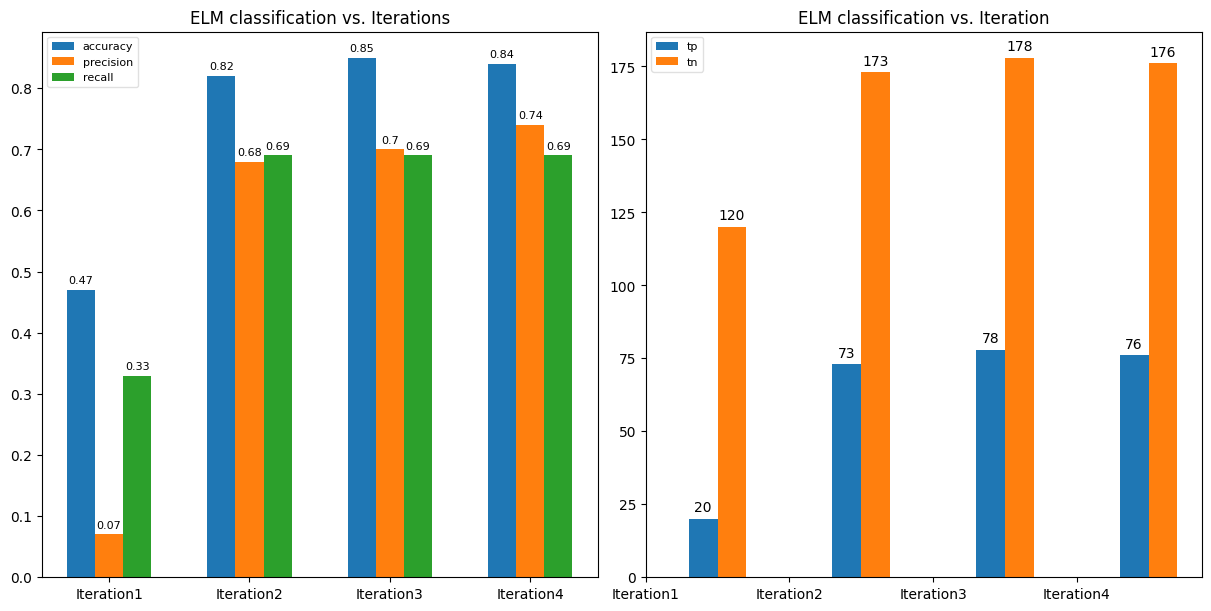

In [15]:
import matplotlib 
%matplotlib inline

from utils.vis_utils import plot_bar_metrics

%load_ext autoreload
%autoreload 2

# Visualize classification results
plot_bar_metrics(al_ent_cls_results, metric_type='classification', xticks_label='Iteration', figsize=(12, 6))
# Visualize detection results
if len(al_ent_det_results)>0:
    plot_bar_metrics(al_ent_det_results, metric_type='Detection', xticks_label='Iteration', figsize=(12, 6))
